# Introduction

We tackle the problem of OCR post processing. In OCR, we map the image form of the document into the text domain. This is done first using an CNN+LSTM+CTC model, in our case based on tesseract. Since this output maps only image to text, we need something on top to validate and correct language semantics.

The idea is to build a language model, that takes the OCRed text and corrects it based on language knowledge. The langauge model could be:
- Char level: the aim is to capture the word morphology. In which case it's like a spelling correction system.
- Word level: the aim is to capture the sentence semnatics. But such systems suffer from the OOV problem.
- Fusion: to capture semantics and morphology language rules. The output has to be at char level, to avoid the OOV. However, the input can be char, word or both.

The fusion model target is to learn:

    p(char | char_context, word_context)

In this workbook we use seq2seq vanilla Keras implementation, adapted from the lstm_seq2seq example on Eng-Fra translation task. The adaptation involves:

- Adapt to spelling correction, on char level
- Pre-train on a noisy, medical sentences
- Fine tune a residual, to correct the mistakes of tesseract 
- Limit the input and output sequence lengths
- Enusre teacher forcing auto regressive model in the decoder
- Limit the padding per batch
- Learning rate schedule
- Bi-directional LSTM Encoder
- Bi-directional GRU Encoder


# Imports

In [1]:
from __future__ import print_function
import tensorflow as tf
import keras.backend as K
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate, GRU, Dot, TimeDistributed, Activation, Embedding
from keras import optimizers
from keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


# Utility functions

In [2]:
# Limit gpu allocation. allow_growth, or gpu_fraction
def gpu_alloc():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))

In [3]:
gpu_alloc()

In [4]:
def calculate_WER_sent(gt, pred):
    '''
    calculate_WER('calculating wer between two sentences', 'calculate wer between two sentences')
    '''
    gt_words = gt.lower().split(' ')
    pred_words = pred.lower().split(' ')
    d = np.zeros(((len(gt_words) + 1), (len(pred_words) + 1)), dtype=np.uint8)
    # d = d.reshape((len(gt_words)+1, len(pred_words)+1))

    # Initializing error matrix
    for i in range(len(gt_words) + 1):
        for j in range(len(pred_words) + 1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    # computation
    for i in range(1, len(gt_words) + 1):
        for j in range(1, len(pred_words) + 1):
            if gt_words[i - 1] == pred_words[j - 1]:
                d[i][j] = d[i - 1][j - 1]
            else:
                substitution = d[i - 1][j - 1] + 1
                insertion = d[i][j - 1] + 1
                deletion = d[i - 1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)
    return d[len(gt_words)][len(pred_words)]

In [5]:
def calculate_WER(gt, pred):
    '''

    :param gt: list of sentences of the ground truth
    :param pred: list of sentences of the predictions
    both lists must have the same length
    :return: accumulated WER
    '''
#    assert len(gt) == len(pred)
    WER = 0
    nb_w = 0
    for i in range(len(gt)):
        #print(gt[i])
        #print(pred[i])
        WER += calculate_WER_sent(gt[i], pred[i])
        nb_w += len(gt[i])

    return WER / nb_w

In [6]:
# Artificial noisy spelling mistakes
def noise_maker(sentence, threshold):
    '''Relocate, remove, or add characters to create spelling mistakes'''
    letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m',
           'n','o','p','q','r','s','t','u','v','w','x','y','z',]
    noisy_sentence = []
    i = 0
    while i < len(sentence):
        random = np.random.uniform(0, 1, 1)
        # Most characters will be correct since the threshold value is high
        if random < threshold:
            noisy_sentence.append(sentence[i])
        else:
            new_random = np.random.uniform(0, 1, 1)
            # ~33% chance characters will swap locations
            if new_random > 0.67:
                if i == (len(sentence) - 1):
                    # If last character in sentence, it will not be typed
                    continue
                else:
                    # if any other character, swap order with following character
                    noisy_sentence.append(sentence[i + 1])
                    noisy_sentence.append(sentence[i])
                    i += 1
            # ~33% chance an extra lower case letter will be added to the sentence
            elif new_random < 0.33:
                random_letter = np.random.choice(letters, 1)[0]
                noisy_sentence.append(random_letter)
                noisy_sentence.append(sentence[i])
            # ~33% chance a character will not be typed
            else:
                pass
        i += 1

    return ''.join(noisy_sentence)

In [7]:
def load_data_with_gt(file_name, num_samples, max_sent_len, min_sent_len, delimiter='\t', gt_index=1, prediction_index=0):
    '''Load data from txt file, with each line has: <TXT><TAB><GT>. The  target to the decoder muxt have \t as the start trigger and \n as the stop trigger.'''
    cnt = 0  
    input_texts = []
    gt_texts = []
    target_texts = []
    for row in open(file_name, encoding='utf8'):
        if cnt < num_samples :
            #print(row)
            sents = row.split(delimiter)
            input_text = sents[prediction_index]
            
            target_text = '\t' + sents[gt_index] + '\n'
            if len(input_text) > min_sent_len and len(input_text) < max_sent_len and len(target_text) > min_sent_len and len(target_text) < max_sent_len:
                cnt += 1
                
                input_texts.append(input_text)
                target_texts.append(target_text)
                gt_texts.append(sents[gt_index])
    return input_texts, target_texts, gt_texts

In [8]:
def load_data_with_noise(file_name, num_samples, noise_threshold, max_sent_len, min_sent_len):
    '''Load data from txt file, with each line has: <TXT>. The GT is just a noisy version of TXT. The  target to the decoder muxt have \t as the start trigger and \n as the stop trigger.'''
    cnt = 0  
    input_texts = []
    gt_texts = []
    target_texts = []
    while cnt < num_samples :
        for row in open(file_name, encoding='utf8'):
        #for row in open(file_name):
            if cnt < num_samples :
                sents = row.split("\t")
                input_text = noise_maker(sents[1], noise_threshold)
                input_text = input_text[:-1]

                target_text = '\t' + sents[1] + '\n'            
                if len(input_text) > min_sent_len and len(input_text) < max_sent_len and len(target_text) > min_sent_len and len(target_text) < max_sent_len:
                    cnt += 1
                    input_texts.append(input_text)
                    target_texts.append(target_text)
                    gt_texts.append(target_text[1:-1])
                    
    return input_texts, target_texts, gt_texts

In [9]:
def build_vocab(all_texts):
    '''Build vocab dictionary to victorize chars into ints'''
    vocab_to_int = {}
    count = 0 # Start index for any char will be 1, as 0 is masked by the Embedding/Masking layer
    codes = ['UNK', ' ', '\t','\n']# Start 'UNK' at the first entry, to keep its index=0 to be masked
    for code in codes:
        if code not in vocab_to_int:
            vocab_to_int[code] = count
            count += 1    
    
    for sentence in all_texts:
        for char in sentence:
            if char not in vocab_to_int:
                vocab_to_int[char] = count
                count += 1


    '''''Build inverse translation from int to char'''
    int_to_vocab = {}
    for character, value in vocab_to_int.items():
        int_to_vocab[value] = character
        
    return vocab_to_int, int_to_vocab

In [10]:
def vectorize_data(input_texts, target_texts, max_encoder_seq_length, num_encoder_tokens, vocab_to_int):
    '''Prepares the input text and targets into the proper seq2seq numpy arrays'''
    encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length),
    dtype='float32')
    decoder_input_data = np.zeros(
        (len(input_texts), max_decoder_seq_length),
        dtype='float32')
    decoder_target_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, num_encoder_tokens),
        dtype='float32')

    for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
        for t, char in enumerate(input_text):
            # c0..cn
            encoder_input_data[i, t] = vocab_to_int[char]
        for t, char in enumerate(target_text):
            # c0'..cm'
            # decoder_target_data is ahead of decoder_input_data by one timestep
            decoder_input_data[i, t] = vocab_to_int[char]
            if t > 0:
                # decoder_target_data will be ahead by one timestep
                # and will not include the start character.
                decoder_target_data[i, t - 1, vocab_to_int[char]] = 1.
                
    return encoder_input_data, decoder_input_data, decoder_target_data

In [11]:
def decode_gt_sequence(input_seq, int_to_vocab):

    stop_condition = False
    decoded_sentence = ''
    for i in range(input_seq.shape[1]):
        
        # Sample a token
        sampled_token_index = input_seq[0][i]
        sampled_char = int_to_vocab[sampled_token_index]
        decoded_sentence += sampled_char

    return decoded_sentence


In [12]:
def decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab):
    # Encode the input as state vectors.
    encoder_outputs, h, c  = encoder_model.predict(input_seq)
    states_value = [h,c]
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = vocab_to_int['\t']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    #print(input_seq)
    attention_density = []
    while not stop_condition:
        #print(target_seq)
        output_tokens, attention, h, c  = decoder_model.predict(
            [target_seq, encoder_outputs] + states_value)
        #print(attention.shape)
        attention_density.append(attention[0][0])# attention is max_sent_len x 1 since we have num_time_steps = 1 for the output
        # Sample a token
        #print(output_tokens.shape)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        
        #print(sampled_token_index)
        sampled_char = int_to_vocab[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]
    attention_density = np.array(attention_density)
    return decoded_sentence, attention_density


In [13]:
def build_model(num_encoder_tokens, latent_dim):
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None,), dtype='float32')
    encoder_inputs_ = Embedding(num_encoder_tokens, num_encoder_tokens,                           
                            weights=[np.eye(num_encoder_tokens)],
                            mask_zero=True, trainable=False)(encoder_inputs)    
    #encoder_inputs = Input(shape=(None, num_encoder_tokens))
    encoder = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True)) # Bi LSTM
    encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM
    state_h = Concatenate()([state_f_h, state_b_h])# Bi LSTM
    state_c = Concatenate()([state_f_c, state_b_c])# Bi LSTM

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]# Bi GRU, LSTM, BHi LSTM
    print(encoder_states)
    
    decoder_inputs = Input(shape=(None,))
    decoder_inputs_ = Embedding(num_encoder_tokens, num_encoder_tokens,                           
                            weights=[np.eye(num_encoder_tokens)],
                            mask_zero=True, trainable=False)(decoder_inputs)    
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)# Bi LSTM
    
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs_, initial_state=encoder_states)

    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation
    print(decoder_outputs)
    print(encoder_outputs)
    att_dot = Dot(axes=[2, 2])
    attention = att_dot([decoder_outputs, encoder_outputs])
    att_activation = Activation('softmax', name='attention')
    attention = att_activation(attention)
    #print('attention', attention)
    context_dot = Dot(axes=[2,1])
    context = context_dot([attention, encoder_outputs])
    #print('context', context)
    att_context_concat = Concatenate()
    decoder_combined_context = att_context_concat([context, decoder_outputs])
    #print('decoder_combined_context', decoder_combined_context)

    # Has another weight + tanh layer as described in equation (5) of the paper
    #decoder_outputs = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
    #decoder_outputs = TimeDistributed(Dense(num_encoder_tokens, activation="softmax"))(decoder_outputs)

    decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    #decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_combined_context)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    #model = Model(decoder_inputs, decoder_outputs)
    print('encoder-decoder  model:')
    print(model.summary()) 
    
    print(encoder_inputs)
    print(encoder_outputs)
    print(encoder_states)
    #encoder_model = Model(encoder_inputs, [encoder_outputs, encoder_states])
    encoder_model = Model(input=encoder_inputs, output=[encoder_outputs] + encoder_states)

    #decoder_state_input_h = Input(shape=(latent_dim,))# LSTM
    #decoder_state_input_c = Input(shape=(latent_dim,))# LSTM
    decoder_encoder_inputs = Input(shape=(None, latent_dim*2,))
    decoder_state_input_h = Input(shape=(latent_dim*2,))# Bi LSTM
    decoder_state_input_c = Input(shape=(latent_dim*2,)) # Bi LSTM
    #decoder_state_input = Input(shape=(latent_dim*2,)) # Bi GRU

    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    #decoder_states_inputs = [decoder_state_input] # Bi GRU

    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_, initial_state=decoder_states_inputs)

    #decoder_outputs, state = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

    decoder_states = [state_h, state_c]
    
    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation
    
    attention = att_dot([decoder_outputs, decoder_encoder_inputs])
    
    attention = att_activation(attention)
    #print('attention', attention)
    
    context = context_dot([attention, decoder_encoder_inputs])
    #print('context', context)
    
    
    
    decoder_combined_context = att_context_concat([context, decoder_outputs])
    #print('decoder_combined_context', decoder_combined_context)

    # Has another weight + tanh layer as described in equation (5) of the paper
    #decoder_outputs = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
    #decoder_outputs = TimeDistributed(Dense(num_encoder_tokens, activation="softmax"))(decoder_outputs)
    
    #decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    #decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_combined_context)
    
    decoder_model = Model(
        [decoder_inputs, decoder_encoder_inputs] + decoder_states_inputs,
        [decoder_outputs, attention] + decoder_states)
    
    return model, encoder_model, decoder_model

In [14]:
def visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, vocab_to_int, int_to_vocab):

    encoder_input_data = np.zeros((1, max_encoder_seq_length), dtype='float32')
    
    for t, char in enumerate(text):
        # c0..cn
        encoder_input_data[0, t] = vocab_to_int[char]

    input_seq = encoder_input_data[0:1]

    decoded_sentence, attention_density = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)

    plt.clf()
    plt.figure(figsize=(28,12))
    
    ax = sns.heatmap(attention_density[:, : len(text) + 2],
        xticklabels=[w for w in text],
        yticklabels=[w for w in decoded_sentence])

    ax.invert_yaxis()
    plt.show()
    
    return decoded_sentence

# Load data

In [15]:
data_path = '../../dat/'

In [16]:
max_sent_len = 1000000
min_sent_len = -1

## Results on tesseract correction

In [17]:
num_samples = 1000000
tess_correction_data = os.path.join(data_path, 'all_ocr_data_2.txt')
input_texts_OCR, target_texts_OCR, gt_OCR = load_data_with_gt(tess_correction_data, num_samples, max_sent_len, min_sent_len)

In [18]:
input_texts = input_texts_OCR
target_texts = target_texts_OCR

In [19]:
## Histogram of lenghts
lengths = []
for text in input_texts:
    lengths.append(len(text))
    lengths.append(len(text))

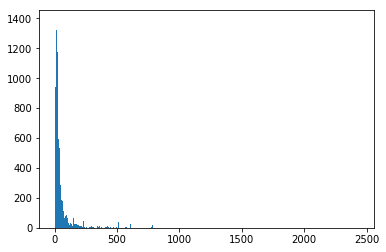

In [20]:
h = plt.hist(lengths, bins=500)

In [21]:
h[0]

array([ 1180.,   940.,  1384.,  1322.,  1174.,   722.,   592.,   536.,
         332.,   286.,   242.,   186.,   180.,   214.,   112.,   154.,
          68.,    82.,    58.,    88.,    70.,    64.,    32.,    30.,
          20.,    26.,    32.,    24.,    58.,    14.,    64.,     6.,
          28.,    16.,    24.,    28.,     8.,    18.,    14.,    18.,
          12.,    24.,    14.,    28.,    14.,     4.,    12.,    44.,
           4.,     6.,     2.,     4.,     6.,     0.,    36.,     0.,
           4.,     4.,     8.,     6.,    14.,     8.,     8.,     8.,
           2.,     0.,     6.,     2.,     2.,     4.,    12.,    14.,
           8.,    12.,     6.,     0.,     4.,     4.,     2.,     0.,
           2.,     0.,     4.,     6.,     0.,     4.,    14.,    26.,
           4.,     0.,     2.,     4.,     4.,     2.,     4.,     2.,
           6.,     0.,     2.,     2.,     2.,     6.,     4.,     2.,
          40.,     4.,     0.,     0.,     2.,     0.,     0.,     0.,
      

In [22]:
h[1]

array([    0.   ,     4.878,     9.756,    14.634,    19.512,    24.39 ,
          29.268,    34.146,    39.024,    43.902,    48.78 ,    53.658,
          58.536,    63.414,    68.292,    73.17 ,    78.048,    82.926,
          87.804,    92.682,    97.56 ,   102.438,   107.316,   112.194,
         117.072,   121.95 ,   126.828,   131.706,   136.584,   141.462,
         146.34 ,   151.218,   156.096,   160.974,   165.852,   170.73 ,
         175.608,   180.486,   185.364,   190.242,   195.12 ,   199.998,
         204.876,   209.754,   214.632,   219.51 ,   224.388,   229.266,
         234.144,   239.022,   243.9  ,   248.778,   253.656,   258.534,
         263.412,   268.29 ,   273.168,   278.046,   282.924,   287.802,
         292.68 ,   297.558,   302.436,   307.314,   312.192,   317.07 ,
         321.948,   326.826,   331.704,   336.582,   341.46 ,   346.338,
         351.216,   356.094,   360.972,   365.85 ,   370.728,   375.606,
         380.484,   385.362,   390.24 ,   395.118, 

In [23]:
max_sent_len =  h[1][np.argmax(h[0])]
min_sent_len = h[1][1]
print('Most probable length = ', max_sent_len)
print('Count of most probable lenght = ', np.max(h[0]))
print('Min length = ', min_sent_len)

Most probable length =  9.756
Count of most probable lenght =  1384.0
Min length =  4.878


In [24]:
max_sent_len =  50#int(np.ceil(max_sent_len))
min_sent_len = 4#int(np.floor(min_sent_len))

In [25]:
print('Most probable length = ', max_sent_len)
print('Min length = ', min_sent_len)

Most probable length =  50
Min length =  4


In [26]:
num_samples = 1000000

tess_correction_data = os.path.join(data_path, 'all_ocr_data_2.txt')
input_texts_OCR_tess, target_texts_tess, gt_tess = load_data_with_gt(tess_correction_data, num_samples, max_sent_len, min_sent_len)

num_samples = 0
OCR_data = os.path.join(data_path, 'output_handwritten.txt')
input_texts_OCR_hand, target_texts_OCR_hand, gt_texts_OCR_hand = load_data_with_gt(OCR_data, num_samples, max_sent_len, min_sent_len, delimiter='|',gt_index=0, prediction_index=1)

In [27]:
#input_texts = input_texts_OCR
#target_texts = target_texts_OCR
input_texts_OCR = input_texts_OCR_tess + input_texts_OCR_hand
target_texts_OCR = target_texts_tess + target_texts_OCR_hand


In [28]:
len(input_texts_OCR)

3579

# Results of pre-training on generic data

In [29]:
'''
num_samples = 0
big_data = os.path.join(data_path, 'big.txt')
threshold = 0.9
input_texts_gen, target_texts_gen, gt_gen = load_data_with_noise(file_name=big_data, 
                                                                 num_samples=num_samples, 
                                                                 noise_threshold=threshold, 
                                                                 max_sent_len=max_sent_len, 
                                                                 min_sent_len=min_sent_len)
'''                                                                 

"\nnum_samples = 0\nbig_data = os.path.join(data_path, 'big.txt')\nthreshold = 0.9\ninput_texts_gen, target_texts_gen, gt_gen = load_data_with_noise(file_name=big_data, \n                                                                 num_samples=num_samples, \n                                                                 noise_threshold=threshold, \n                                                                 max_sent_len=max_sent_len, \n                                                                 min_sent_len=min_sent_len)\n"

In [30]:
#input_texts = input_texs_gen
#target_texts = target_texts_gen

# Results on noisy tesseract corrections

In [31]:
num_samples = 10000
tess_correction_data = os.path.join(data_path, 'all_ocr_data_2.txt')
threshold = 0.9
input_texts_noisy_OCR, target_texts_noisy_OCR, gt_noisy_OCR = load_data_with_noise(file_name=tess_correction_data, 
                                                                 num_samples=num_samples, 
                                                                 noise_threshold=threshold, 
                                                                 max_sent_len=max_sent_len, 
                                                                 min_sent_len=min_sent_len)

In [32]:
'''
input_texts = input_texts_noisy_OCR
target_texts = target_texts_noisy_OCR
'''

'\ninput_texts = input_texts_noisy_OCR\ntarget_texts = target_texts_noisy_OCR\n'

# Results on merge of tesseract correction + generic data

In [33]:
'''
input_texts = input_texts_OCR + input_texts_gen
target_texts = input_texts_OCR + target_texts_gen
'''

'\ninput_texts = input_texts_OCR + input_texts_gen\ntarget_texts = input_texts_OCR + target_texts_gen\n'

# Results noisy tesseract correction + generic data

In [34]:
'''
input_texts = input_texts_noisy_OCR + input_texts_gen
target_texts = input_texts_noisy_OCR + target_texts_gen
'''

'\ninput_texts = input_texts_noisy_OCR + input_texts_gen\ntarget_texts = input_texts_noisy_OCR + target_texts_gen\n'

# Results noisy tesseract noisy + correction data

In [35]:
input_texts = input_texts_noisy_OCR + input_texts_OCR
target_texts = target_texts_noisy_OCR + target_texts_OCR

# Results of pre-training on generic and fine tuning on tesseract correction

In [36]:
# TODO

In [37]:
# Sample data
print(len(input_texts))
for i in range(10):
    print(input_texts[i], '\n', target_texts[i])

13579
Claqim Tyep: VB Accident - Accidental Injury 
 	Claim Type: VB Accident - Accidental Injury


Poliyohldepr/Owbnuer Infowrmation 
 	Policyholder/Owner Information


First Name
 
 	First Name:


Middle Name/Initial: 
 	Middle Name/Initial:


Last Name: 
 	Last Name:


Social Security Numbe: 
 	Social Security Number:


Birth Dat:e 
 	Birth Date:


Gendre: 
 	Gender:


anguage Prfeerence: 
 	Language Preference:


Addresss Line 1: 
 	Address Line 1:




## Build vocab

In [38]:
all_texts = target_texts + input_texts
vocab_to_int, int_to_vocab = build_vocab(all_texts)
np.savez('vocab', vocab_to_int=vocab_to_int, int_to_vocab=int_to_vocab, max_sent_len=max_sent_len, min_sent_len=min_sent_len )

In [39]:
input_characters = sorted(list(vocab_to_int))
target_characters = sorted(list(vocab_to_int))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [40]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 13579
Number of unique input tokens: 115
Number of unique output tokens: 115
Max sequence length for inputs: 49
Max sequence length for outputs: 49


In [41]:
vocab_to_int # Some special chars need to be removed TODO: Data cleaning

{'\t': 2,
 '\n': 3,
 ' ': 1,
 '!': 104,
 '"': 95,
 '#': 67,
 '$': 80,
 '%': 85,
 '&': 73,
 "'": 83,
 '(': 64,
 ')': 65,
 '*': 77,
 '+': 76,
 ',': 69,
 '-': 21,
 '.': 48,
 '/': 29,
 '0': 54,
 '1': 43,
 '2': 53,
 '3': 57,
 '4': 56,
 '5': 74,
 '6': 55,
 '7': 70,
 '8': 61,
 '9': 72,
 ':': 13,
 ';': 75,
 '<': 107,
 '=': 94,
 '?': 60,
 '@': 81,
 'A': 16,
 'B': 15,
 'C': 4,
 'D': 40,
 'E': 45,
 'F': 33,
 'G': 41,
 'H': 52,
 'I': 22,
 'J': 68,
 'K': 50,
 'L': 37,
 'M': 36,
 'N': 35,
 'O': 30,
 'P': 26,
 'Q': 78,
 'R': 46,
 'S': 38,
 'T': 9,
 'U': 49,
 'UNK': 0,
 'V': 14,
 'W': 51,
 'X': 79,
 'Y': 47,
 'Z': 71,
 '[': 91,
 '\\': 97,
 ']': 92,
 '^': 86,
 '_': 105,
 'a': 6,
 'b': 39,
 'c': 17,
 'd': 18,
 'e': 12,
 'f': 32,
 'g': 42,
 'h': 28,
 'i': 7,
 'j': 23,
 'k': 59,
 'l': 5,
 'm': 8,
 'n': 19,
 'o': 27,
 'p': 11,
 'q': 58,
 'r': 25,
 's': 34,
 't': 20,
 'u': 24,
 'v': 44,
 'w': 31,
 'x': 62,
 'y': 10,
 'z': 63,
 '{': 108,
 '|': 82,
 '}': 100,
 '~': 103,
 '£': 113,
 '§': 109,
 '«': 111,
 '®': 

In [42]:
int_to_vocab

{0: 'UNK',
 1: ' ',
 2: '\t',
 3: '\n',
 4: 'C',
 5: 'l',
 6: 'a',
 7: 'i',
 8: 'm',
 9: 'T',
 10: 'y',
 11: 'p',
 12: 'e',
 13: ':',
 14: 'V',
 15: 'B',
 16: 'A',
 17: 'c',
 18: 'd',
 19: 'n',
 20: 't',
 21: '-',
 22: 'I',
 23: 'j',
 24: 'u',
 25: 'r',
 26: 'P',
 27: 'o',
 28: 'h',
 29: '/',
 30: 'O',
 31: 'w',
 32: 'f',
 33: 'F',
 34: 's',
 35: 'N',
 36: 'M',
 37: 'L',
 38: 'S',
 39: 'b',
 40: 'D',
 41: 'G',
 42: 'g',
 43: '1',
 44: 'v',
 45: 'E',
 46: 'R',
 47: 'Y',
 48: '.',
 49: 'U',
 50: 'K',
 51: 'W',
 52: 'H',
 53: '2',
 54: '0',
 55: '6',
 56: '4',
 57: '3',
 58: 'q',
 59: 'k',
 60: '?',
 61: '8',
 62: 'x',
 63: 'z',
 64: '(',
 65: ')',
 66: '’',
 67: '#',
 68: 'J',
 69: ',',
 70: '7',
 71: 'Z',
 72: '9',
 73: '&',
 74: '5',
 75: ';',
 76: '+',
 77: '*',
 78: 'Q',
 79: 'X',
 80: '$',
 81: '@',
 82: '|',
 83: "'",
 84: '•',
 85: '%',
 86: '^',
 87: '●',
 88: 'ﬁ',
 89: '”',
 90: '°',
 91: '[',
 92: ']',
 93: '–',
 94: '=',
 95: '"',
 96: '✓',
 97: '\\',
 98: 'ﬂ',
 99: '‘',
 100:

In [43]:
len(int_to_vocab)

115

# Prepare training data

## Train/test split

In [44]:
# Split the data into training and testing sentences
input_texts, test_input_texts, target_texts, test_target_texts  = train_test_split(input_texts, target_texts, test_size = 0.15, random_state = 42)

## Vectorize data

## Train data

In [45]:
encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

In [46]:
print(encoder_input_data.shape)
print(decoder_target_data.shape)

(11542, 49)
(11542, 49, 115)


## Test data

In [47]:
test_encoder_input_data, test_decoder_input_data, test_decoder_target_data = vectorize_data(input_texts=test_input_texts,
                                                                                            target_texts=test_target_texts, 
                                                                                            max_encoder_seq_length=max_encoder_seq_length, 
                                                                                            num_encoder_tokens=num_encoder_tokens, 
                                                                                            vocab_to_int=vocab_to_int)

# Encoder-decoder model

In [48]:

latent_dim = 256  # Latent dimensionality of the encoding space.

In [49]:
model, encoder_model, decoder_model = build_model(latent_dim=latent_dim, num_encoder_tokens=num_encoder_tokens)

[<tf.Tensor 'concatenate_1/concat:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'concatenate_2/concat:0' shape=(?, 512) dtype=float32>]
Tensor("lstm_2/transpose_2:0", shape=(?, ?, 512), dtype=float32)
Tensor("bidirectional_1/concat:0", shape=(?, ?, 512), dtype=float32)
encoder-decoder  model:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 115)    13225       input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
______________

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


# Training

In [50]:
batch_size = 64  # Batch size for training.
epochs = 50  
lr = 0.01

# Learning rate decay

In [51]:
model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [52]:
#filepath="weights-improvement-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
filepath="best_model.hdf5" # Save only the best model for inference step, as saving the epoch and metric might confuse the inference function which model to use
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]
#callbacks_list = [checkpoint, tbCallBack, lrate]



In [53]:
def exp_decay(epoch):
    initial_lrate = 0.1
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate
lrate = LearningRateScheduler(exp_decay)
#lr = 0

In [54]:
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)
#lr = 0

In [55]:
#callbacks_list.append(lrate)

In [56]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          validation_data = ([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          #validation_split=0.2,
          shuffle=True)

Train on 11542 samples, validate on 2037 samples
Epoch 1/50
11542/11542 [==============================] - 70s 6ms/step - loss: 2.0476 - categorical_accuracy: 0.4378 - val_loss: 0.5632 - val_categorical_accuracy: 0.8202

Epoch 00001: val_categorical_accuracy improved from -inf to 0.82018, saving model to best_model.hdf5


/opt/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'concatenate_1/concat:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'concatenate_2/concat:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/50
11542/11542 [==============================] - 70s 6ms/step - loss: 0.3666 - categorical_accuracy: 0.8673 - val_loss: 0.2977 - val_categorical_accuracy: 0.8848

Epoch 00002: val_categorical_accuracy improved from 0.82018 to 0.88482, saving model to best_model.hdf5
Epoch 3/50
11542/11542 [==============================] - 68s 6ms/step - loss: 0.2155 - categorical_accuracy: 0.9036 - val_loss: 0.2392 - val_categorical_accuracy: 0.8996

Epoch 00003: val_categorical_accuracy improved from 0.88482 to 0.89959, saving model to best_model.hdf5
Epoch 4/50
11542/11542 [==============================] - 69s 6ms/step - loss: 0.1501 - categorical_accuracy: 0.9190 - val_loss: 0.2153 - val_categorical_accuracy: 0.9051

Epoch 00004: val_categorical_accuracy improved from 0.89959 to 0.90506, saving model to best_model.hdf5
Epoch 5/50
11542/11542 [==============================] - 66s 6ms/step - loss: 0.1111 - categorical_accuracy: 0.9282 - val_loss: 0.1978 - val_categorical_accuracy: 0.9103



KeyboardInterrupt: 

In [ ]:
encoder_model.save('encoder_model.hdf5')
decoder_model.save('decoder_model.hdf5')

In [ ]:
#encoder_input_data[1:2][0]

In [ ]:
#vocab_to_int

In [ ]:
#decode_gt_sequence(encoder_input_data[5:6], int_to_vocab)

In [ ]:
# Sample output from train data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = encoder_input_data[seq_index: seq_index + 1]
    target_seq = np.argmax(decoder_target_data[seq_index: seq_index + 1], axis=-1)
    #print(target_seq)
    decoded_sentence, _ = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)

# Visualize attention

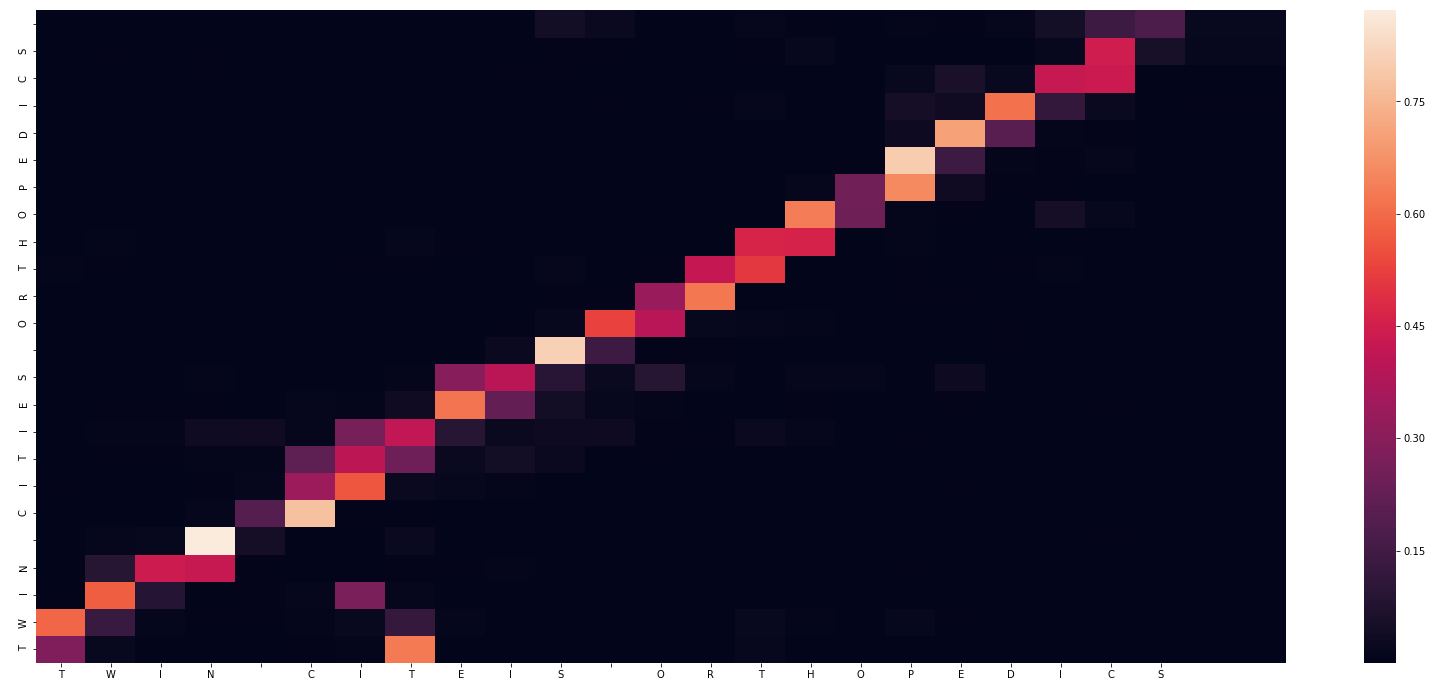

-
Input sentence: TWIN CITEIS ORTHOPEDICS
GT sentence: TWIN CITIES ORTHOPEDICS

Decoded sentence: TWIN CITIES ORTHOPEDICS



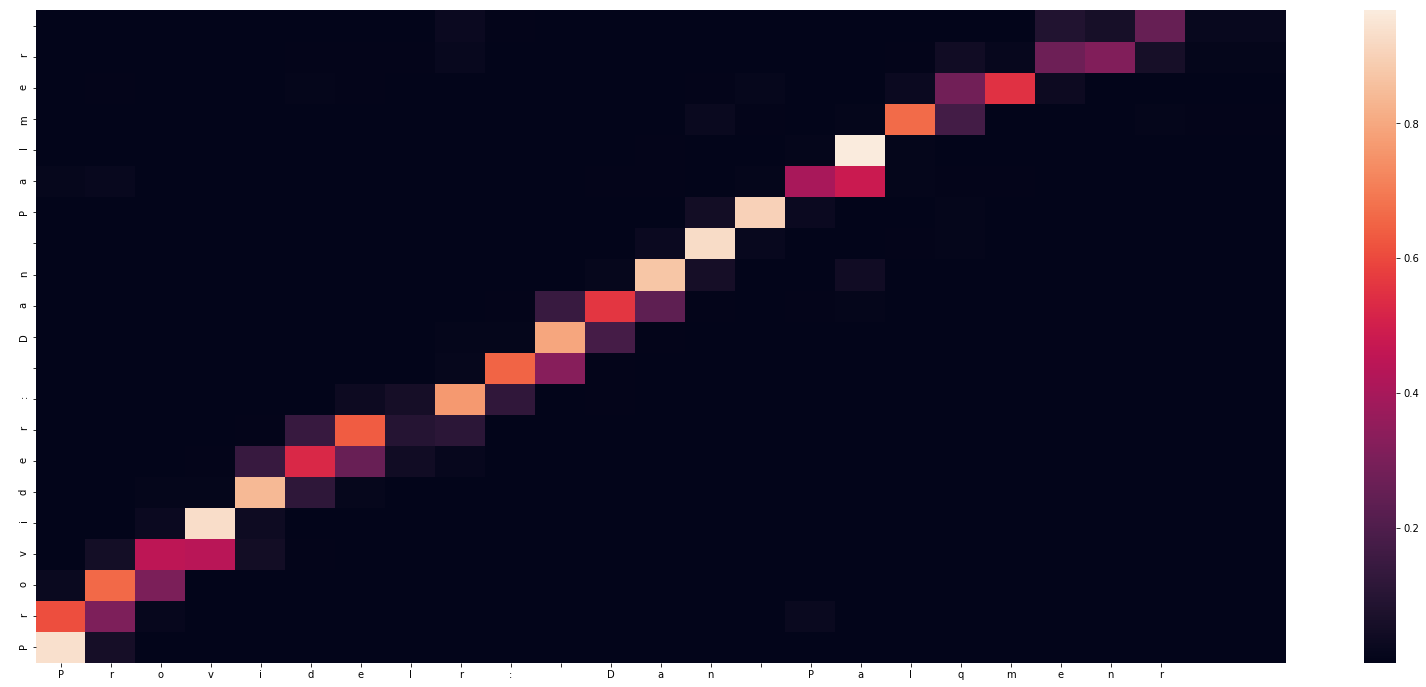

-
Input sentence: Providelr: Dan Palqmenr
GT sentence: Provider: Dan Palmer

Decoded sentence: Provider: Dan Palmer



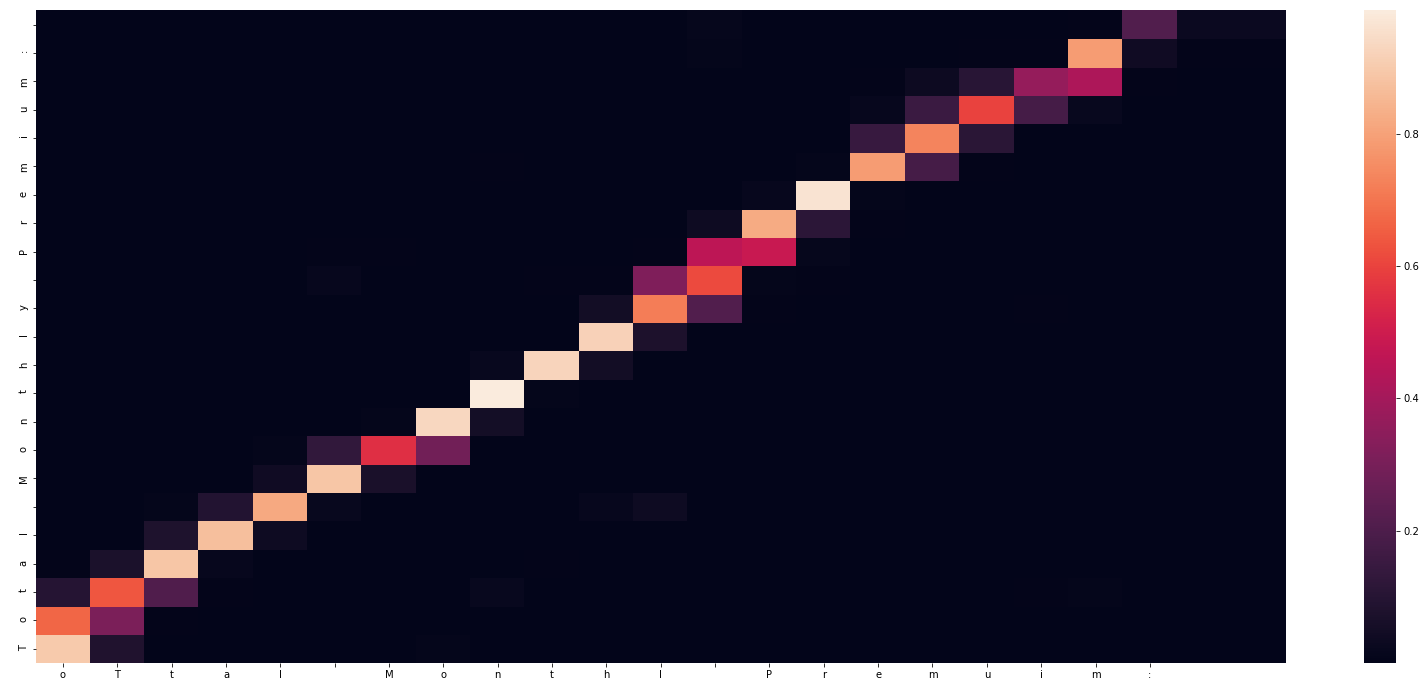

-
Input sentence: oTtal Monthl Premuim:
GT sentence: Total Monthly Premium:

Decoded sentence: Total Monthly Premium:



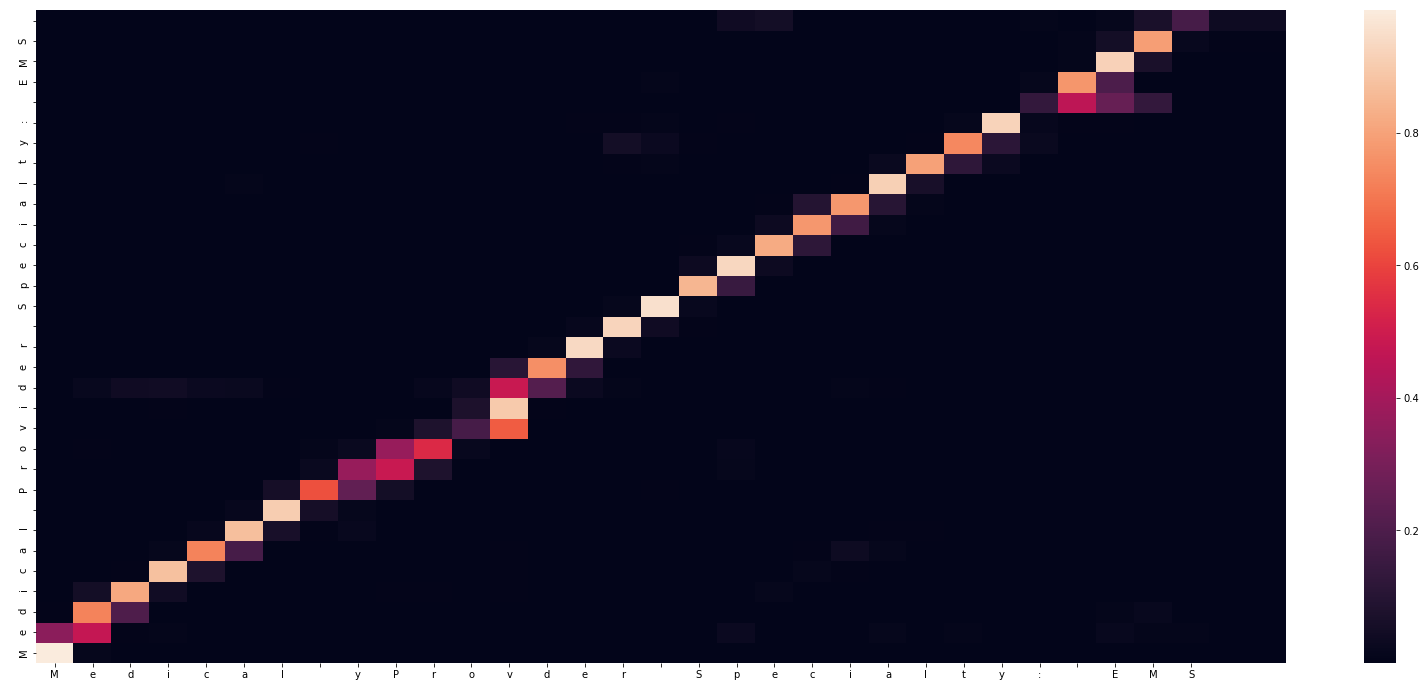

-
Input sentence: Medical yProvder Specialty: EMS
GT sentence: Medical Provider Specialty: EMS

Decoded sentence: Medical Provider Specialty: EMS



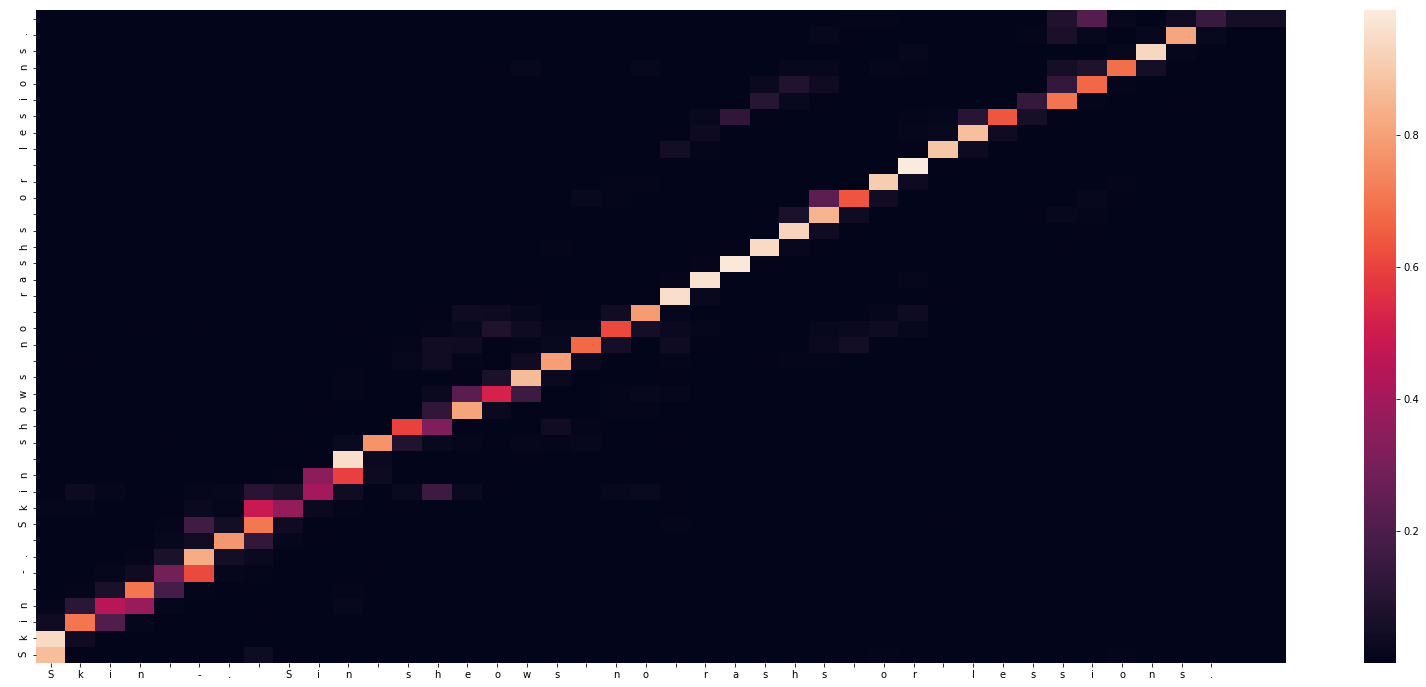

-
Input sentence: Skin -. Sin sheows no rashs or lessions.
GT sentence: Skin -. Skin shows no rashes or lesions.

Decoded sentence: Skin -. Skin shows no rashs or lesions.



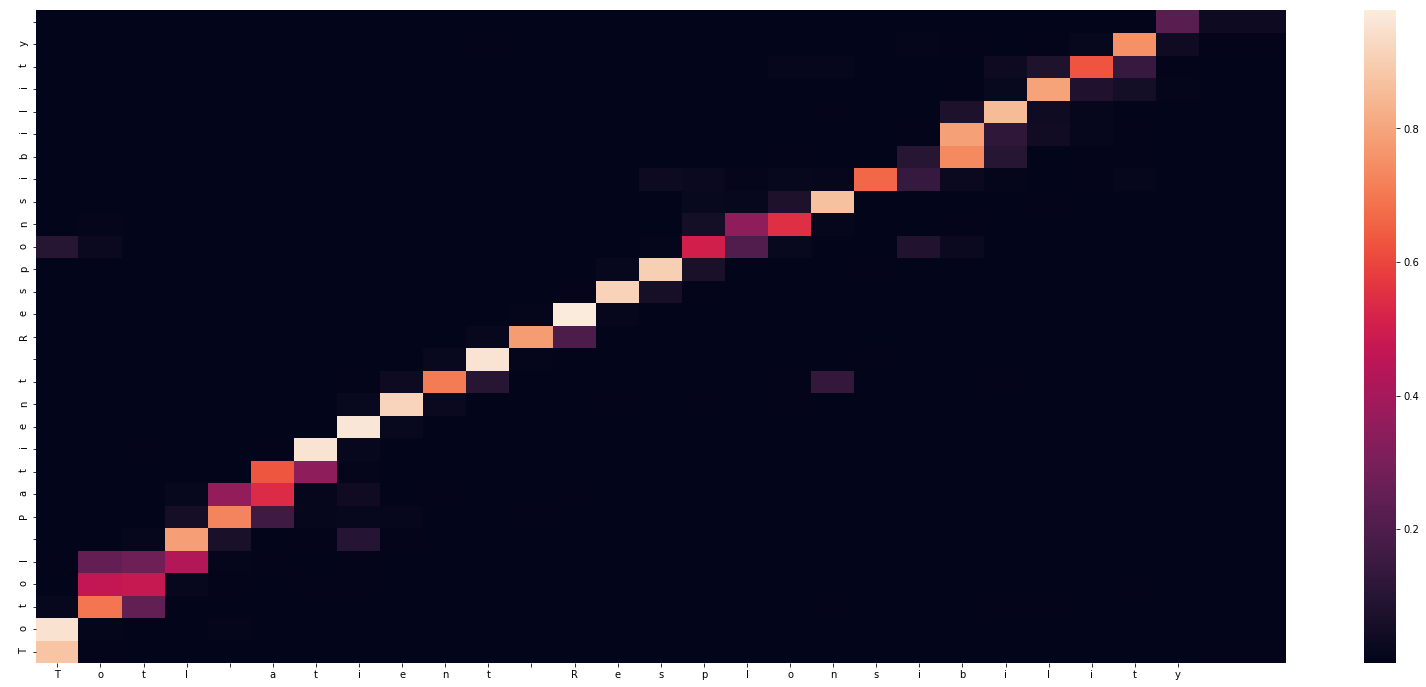

-
Input sentence: Totl atient Resplonsibility
GT sentence: Total Patient Responsibility

Decoded sentence: Totol Patient Responsibility



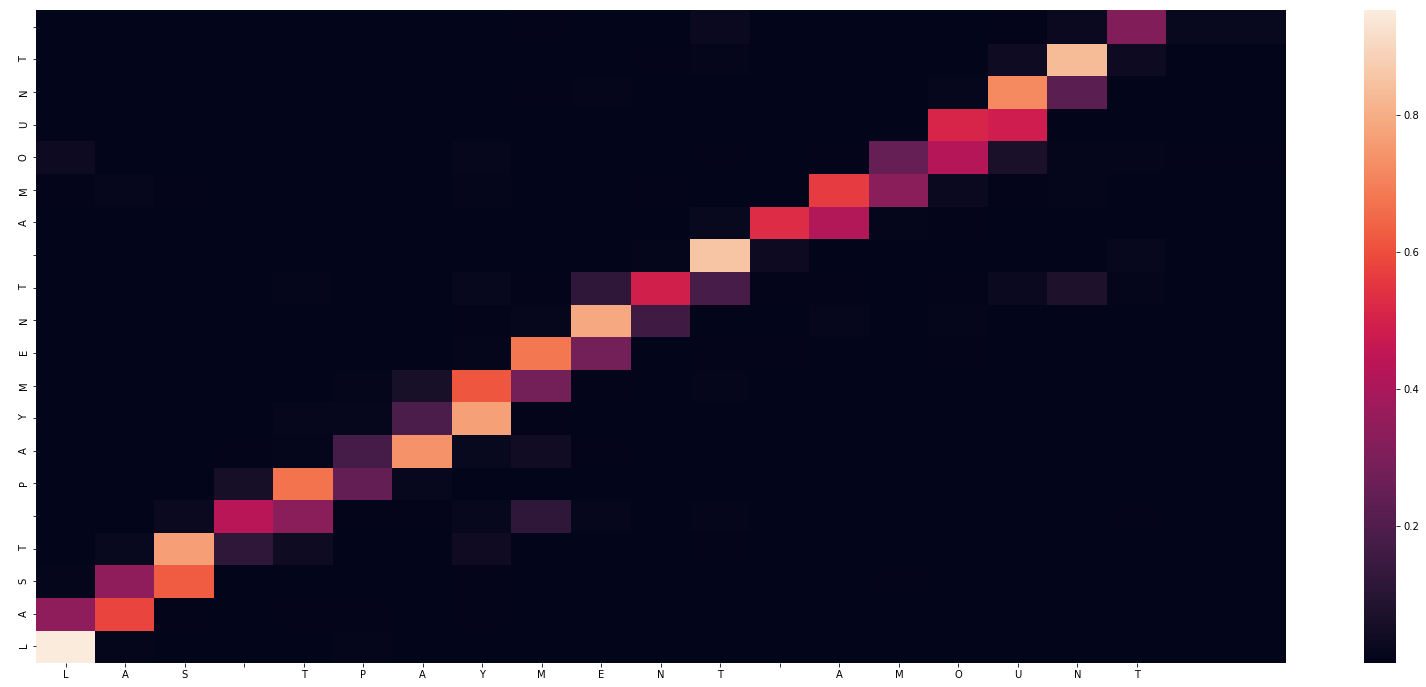

-
Input sentence: LAS TPAYMENT AMOUNT
GT sentence: LAST PAYMENT AMOUNT

Decoded sentence: LAST PAYMENT AMOUNT



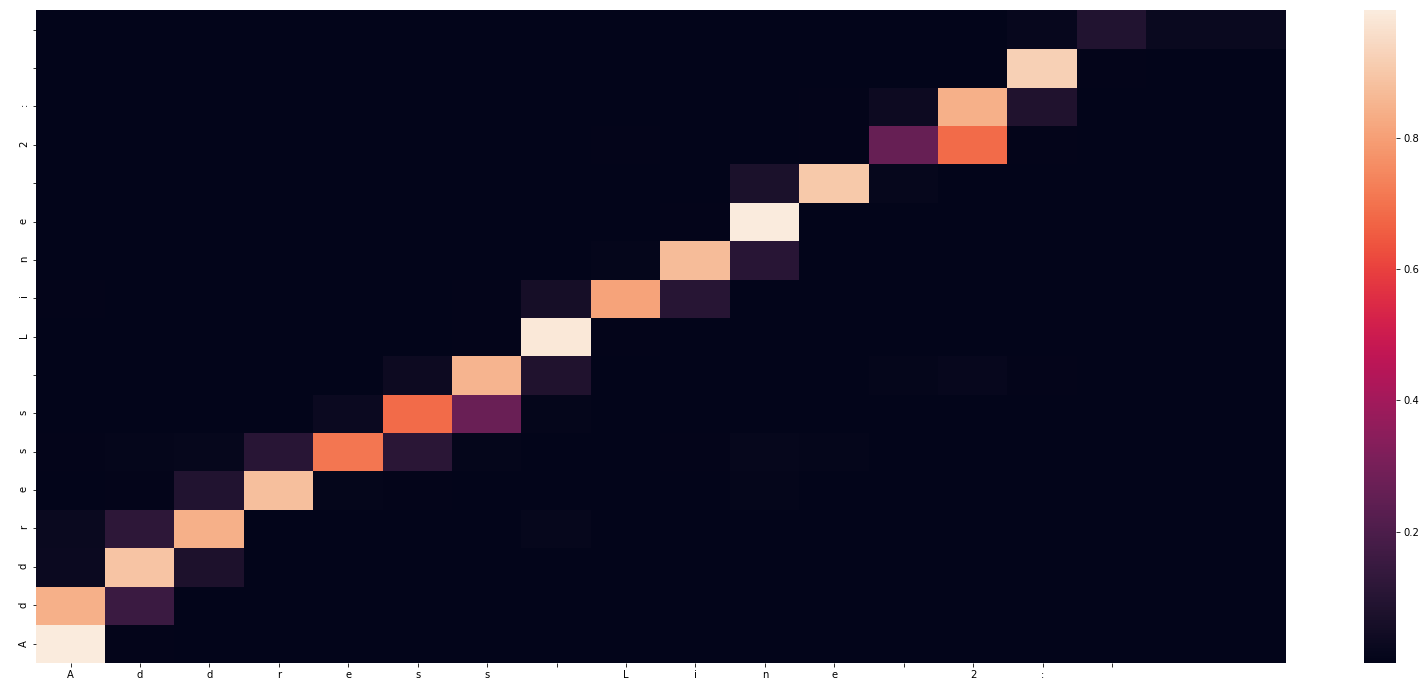

-
Input sentence: Address Line 2: 
GT sentence: Address Line 2: 

Decoded sentence: Address Line 2: 



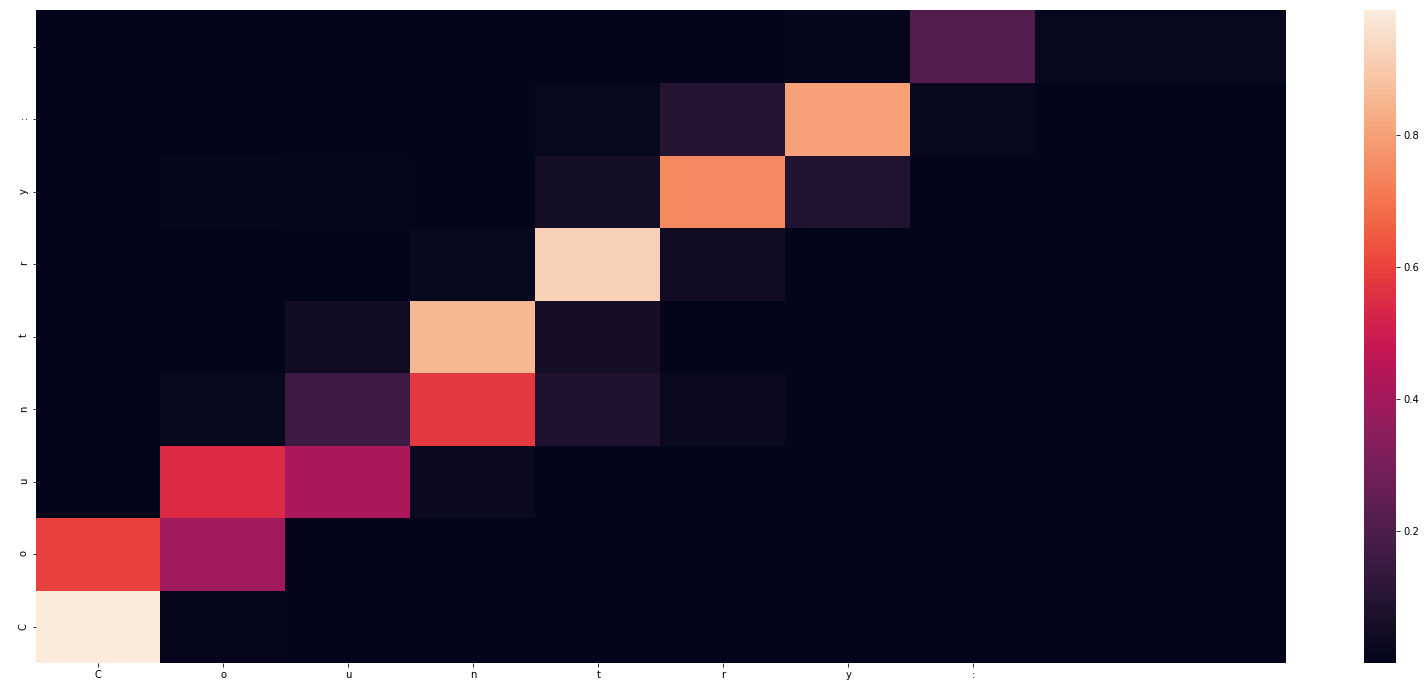

-
Input sentence: Country:
GT sentence: Country:

Decoded sentence: Country:



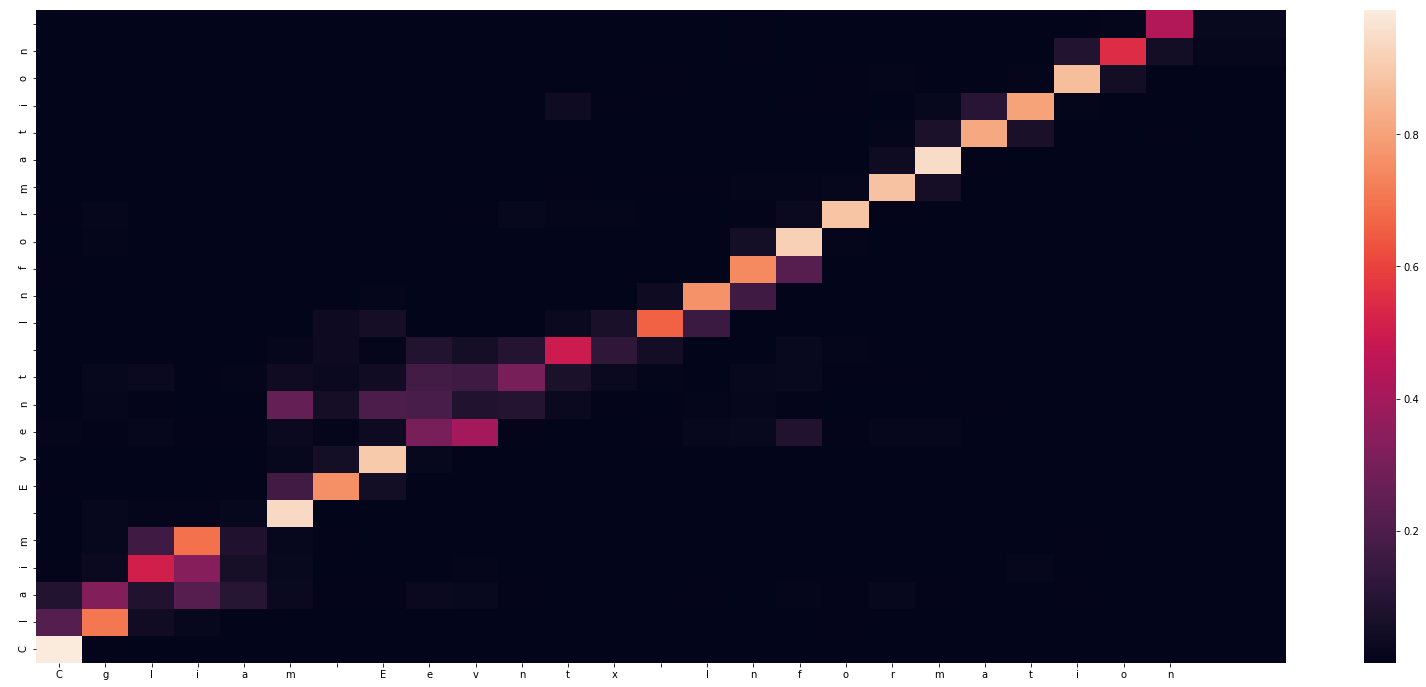

-
Input sentence: Cgliam Eevntx Information
GT sentence: Claim Event Information

Decoded sentence: Claim Event Information



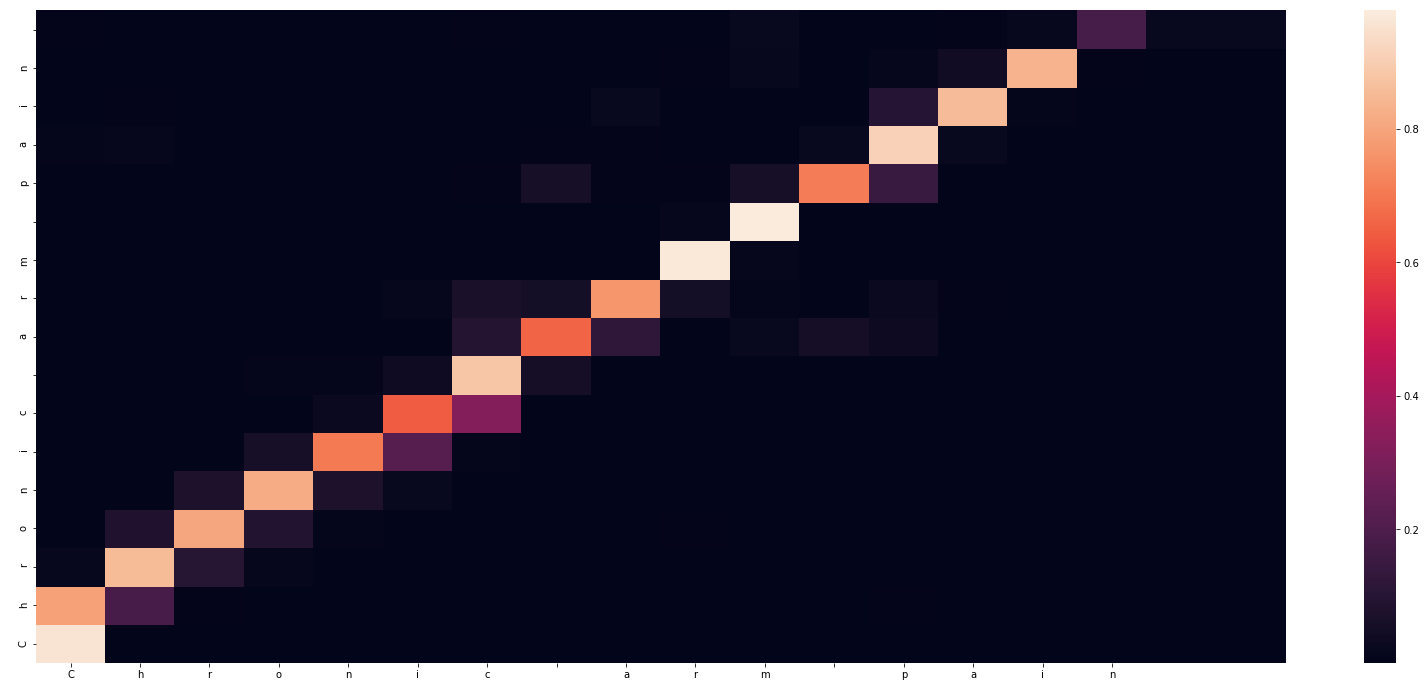

-
Input sentence: Chronic arm pain
GT sentence: Chronic arm pain

Decoded sentence: Chronic arm pain



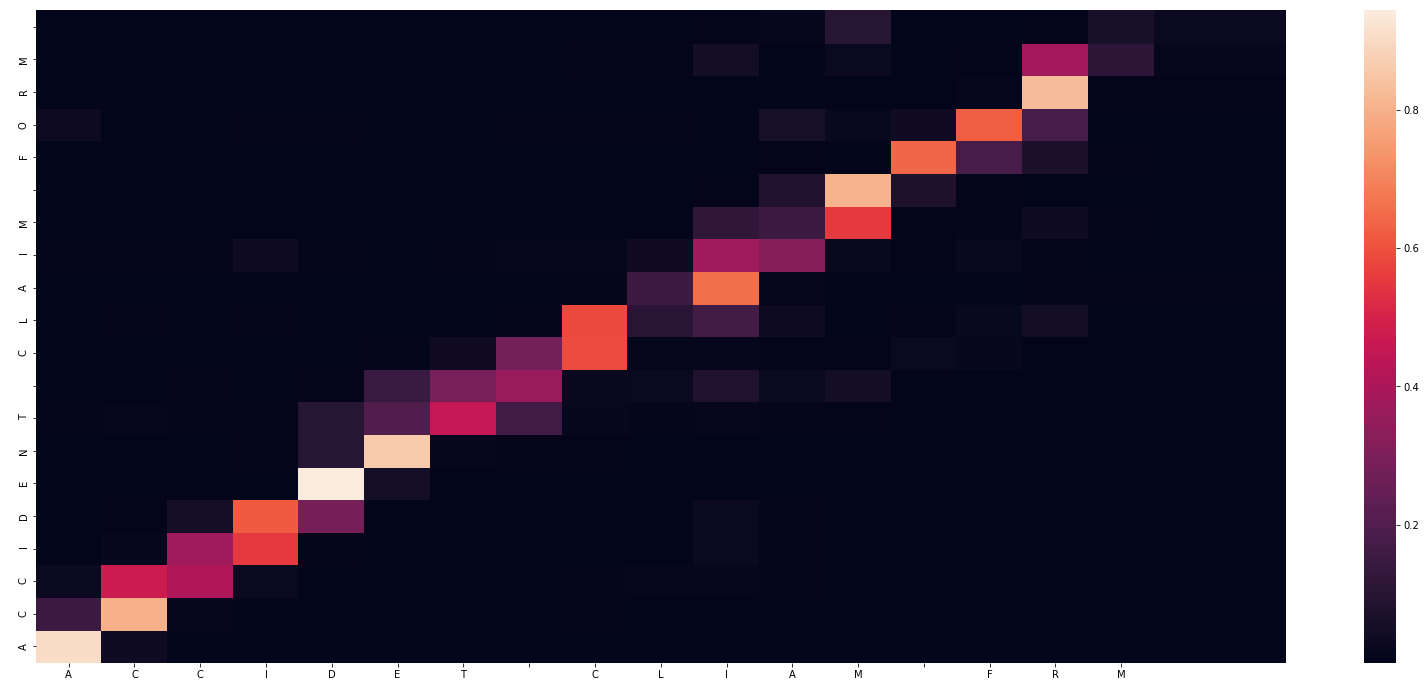

-
Input sentence: ACCIDET CLIAM FRM
GT sentence: ACCIDENT CLAIM FORM

Decoded sentence: ACCIDENT CLAIM FORM



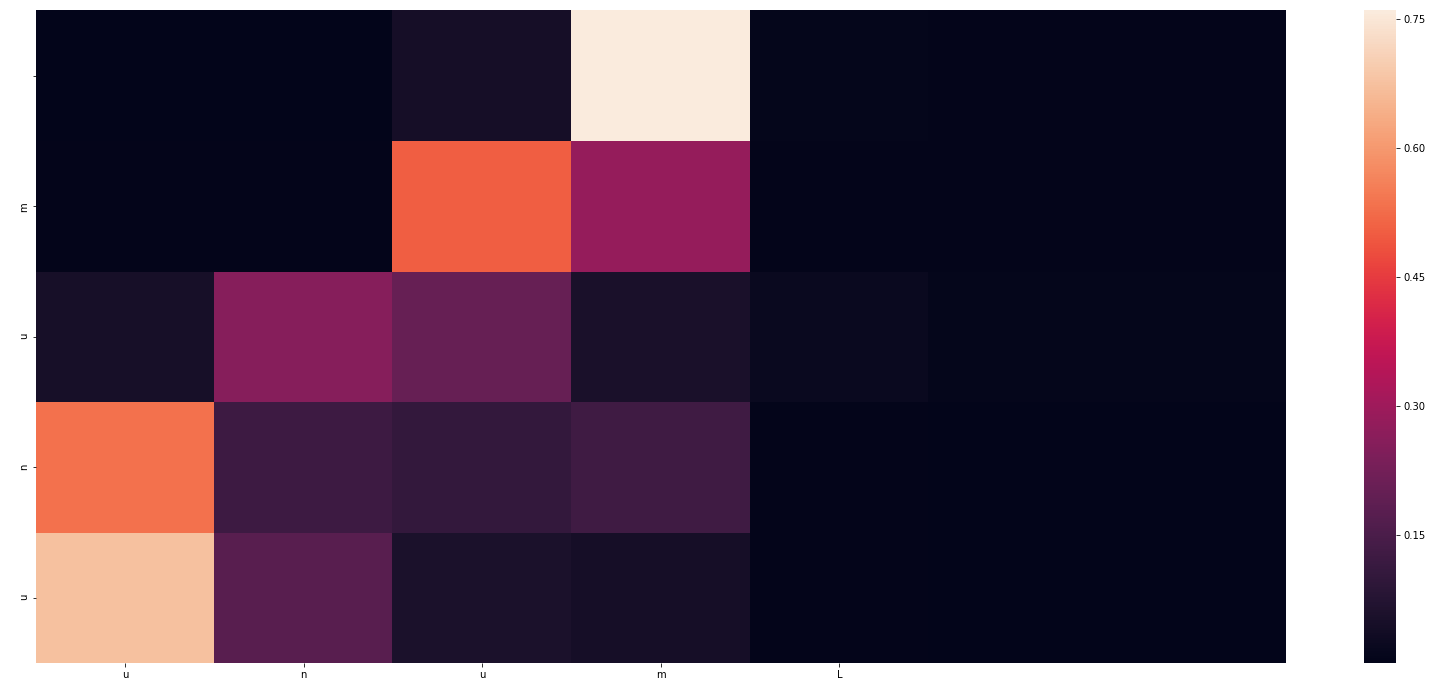

-
Input sentence: unumL
GT sentence: unum

Decoded sentence: unum



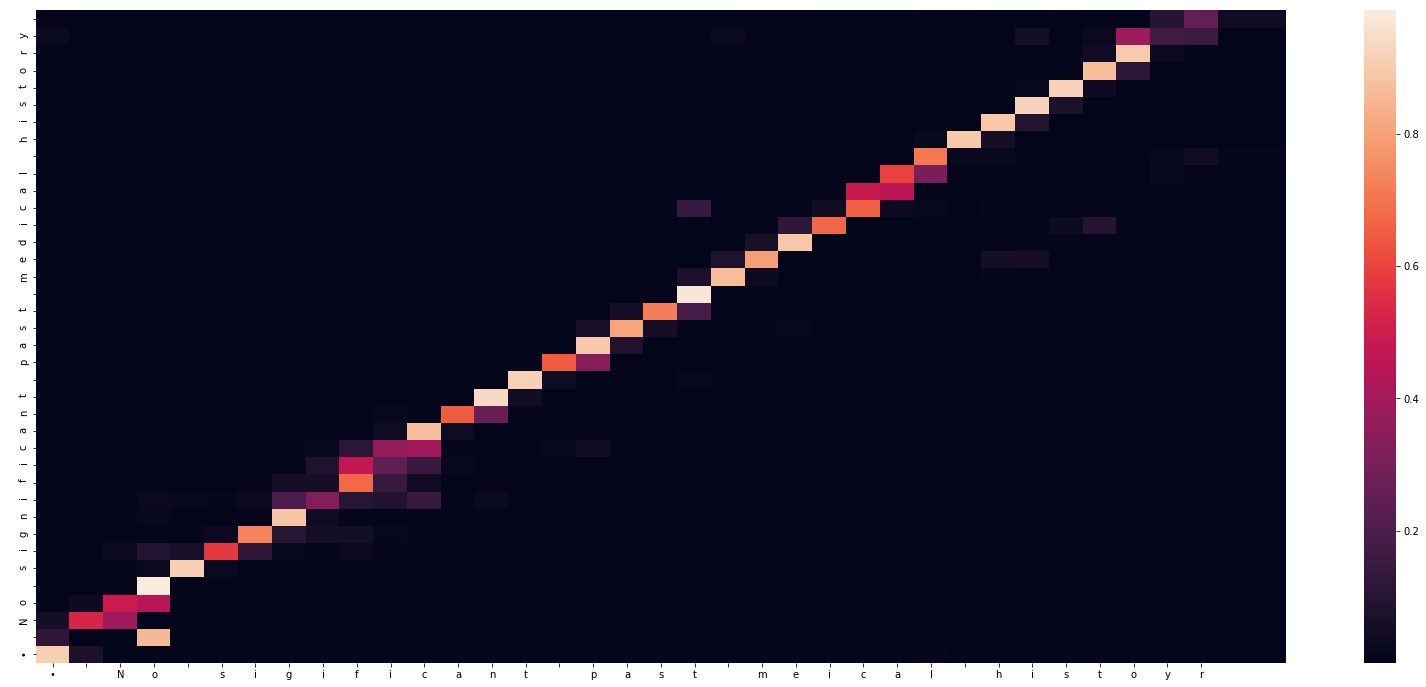

-
Input sentence: • No sigificant past meical histoyr
GT sentence: • No significant past medical history

Decoded sentence: • No significant past medical history



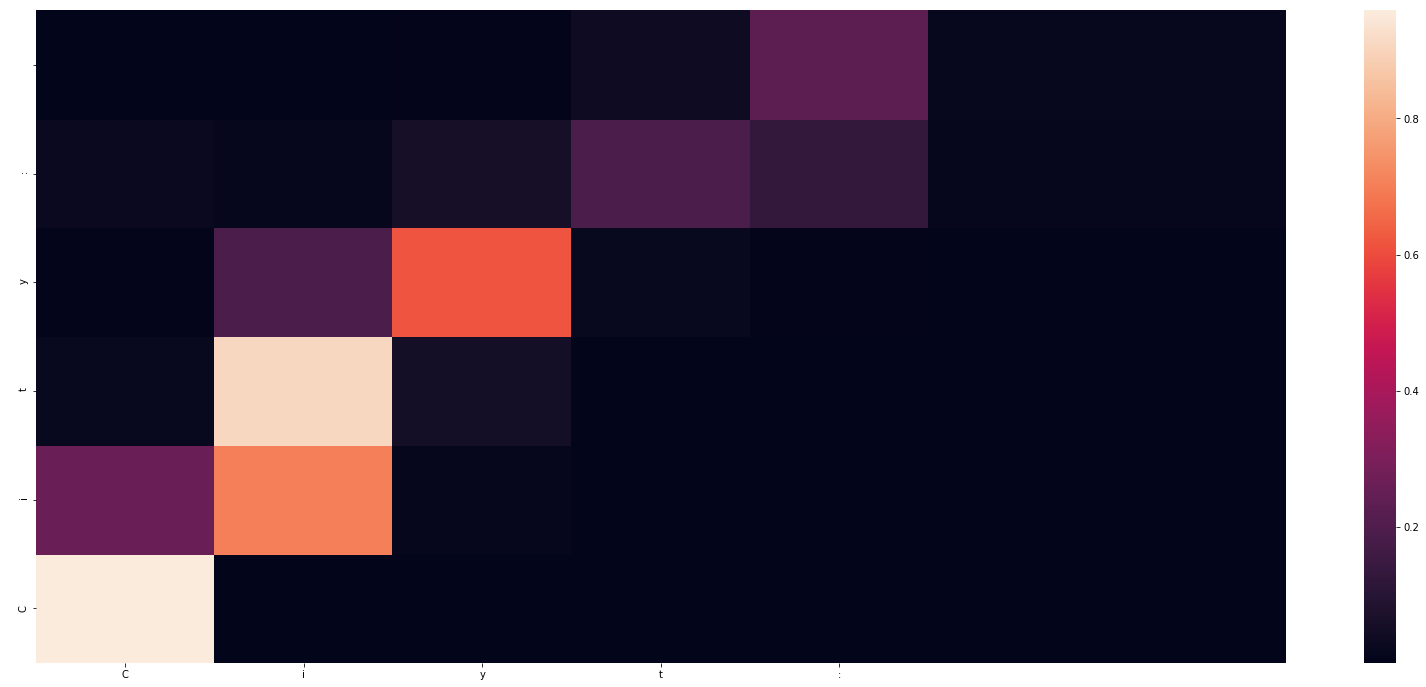

-
Input sentence: Ciyt:
GT sentence: City:

Decoded sentence: City:



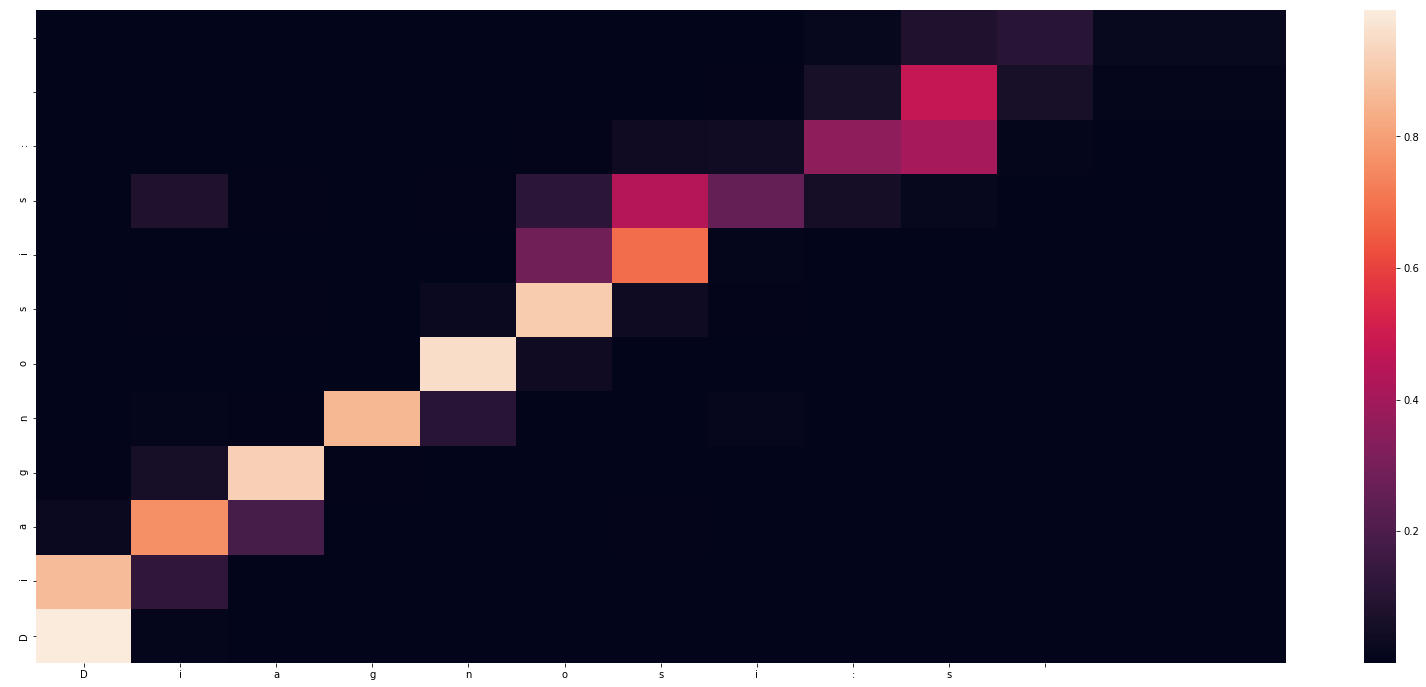

-
Input sentence: Diagnosi:s 
GT sentence: Diagnosis: 

Decoded sentence: Diagnosis: 



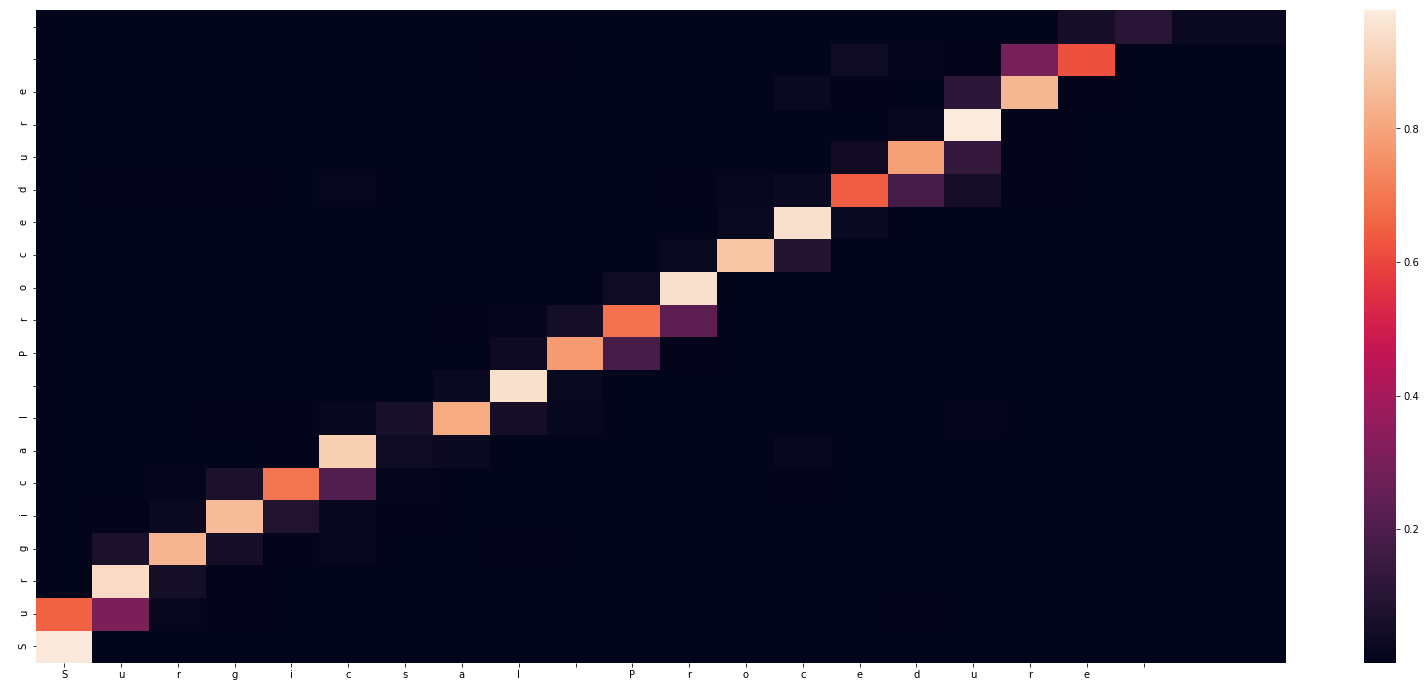

-
Input sentence: Surgicsal Procedure 
GT sentence: Surgical Procedure 

Decoded sentence: Surgical Procedure 



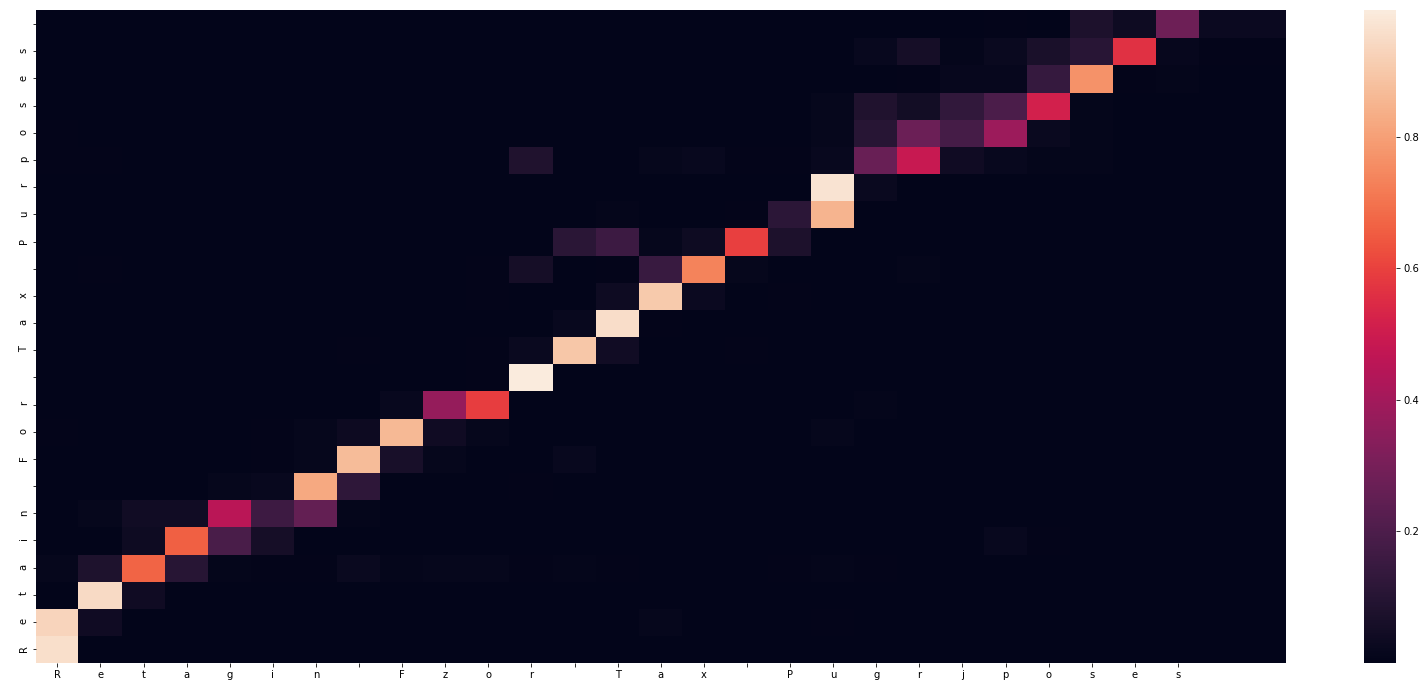

-
Input sentence: Retagin Fzor Tax Pugrjposes
GT sentence: Retain For Tax Purposes

Decoded sentence: Retain For Tax Purposes



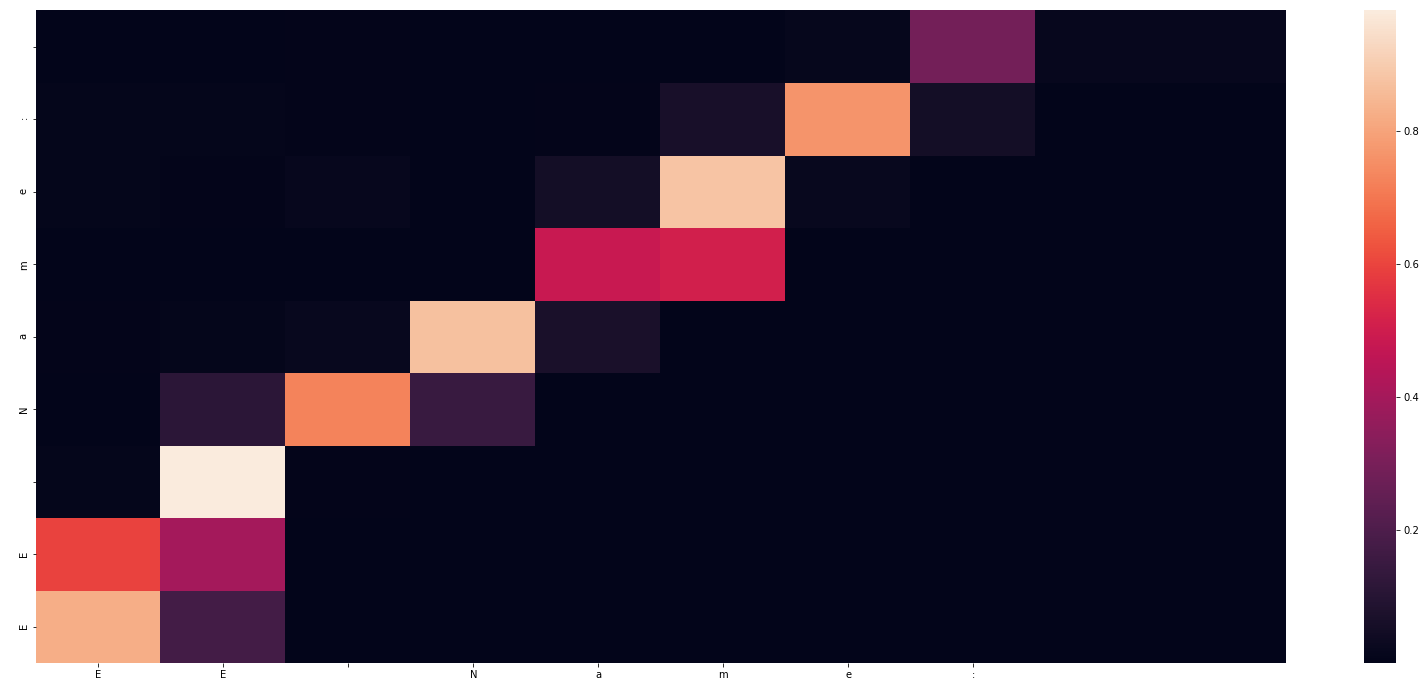

-
Input sentence: EE Name:
GT sentence: EE Name:

Decoded sentence: EE Name:



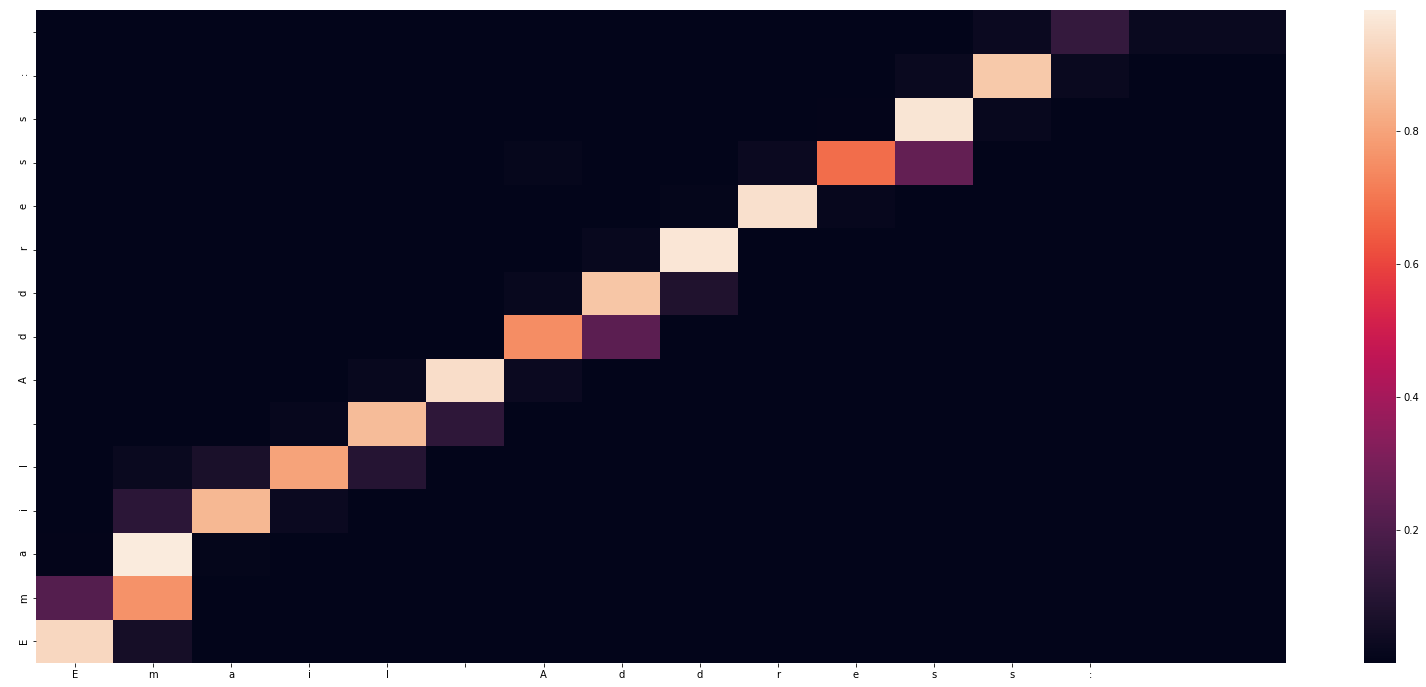

-
Input sentence: Email Address:
GT sentence: Email Address:

Decoded sentence: Email Address:



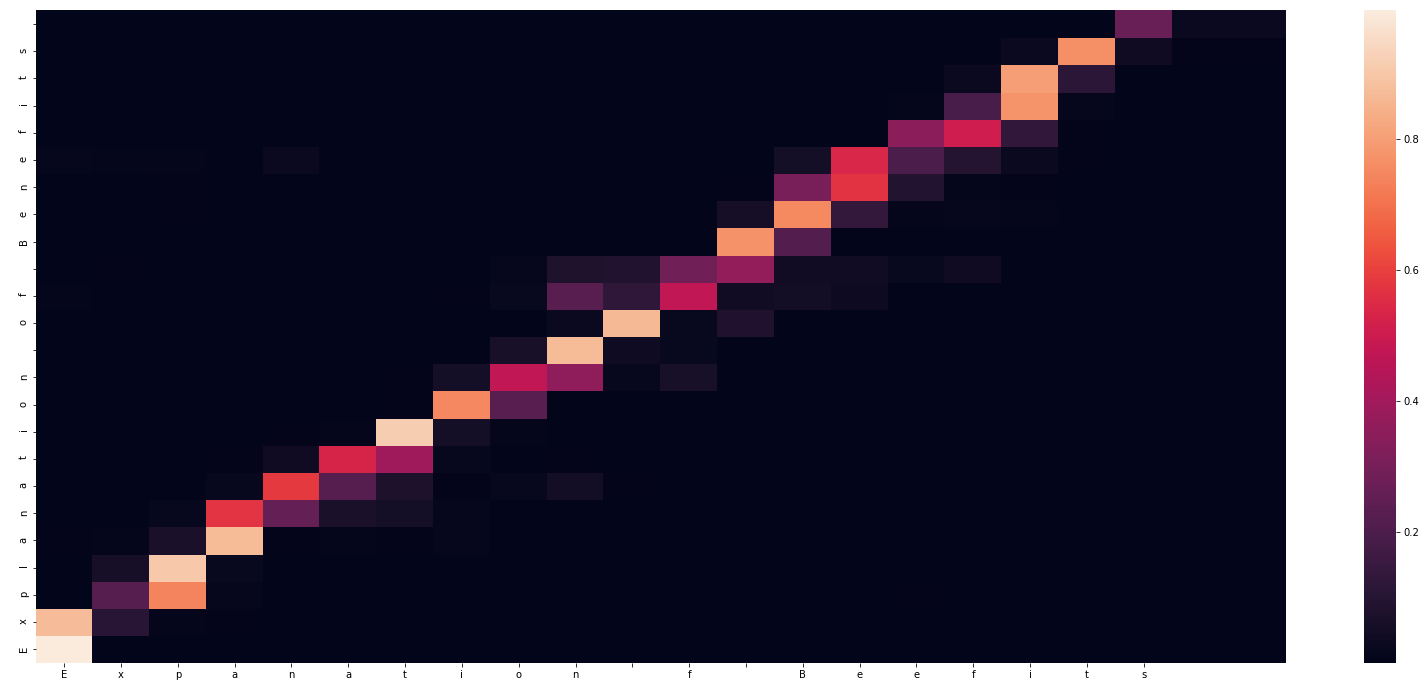

-
Input sentence: Expanation f Beefits
GT sentence: Explanation of Benefits 

Decoded sentence: Explanation of Benefits



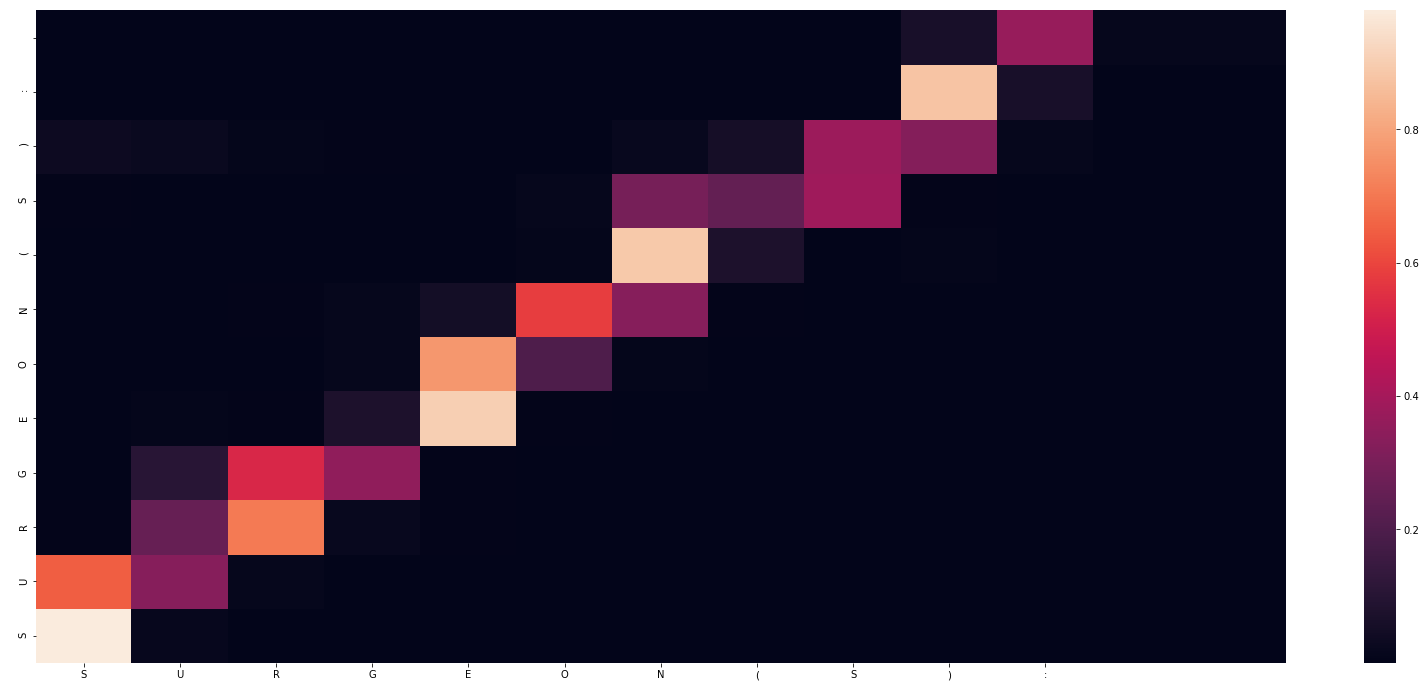

-
Input sentence: SURGEON(S):
GT sentence: SURGEON(S):

Decoded sentence: SURGEON(S):



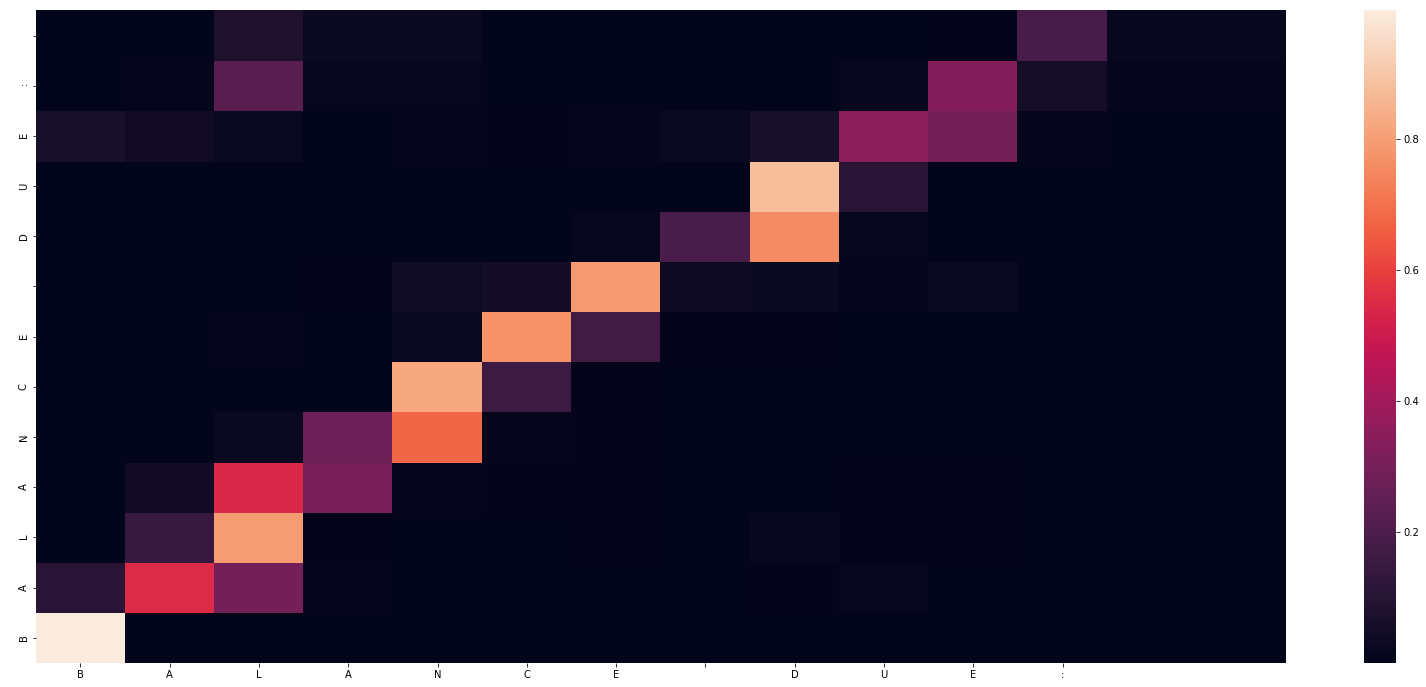

-
Input sentence: BALANCE DUE:
GT sentence: BALANCE DUE:

Decoded sentence: BALANCE DUE:



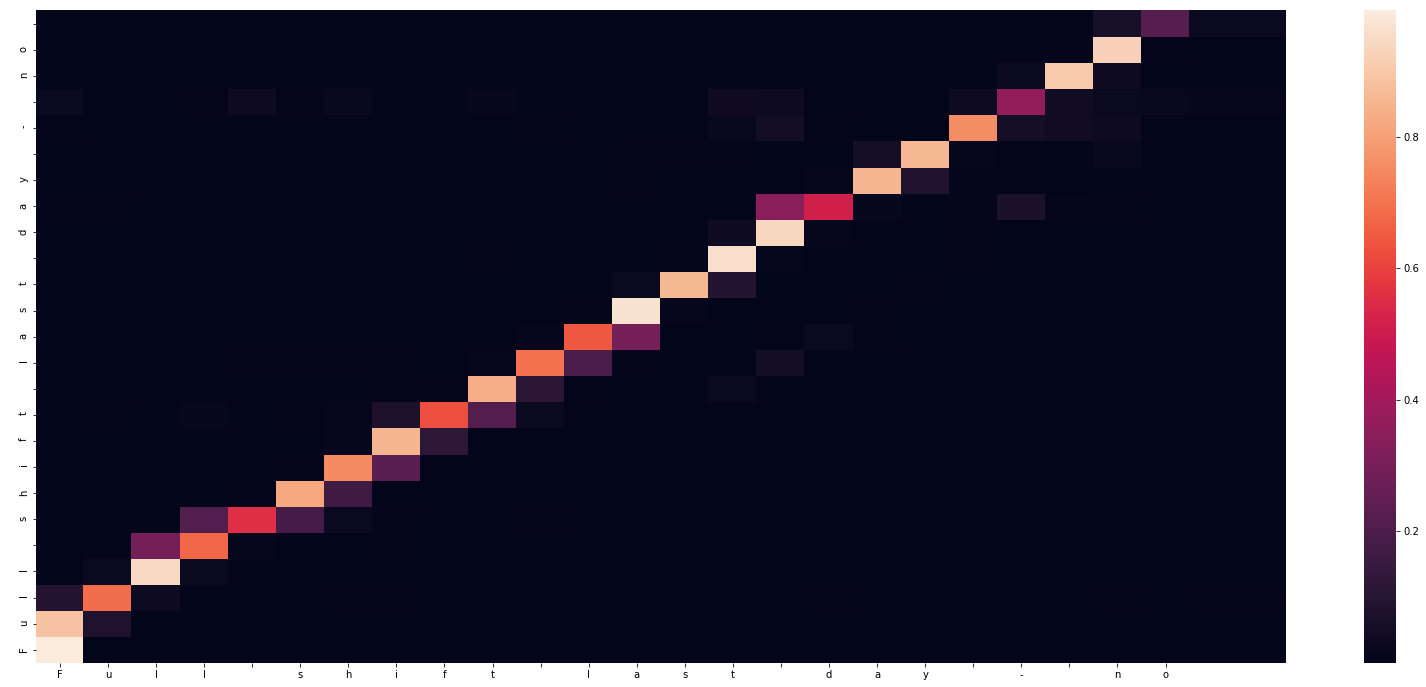

-
Input sentence: Full shift last day - no
GT sentence: Full shift last day - no

Decoded sentence: Full shift last day - no



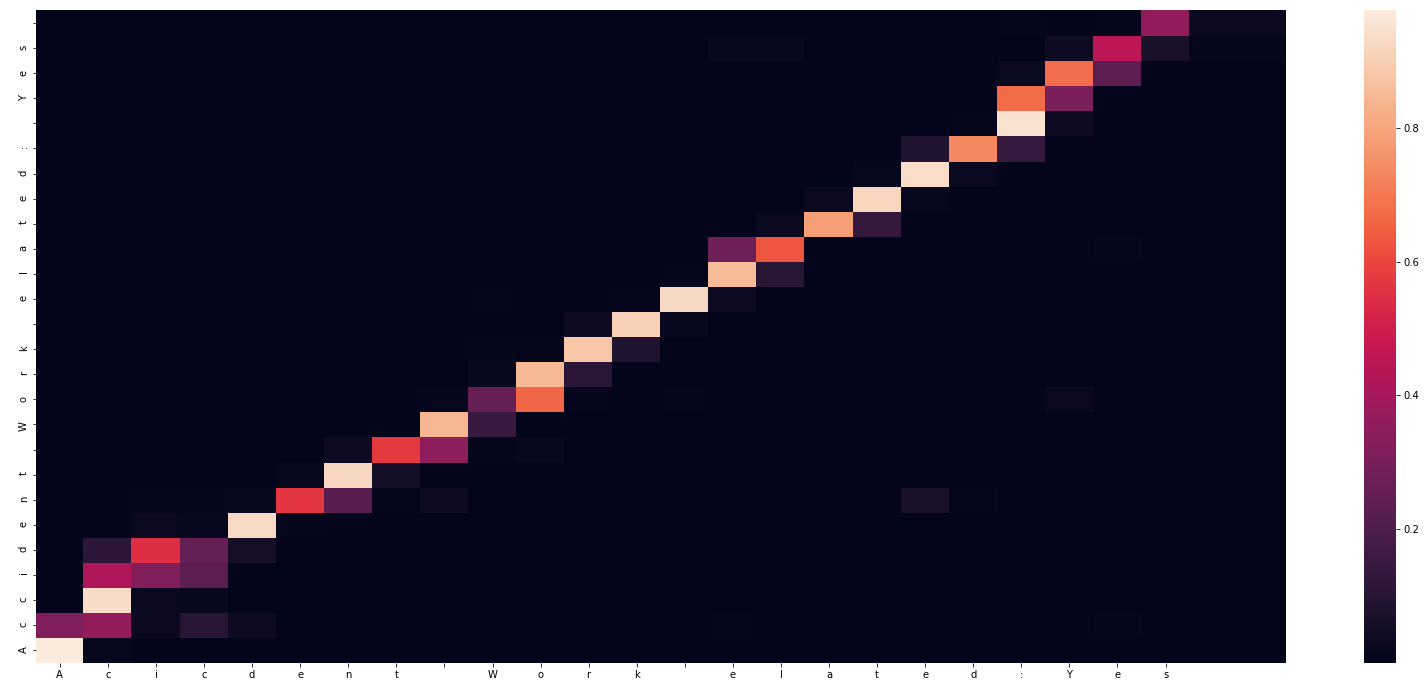

-
Input sentence: Acicdent Work elated:Yes
GT sentence: Accident Work Related: Yes

Decoded sentence: Accident Work elated: Yes



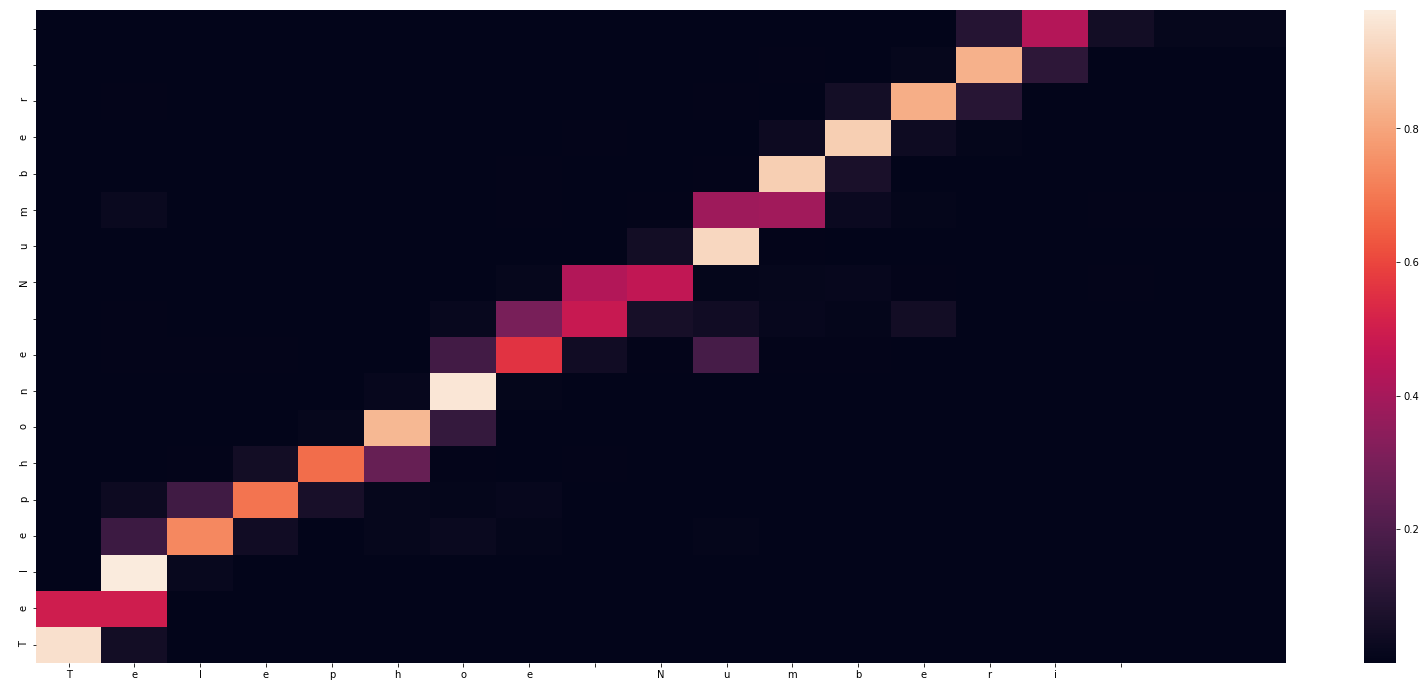

-
Input sentence: Telephoe Numberi 
GT sentence: Telephone Number 

Decoded sentence: Telephone Number 



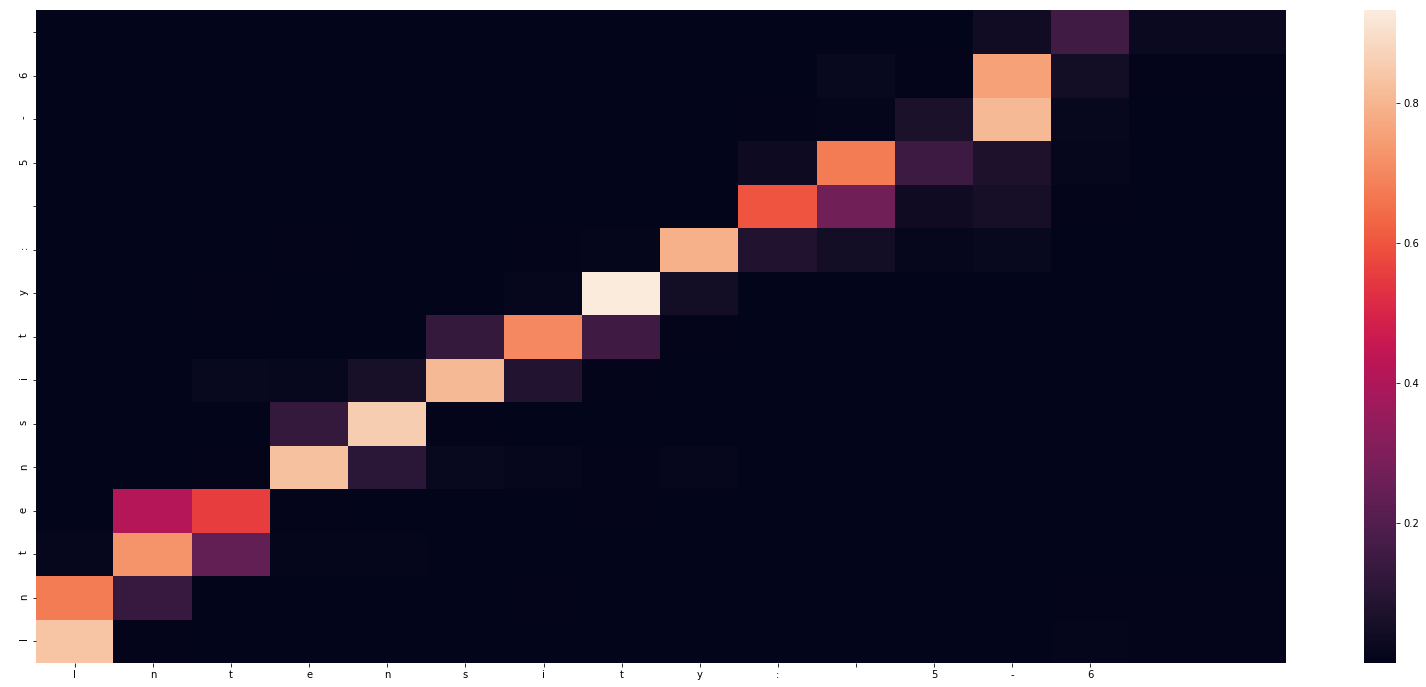

-
Input sentence: Intensity: 5-6
GT sentence: Intensity: 5-6

Decoded sentence: Intensity: 5-6



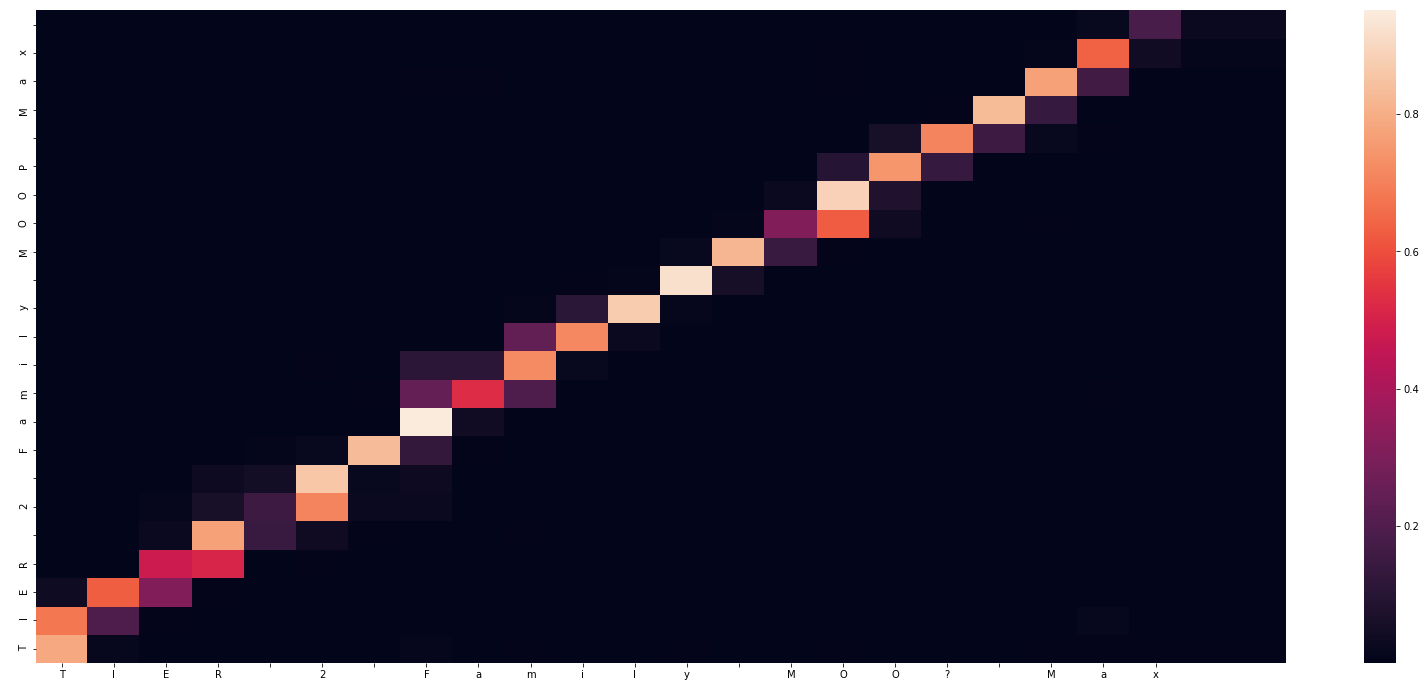

-
Input sentence: TIER 2 Family MOO? Max
GT sentence: TIER 2 Family MOOP Max

Decoded sentence: TIER 2 Family MOOP Max



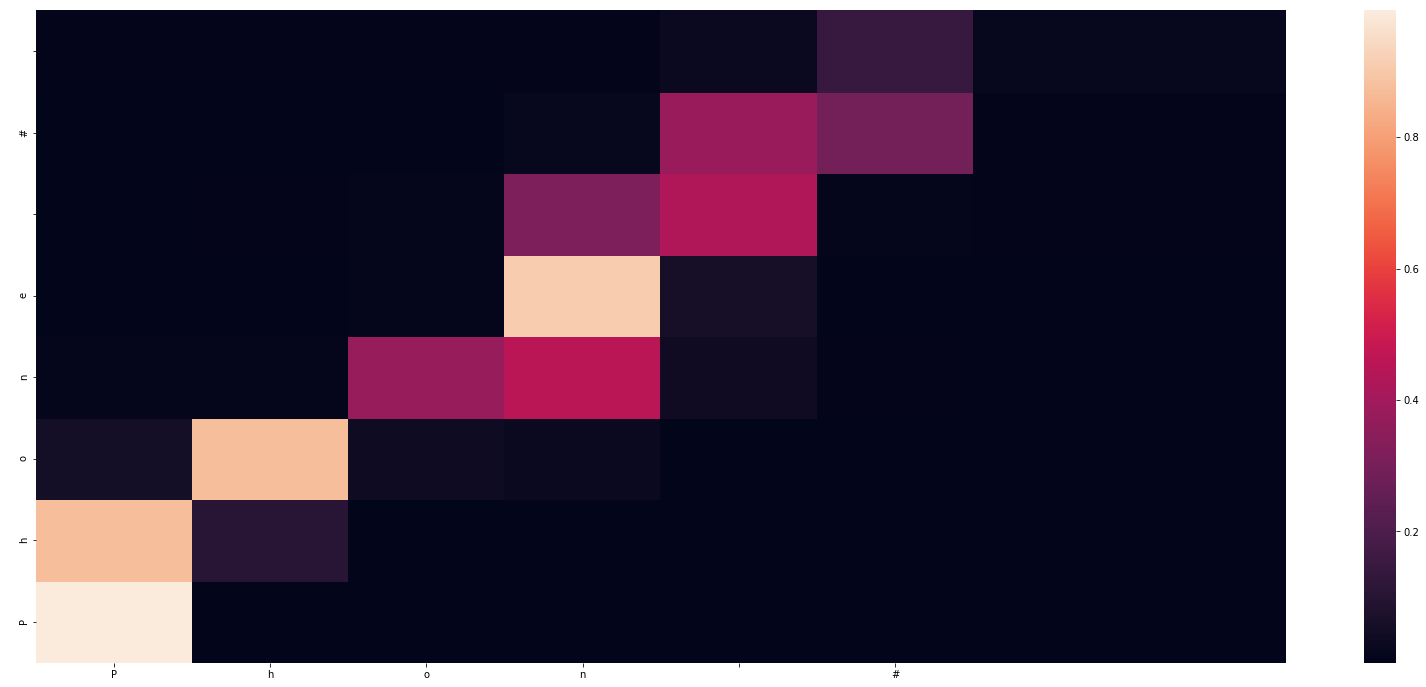

-
Input sentence: Phon #
GT sentence: Phone #

Decoded sentence: Phone #



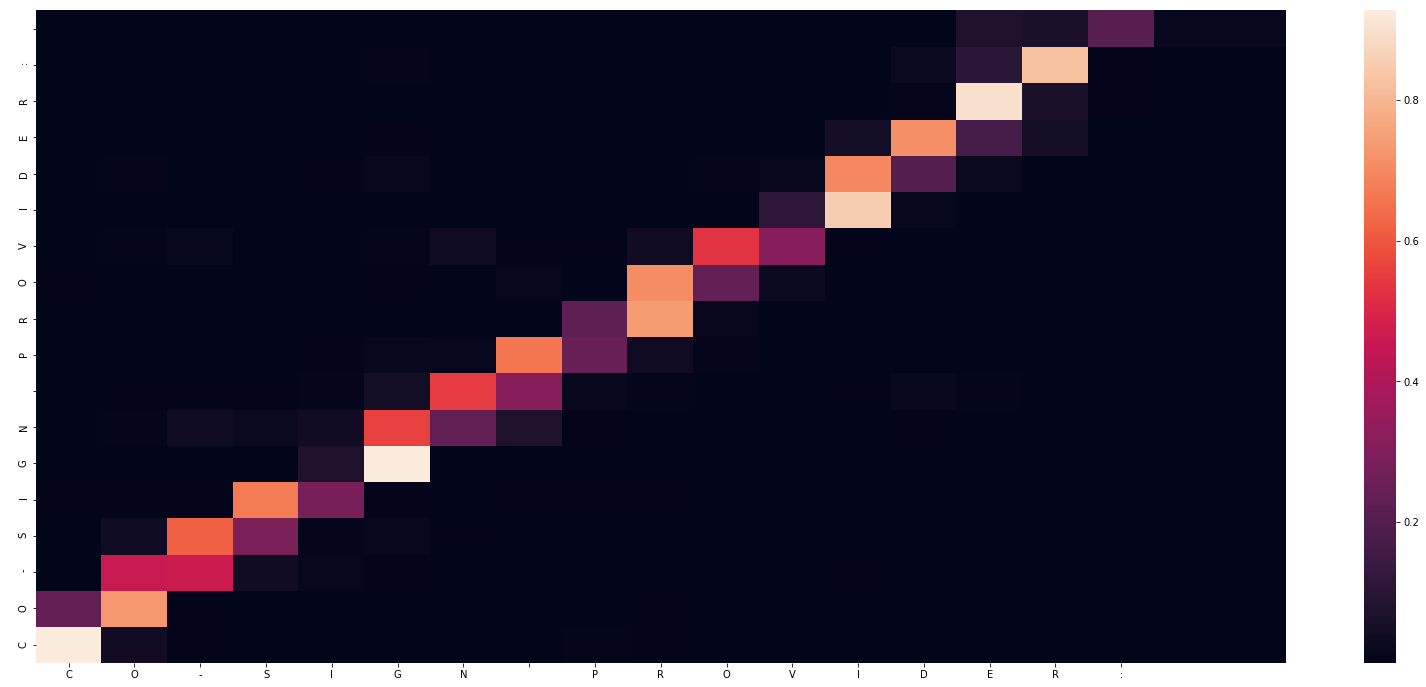

-
Input sentence: CO-SIGN PROVIDER:
GT sentence: CO-SIGN PROVIDER:

Decoded sentence: CO-SIGN PROVIDER:



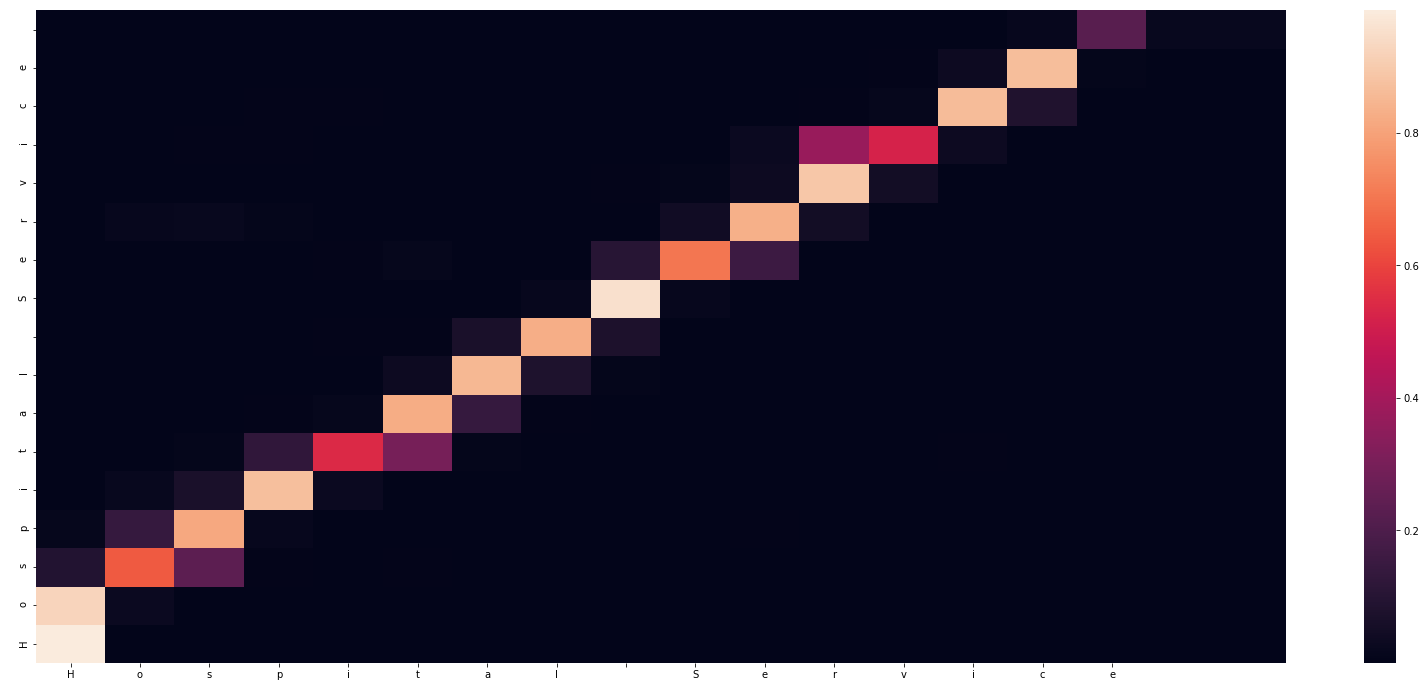

-
Input sentence: Hospital Service
GT sentence: Hospital Service Surgery

Decoded sentence: Hospital Service



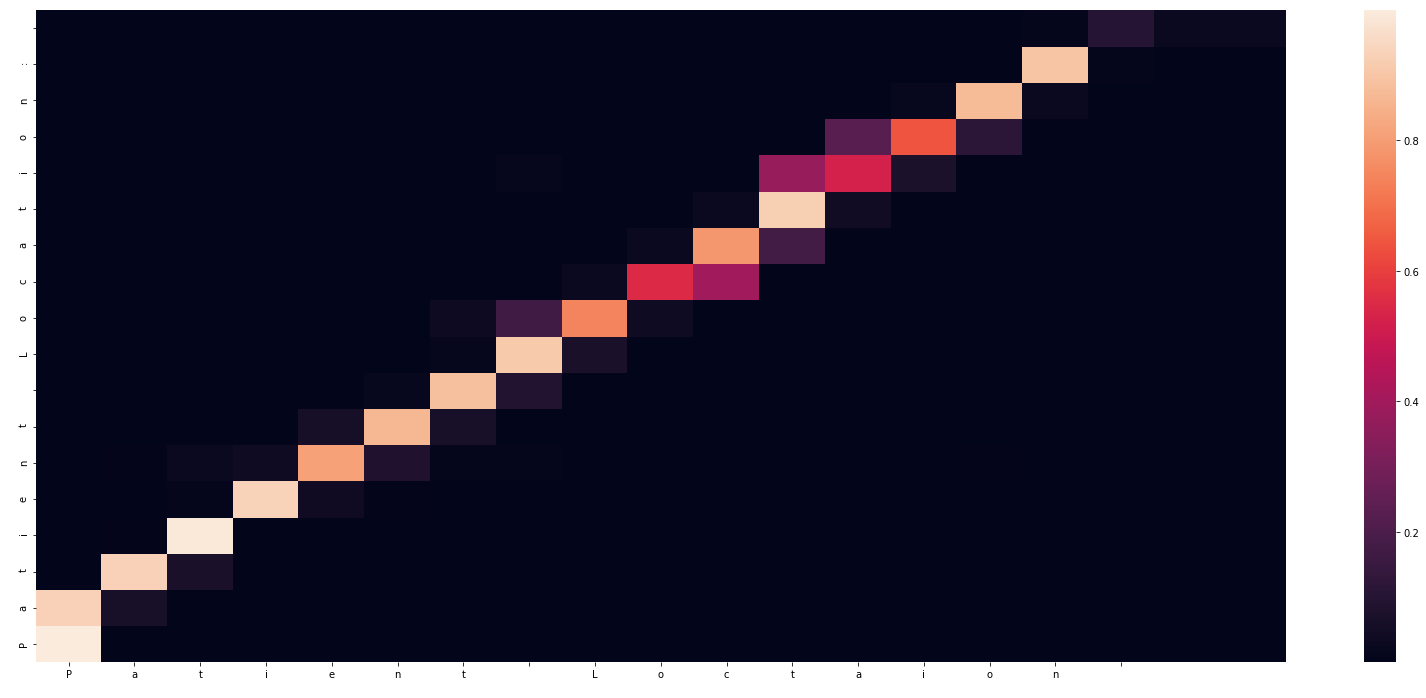

-
Input sentence: Patient Loctaion

GT sentence: Patient Location:

Decoded sentence: Patient Location:



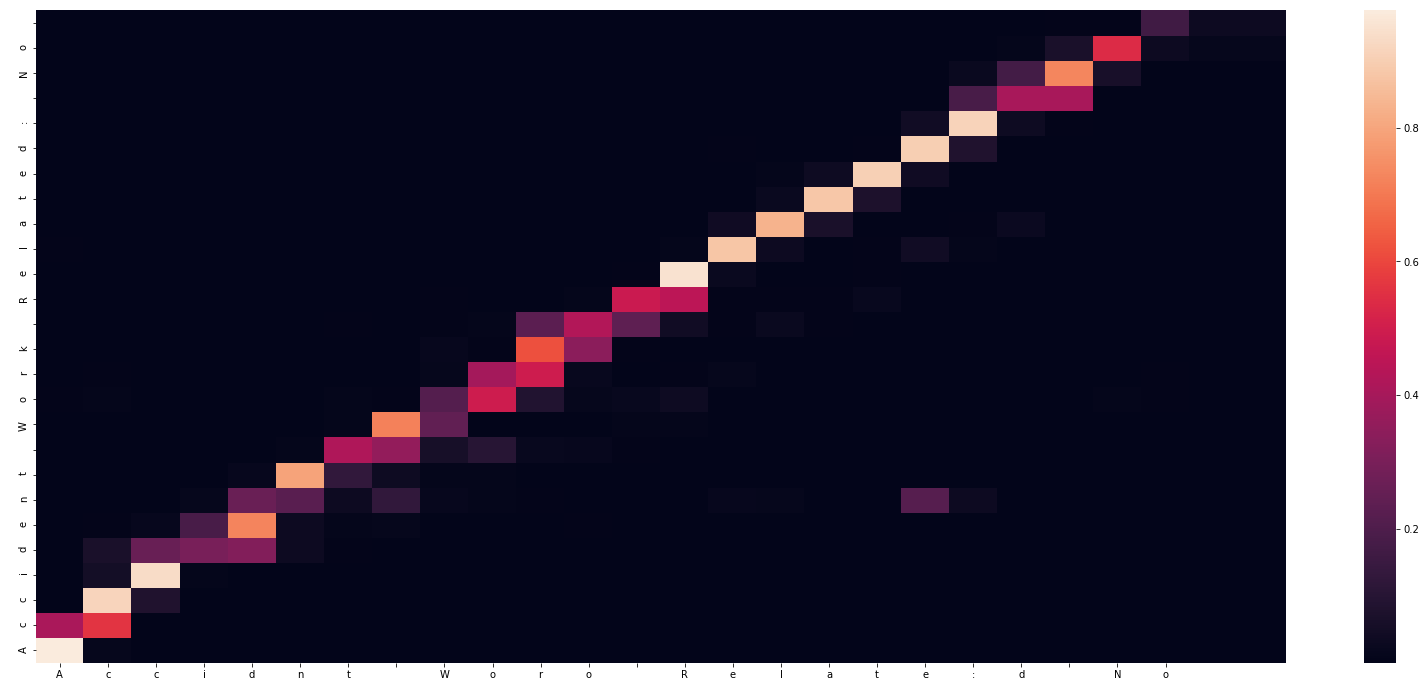

-
Input sentence: Accidnt Woro Relate:d No
GT sentence: Accident Work Related: No

Decoded sentence: Accident Work Related: No



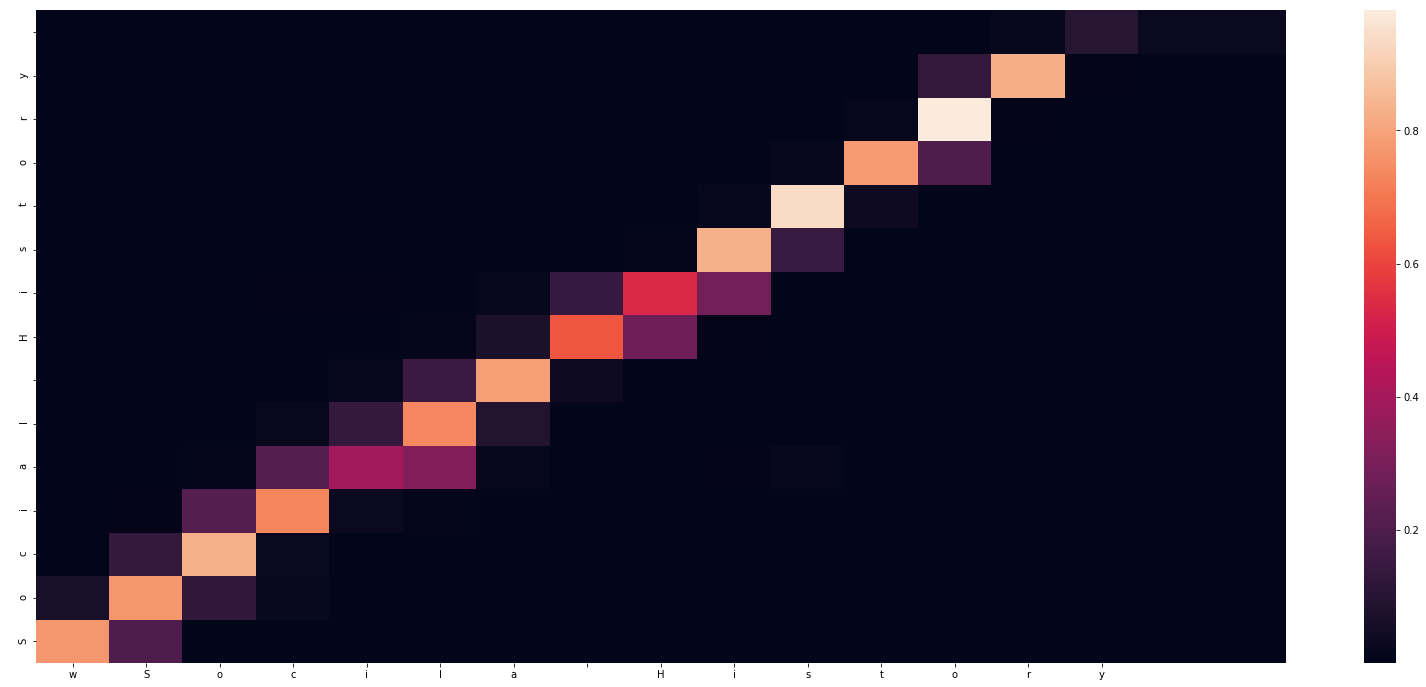

-
Input sentence: wSocila History
GT sentence: Social History

Decoded sentence: Social History



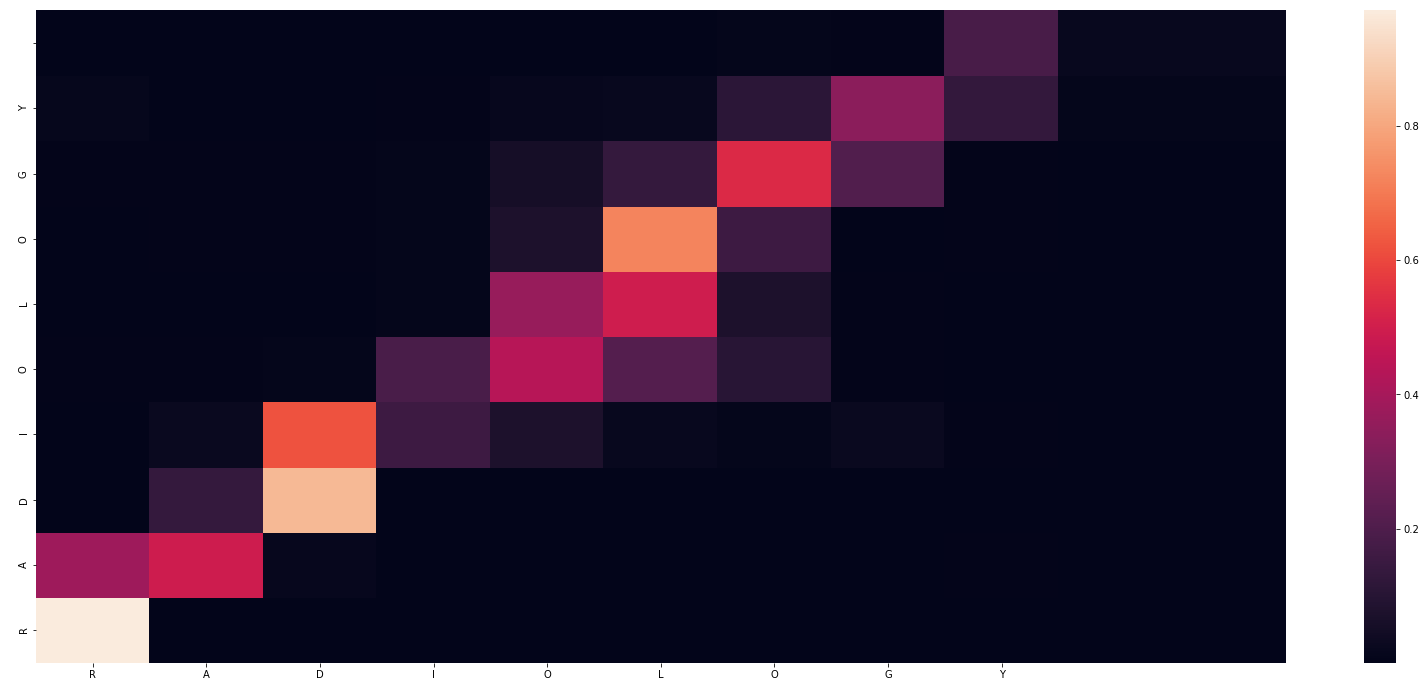

-
Input sentence: RADIOLOGY
GT sentence: RADIOLOGY

Decoded sentence: RADIOLOGY



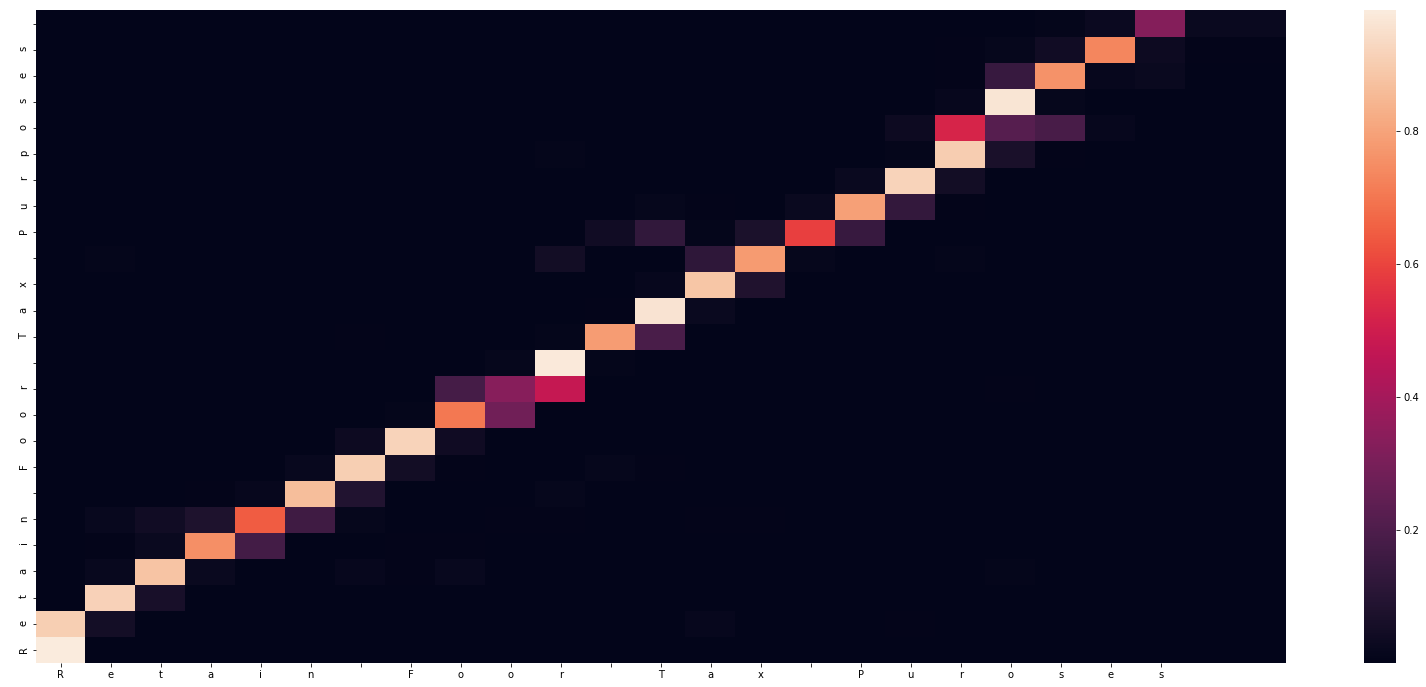

-
Input sentence: Retain Foor Tax Puroses
GT sentence: Retain For Tax Purposes

Decoded sentence: Retain Foor Tax Purposes



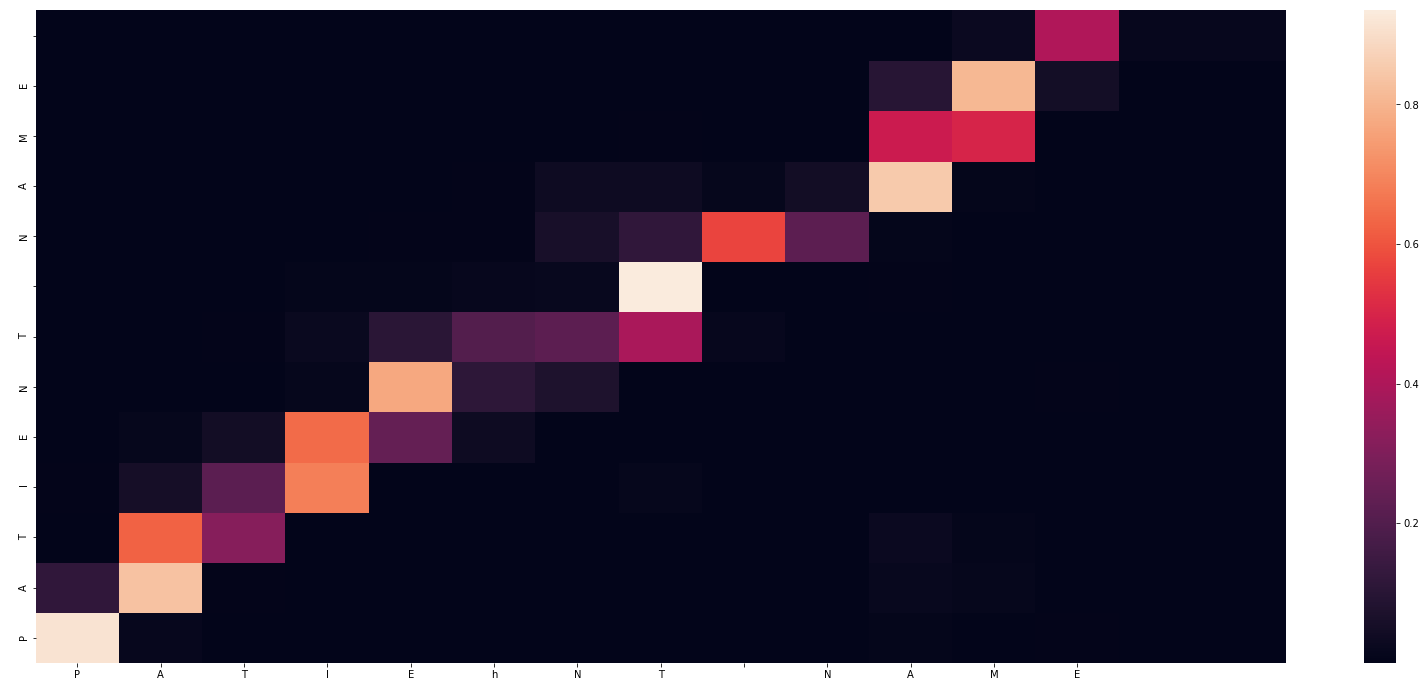

-
Input sentence: PATIEhNT NAME
GT sentence: PATIENT NAME

Decoded sentence: PATIENT NAME



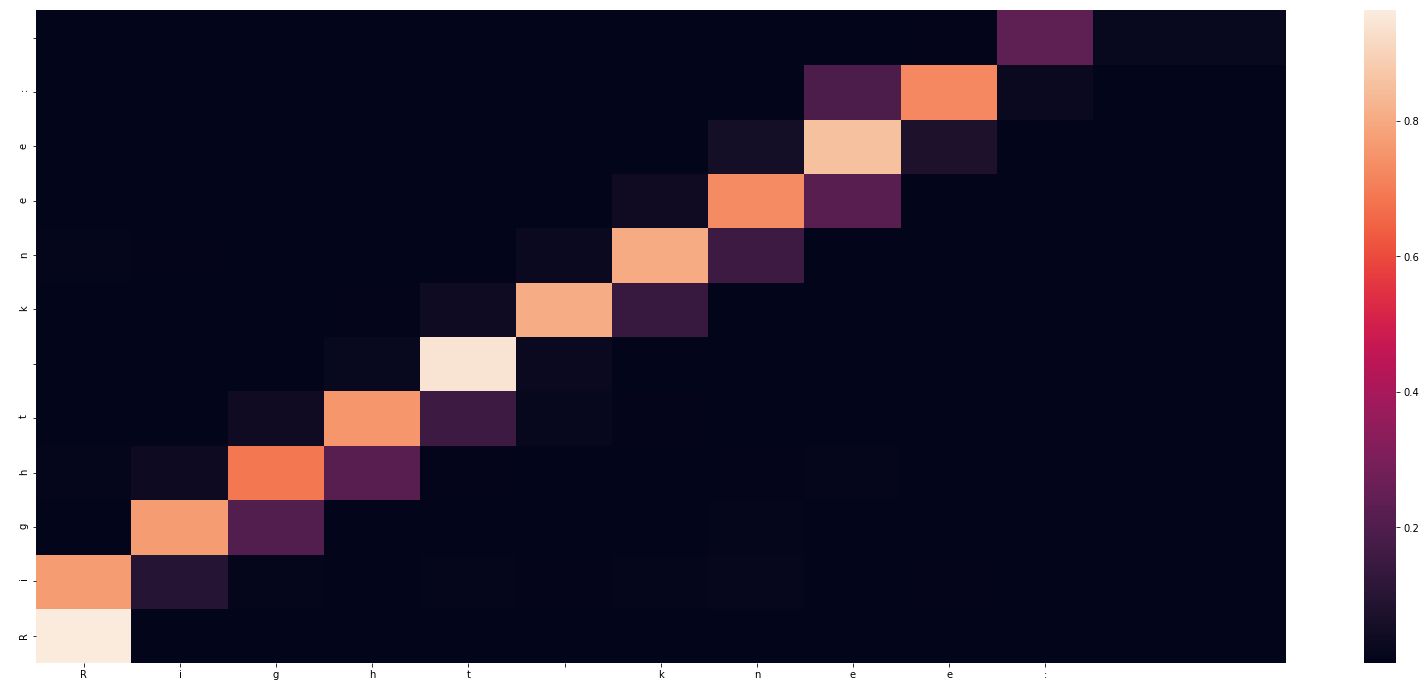

-
Input sentence: Right knee:
GT sentence: Right knee:

Decoded sentence: Right knee:



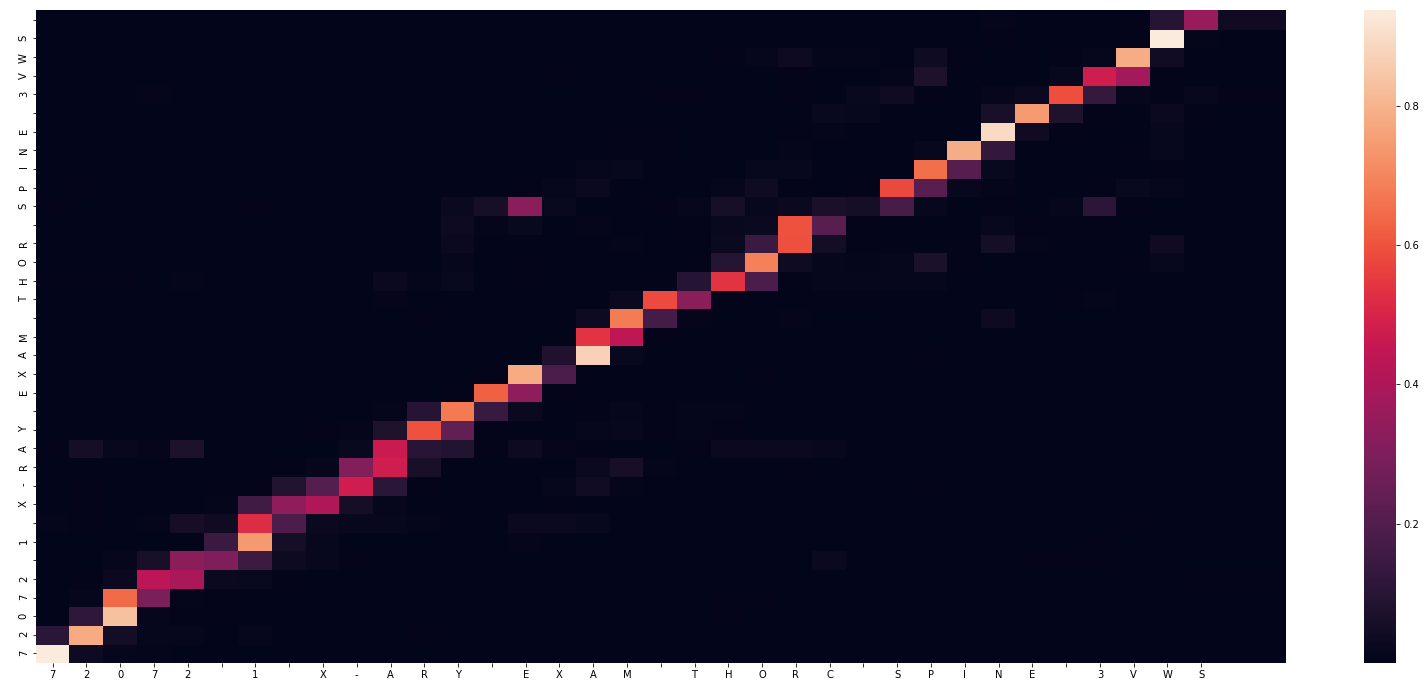

-
Input sentence: 72072 1 X-ARY EXAM THORC SPINE 3VWS
GT sentence: 72072 1 X-RAY EXAM THORAC SPINE 3VWS

Decoded sentence: 72072 1 X-RAY EXAM THOR SPINE 3VWS



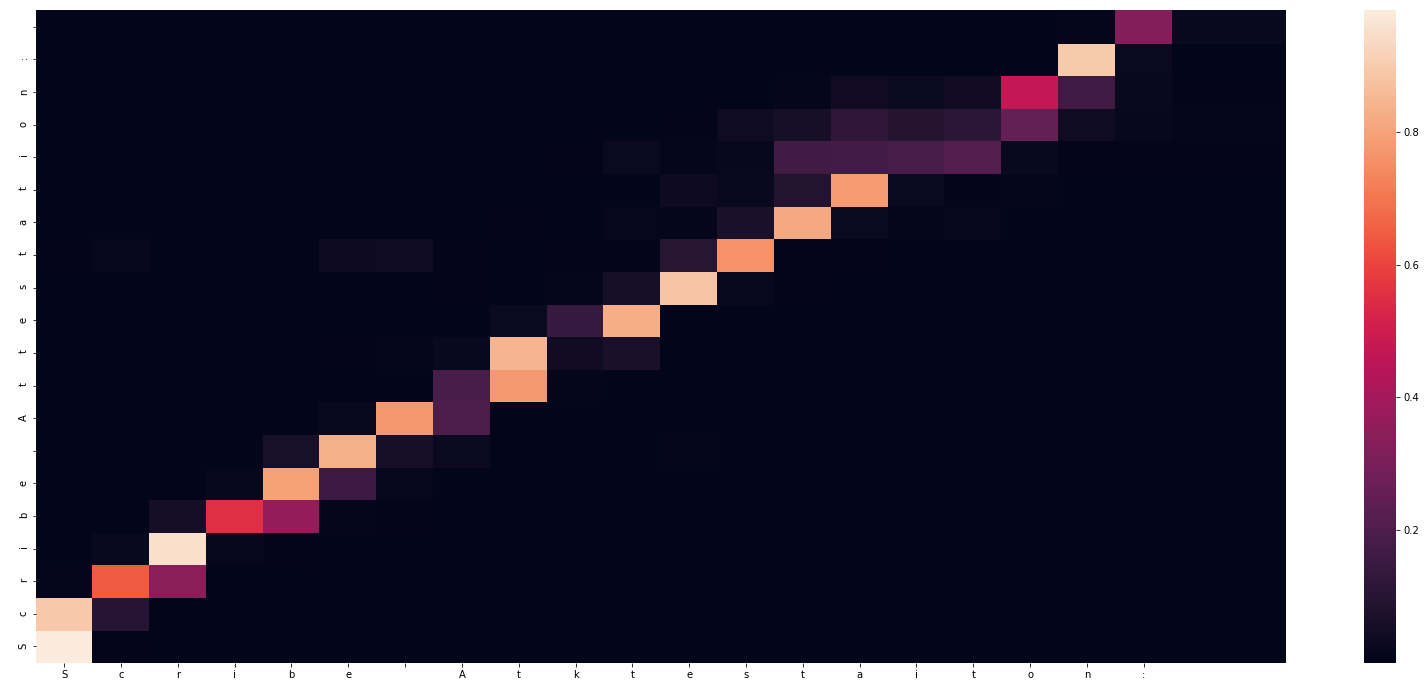

-
Input sentence: Scribe Atktestaiton:
GT sentence: Scribe Attestation:

Decoded sentence: Scribe Attestation:



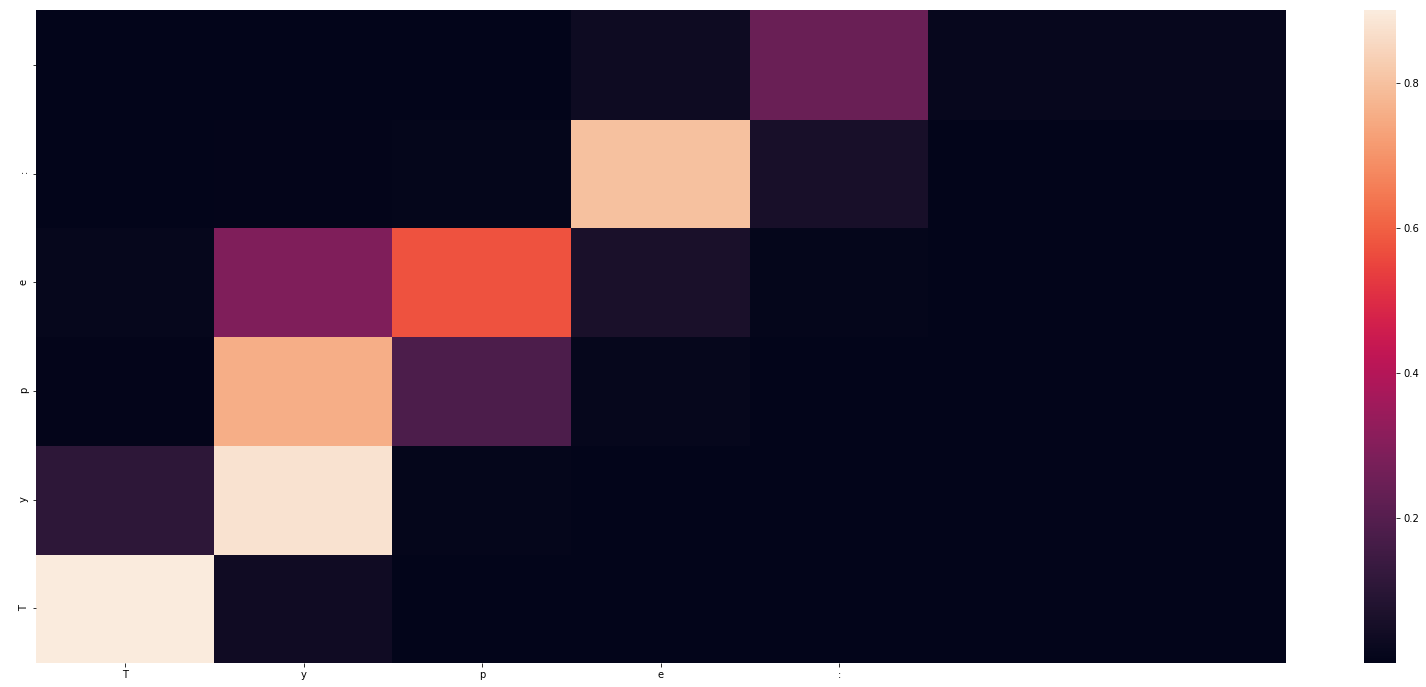

-
Input sentence: Type:
GT sentence: Type:

Decoded sentence: Type:



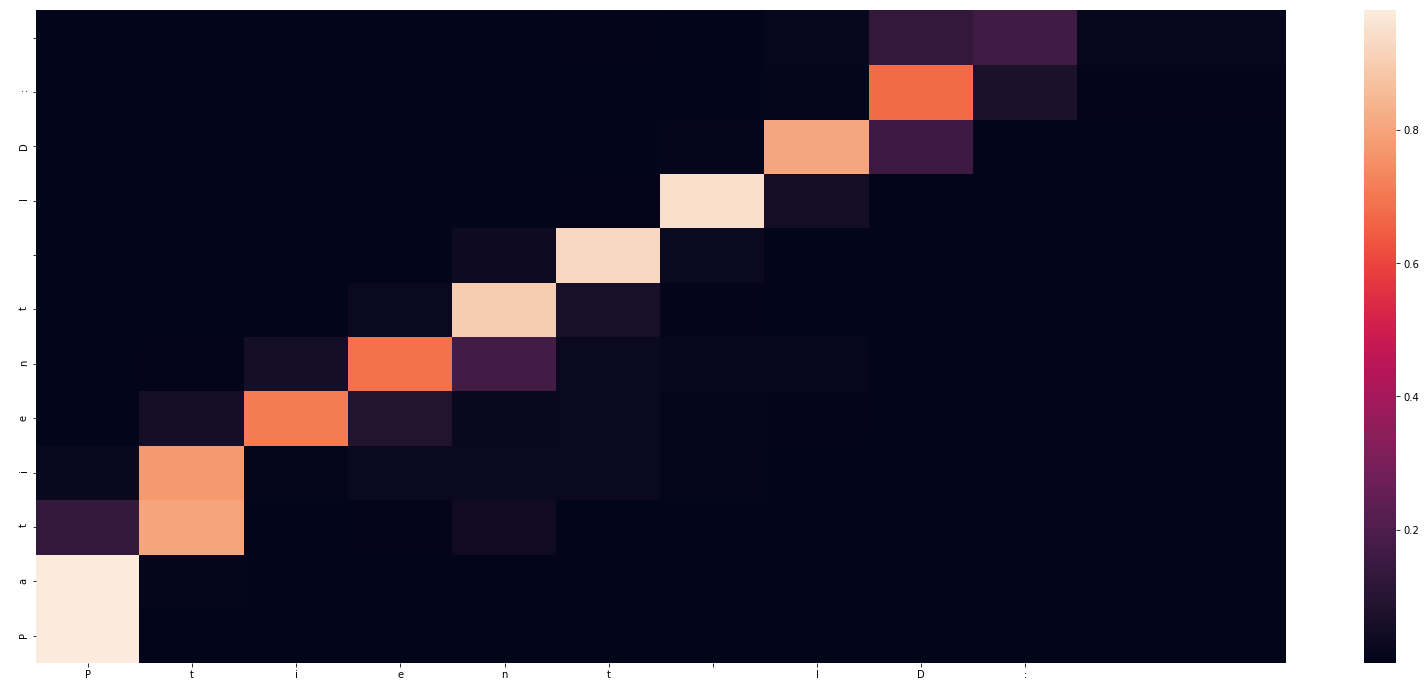

-
Input sentence: Ptient ID:
GT sentence: Patient ID:

Decoded sentence: Patient ID:



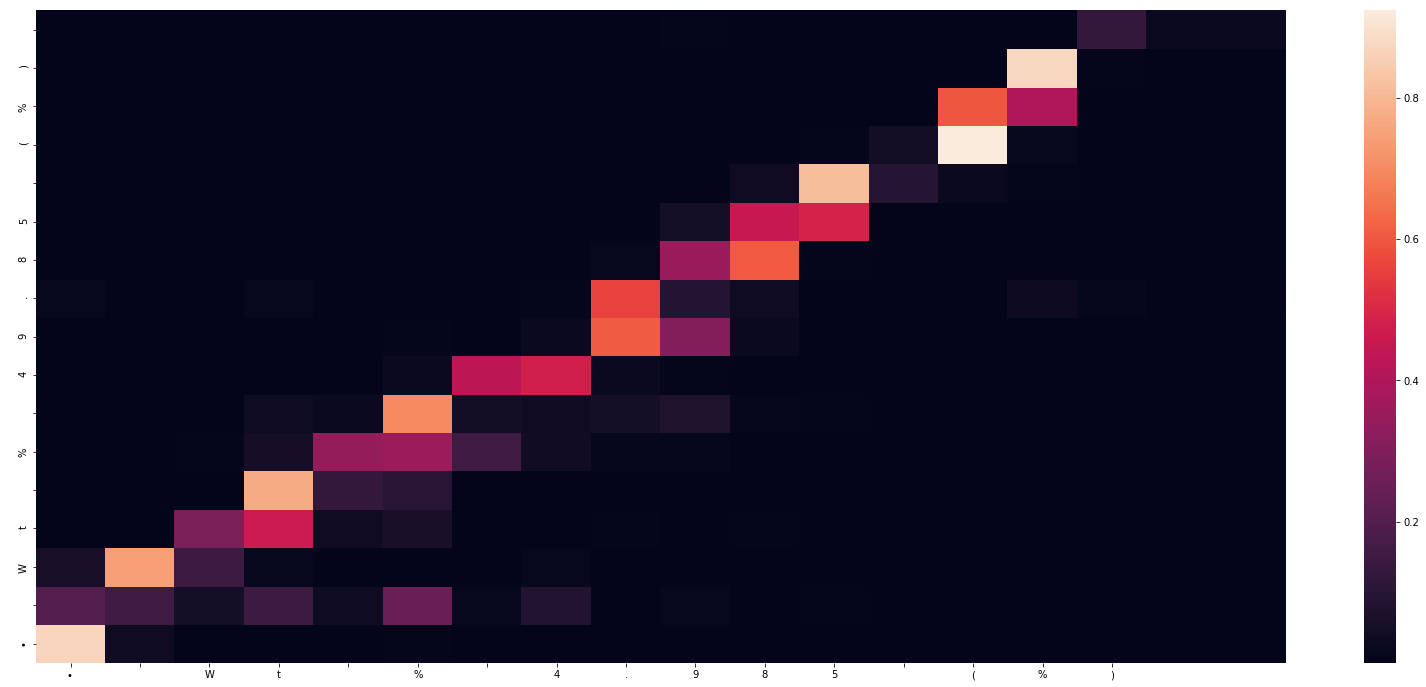

-
Input sentence: • Wt % 4.985 (%)
GT sentence: • Wt % 49.85 (%)

Decoded sentence: • Wt % 49.85 (%)



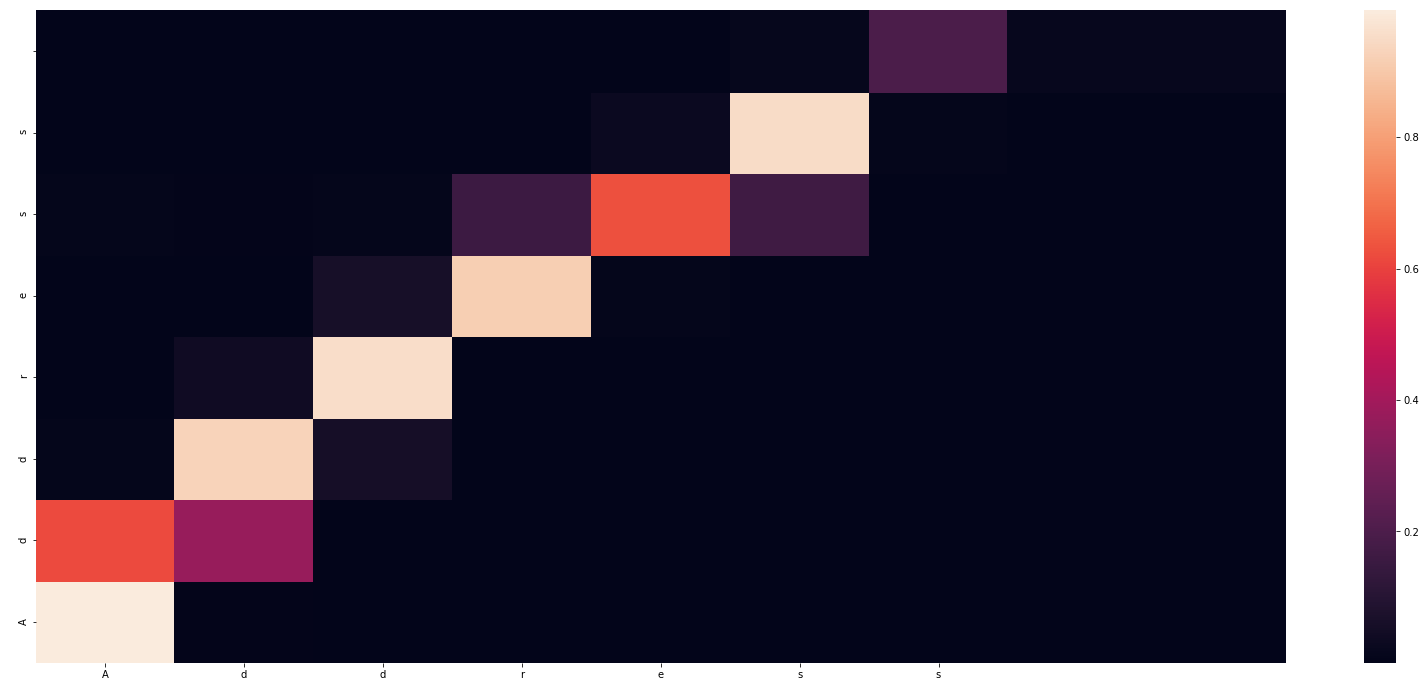

-
Input sentence: Address
GT sentence: Address

Decoded sentence: Address



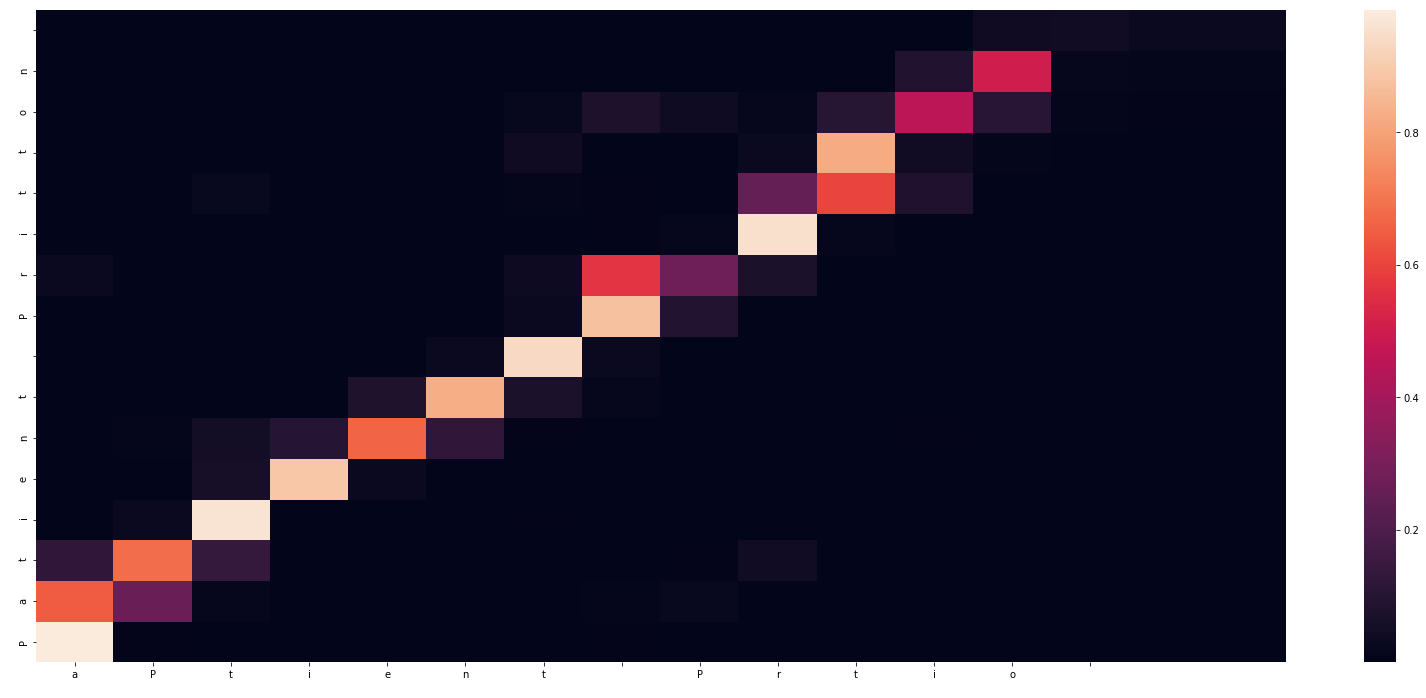

-
Input sentence: aPtient Prtio

GT sentence: Patient Portion

Decoded sentence: Patient Pritton



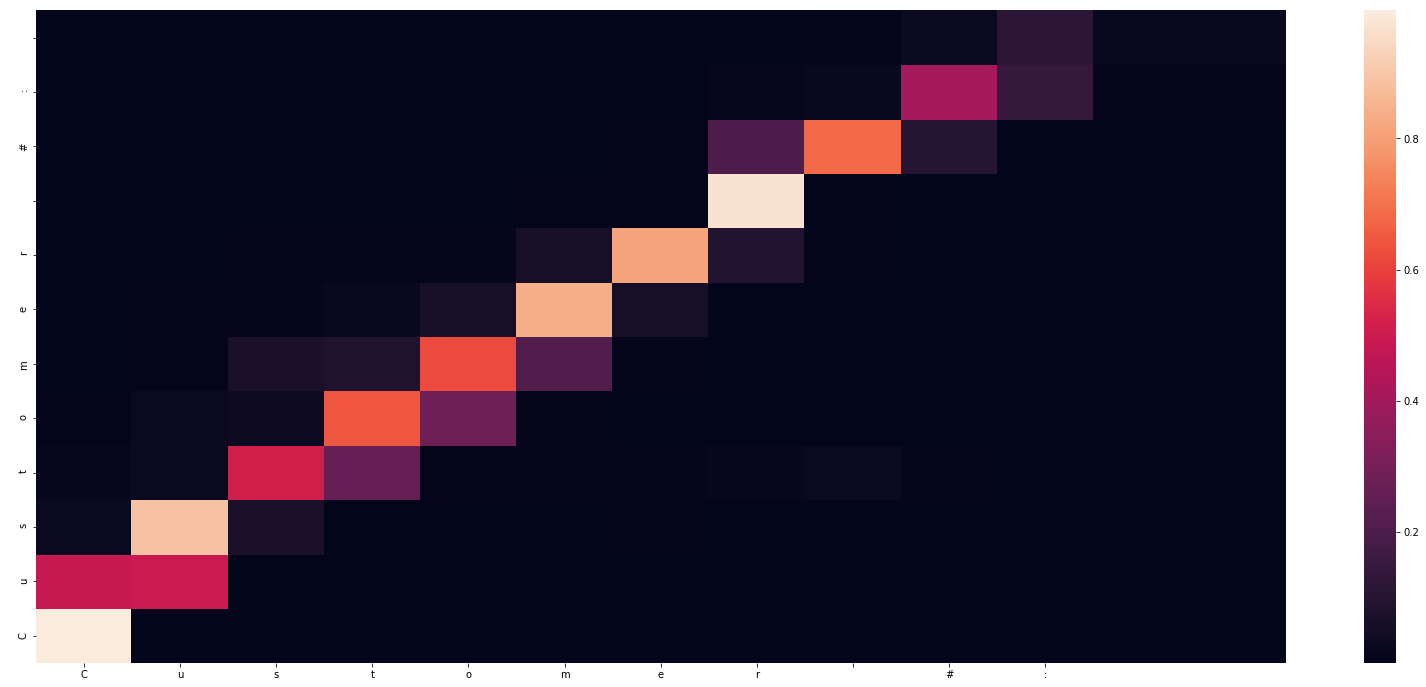

-
Input sentence: Customer #:
GT sentence: Customer #:

Decoded sentence: Customer #:



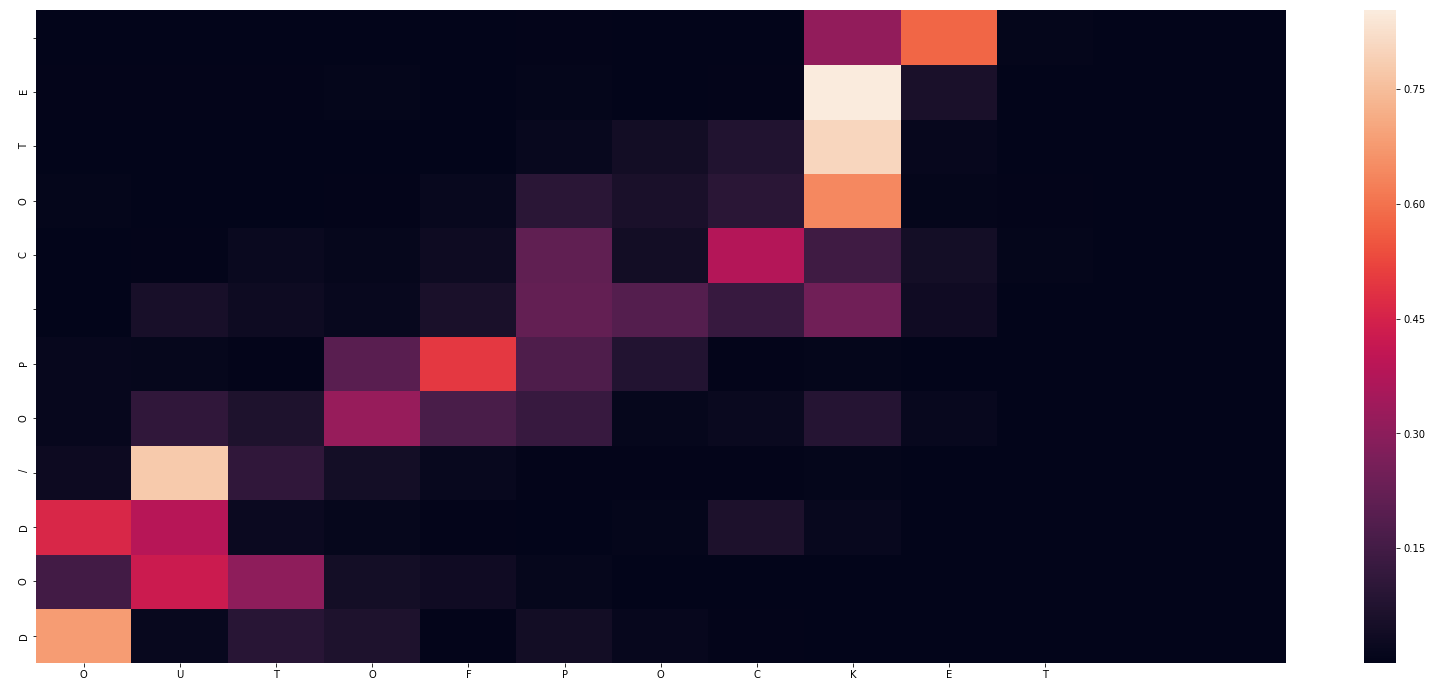

-
Input sentence: OUTOFPOCKET
GT sentence: DEDUCTIBLE OUT OF POCKET

Decoded sentence: DOD/OP COTE



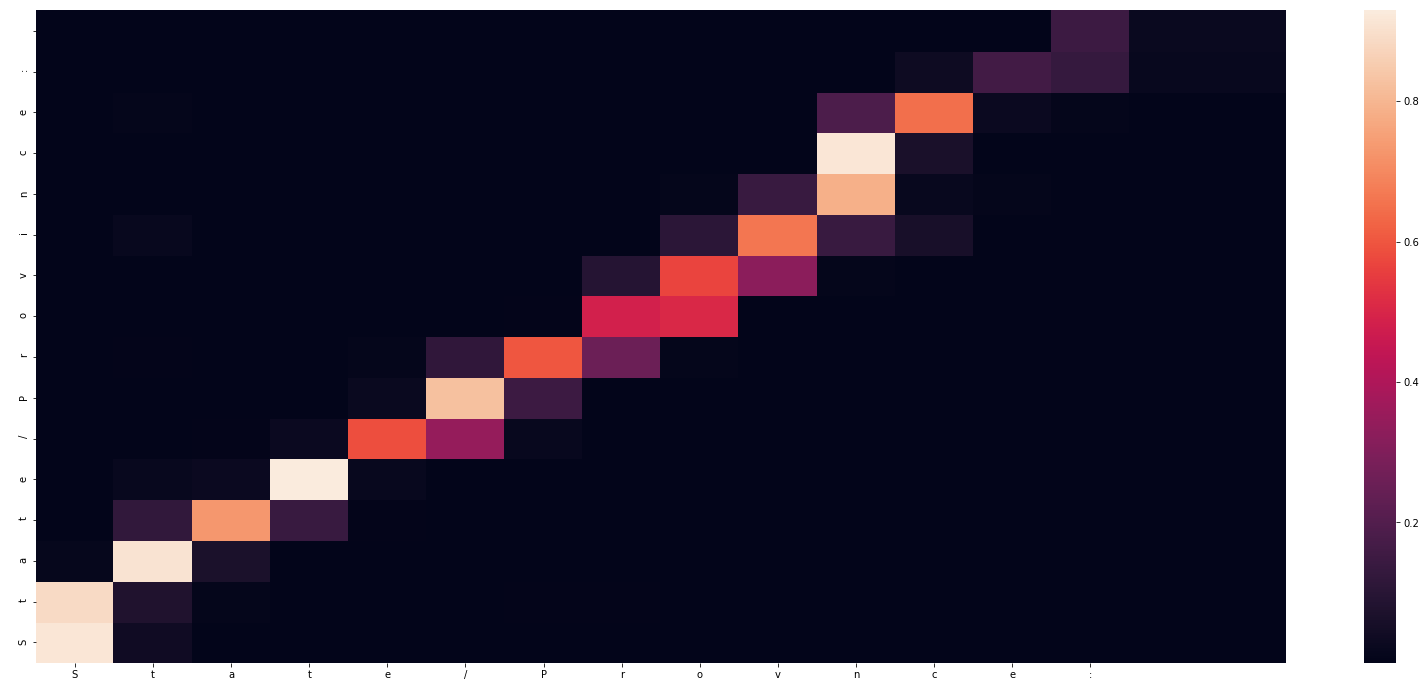

-
Input sentence: State/Provnce:
GT sentence: State/Province:

Decoded sentence: State/Province:



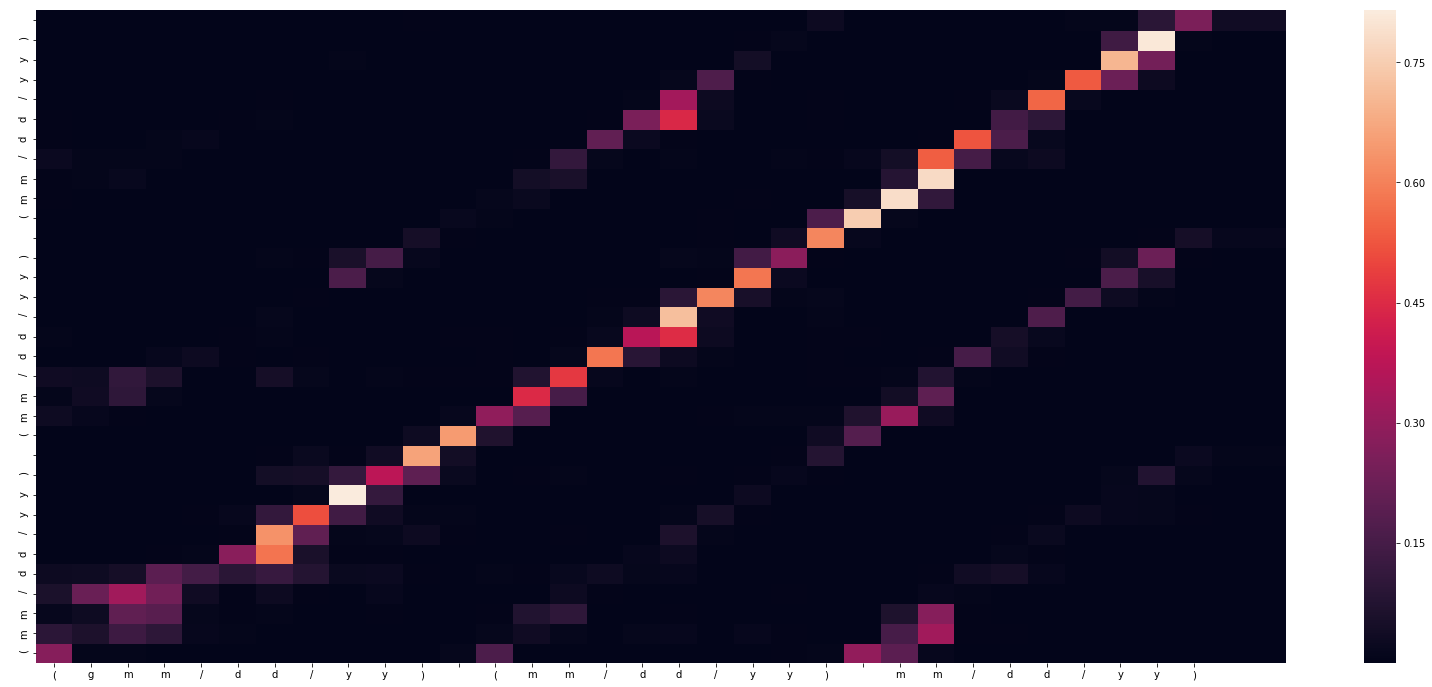

-
Input sentence: (gmm/dd/yy) (mm/dd/yy) mm/dd/yy)
GT sentence: (mm/dd/yy) (mm/dd/yy) (mm/dd/yy)

Decoded sentence: (mm/dd/yy) (mm/dd/yy) (mm/dd/yy)



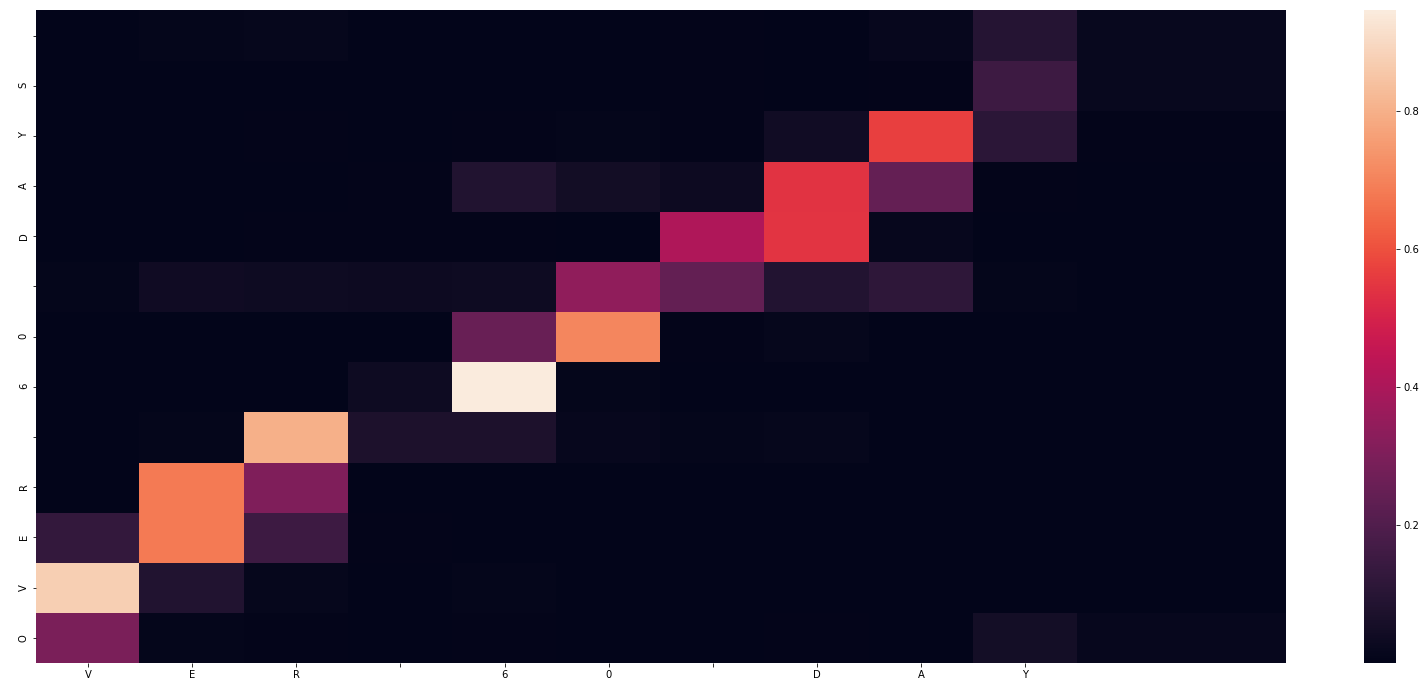

-
Input sentence: VER 60 DAY
GT sentence: OVER 60 DAYS

Decoded sentence: OVER 60 DAYS



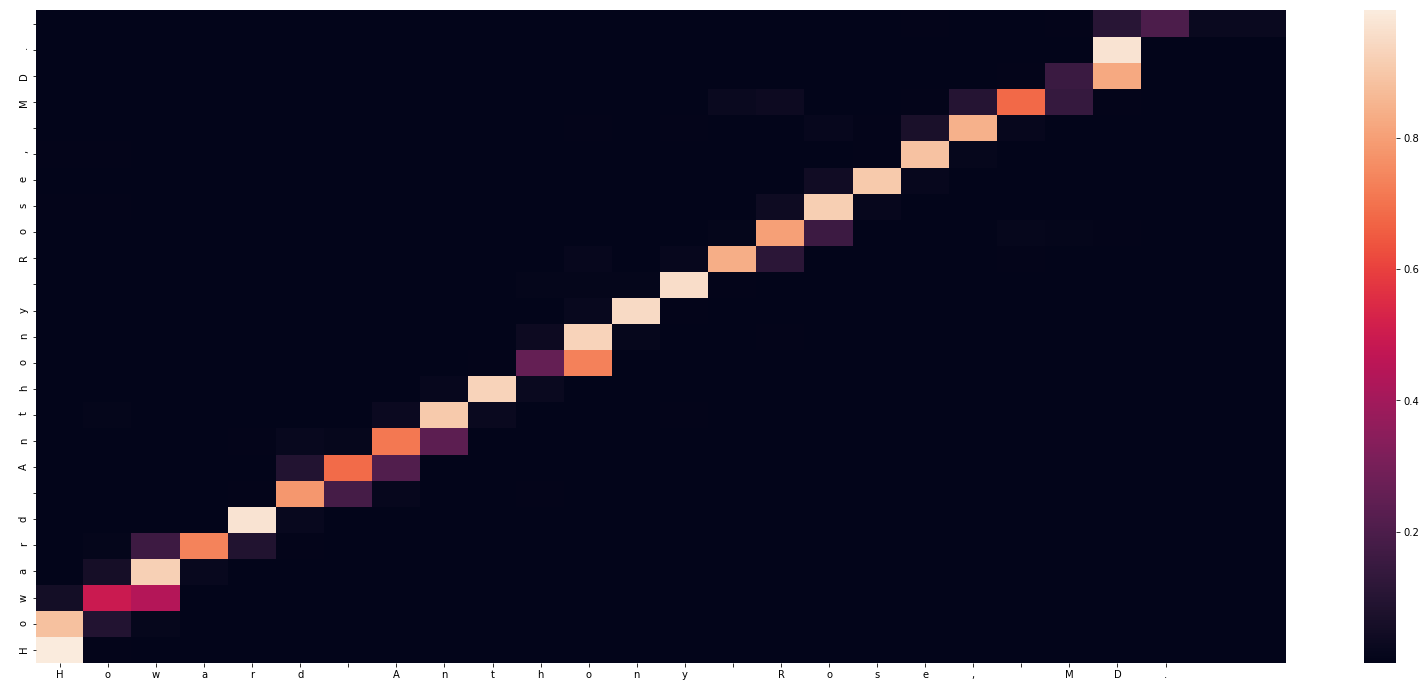

-
Input sentence: Howard Anthony Rose, MD.
GT sentence: Howard Anthony Rose, MD.

Decoded sentence: Howard Anthony Rose, MD.



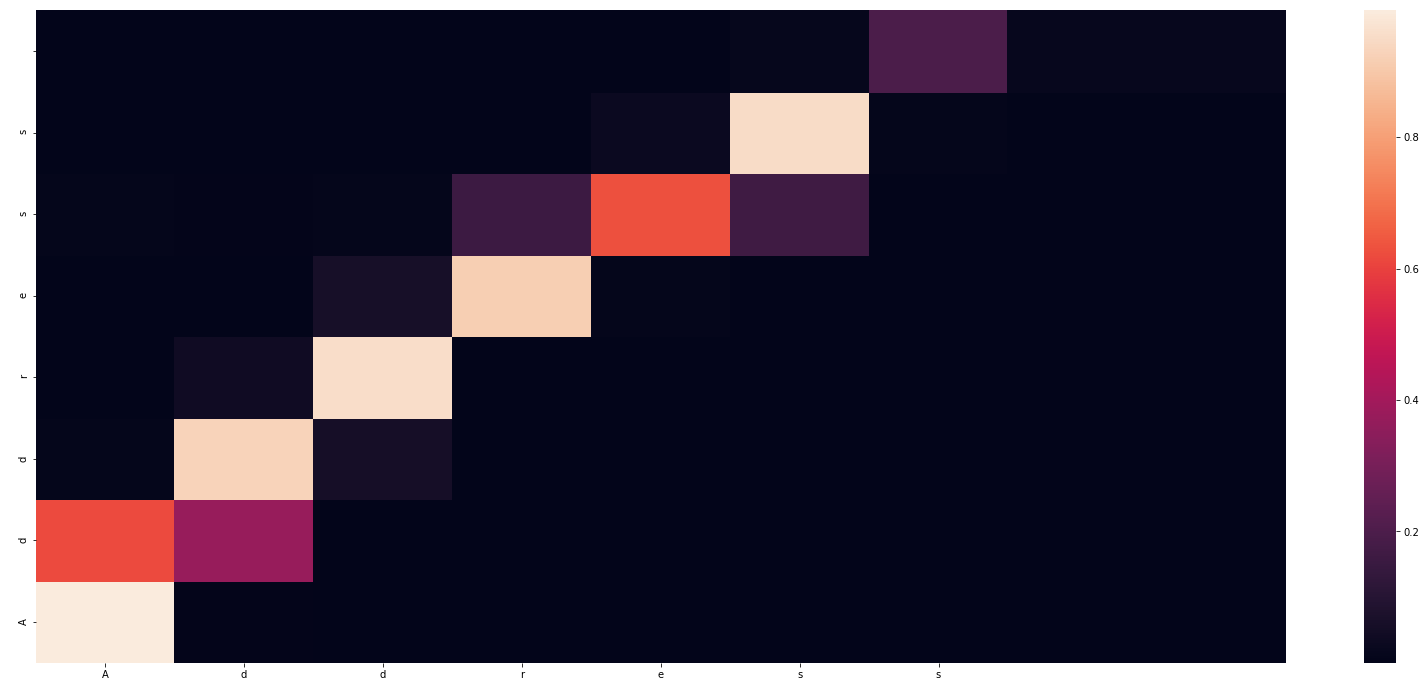

-
Input sentence: Address
GT sentence: Address

Decoded sentence: Address



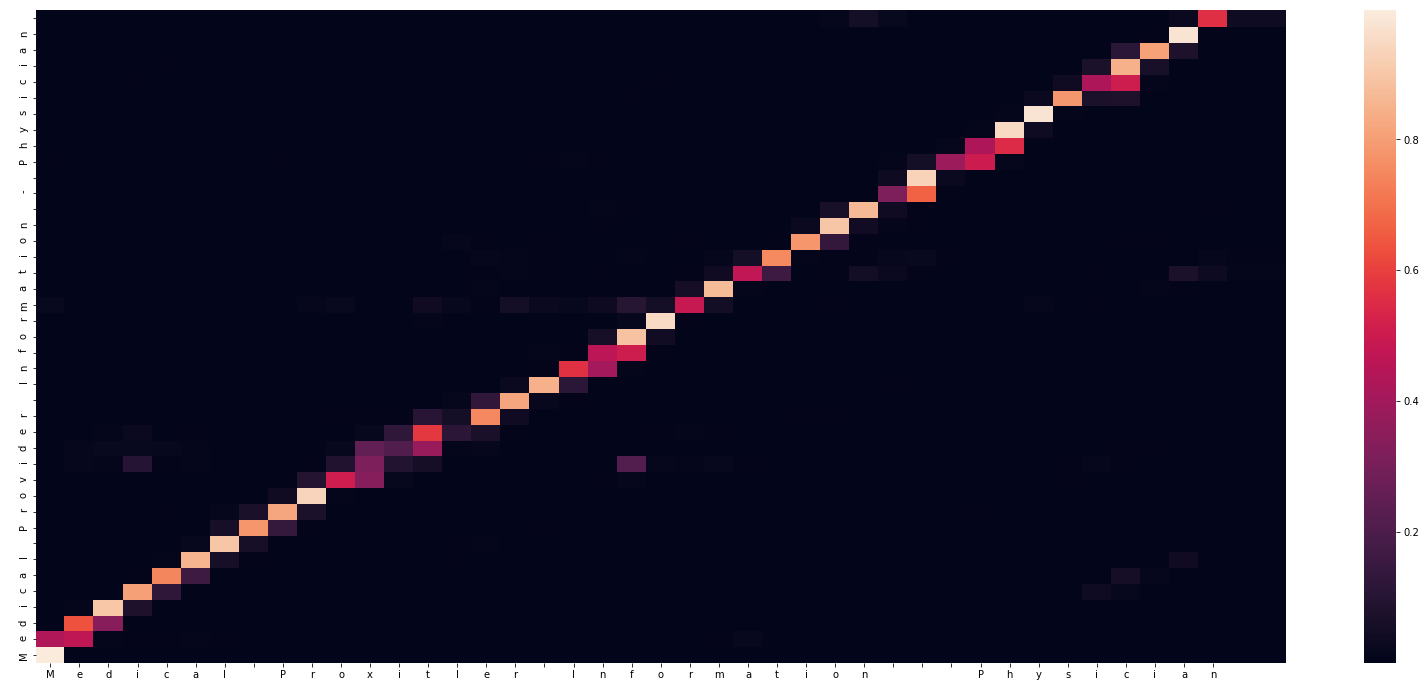

-
Input sentence: Medical Proxitler Information — Physician
GT sentence: Medical Provider Information - Physician

Decoded sentence: Medical Provider Information - Physician



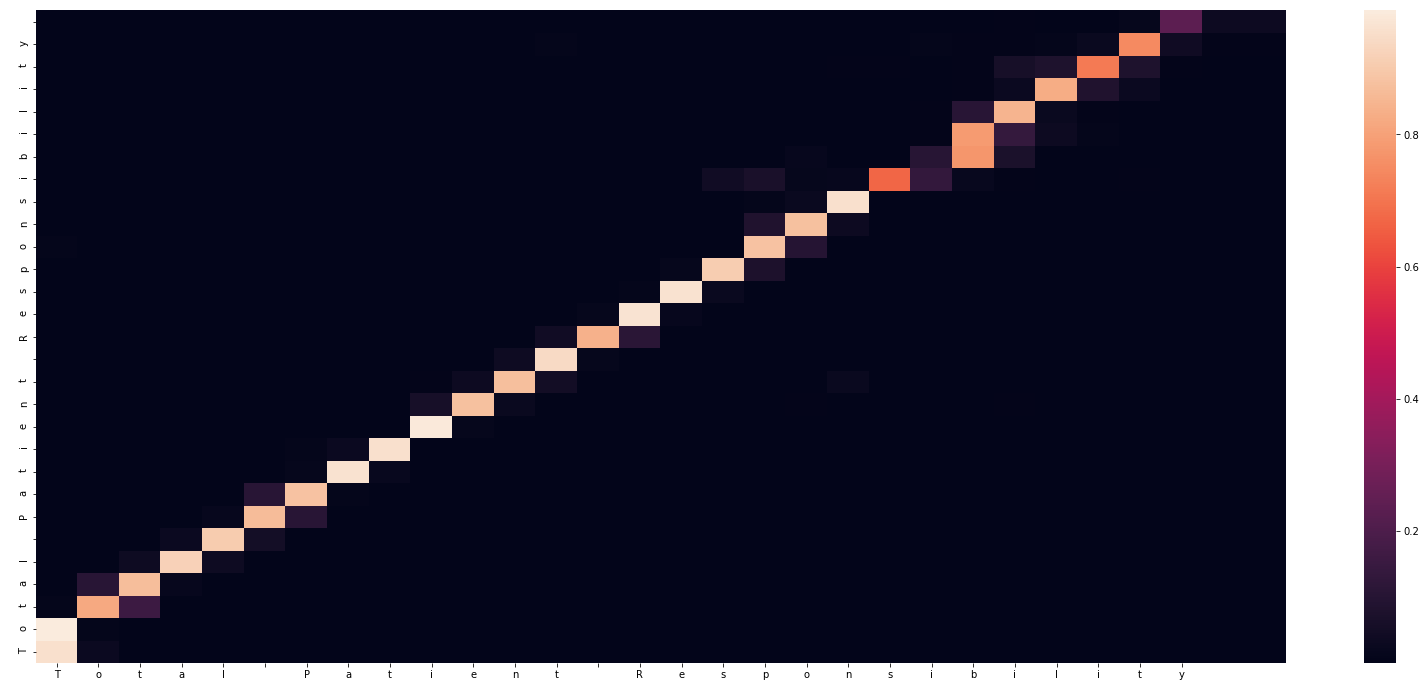

-
Input sentence: Total Patient Responsibility
GT sentence: Total Patient Responsibility

Decoded sentence: Total Patient Responsibility



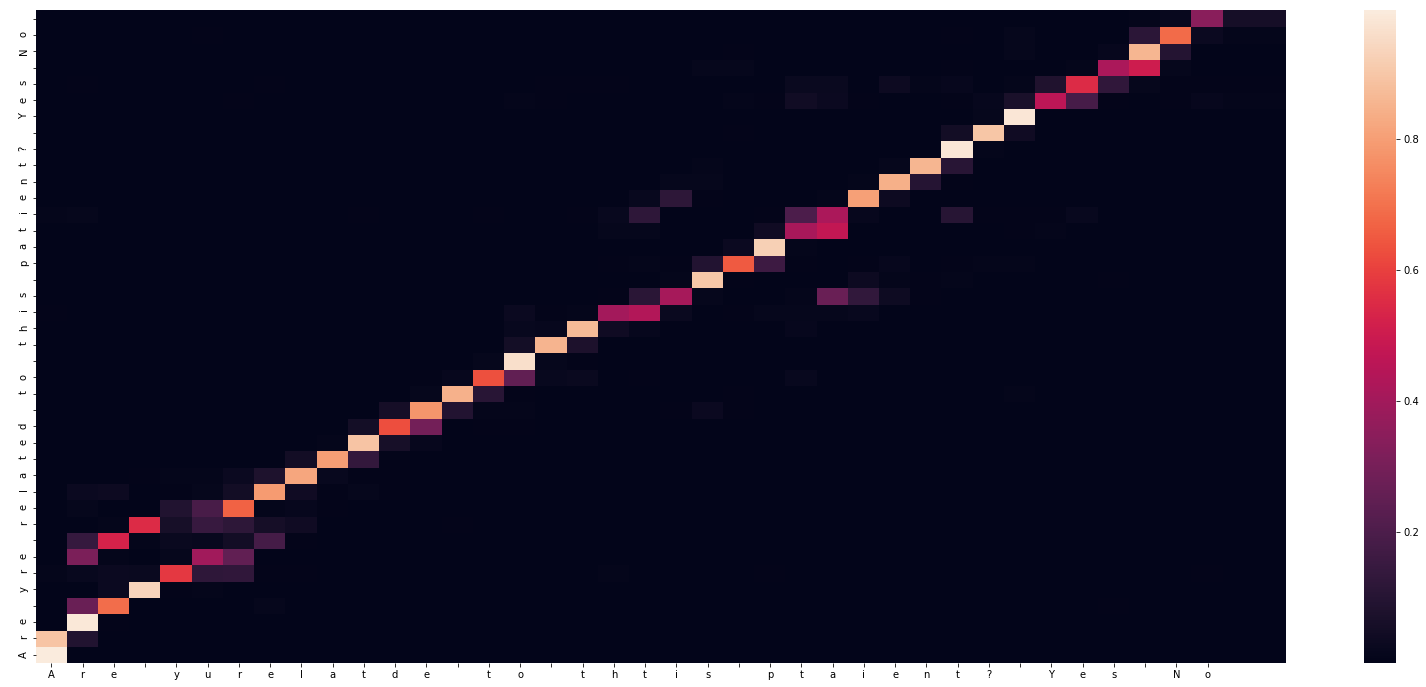

-
Input sentence: Are yurelatde to thtis ptaient? Yes No
GT sentence: Are you related to this patient? Yes No

Decoded sentence: Are yre related to this patient? Yes No



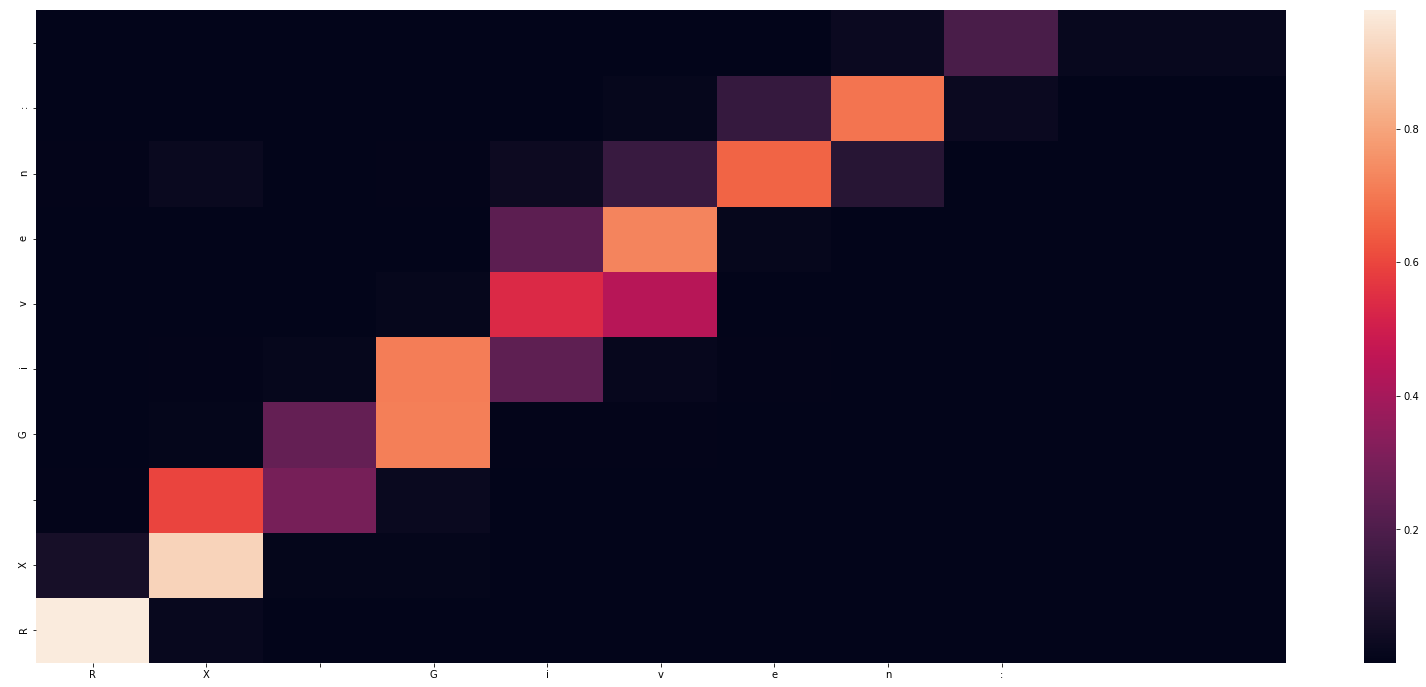

-
Input sentence: RX Given:
GT sentence: RX Given:

Decoded sentence: RX Given:



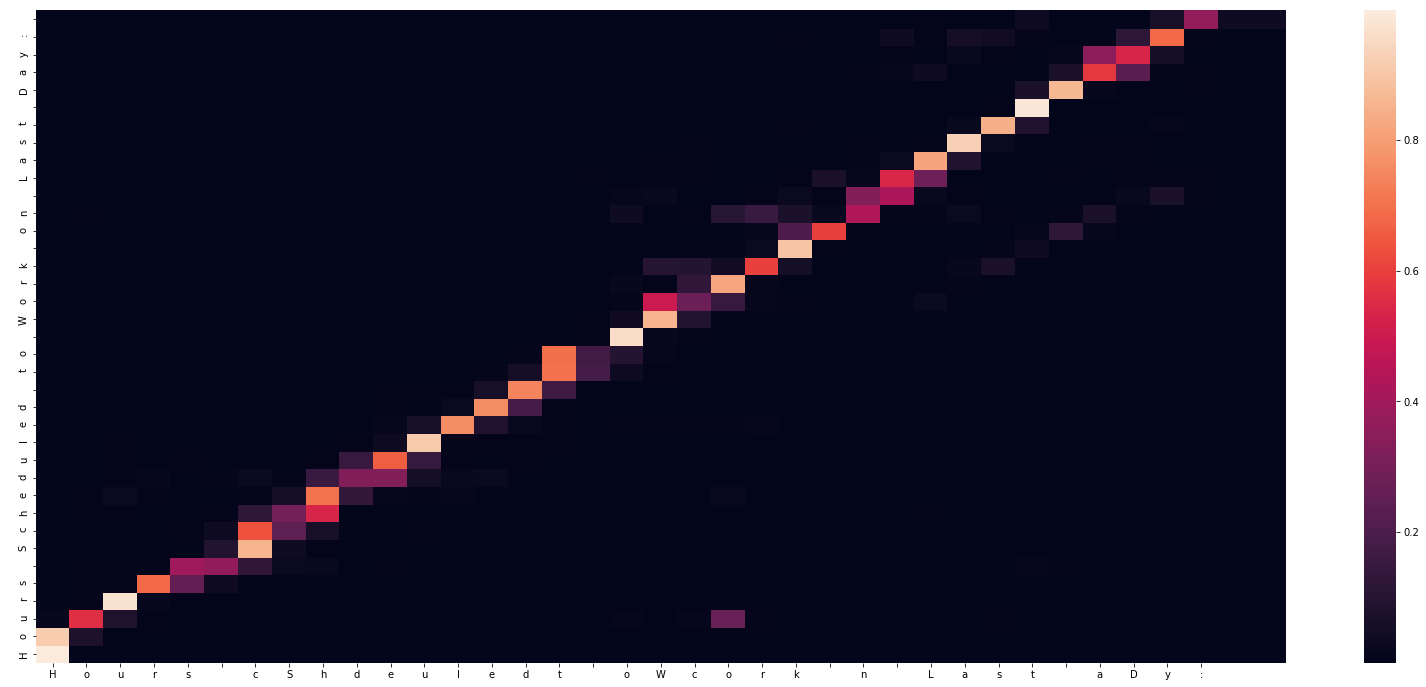

-
Input sentence: Hours cShdeuledt oWcork n Last aDy:
GT sentence: Hours Scheduled to Work on Last Day:

Decoded sentence: Hours Scheduled to Work on Last Day:



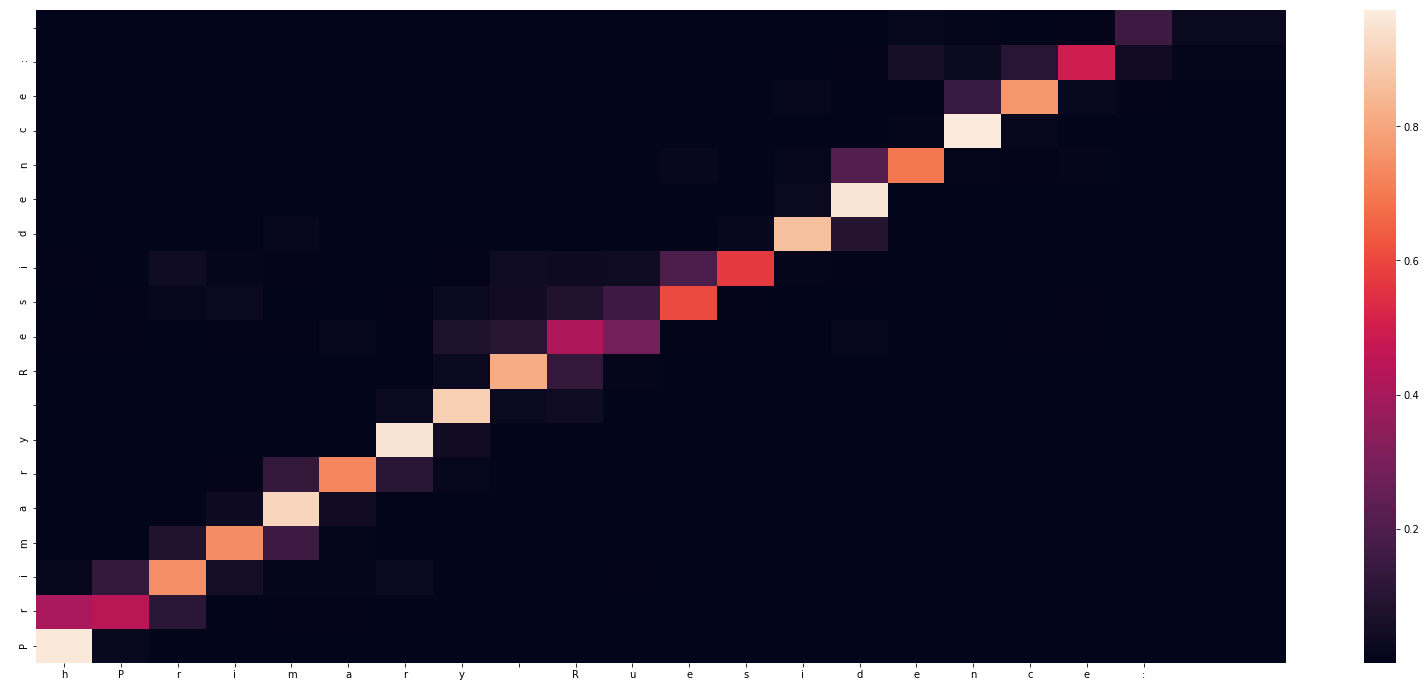

-
Input sentence: hPrimary Ruesidence:
GT sentence: Primary Residence:

Decoded sentence: Primary Residence:



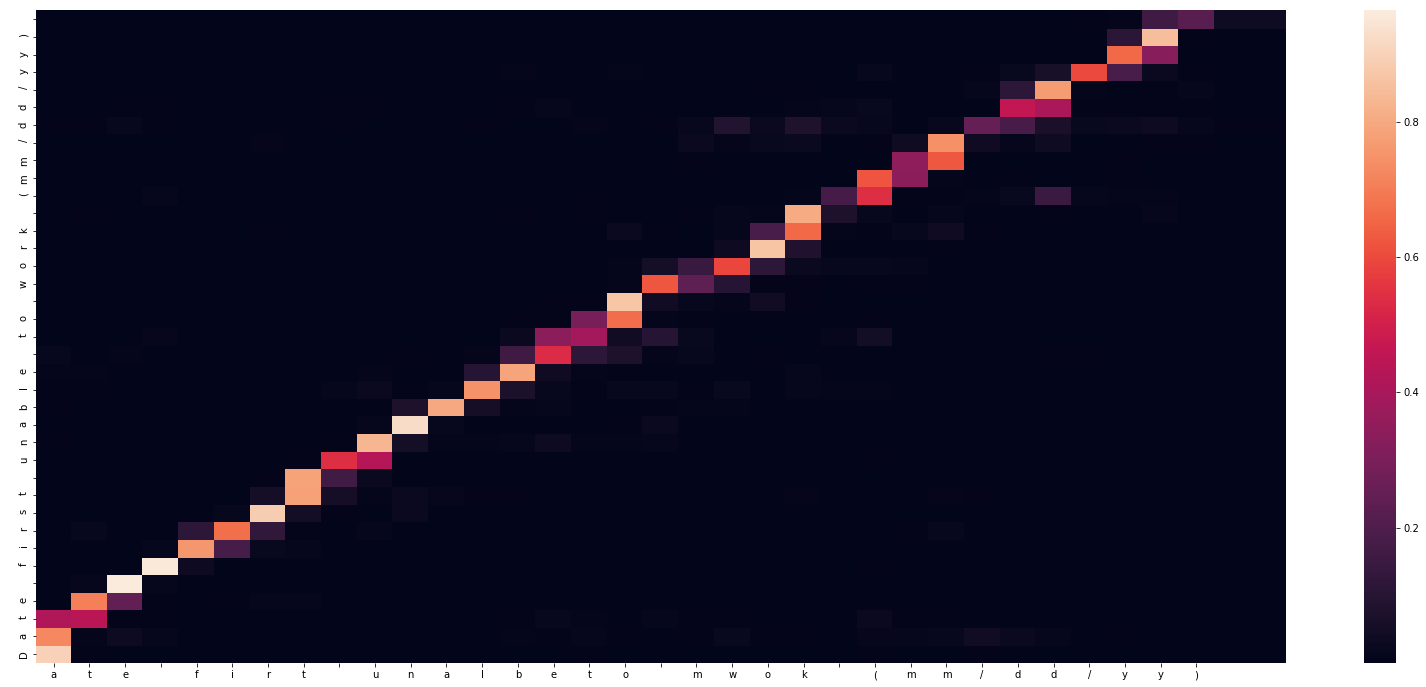

-
Input sentence: ate firt unalbeto mwok (mm/dd/yy)
GT sentence: Date first unable to work (mm/dd/yy)

Decoded sentence: Date first unable to work (mm/dd/yy)



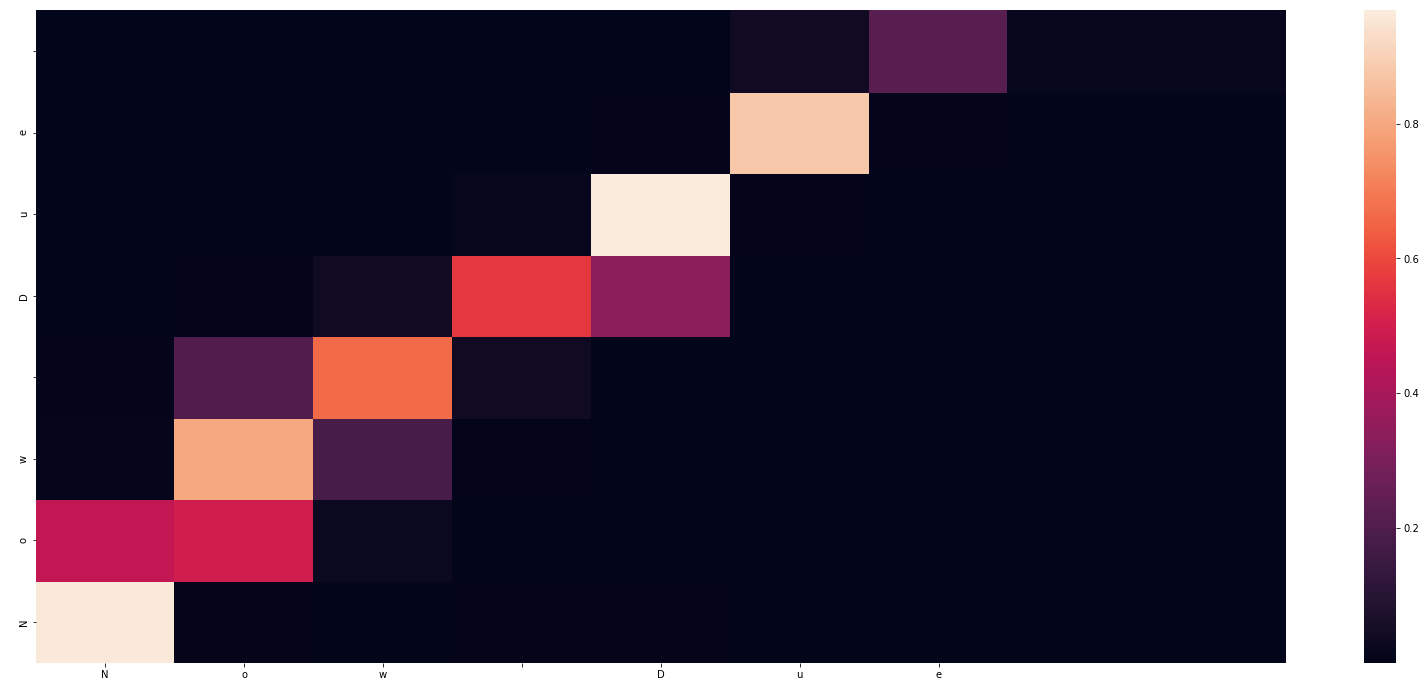

-
Input sentence: Now Due
GT sentence: Now Due

Decoded sentence: Now Due



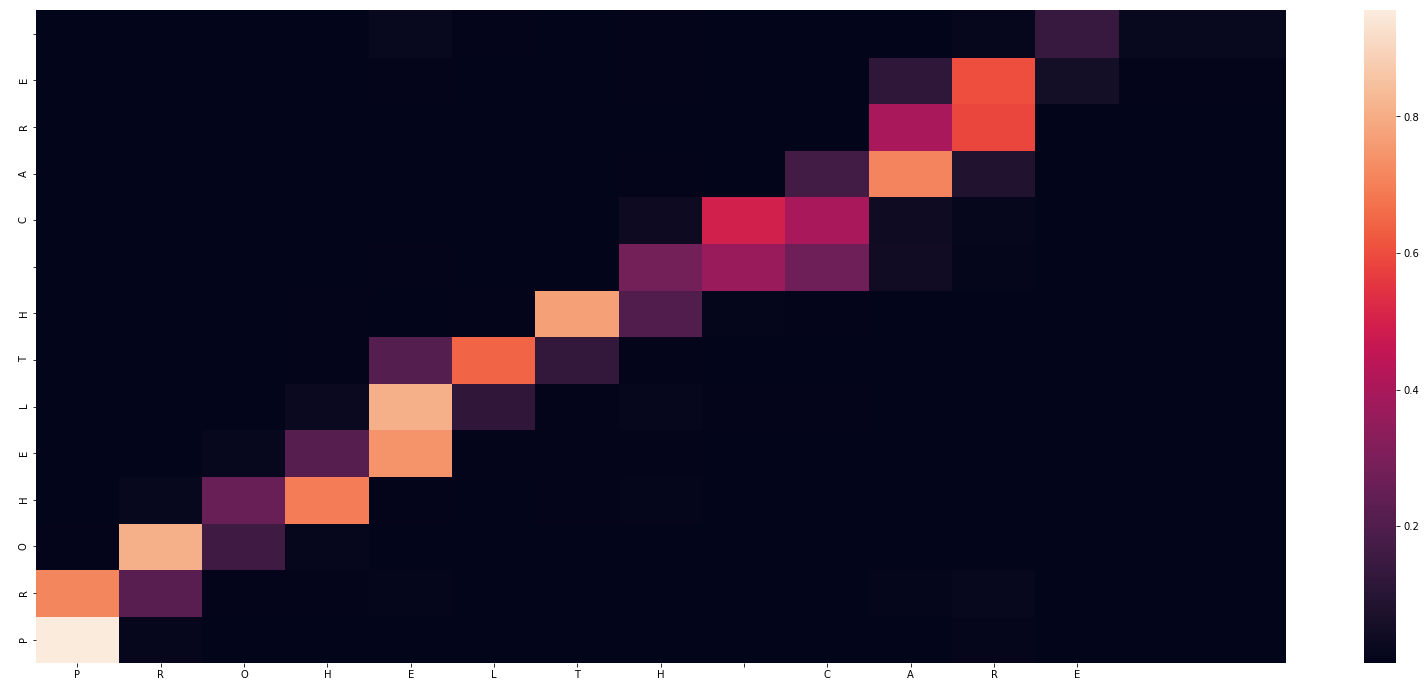

-
Input sentence: PROHELTH CARE
GT sentence: PROHEALTH CARE

Decoded sentence: PROHELTH CARE



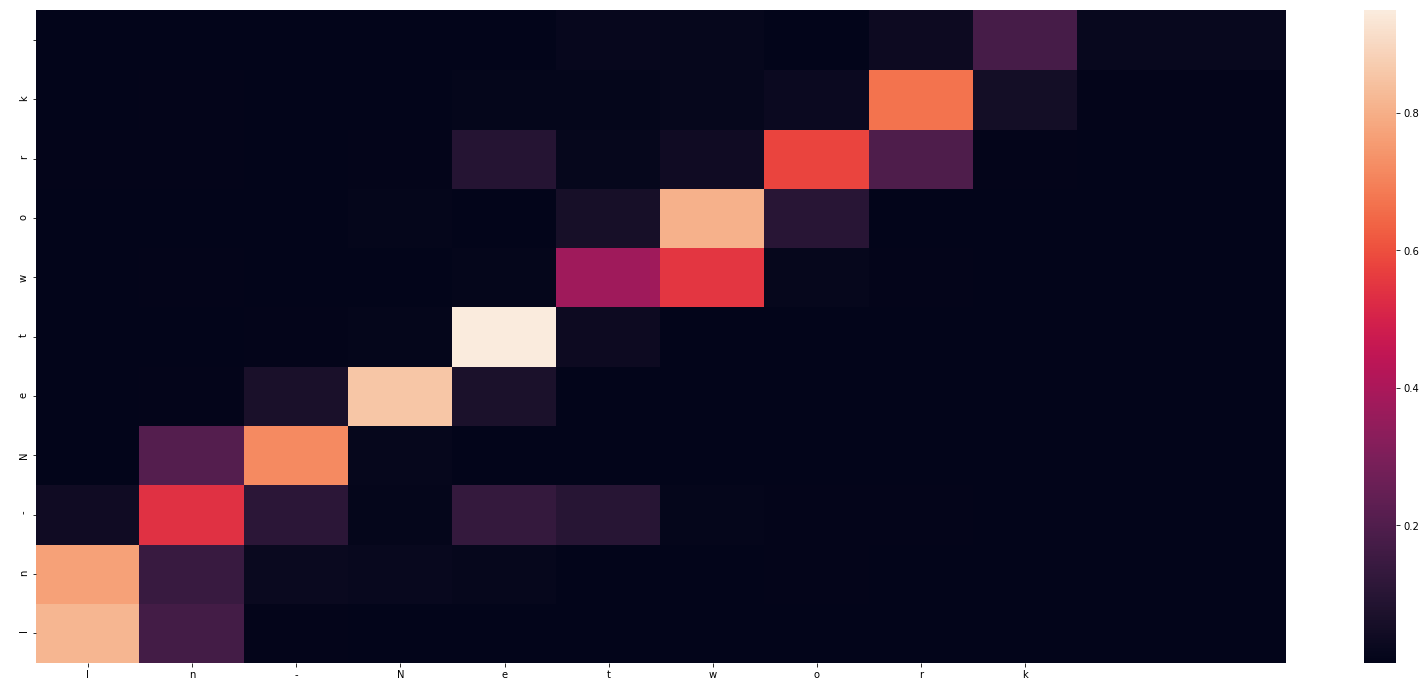

-
Input sentence: In-Network
GT sentence: In-Network

Decoded sentence: In-Network



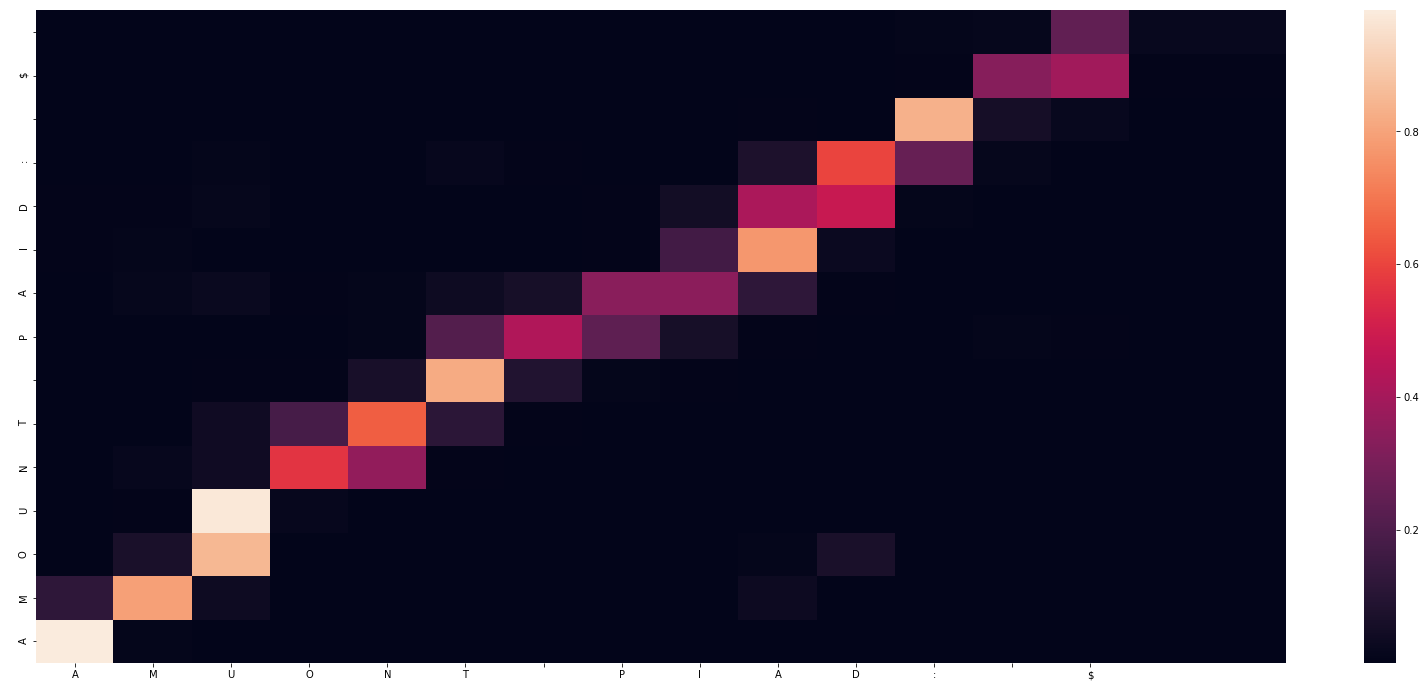

-
Input sentence: AMUONT PIAD: $
GT sentence: AMOUNT PAID: $

Decoded sentence: AMOUNT PAID: $



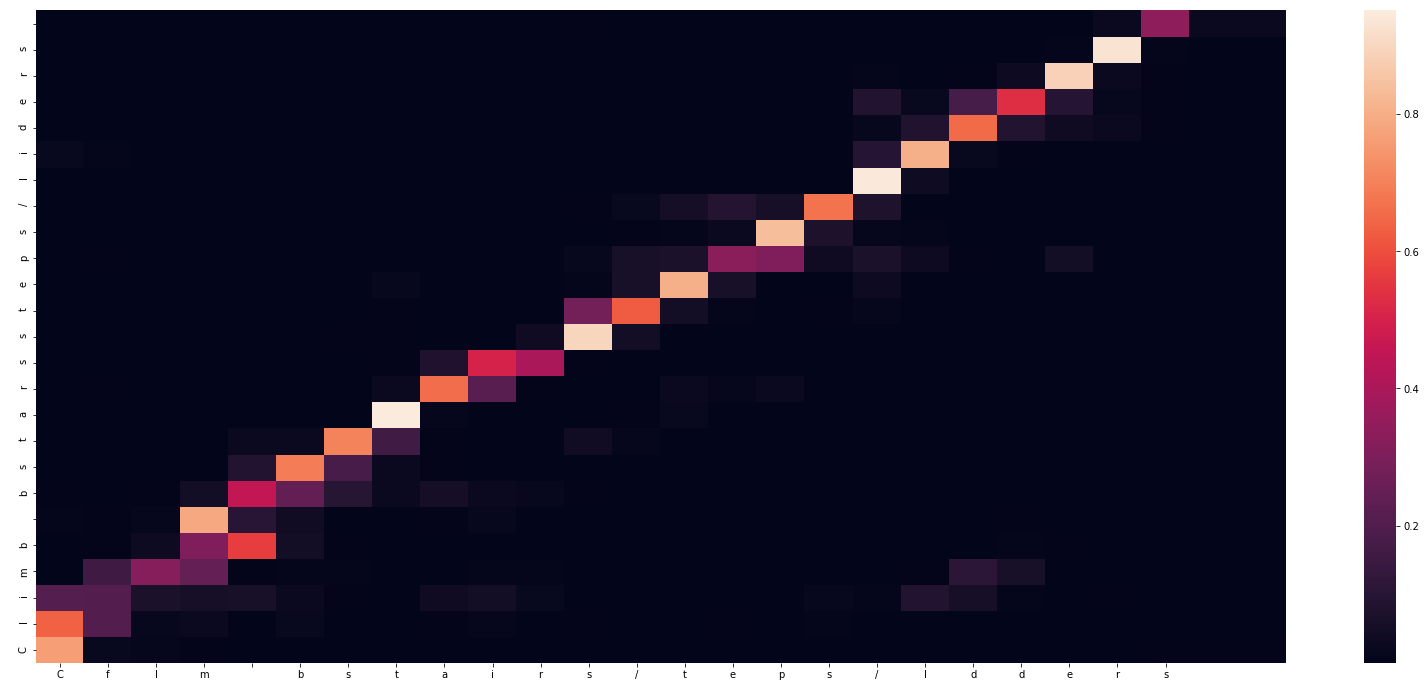

-
Input sentence: Cflm bstairs/teps/ldders
GT sentence: Climb stairs/steps/ladders

Decoded sentence: Climb bstarssteps/liders



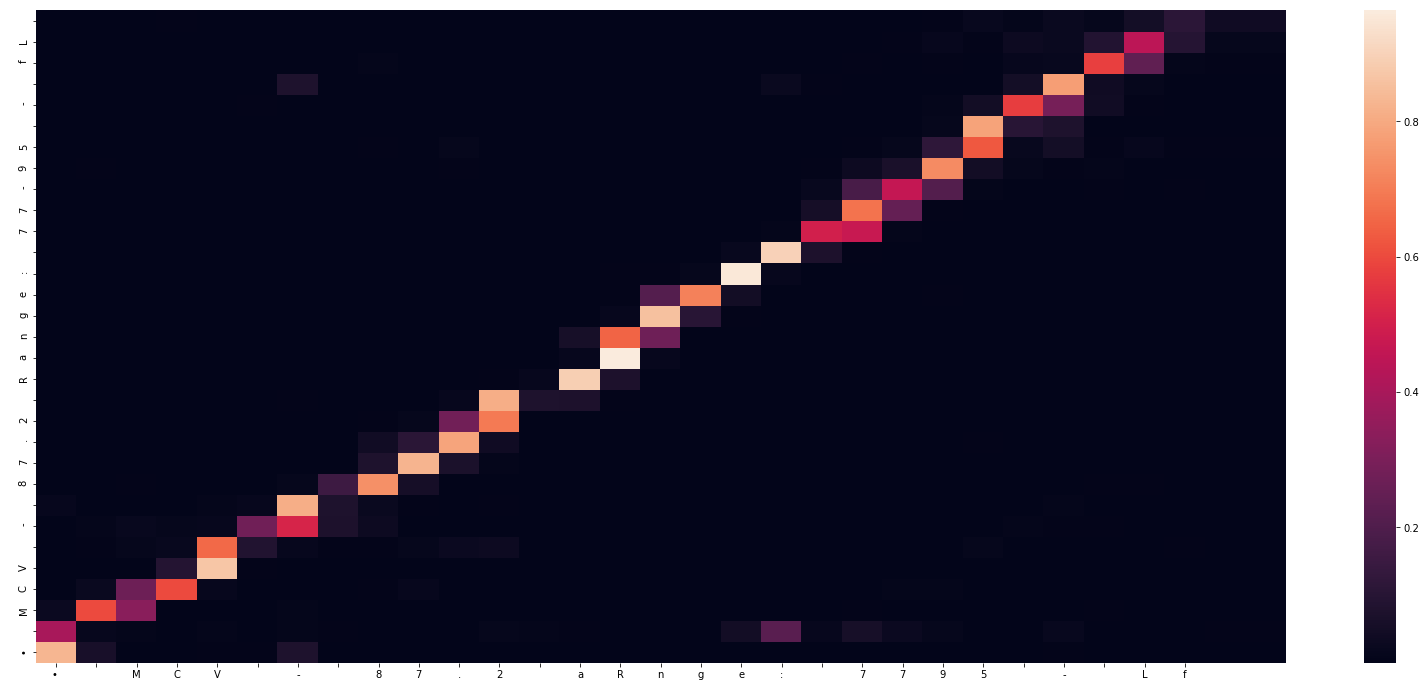

-
Input sentence: • MCV - 87.2 aRnge: 7795 - Lf
GT sentence: • MCV - 87.2 Range: 77-95 - fL

Decoded sentence: • MCV - 87.2 Range: 77-95 - fL



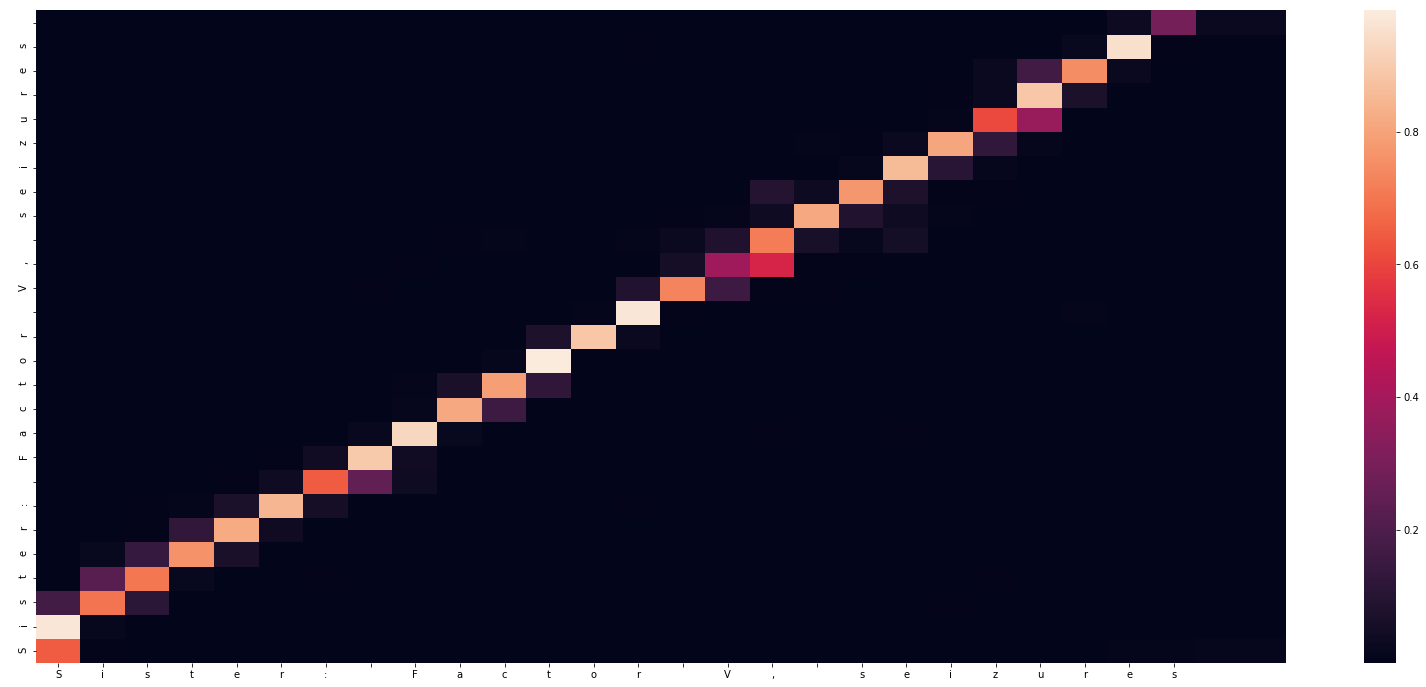

-
Input sentence: Sister: Factor V, seizures
GT sentence: Sister: Factor V, seizures

Decoded sentence: Sister: Factor V, seizures



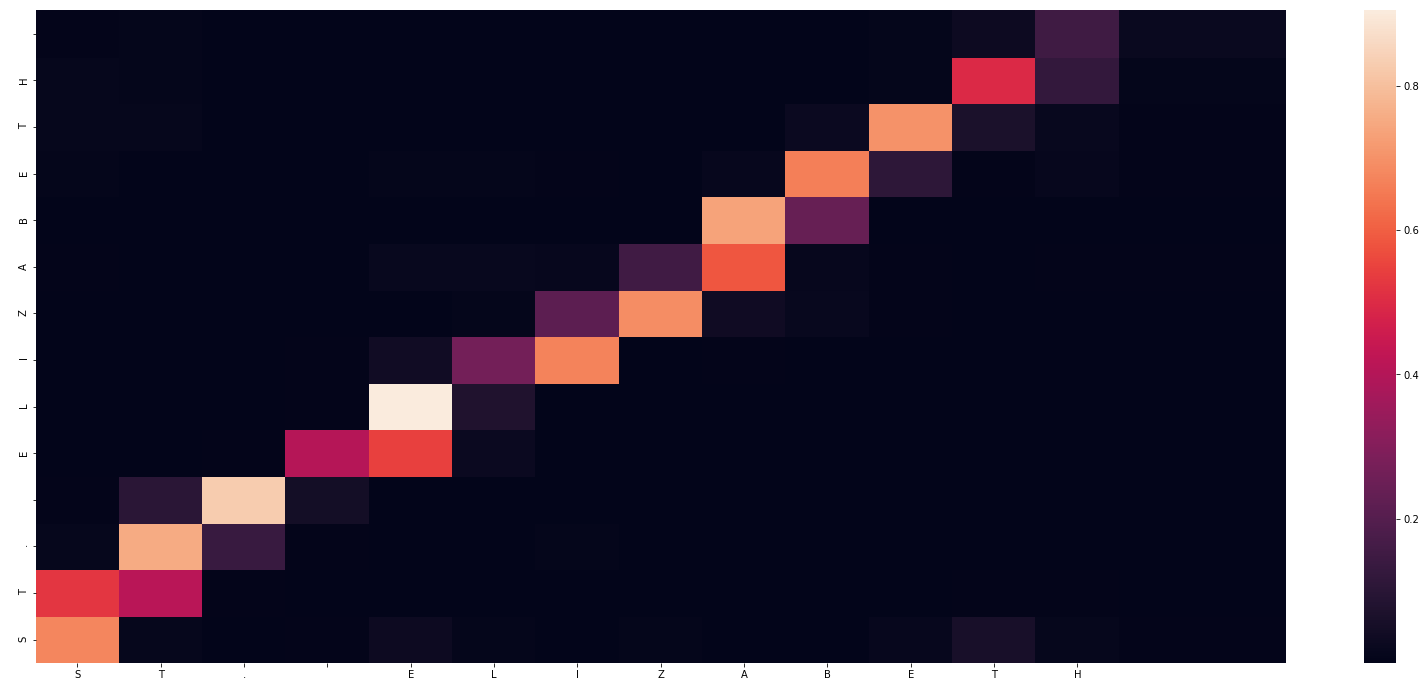

-
Input sentence: ST. ELIZABETH
GT sentence: ST. ELIZABETH

Decoded sentence: ST. ELIZABETH



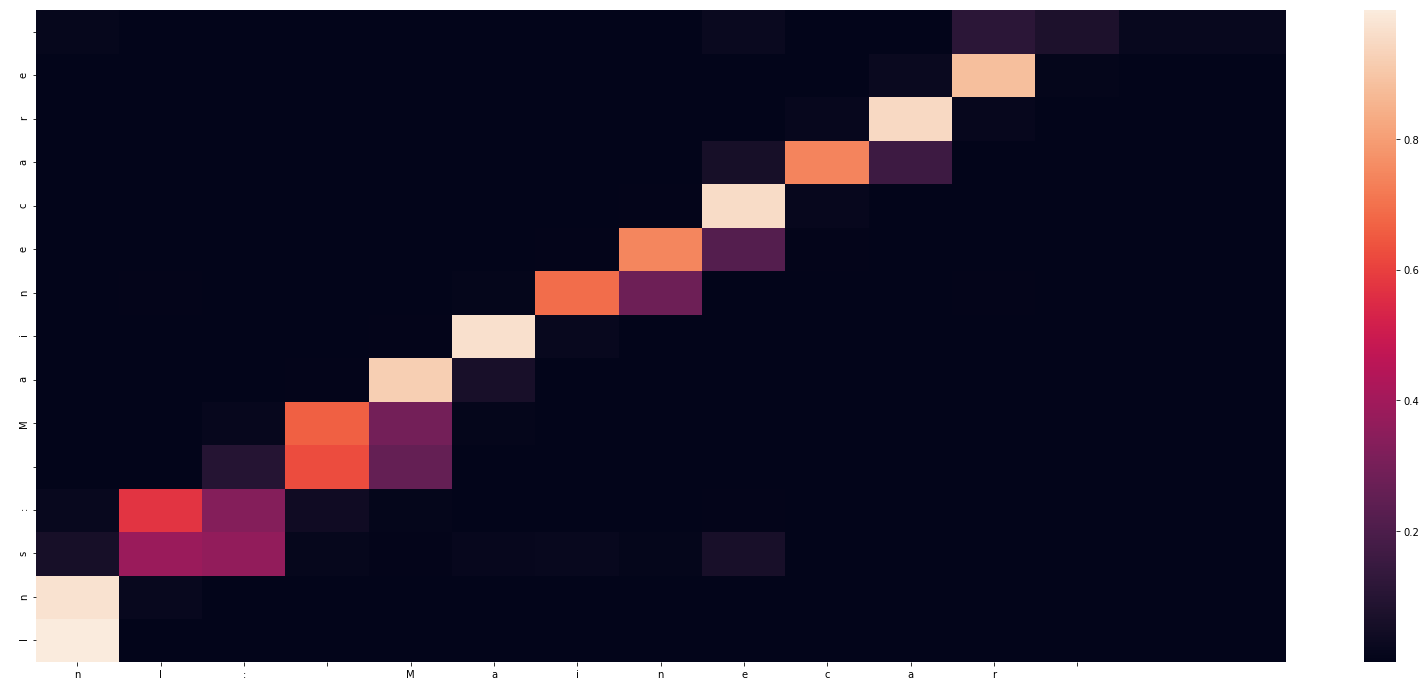

-
Input sentence: nI: Mainecar

GT sentence: Ins: Mainecare

Decoded sentence: Ins: Mainecare



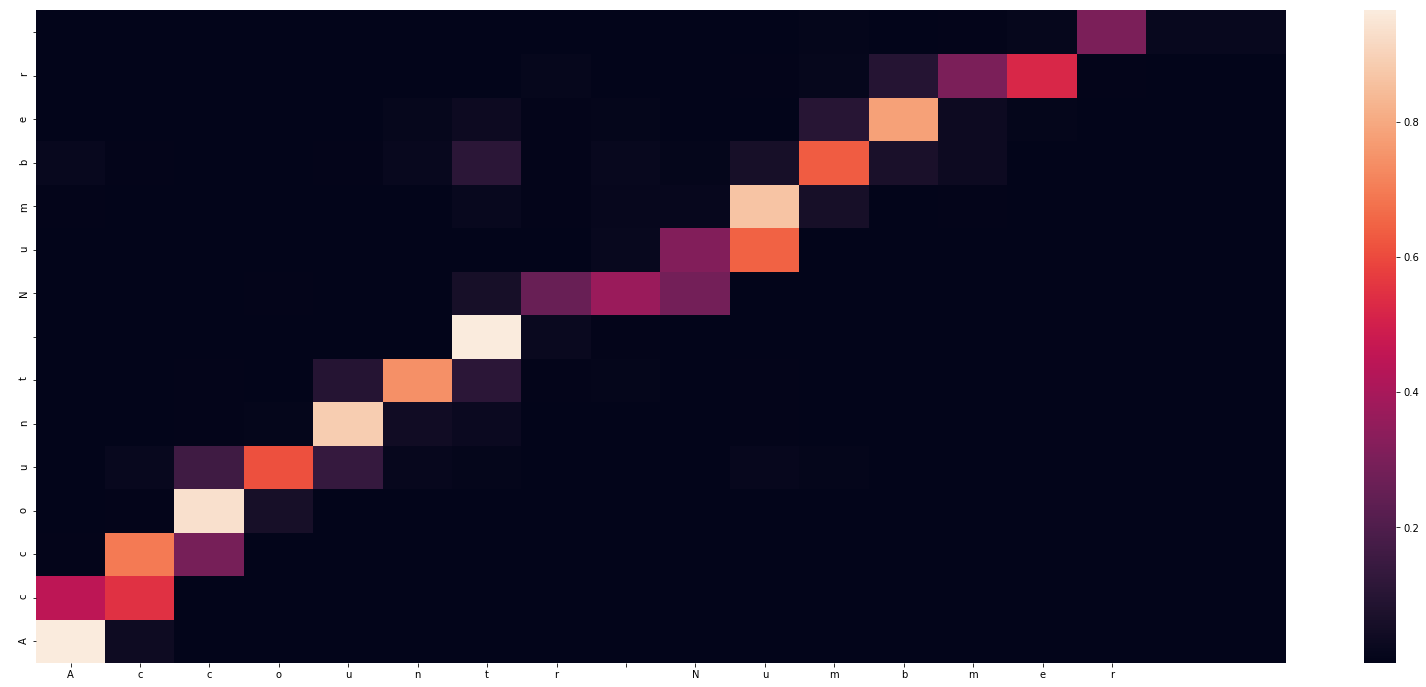

-
Input sentence: Accountr Numbmer
GT sentence: Account Number

Decoded sentence: Account Number



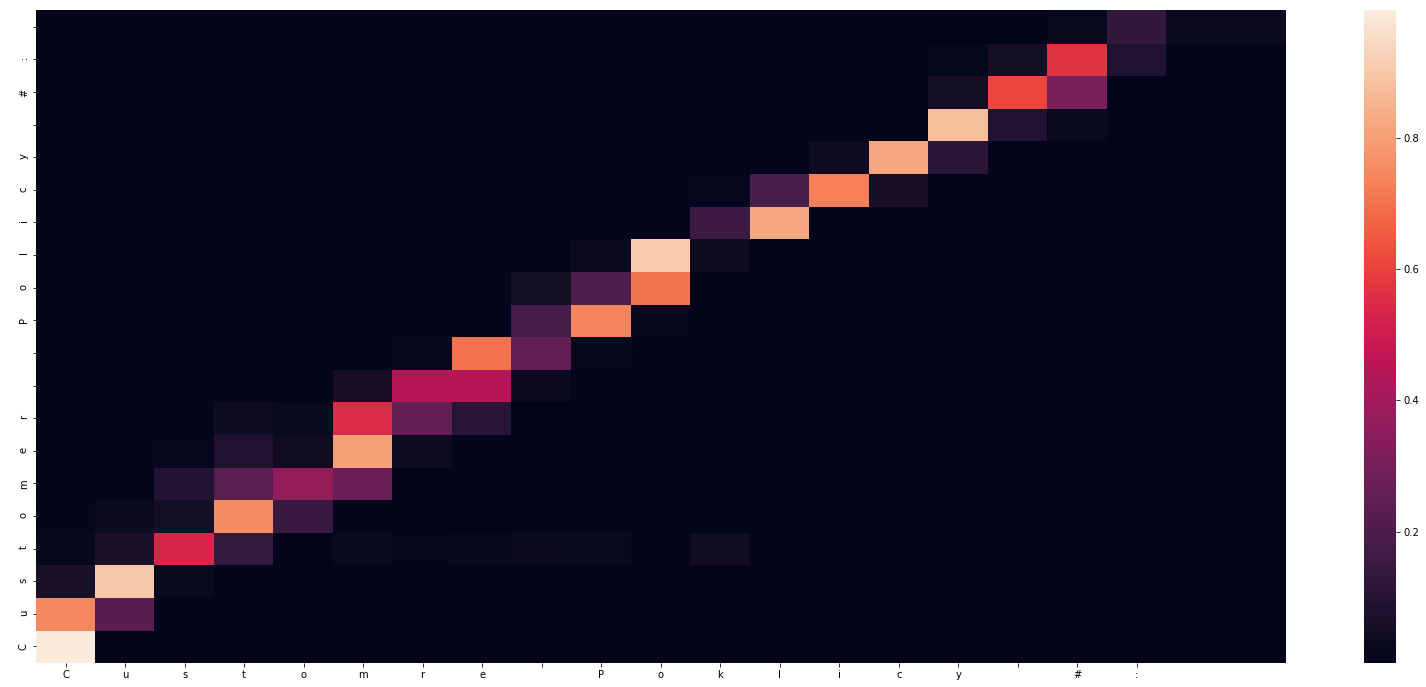

-
Input sentence: Customre Poklicy #:
GT sentence: Customer  Policy #:

Decoded sentence: Customer  Policy #:



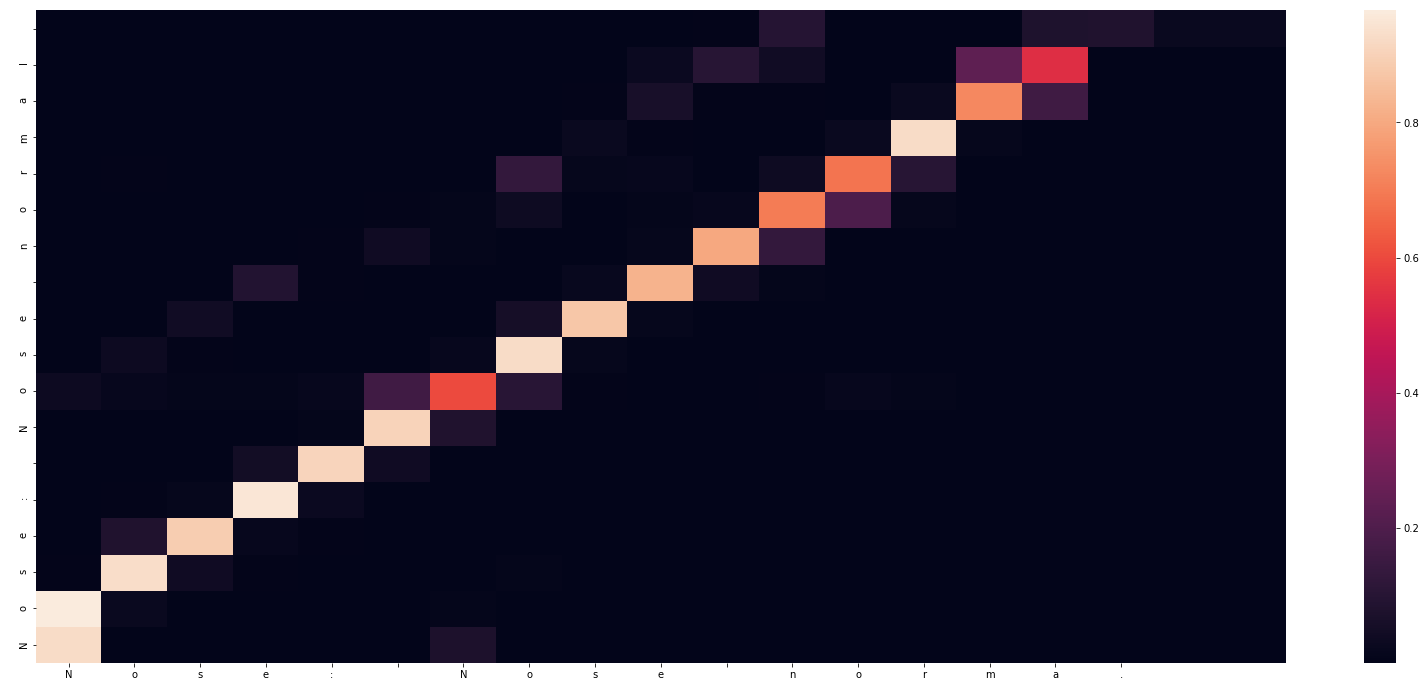

-
Input sentence: Nose: Nose norma.
GT sentence: Nose: Nose normal.

Decoded sentence: Nose: Nose normal



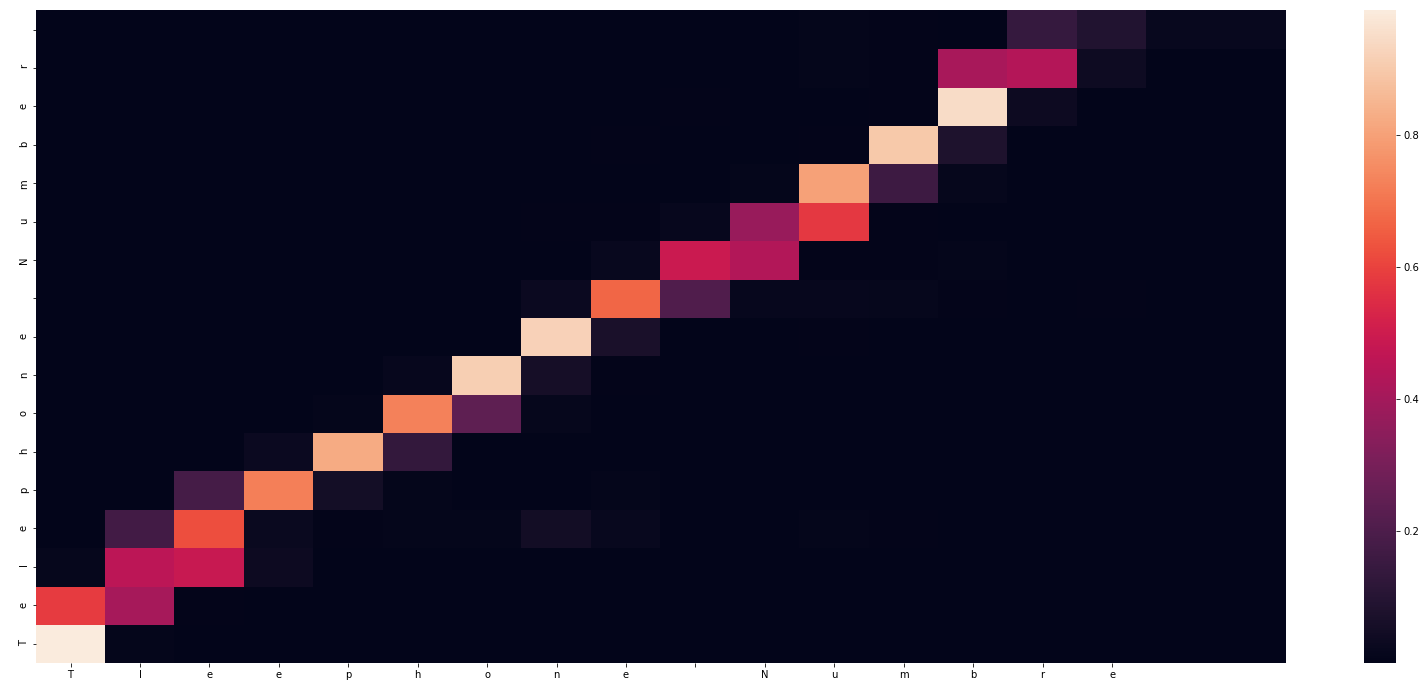

-
Input sentence: Tleephone Numbre
GT sentence: Telephone Number

Decoded sentence: Telephone Number



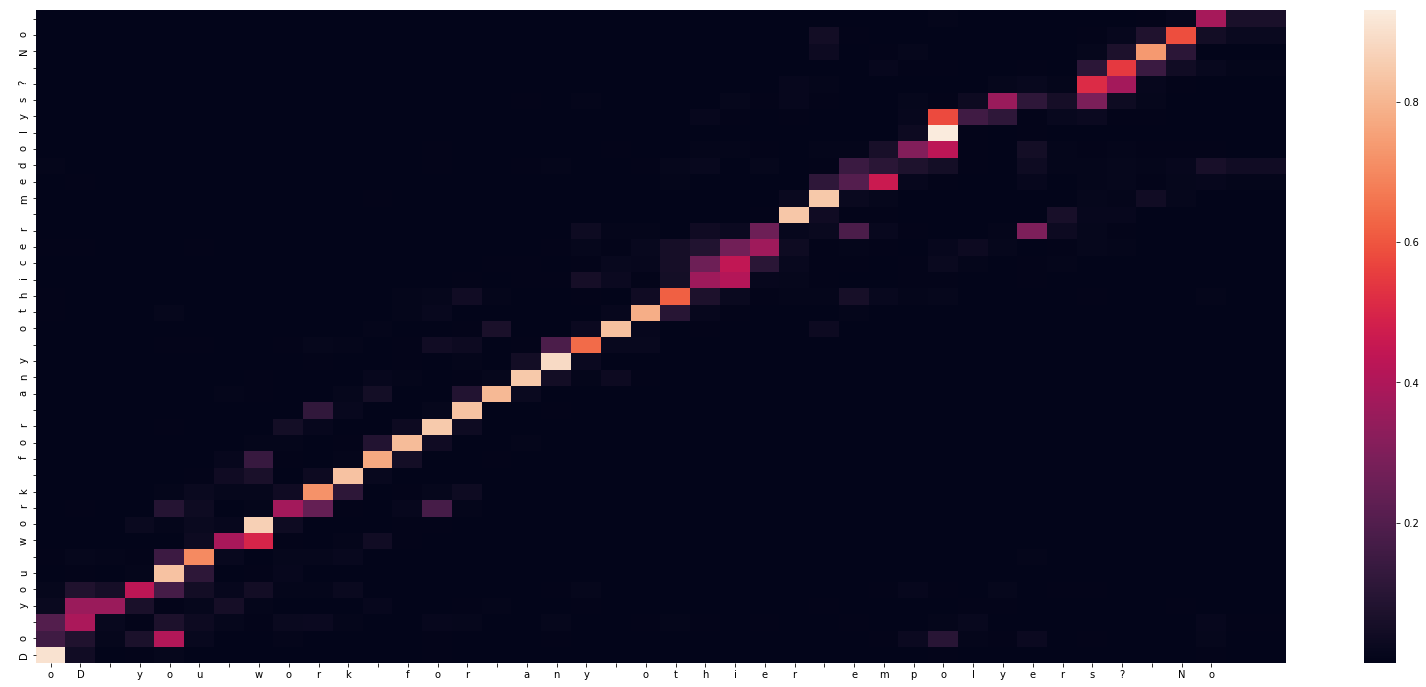

-
Input sentence: oD you work for any othier empolyers? No
GT sentence: Do you work for any other employers? No

Decoded sentence: Do you work for any othicer medolys? No



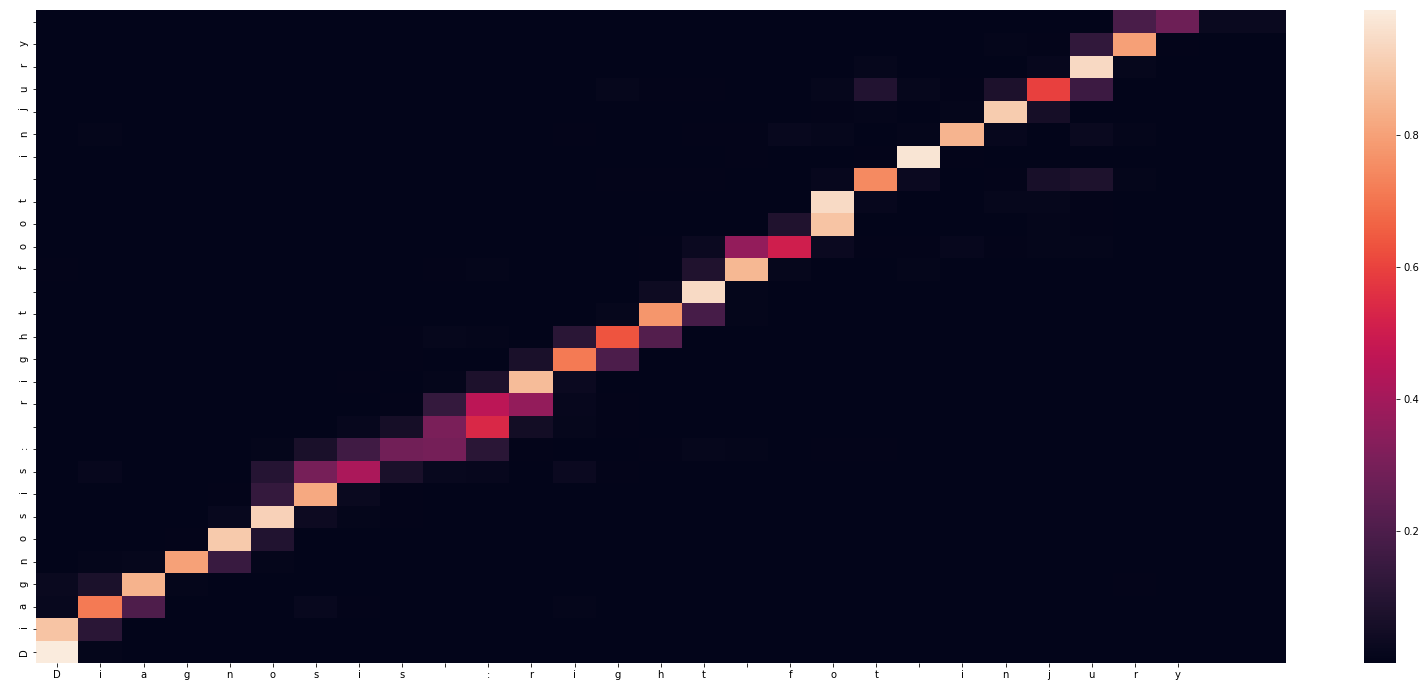

-
Input sentence: Diagnosis :right fot injury
GT sentence: Diagnosis: right foot injury

Decoded sentence: Diagnosis: right foot injury



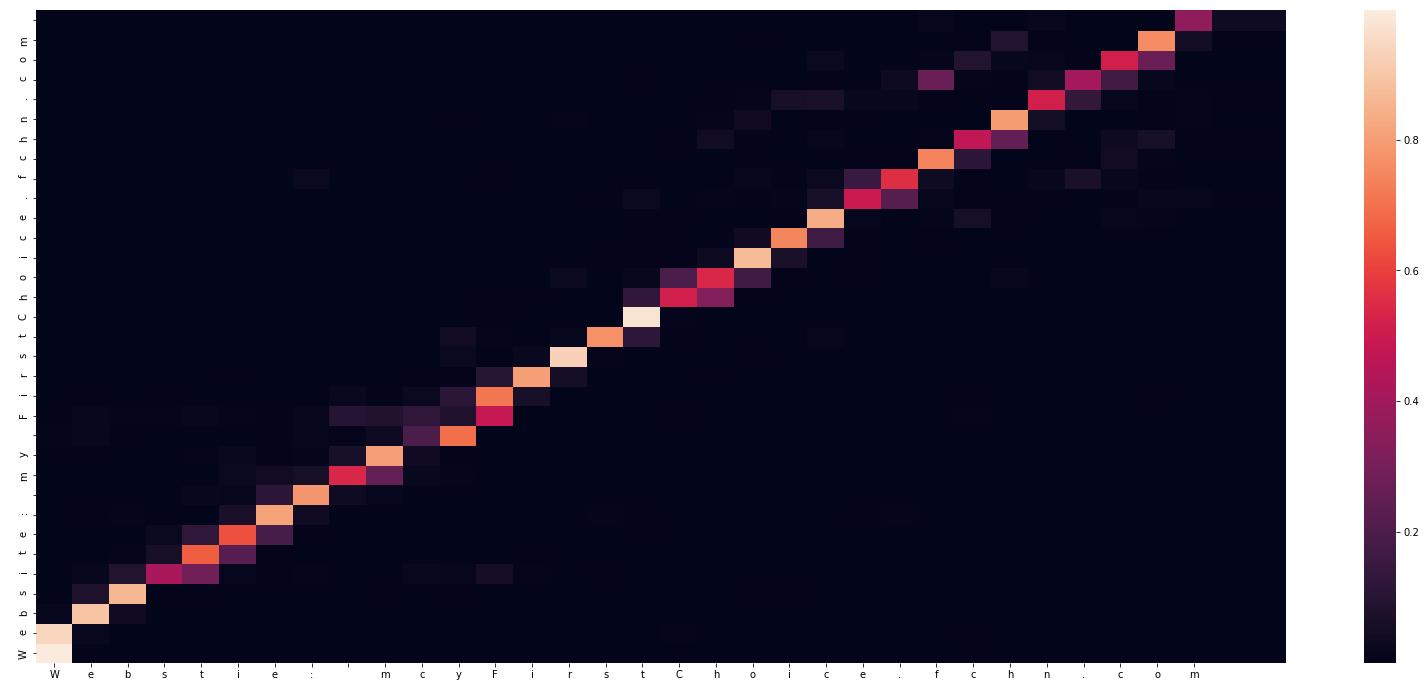

-
Input sentence: Webstie: mcyFirstChoice.fchn.com
GT sentence: Website: myFirstChoice.fchn.com

Decoded sentence: Website: my FirstChoice.fchn.com



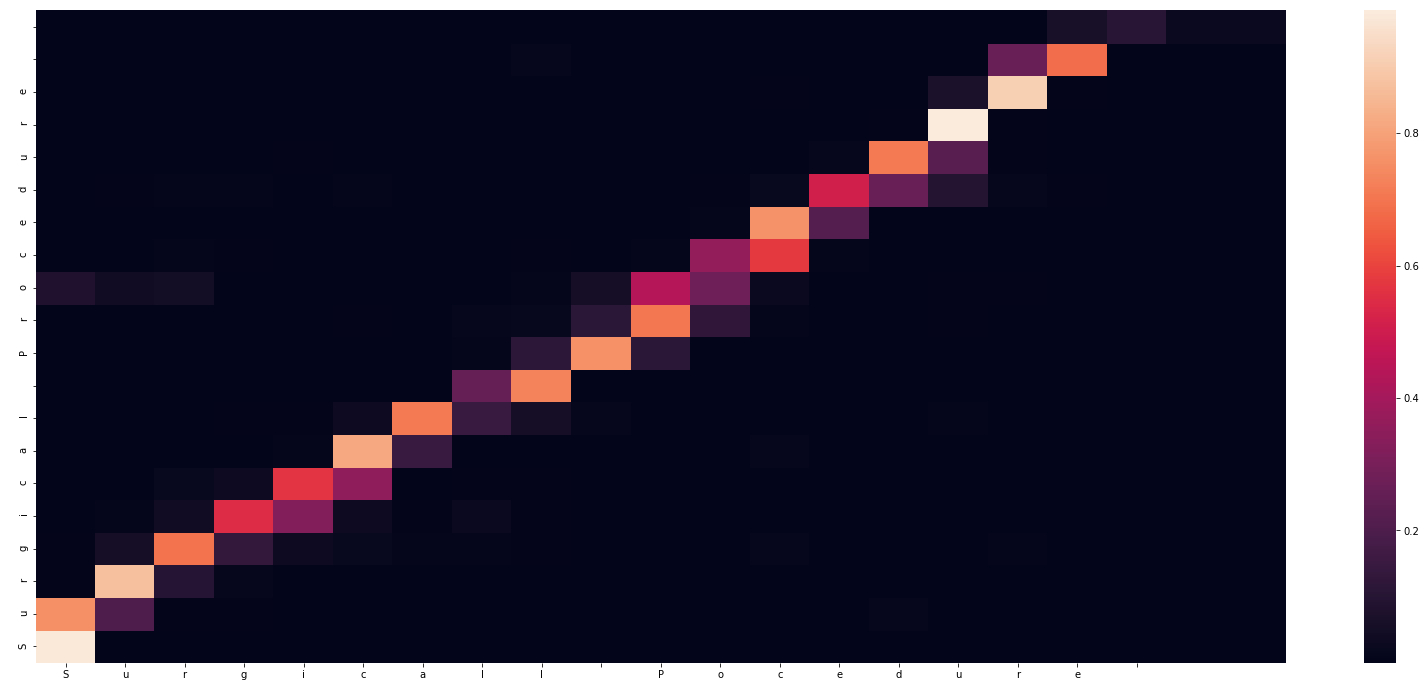

-
Input sentence: Surgicall Pocedure 
GT sentence: Surgical Procedure 

Decoded sentence: Surgical Procedure 



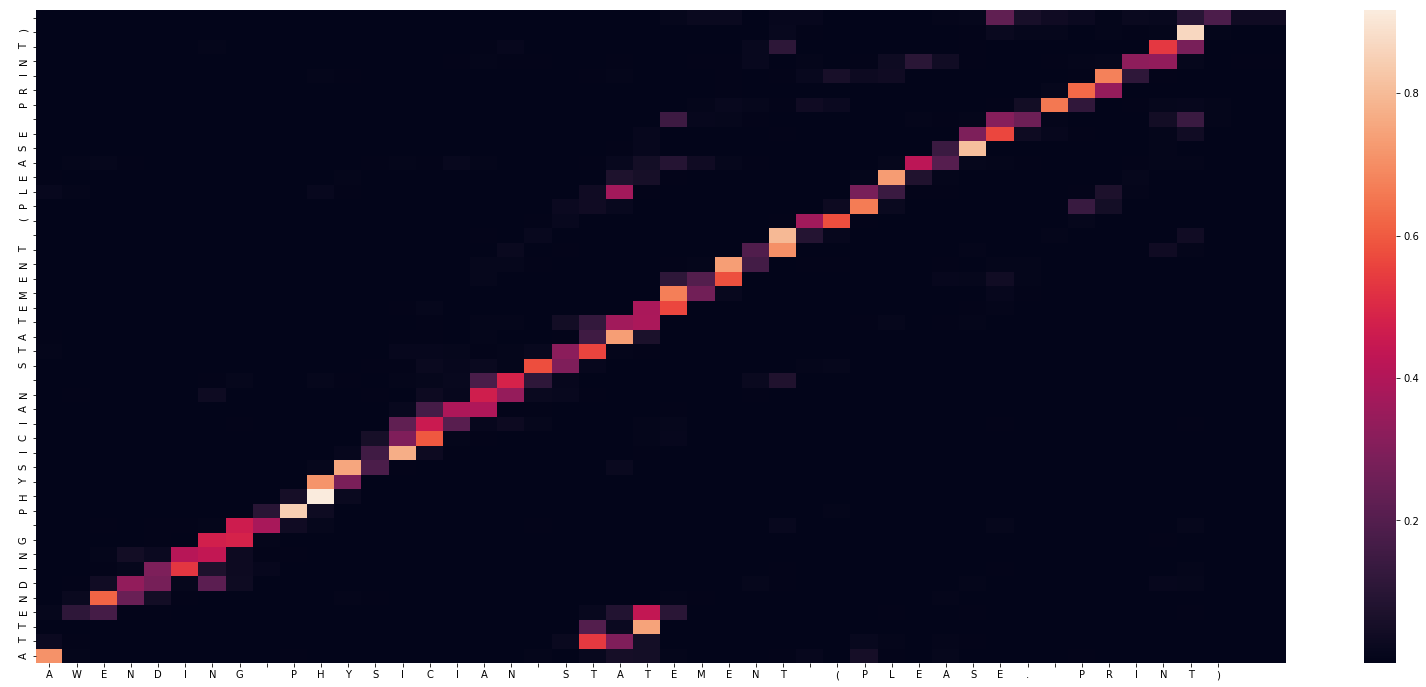

-
Input sentence: AWENDING PHYSICIAN STATEMENT (PLEASE. PRINT)
GT sentence: ATTENDING PHYSICIAN STATEMENT (PLEASE PRINT)

Decoded sentence: ATTENDING PHYSICIAN STATEMENT (PLEASE PRINT)



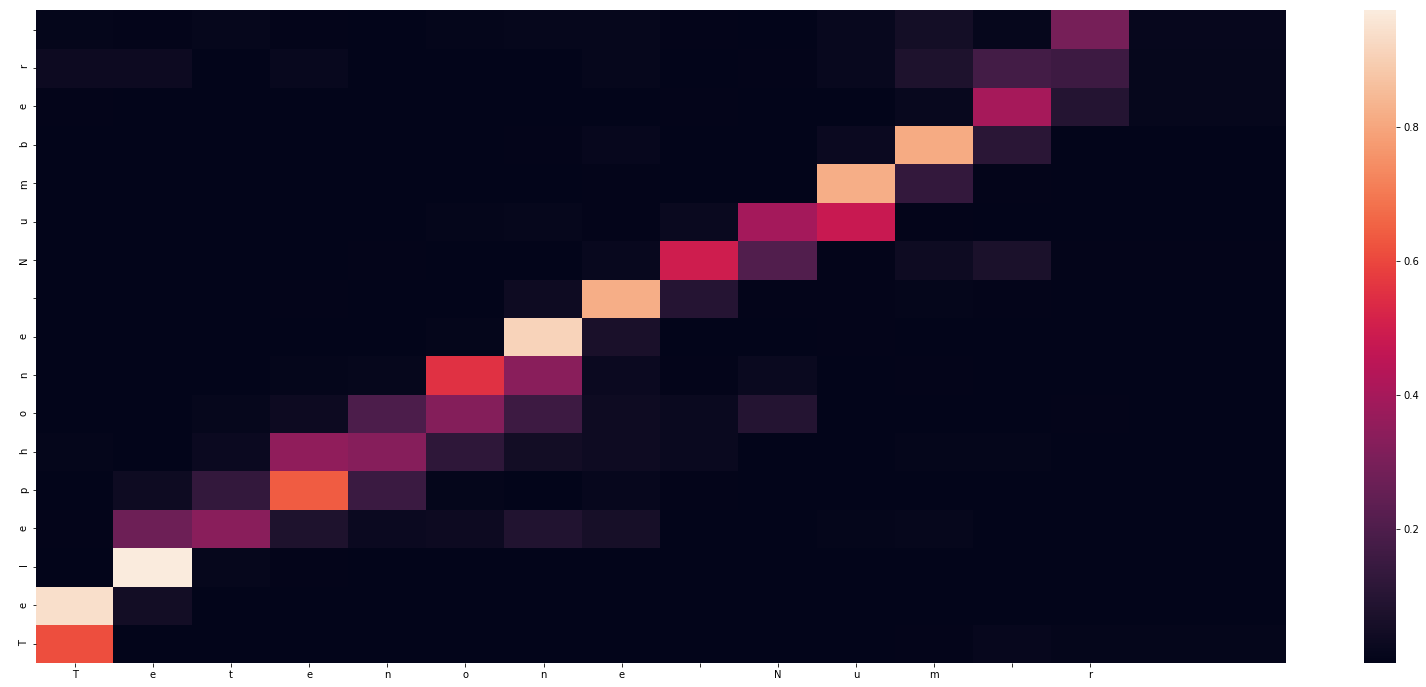

-
Input sentence: Tetenone Num r
GT sentence: Telephone Number

Decoded sentence: Telephone Number



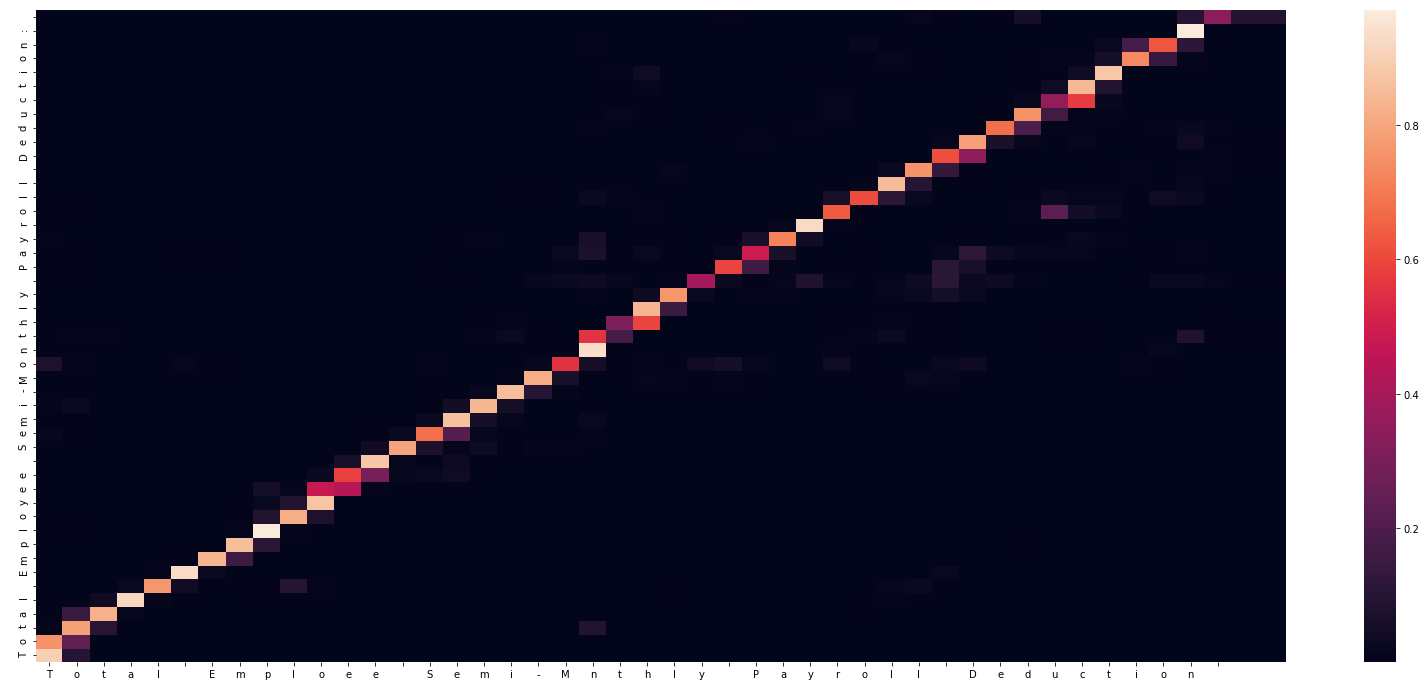

-
Input sentence: Total Emploee Semi-Mnthly Payroll Deduction

GT sentence: Total Employee Semi-Monthly Payroll Deduction:

Decoded sentence: Total Employee Semi-Monthly Payroll Deduction:



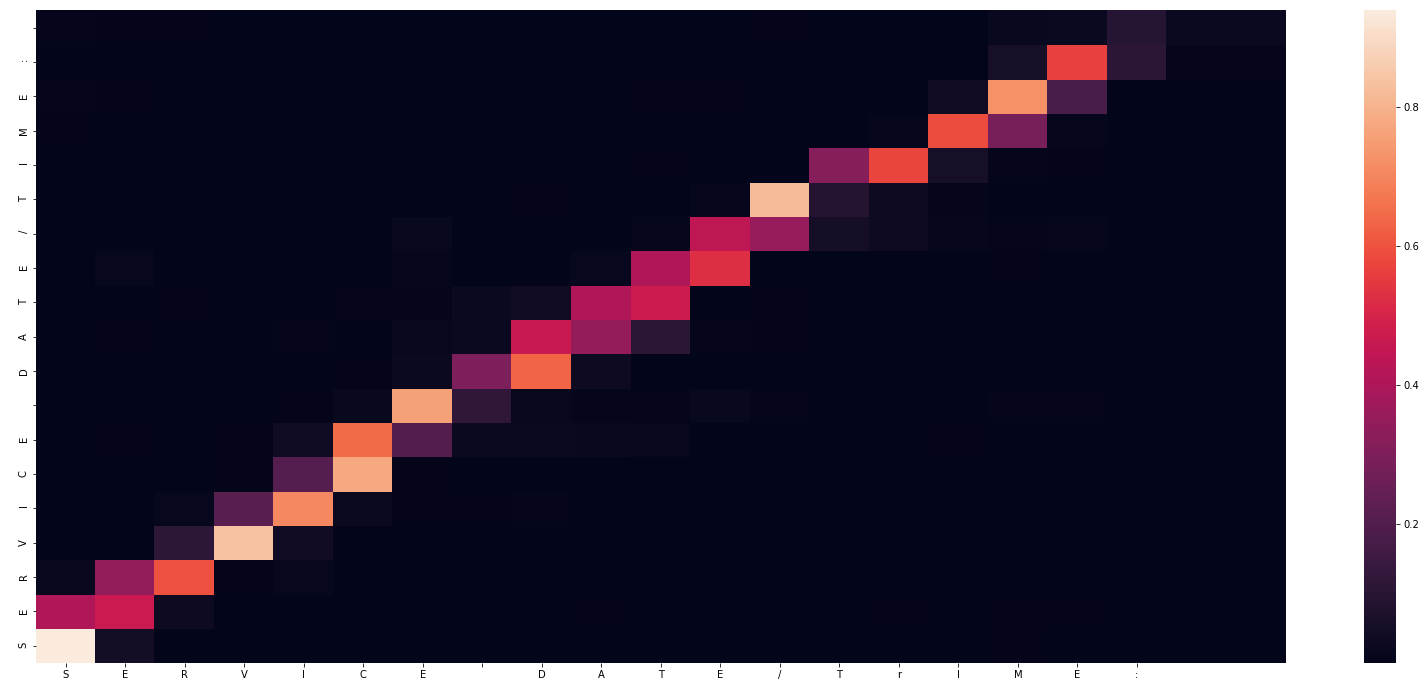

-
Input sentence: SERVICE DATE/TrIME:
GT sentence: SERVICE DATE/TIME:

Decoded sentence: SERVICE DATE/TIME:



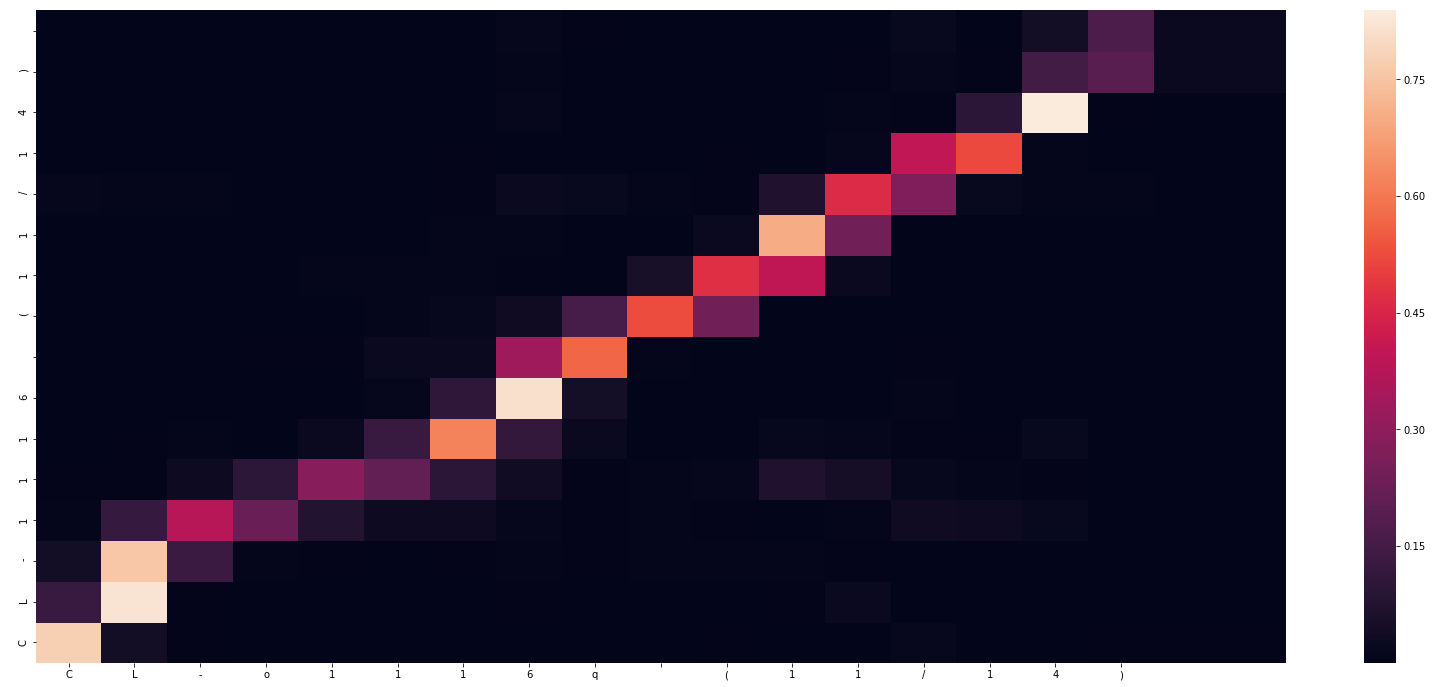

-
Input sentence: CL-o1116q (11/14)
GT sentence: CL-1116 (11/14)

Decoded sentence: CL-1116 (11/14)



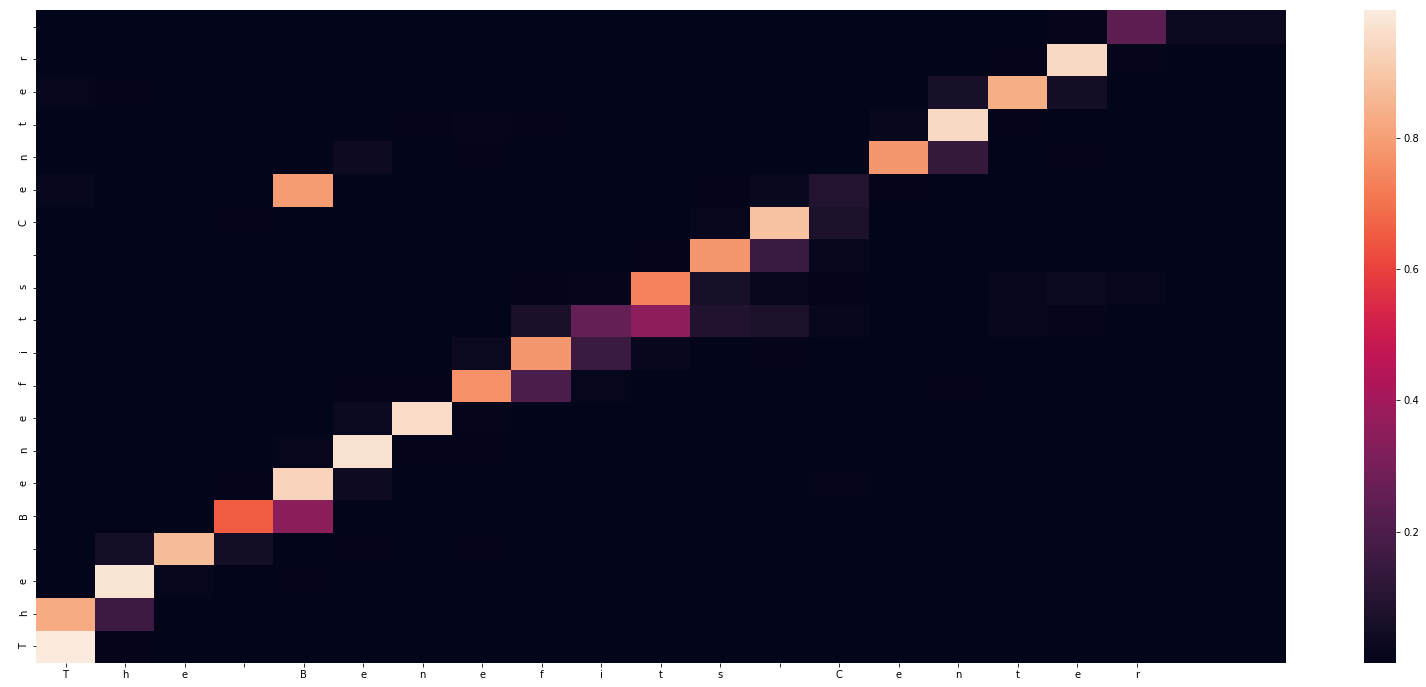

-
Input sentence: The Benefits Center
GT sentence: The Benefits Center

Decoded sentence: The Benefits Center



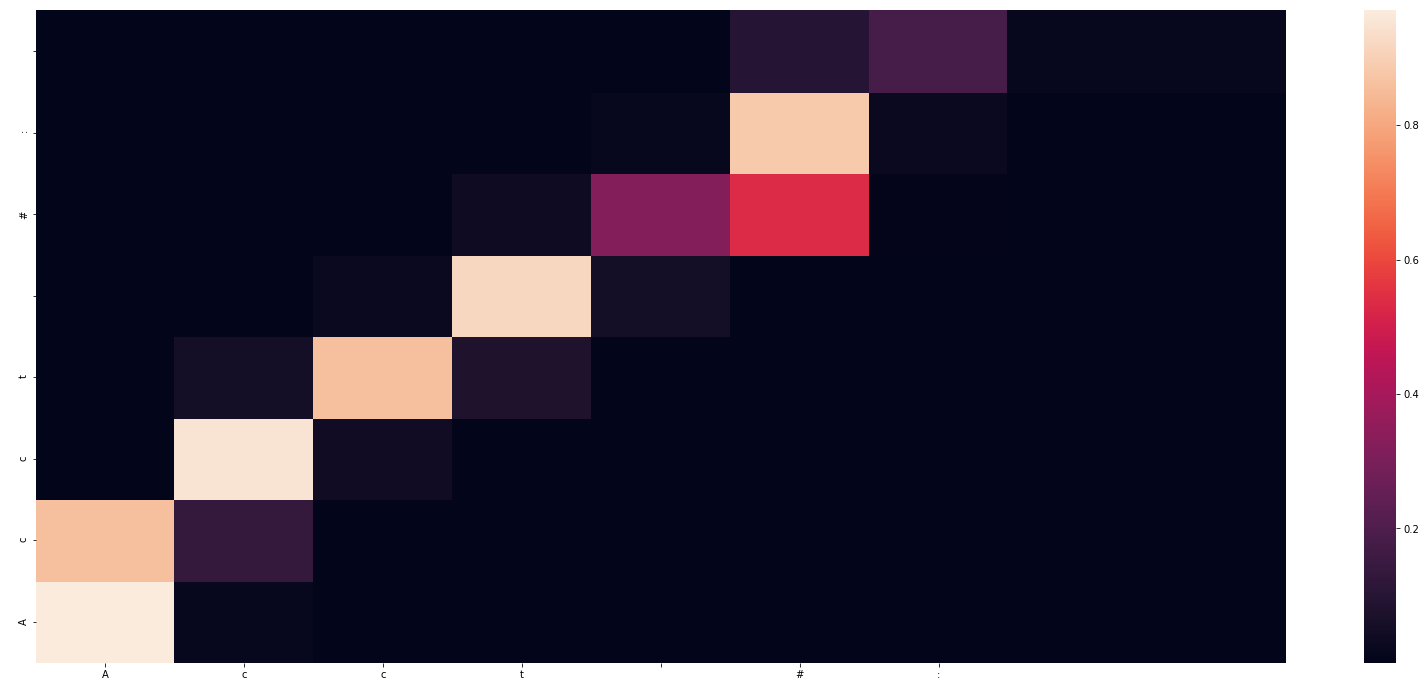

-
Input sentence: Acct #:
GT sentence: Acct #:

Decoded sentence: Acct #:



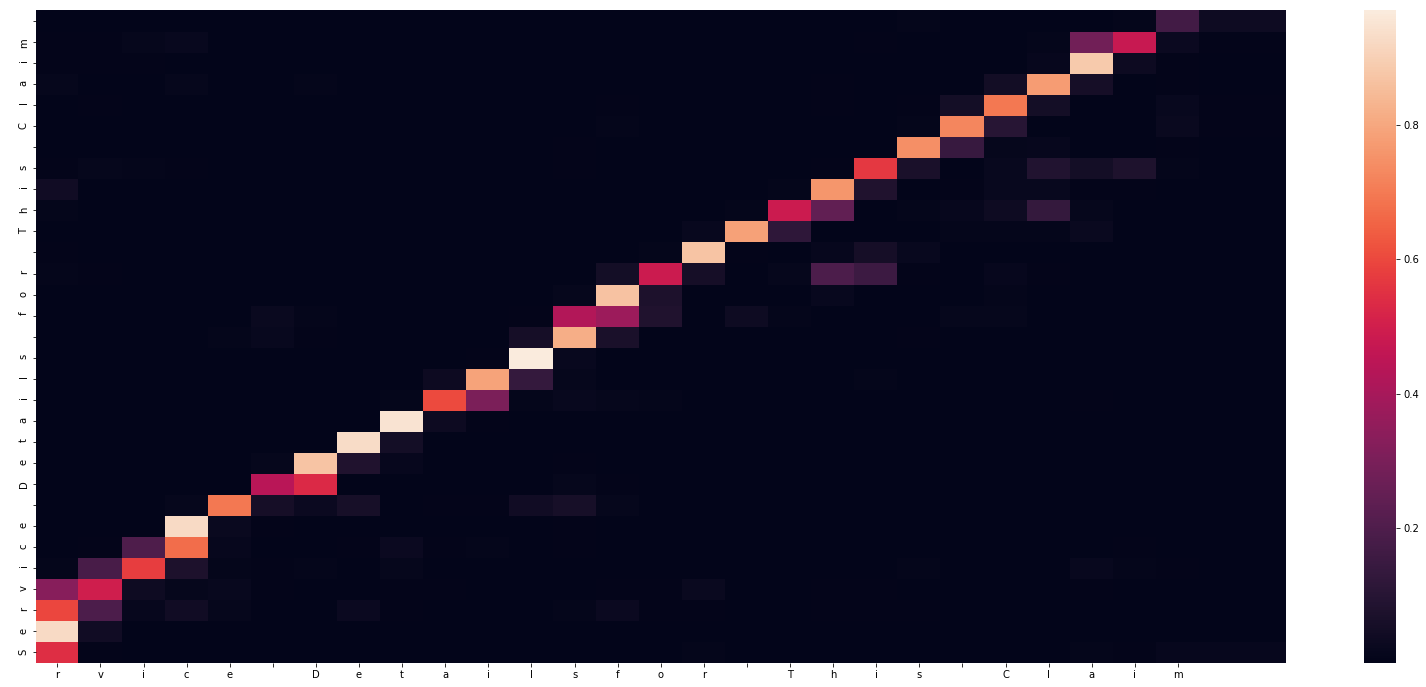

-
Input sentence: rvice Detailsfor This Claim
GT sentence: Service Details for This Claim

Decoded sentence: Service Details for This Claim



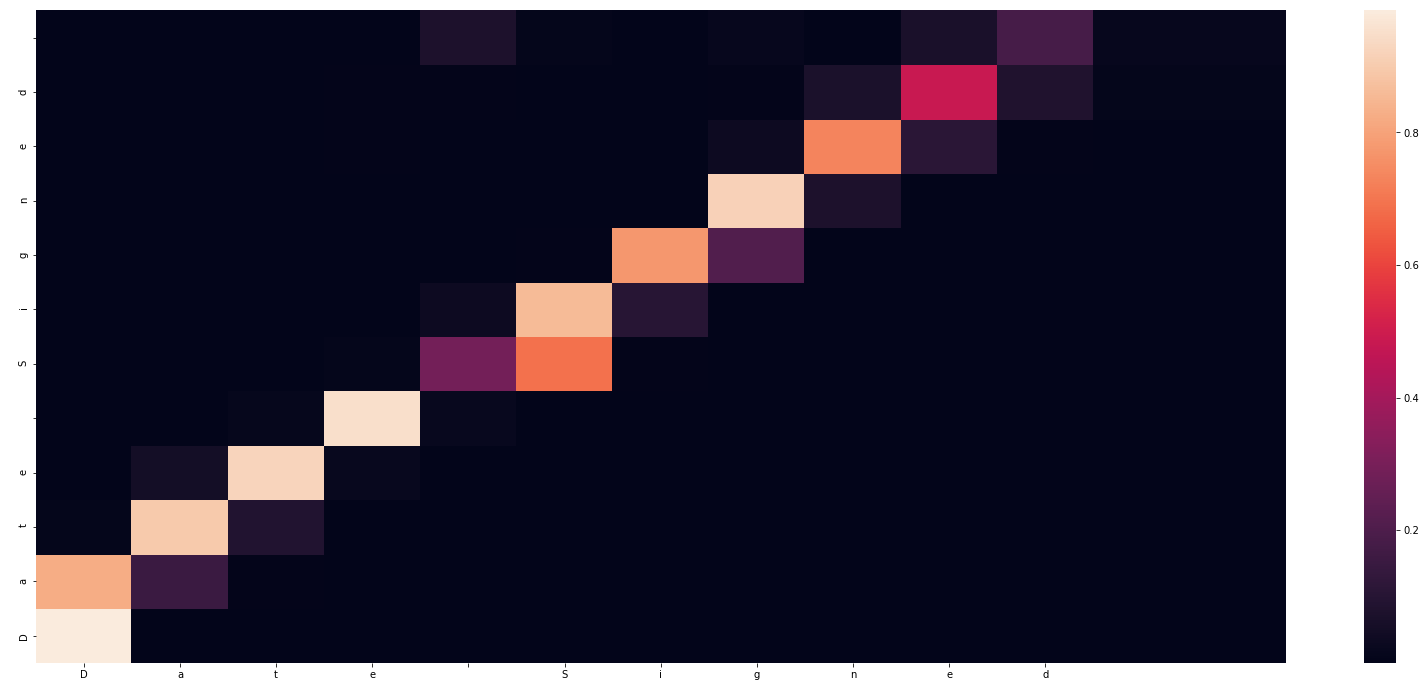

-
Input sentence: Date Signed
GT sentence: Date Signed

Decoded sentence: Date Signed



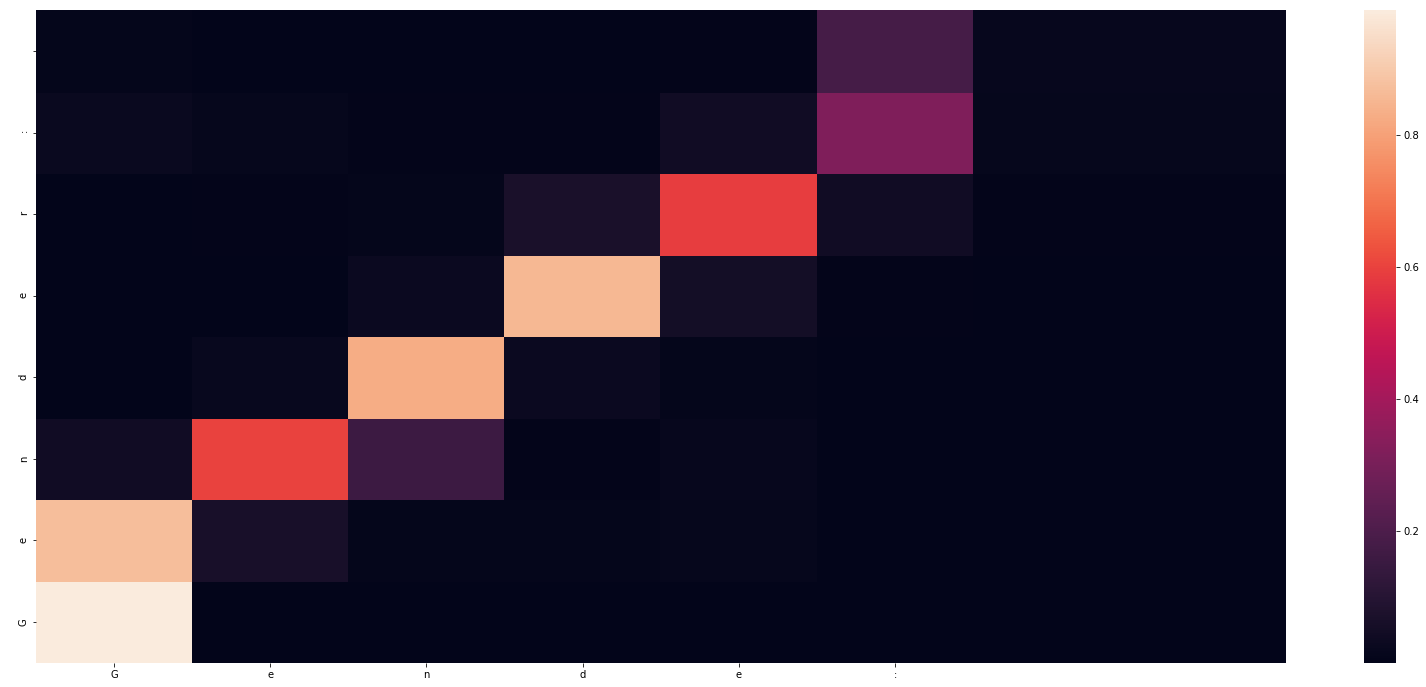

-
Input sentence: Gende:
GT sentence: Gender:

Decoded sentence: Gender:



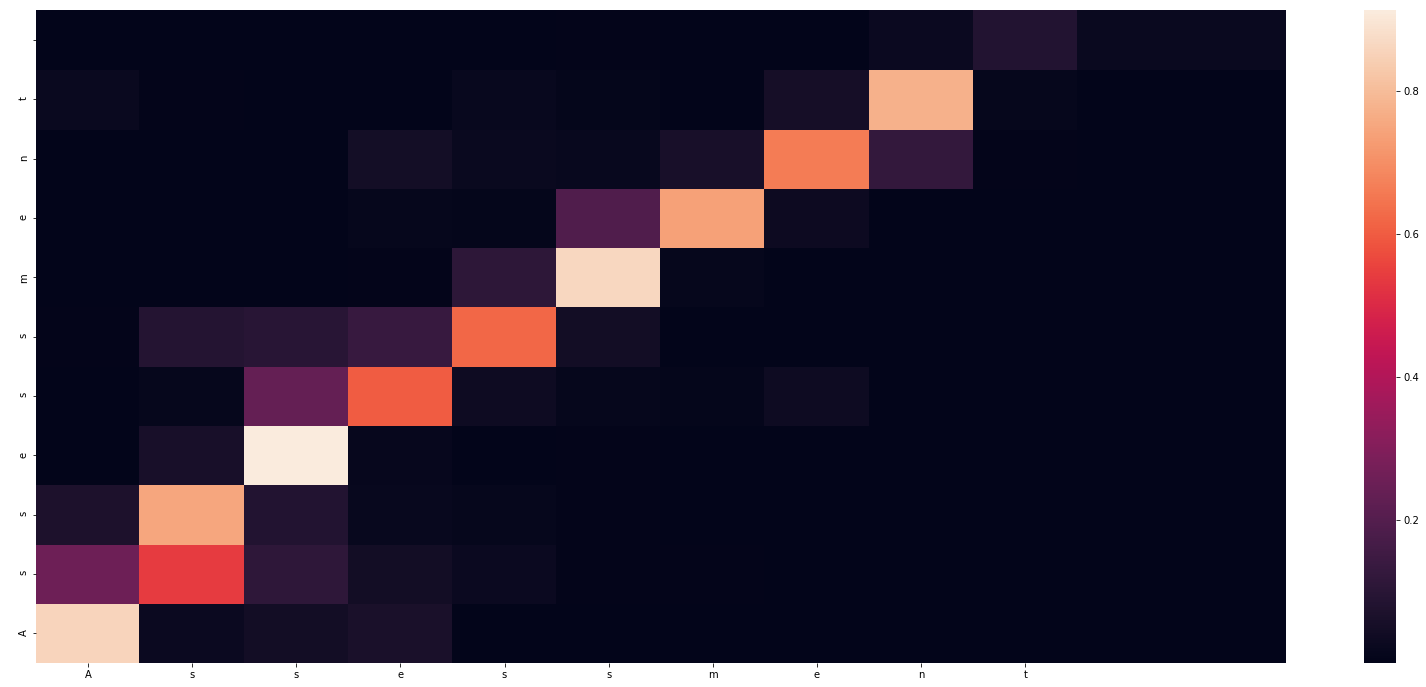

-
Input sentence: Assessment
GT sentence: Assessment

Decoded sentence: Assessment



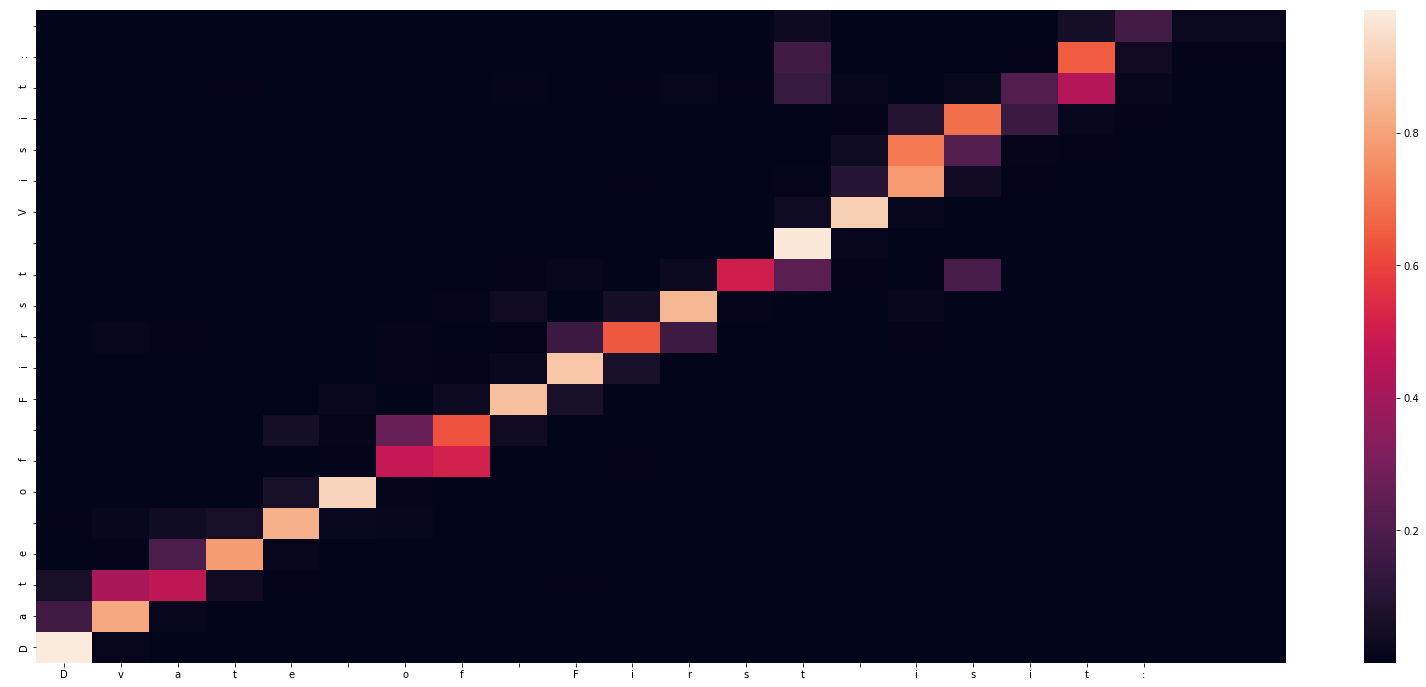

-
Input sentence: Dvate of First isit:
GT sentence: Date of First Visit:

Decoded sentence: Date of First Visit:



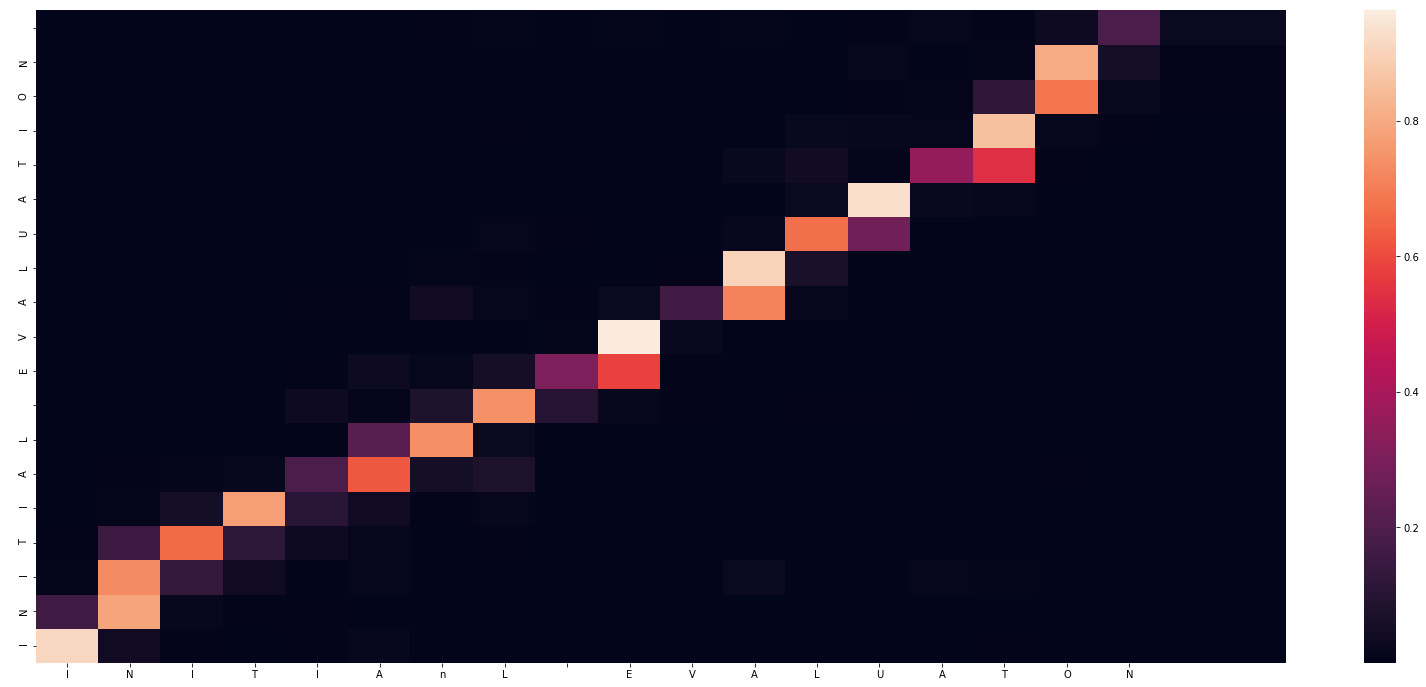

-
Input sentence: INITIAnL EVALUATON
GT sentence: INITIAL EVALUATION

Decoded sentence: INITIAL EVALUATION



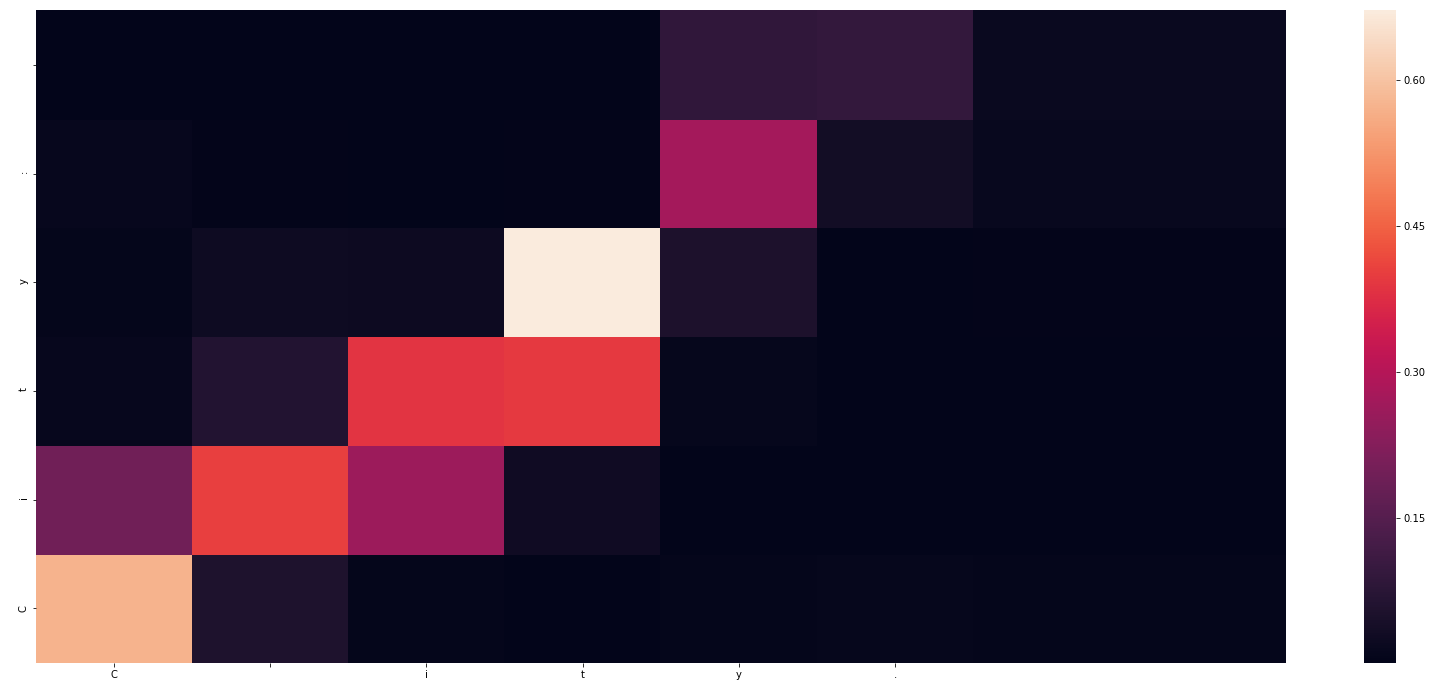

-
Input sentence: C ity.
GT sentence: City:

Decoded sentence: City:



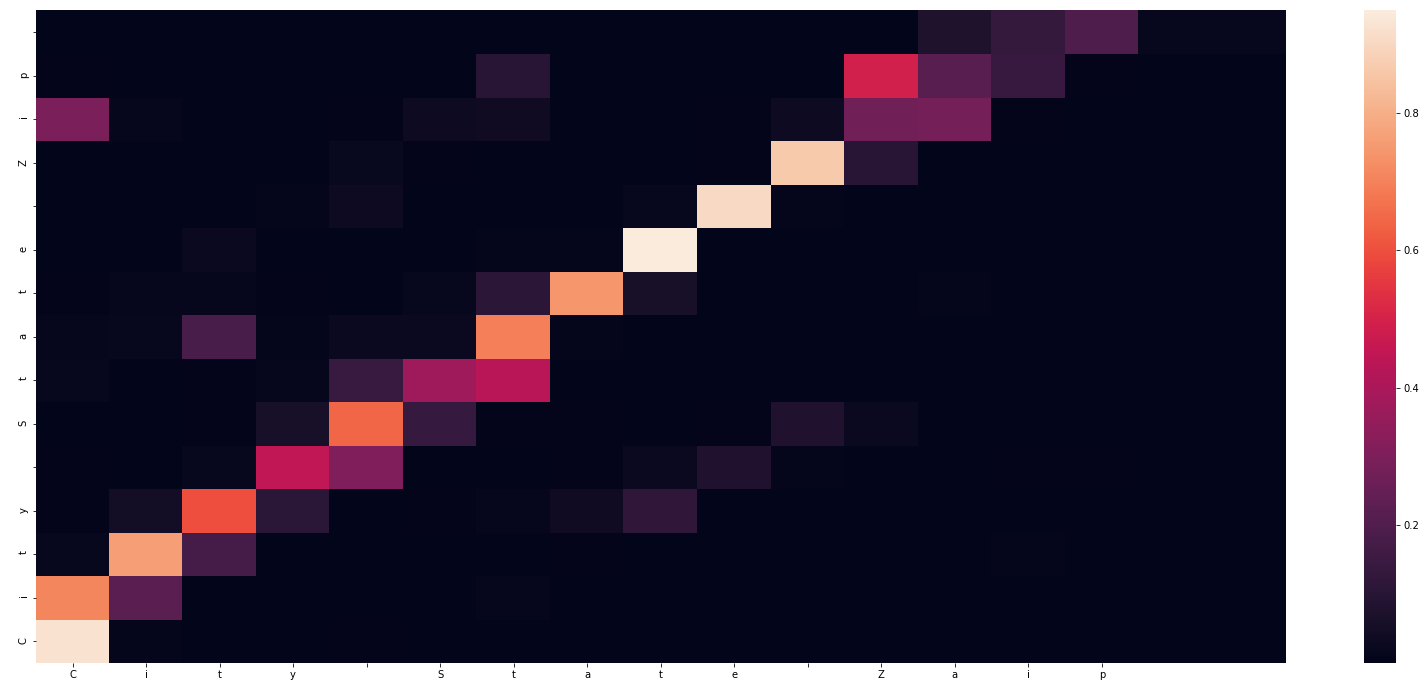

-
Input sentence: City State Zaip
GT sentence: City State Zip

Decoded sentence: City State Zip



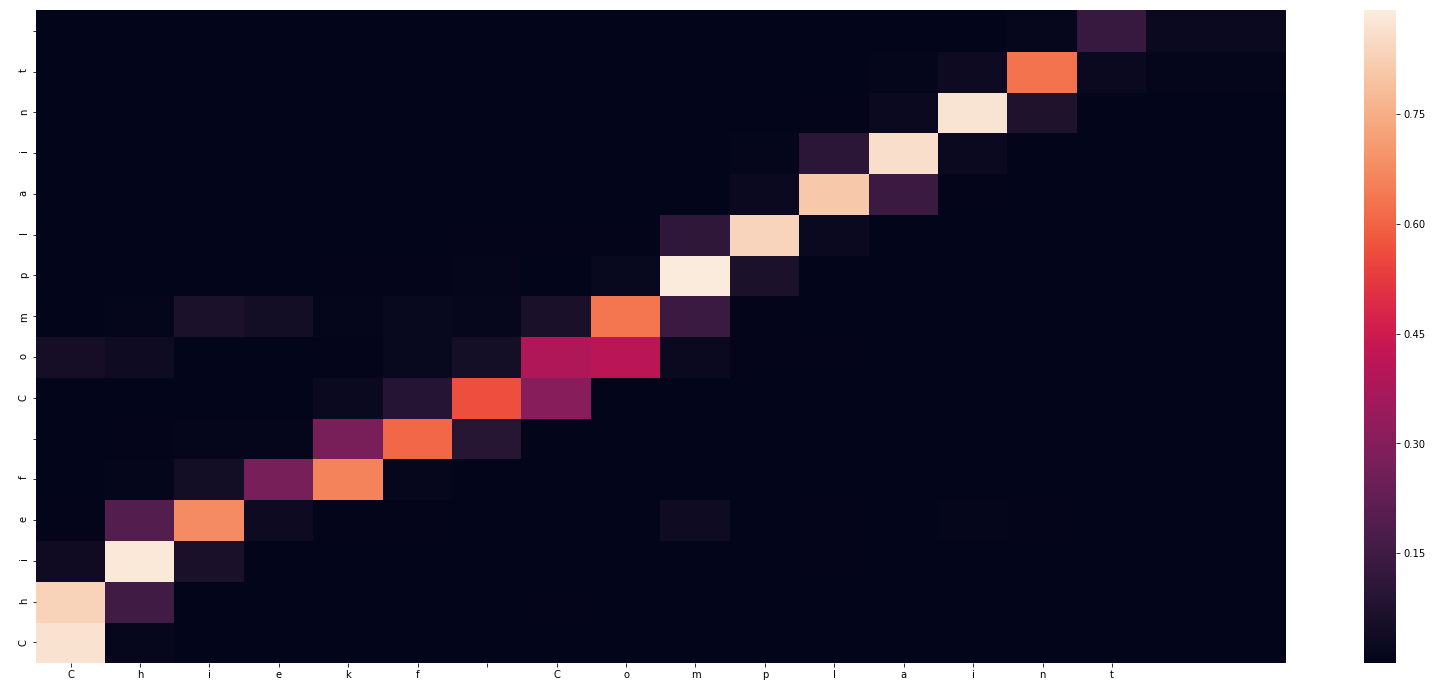

-
Input sentence: Chiekf Complaint
GT sentence: Chief Complaint

Decoded sentence: Chief Complaint



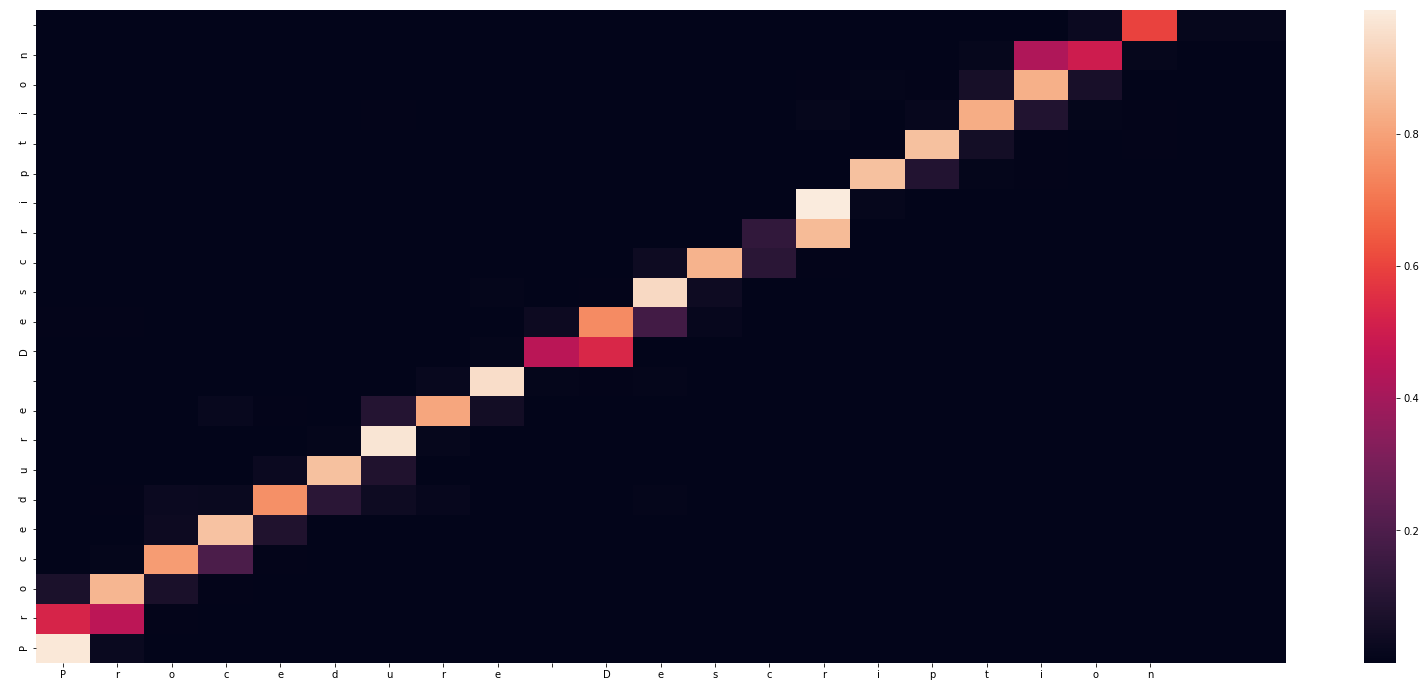

-
Input sentence: Procedure Description
GT sentence: Procedure Description

Decoded sentence: Procedure Description



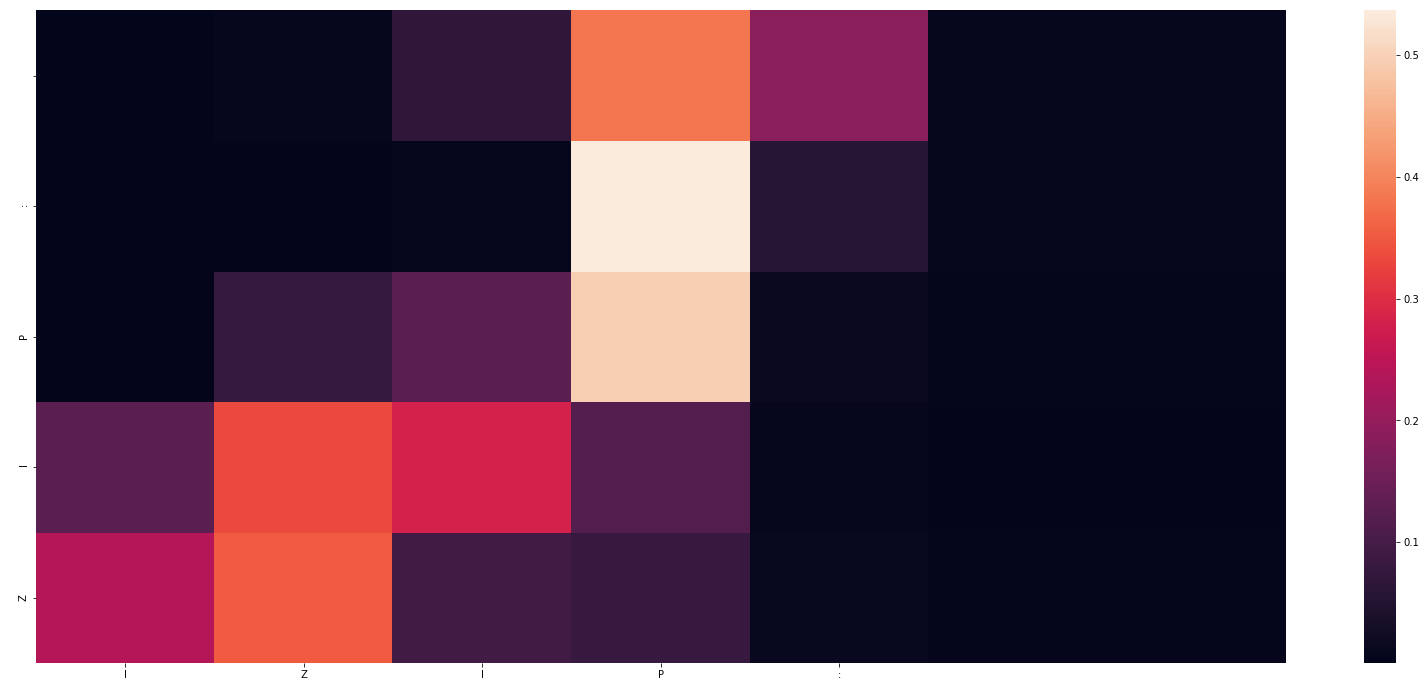

-
Input sentence: lZIP:
GT sentence: ZIP:

Decoded sentence: ZIP:



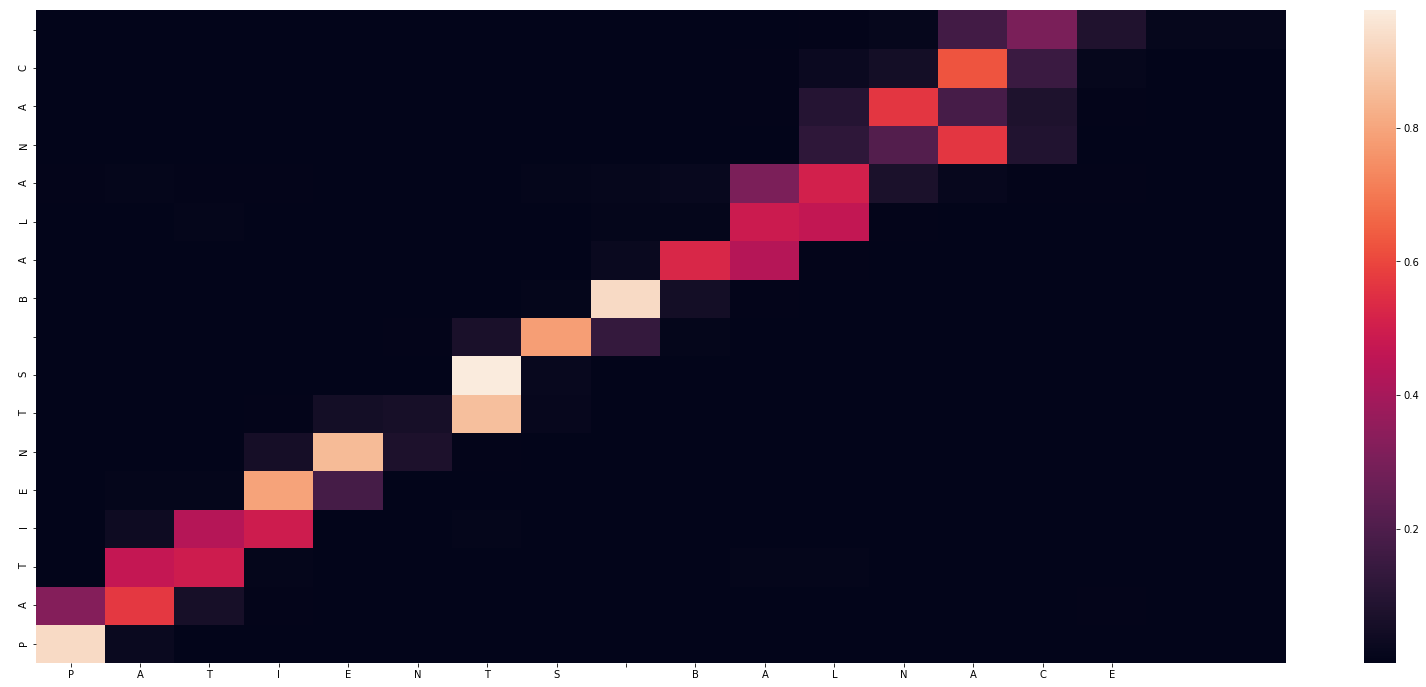

-
Input sentence: PATIENTS BALNACE
GT sentence: PATIENTS BALANCE

Decoded sentence: PATIENTS BALANAC



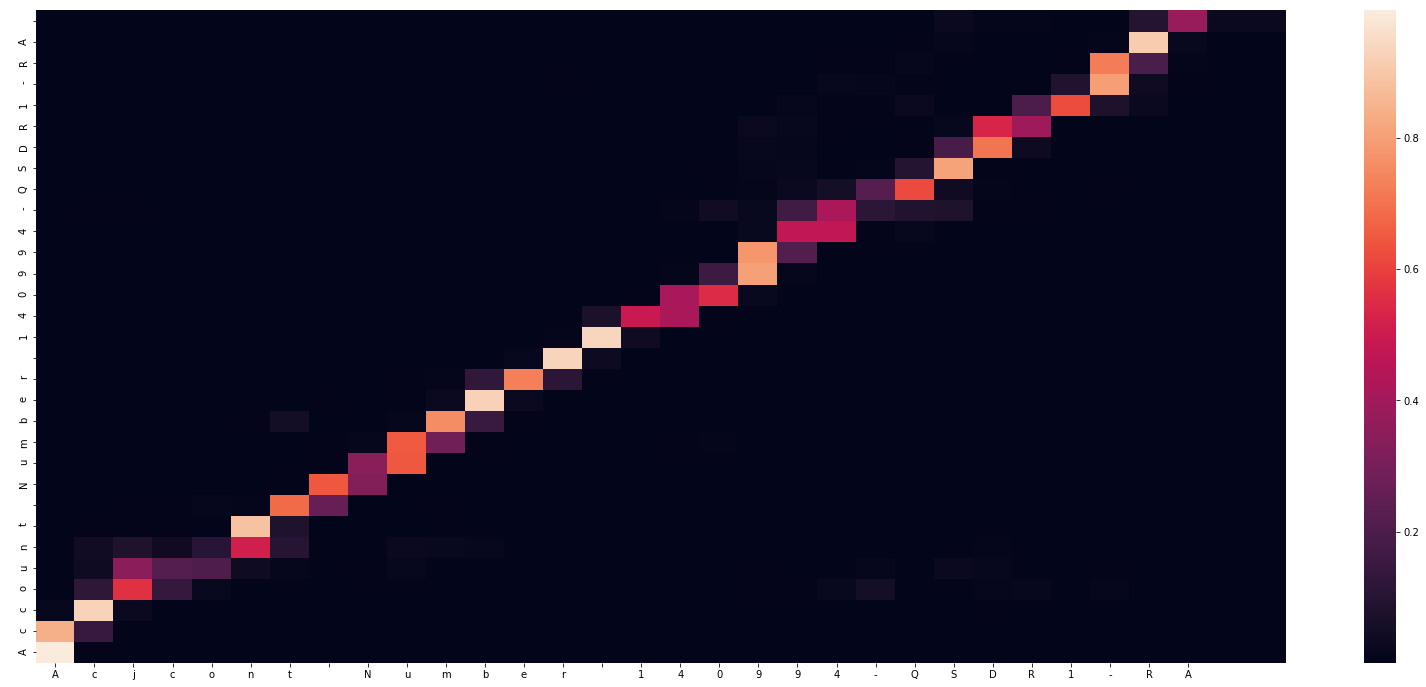

-
Input sentence: Acjcont Number 140994-QSDR1-RA
GT sentence: Account Number 140994-QSDR1-RA

Decoded sentence: Account Number 140994-QSDR1-RA



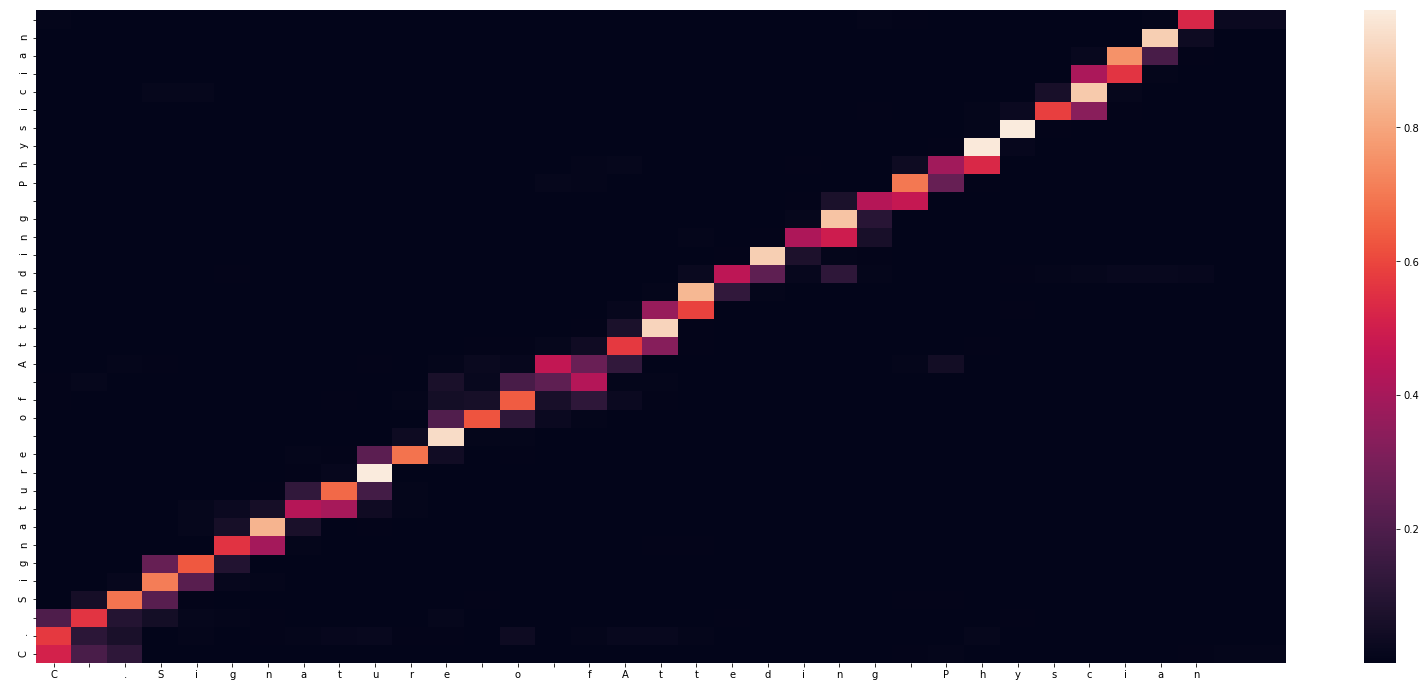

-
Input sentence: C .Signature o fAtteding Physcian
GT sentence: C. Signature of Attending Physician

Decoded sentence: C. Signature of Attending Physician



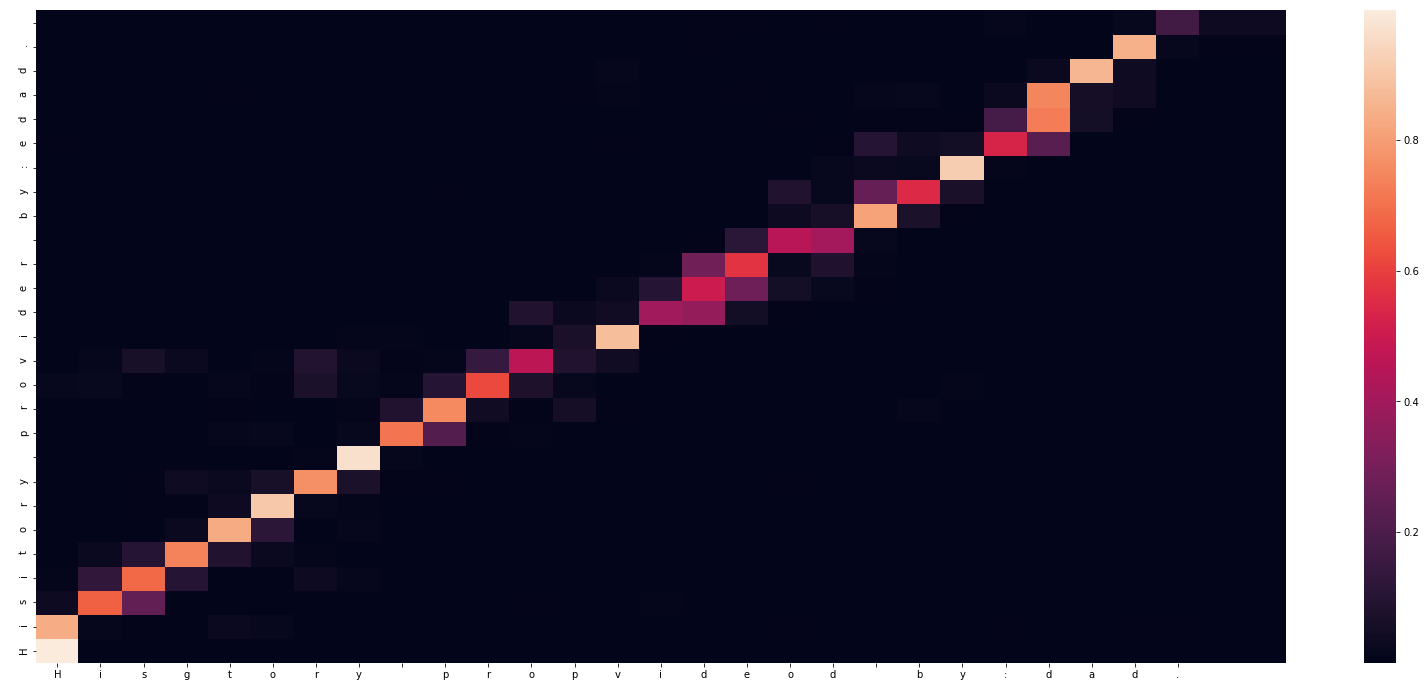

-
Input sentence: Hisgtory propvideod by:dad.
GT sentence: History provided by: dad.

Decoded sentence: Hisitory provider by:edad.



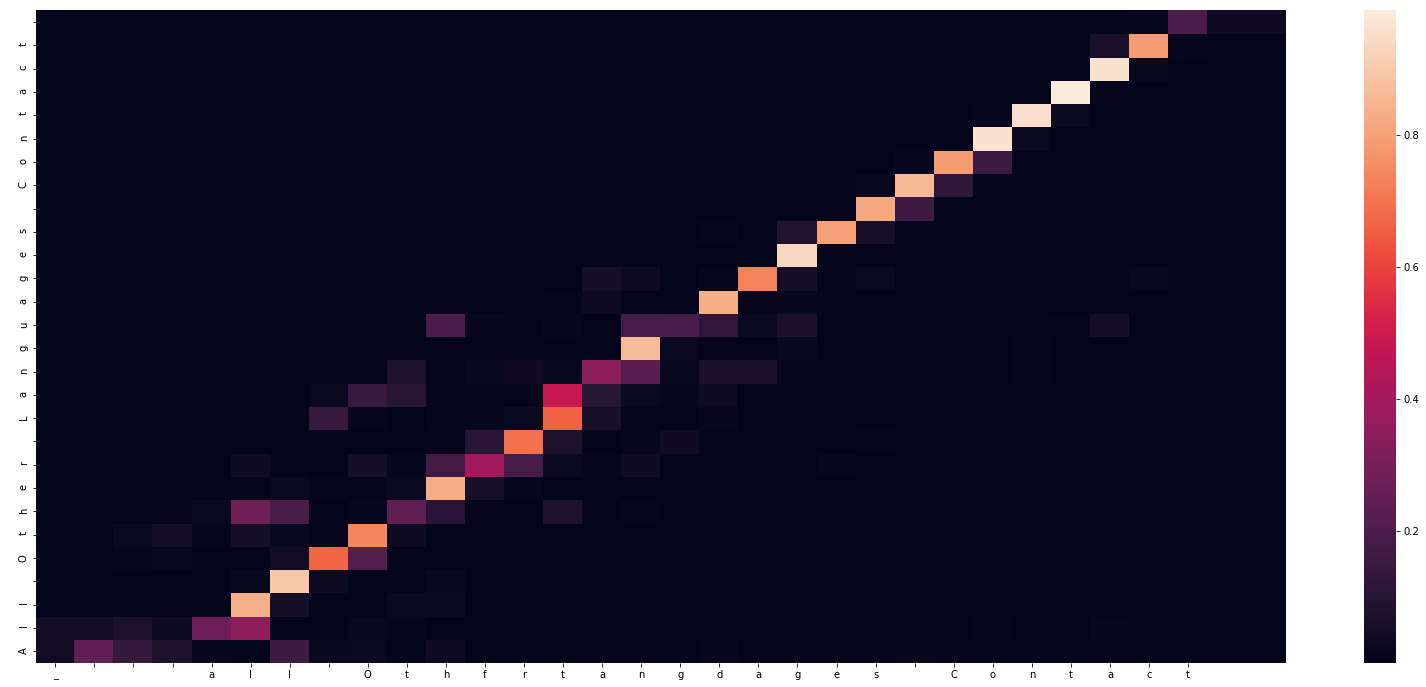

-
Input sentence: _ ‘ all Othfrtangdages Contact
GT sentence: All Other Languages Contact

Decoded sentence: All Other Languages Contact



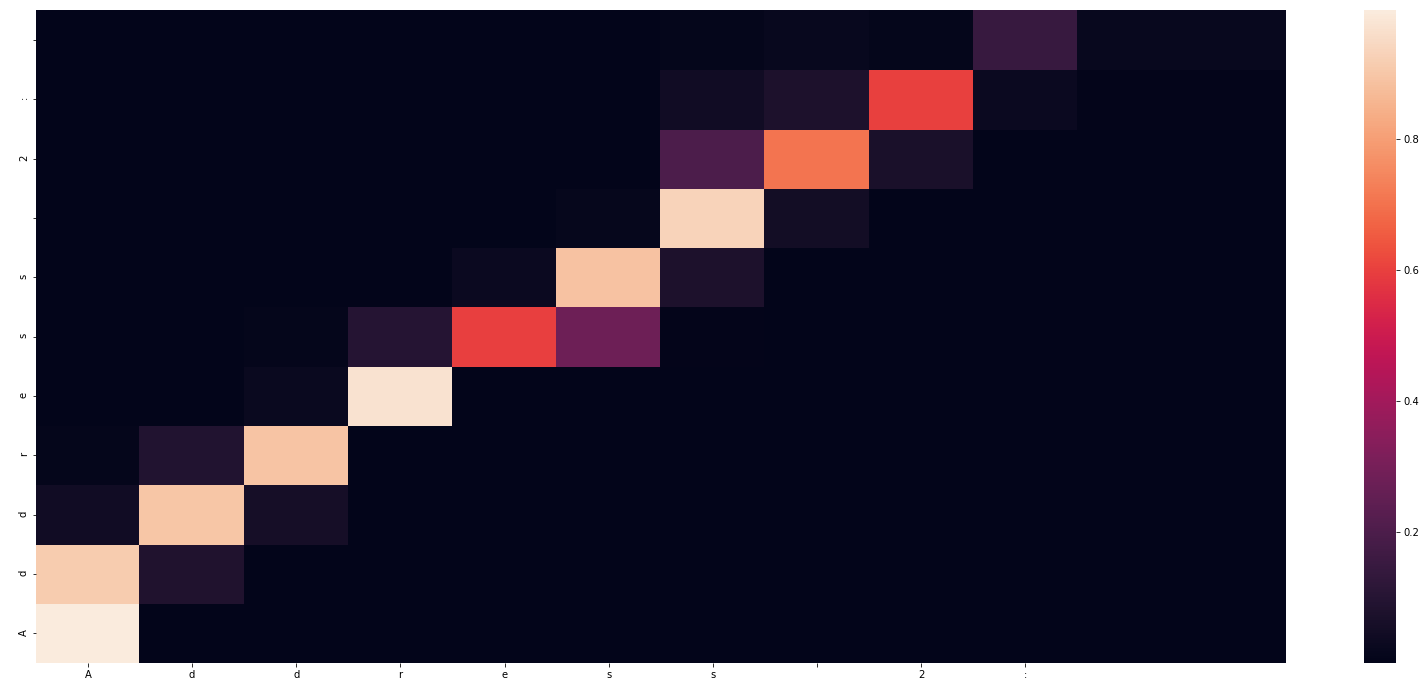

-
Input sentence: Address 2:
GT sentence: Address 2:

Decoded sentence: Address 2:



In [57]:
for seq_index in range(100):

    target_text = target_texts[seq_index][1:-1]
    text = input_texts[seq_index]
    decoded_sentence = visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, vocab_to_int, int_to_vocab)
    print('-')
    print('Input sentence:', text)
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   


In [ ]:
#WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
#print('WER_spell_correction |TRAIN= ', WER_spell_correction)

In [ ]:
# Sample output from test data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(len(test_input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = test_encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence, _ = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = test_target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', test_input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)

-
Input sentence: Ter Date:
GT sentence: Term Date:

Decoded sentence: Ter Date:

-
Input sentence: PART I: xTO BE COMPLEwTED BY IzNSURExDP/ATIENT
GT sentence: PART I: TO BE COMPLETED BY INSURED/PATIENT

Decoded sentence: PART I: TO BLETED BY IMPLETED BY INSURED PATIENT

-
Input sentence: PATIET BALANCE
GT sentence: PATIENT BALANCE

Decoded sentence: PATIENT BALANCE

-
Input sentence: nEE Nam:e
GT sentence: EE Name:

Decoded sentence: EE Name:

-
Input sentence: Pﬁnreo Name _ ocia ecuri y um er
GT sentence: Printed Name Social Security Number

Decoded sentence: Painer Name Social cecuriey y

-
Input sentence: Providen'Facility: ProMedicn Tole do Hospital
GT sentence: Provider/Facility: ProMedica Toledo Hospital

Decoded sentence: Provider: Facility: ProMedicinoly Hospital

-
Input sentence: Page 2
GT sentence: Page 2

Decoded sentence: Page 2

-
Input sentence: Al Octhero Langaugse Contact
GT sentence: All Other Languages Contact

Decoded sentence: Al Other Languages Contact

-
Input s

-
Input sentence: Penobscot Community Helath Center
GT sentence: Penobscot Community Health Center

Decoded sentence: Penobscot Community Health Center

-
Input sentence: Customer Policy #:
GT sentence: Customer Policy #:

Decoded sentence: Customer Policy #:

-
Input sentence: CLINICAL HISTORY:
GT sentence: CLINICAL HISTORY:

Decoded sentence: CLINICAL HISTORY:

-
Input sentence: Exam Date:
GT sentence: Exam Date:

Decoded sentence: Exam Date:

-
Input sentence: Total Monthly Premium:
GT sentence: Total Monthly Premium:

Decoded sentence: Total Monthly Premium:

-
Input sentence: City State Zip
GT sentence: City State Zip

Decoded sentence: City State Zip

-
Input sentence: Expected Delivery Dene: (mmrrinim tmrnin diyy)
GT sentence: Expected Delivery Date: (mm/dd/yy)

Decoded sentence: Expected Delivery Dene: (mm/drim ty)

-
Input sentence: Patienh:
GT sentence: Patient:

Decoded sentence: Patient:

-
Input sentence: rMembfer No:
GT sentence: Member No:

Decoded sentence: Member No:



-
Input sentence: ENCOUNTER FOR WlTH
GT sentence: ENCOUNTER FOR WITH

Decoded sentence: ENCOUNTER FOR WITH

-
Input sentence: CL-1116( 11/14)
GT sentence: CL-1116 (11/14)

Decoded sentence: CL-1116 (11/14)

-
Input sentence: Always 67-010%
GT sentence: Always 67-100%

Decoded sentence: Always 67-10%

-
Input sentence: Social cSecrity umber
GT sentence: Social Security Number:

Decoded sentence: Social Security Number

-
Input sentence: Provider Last Name: Emwerston
GT sentence: Provider Last Name: Emerson

Decoded sentence: Provider Last Name: Emerston

-
Input sentence: uPlse rate: 70 / mintute
GT sentence: Pulse rate: 70 / minute

Decoded sentence: Plosee rate: 70 / mintture

-
Input sentence: Allergie
GT sentence: Allergies

Decoded sentence: Allergies

-
Input sentence: State/Province:
GT sentence: State/Province:

Decoded sentence: State/Province:

-
Input sentence: MINNESOTA tVALLEY SURGER CENTER
GT sentence: MINNESOTA VALLEY SURGERY CENTER

Decoded sentence: MINNESOTA VALLEY SUR

-
Input sentence: Surgery Infomationa
GT sentence: Surgery Information

Decoded sentence: Surgery Information

-
Input sentence: Fax paperwork - yes
GT sentence: Fax paperwork - yes

Decoded sentence: Fax paperwork - yes

-
Input sentence: Staet/Provice :
GT sentence: State/Province :

Decoded sentence: State/Province:

-
Input sentence: Irmatienthutpatient Indicator: Outpatient
GT sentence: Inpatient/Outpatient Indicator: Outpatient

Decoded sentence: Inpatient/Outpatient Indicator: Outpatient

-
Input sentence: Access
GT sentence: Access

Decoded sentence: Access

-
Input sentence: Cmsmr Sweetnfomatwni
GT sentence: Customer Service Information

Decoded sentence: Clsmr Servine Information

-
Input sentence: Wbsiet: ymFirstChoice.fcahn.xcm
GT sentence: Website: myFirstChoice.fchn.com

Decoded sentence: Website y First Choice.fchn.cm

-
Input sentence: Spouse Wellness BenfeitJuly u1, 2017
GT sentence: Spouse Wellness Benefit July 1, 2017

Decoded sentence: Spouse Wellness Benefit July 1

-
Input sentence: Spous On & Off-Job Acc Janaur 1, 2017
GT sentence: Spouse On & Off-Job Acc January 1, 2017

Decoded sentence: Spouse On & Off-Job Acc January 1, 2017

-
Input sentence: Bitrh Date:
GT sentence: Birth Date:

Decoded sentence: Birth Date:

-
Input sentence: Knee Exam
GT sentence: Knee Exam

Decoded sentence: Knee Exam

-
Input sentence: Home: (
GT sentence: Home: (

Decoded sentence: Home: (

-
Input sentence: Soicia Security Number
GT sentence: Social Security Number

Decoded sentence: Social Security Number

-
Input sentence: Preferred language is English.
GT sentence: Preferred language is English.

Decoded sentence: Preferred language is English.

-
Input sentence: Home per day
GT sentence: Hours per day

Decoded sentence: Home per day

-
Input sentence: l:lShUiL Term Disability
GT sentence: Short Term Disability

Decoded sentence: Sp. OUL Disability

-
Input sentence: Service Date:
GT sentence: Services Date:

Decoded sentence: Service Date:

-
Input sentence: Ther

-
Input sentence: E-mai:l
GT sentence: E-mail:

Decoded sentence: E-mail:

-
Input sentence: Authe'C-ert Status Incompiete
GT sentence: Auth/Cert Status Incomplete

Decoded sentence: AutheC Cert Status Incompite

-
Input sentence: Custome Policy #:
GT sentence: Customer Policy #:

Decoded sentence: Customer Policy #:

-
Input sentence: Expected Delivery Date: (mmlddlyy) 
GT sentence: Expected Delivery Date: (mm/dd/yy)

Decoded sentence: Expected Delivery Date: (mm/dd/yy) 

-
Input sentence: . Appeals Rights
GT sentence: Appeals Rights

Decoded sentence: Appeals Rights

-
Input sentence: Midddle Name/Initial:
GT sentence: Middle Name/Initial:

Decoded sentence: Middle Name/Initial:

-
Input sentence: Electromcally Signed Indicator: Yes
GT sentence: Electronically Signed Indicator: Yes

Decoded sentence: Electronically Signed Indicator: Yes

-
Input sentence: Last Name:
GT sentence: Last Name:

Decoded sentence: Last Name:

-
Input sentence: Gender Male Fefmale
GT sentence: Gender Male F

-
Input sentence: THAFK 200 
GT sentence: THANK YOU

Decoded sentence: THAFK 200 

-
Input sentence: PROCEDRUE MODIFIER
GT sentence: PROCEDURE MODIFIER

Decoded sentence: PROCEDURE MODIFIER

-
Input sentence: Employee Ocf-fuJb AccJ une 18, 201m
GT sentence: Employee Off-Job Acc June 18, 2012

Decoded sentence: Employee Off-Job Acc June 18, 2018

-
Input sentence: Last Name:
GT sentence: Last Name:

Decoded sentence: Last Name:

-
Input sentence: ProviderFirst Name: Souha
GT sentence: Provider First Name: Souha

Decoded sentence: Provider First Name: Souha

-
Input sentence: 15 SIII‘HED" Required:
GT sentence: Is Surgery Required: Unknown

Decoded sentence: Sury HED Required:

-
Input sentence: rPovider Firs Nm: MICHAEL
GT sentence: Provider First Name: MICHAEL

Decoded sentence: Provider Firs No: MICHALE

-
Input sentence: zTEMPERATURE/PULSE/RESPIRATION
GT sentence: TEMPERATURE/PULSE/RESPIRATION

Decoded sentence: STEMPERATURE/PULSE/RESPRIST

-
Input sentence: Scribe - Statements
GT se

-
Input sentence: Fazx Number 
GT sentence: Fax Number 

Decoded sentence: Fax Number 

-
Input sentence: Emplboyoee’ sWork r& Off oWrk Restrictions
GT sentence: Employee’s Work & Off Work Restrictions

Decoded sentence: Employee’s Work ourk of 5 of Atrictions

-
Input sentence: TM/MODL
GT sentence: DTM/MODL

Decoded sentence: TMMOLD CODL

-
Input sentence: FlRST NAME:
GT sentence: FIRST NAME:

Decoded sentence: FREST NAME:

-
Input sentence: 3) Zithromax (azithromycin) (moderate)
GT sentence: 3) Zithromax (azithromycin) (moderate)

Decoded sentence: 3) Zithromax (azithromycin) (moderate)

-
Input sentence: Paramount Paid:
GT sentence: Paramount Paid:

Decoded sentence: Paramount Paid:

-
Input sentence: Soical Sceunrity Number
GT sentence: Social Security Number

Decoded sentence: Social Security Number

-
Input sentence: Summary 0% Today's Visit
GT sentence: Summary Of Today’s Visit

Decoded sentence: Summary Of Today's Visit

-
Input sentence: rConfinehment Dagtes:(mm/dd/yy) to( m/d

-
Input sentence: Spouse Wellness Benefiott May 1,2 051
GT sentence: Spouse Wellness Benefit May 1, 2015

Decoded sentence: Spouse Wellness Benefit May 1, 2015

-
Input sentence: Fax:b
GT sentence: Fax:

Decoded sentence: Fax:

-
Input sentence: Patient:
GT sentence: Patient:

Decoded sentence: Patient:

-
Input sentence: Nceuroogic -. DTR oralv. Sensaion intac.
GT sentence: Neurologic -. DTR normal. Sensation intact.

Decoded sentence: Necurorogic -. DTR oral, Sensart intac.

-
Input sentence: If yes, what is the relatyionship?
GT sentence: If yes, what is the relationship?

Decoded sentence: If yes, what is the relationship?

-
Input sentence: TotalM onthyl Premium:
GT sentence: Total Monthly Premium:

Decoded sentence: Total Monthly Premium:

-
Input sentence: Currentevery day smoker Cigarettes
GT sentence: Current every day smoker, Cigarettes

Decoded sentence: Currentevery day smoker Cigarettes

-
Input sentence: Claimg Event Identiﬁe:r 2667305
GT sentence: Claim Event Identiﬁer: 

-
Input sentence: Best time to call: morning
GT sentence: Best time to call: morning

Decoded sentence: Best time to call: morning

-
Input sentence: Summay of Charges
GT sentence: Summary of Charges

Decoded sentence: Summay of Charges

-
Input sentence: Spouse WellnessBenfei tJuly 1, 2017
GT sentence: Spouse Wellness Benefit July 1, 2017

Decoded sentence: Spouse Wellness Benefit July 1, 2017

-
Input sentence: PATIENT iii. PATIENT NAME
GT sentence: PATIENT # PATIENT NAME

Decoded sentence: PATIENT DATE PAIMENT NAME

-
Input sentence: Physician’ Tax ID Number:
GT sentence: Physician’s Tax ID Number:

Decoded sentence: Physician Tax ID Number:

-
Input sentence: M79676c m?
GT sentence: M79676 ?

Decoded sentence: M79676 ?

-
Input sentence: From: WorkeWll @ SMM
GT sentence: From: WorkWell @ SMMC

Decoded sentence: From: WorkWell @ SMM

-
Input sentence: Howard Rose,MD
GT sentence: Howard Rose, MD

Decoded sentence: Howard Rose, MD

-
Input sentence: nonTTP along the medial joint line.

-
Input sentence: Accident Work Related: No
GT sentence: Accident Work Related: No

Decoded sentence: Accident Work Related: No

-
Input sentence: Diagnoiss
GT sentence: Diagnosis

Decoded sentence: Diagnosis

-
Input sentence: Allergies
GT sentence: Allergies

Decoded sentence: Allergies

-
Input sentence: [la a -
GT sentence: Date

Decoded sentence: On 1 -

-
Input sentence: Afteer Tax:0 000
GT sentence: After Tax: 0 000

Decoded sentence: After Tax::0 00

-
Input sentence: Pmatient Name:
GT sentence: Patient Name:

Decoded sentence: Patient Name:

-
Input sentence: Medical eRcod Nmuber 
GT sentence: Medical Record Number: 

Decoded sentence: Medical Requode Number 

-
Input sentence: Middle Naem/Initial:
GT sentence: Middle Name/Initial:

Decoded sentence: Middle Nam//Initial:

-
Input sentence: Tteating Physician Name
GT sentence: Treating Physician Name

Decoded sentence: Tetating Physician Name

-
Input sentence: Deductibl

GT sentence: Deductible

Decoded sentence: Deductible

-

-
Input sentence: Hone Telephone:
GT sentence: Home Telephone:

Decoded sentence: Hone Telephone:

-
Input sentence: ACCT. # EMA29728
GT sentence: ACCT. # EMA297282

Decoded sentence: ACCT # EMA29728

-
Input sentence: RDW~CV — 12.70 Range: 11504.5 .. %
GT sentence: • RDW-CV - 12.70 Range: 11.5-04.5 - %

Decoded sentence: • RDW-CV - 12.70 Range: 115-5.5 -.m.

-
Input sentence: Adydress
GT sentence: Address

Decoded sentence: Address

-
Input sentence: Socral Security Number
GT sentence: Social Security Number

Decoded sentence: Social Security Number

-
Input sentence: Accident Date:
GT sentence: Accident Date:

Decoded sentence: Accident Date:

-
Input sentence: Employm em In formation
GT sentence: Employment Information

Decoded sentence: Employment Information

-
Input sentence: Address Line 1:
GT sentence: Address Line 1:

Decoded sentence: Address Line 1:

-
Input sentence: Neuroogi - Smensatfion intact.
GT sentence: Neurologic -. Sensation intact.

Decoded sentence: Neurologic - 

-
Input sentence: Exam Date:
GT sentence: Exam Date:

Decoded sentence: Exam Date:

-
Input sentence: Disabling Phyisian: Andrew sselnmacehr
GT sentence: Disabling Physician: Andrew Assenmacher

Decoded sentence: Disabling Physician: Andrew sselnmach

-
Input sentence: Entdo
GT sentence: Endo

Decoded sentence: Enent

-
Input sentence: ACTIVE: lbuterol sulate
GT sentence: ACTIVE: albuterol sulfate

Decoded sentence: ACTIVE: abjuterol sulate

-
Input sentence: Physiyciany’s Tax ItD Number:
GT sentence: Physician’s Tax ID Number:

Decoded sentence: Physician’s Tax ID Number:

-
Input sentence: . Participant Name:
GT sentence: Participant Name:

Decoded sentence: Participant Name:

-
Input sentence: Total:
GT sentence: Total:

Decoded sentence: Total:

-
Input sentence: Please check the tyzpeof claim you atre filing:
GT sentence: Please check the type of claim you are filing:

Decoded sentence: Please check the type of claim you are filing:

-
Input sentence: Televpone umber
GT sentence: 

-
Input sentence: Prvoider: Dz. Thmpson McGuire MD
GT sentence: Provider: D. Thompson McGuire MD

Decoded sentence: Provider: D. Thompson McGuire MD

-
Input sentence: SUN CITY
GT sentence: SUN CITY

Decoded sentence: SUN CCITY

-
Input sentence: CPT qCode:
GT sentence: CPT Code:

Decoded sentence: CPT Code:

-
Input sentence: Last Name:
GT sentence: Last Name:

Decoded sentence: Last Name:

-
Input sentence: yes: glasqses/cnotact

GT sentence: Eyes: glasses/contact.

Decoded sentence: Tyes: glasses/contact.

-
Input sentence: Date f Birt m(m/dd/yy)
GT sentence: Date of Birth (mm/dd/yy)

Decoded sentence: Date of Birth (mm/dd/yy)

-
Input sentence: Clim Event Inofrkmation
GT sentence: Claim Event Information

Decoded sentence: Claim Event Information

-
Input sentence: Employee Wlnss BenefitJ anuary 1, 201
GT sentence: Employee Wellness Benefit January 1, 2017

Decoded sentence: Employee Weseness Benefit January 1, 2017

-
Input sentence: his Planb:
GT sentence: This Plan:

Decoded sen

-
Input sentence: PART I:TO BEz COMPLsETED BY INSURED/PATIENT
GT sentence: PART I: TO BE COMPLETED BY INSURED/PATIENT

Decoded sentence: PART I: TO BL COMPLETED BY INSURED/PATIENT

-
Input sentence: • Nosignificant paast meidcal historyx
GT sentence: • No significant past medical history

Decoded sentence: • Nosigianificant paist medical history

-
Input sentence: Please check the tpye of claim yo uar filing:
GT sentence: Please check the type of claim you are filing:

Decoded sentence: Please check the type of claim yourar fo

-
Input sentence: Qualified ignn language interpreters
GT sentence: Qualified sign language interpreters

Decoded sentence: Qualified in language interpreters

-
Input sentence: Gender:
GT sentence: Gender:

Decoded sentence: Gender:

-
Input sentence: The Benefits Center
GT sentence: The Benefits Center

Decoded sentence: The Benefits Center

-
Input sentence: : M.3., RA.
GT sentence: Heydemann M.D., P.A.

Decoded sentence: : M.1., RA.

-
Input sentence: Hours 

-
Input sentence: DOB: ACCT #:
GT sentence: DOB: ACCT #:

Decoded sentence: DOB: ACCT #:

-
Input sentence: Mdeical SpecialtyD egree
GT sentence: Medical Specialty Degree

Decoded sentence: Medical Specialty Degree

-
Input sentence: PAGE 1 of 1
GT sentence: PAGE 1 of 1

Decoded sentence: PAGE 1 of 1

-
Input sentence: pRight wrkist.
GT sentence: Right wrist.

Decoded sentence: Right wrist.

-
Input sentence: Country.
GT sentence: Country:

Decoded sentence: Country:

-
Input sentence: Procedurez: Left wrist artbhiscopyic srugbery
GT sentence: Procedure: Left wrist arthiscopic surgery

Decoded sentence: Procedure: Left wrist arth Procery Surgery

-
Input sentence: Social Security Number:
GT sentence: Social Security Number:

Decoded sentence: Social Security Number:

-
Input sentence: Summary zof Service Charg
GT sentence: Summary of Service Charge

Decoded sentence: Summary of Service Charg

-
Input sentence: The Benefte Cdnter
GT sentence: The Benefits Center

Decoded sentence: The B

-
Input sentence: 6 hoursd/ay
GT sentence: 6 hours/day

Decoded sentence: 6 hours/d/y

-
Input sentence: Child On&  Off-Job Acc a1, 2015
GT sentence: Child On & Off-Job Acc May 1, 2015

Decoded sentence: Child On & Off-Job Acc Ja1, 2015

-
Input sentence: Postral Coqde

GT sentence: Postal Code:

Decoded sentence: Postal Code:

-
Input sentence: Adress Lie 1:
GT sentence: Address Line 1:

Decoded sentence: Address Line 1:

-
Input sentence: DidoYu Know
GT sentence: Did You Know

Decoded sentence: Did You Know

-
Input sentence: ATTENDING PHYSICIAN STATEMENT
GT sentence: ATTENDING PHYSICIAN STATEMENT

Decoded sentence: ATTENDING PHYSICIAN STATEMENT

-
Input sentence: Important nformation aboutYou Appeal Rights
GT sentence: Important Information about Your Appeal Rights

Decoded sentence: Important Information about on about Rights

-
Input sentence: Other mediceatoinsi you are no
GT sentence: Other medications you are on

Decoded sentence: Other mediceations you are no

-
Input sentence

-
Input sentence: aReport Request ID: 49612087
GT sentence: Report Request ID: 49612087

Decoded sentence: Report Request ID: 49612087

-
Input sentence: • yMHCw - 2.99 Range: 25-33 - pig
GT sentence: • MCH - 29.9 Range: 25-33 - pg

Decoded sentence: • HOC - 2.999 Range: 25-33 - pg

-
Input sentence: Reteurn to Work Todqay? Yes Nto
GT sentence: Return to Work Today? Yes No

Decoded sentence: Retarn to Work Today? Yes No

-
Input sentence: TeleophoneNumhber
GT sentence: Telephone Number

Decoded sentence: Telephone Number

-
Input sentence: Postal Code:
GT sentence: Postal Code:

Decoded sentence: Postal Code:

-
Input sentence: CL-1116 (11/14)
GT sentence: CL-1116 (11/14)

Decoded sentence: CL-1116 (11/14)

-
Input sentence: Returnde to Work?: No
GT sentence: Returned to Work?: No

Decoded sentence: Returnded to Work?: No

-
Input sentence: Tobacco Use: never somker
GT sentence: Tobacco Use: never smoker

Decoded sentence: Tobacco Use: never somer

-
Input sentence: AndmtitingPorovyide

-
Input sentence: Stateh/Pdrovince:
GT sentence: State/Province:

Decoded sentence: State/Province:

-
Input sentence: Cheif Comlpaint
GT sentence: Chief Complaint

Decoded sentence: Cheic Complaint

-
Input sentence: Employer:
GT sentence: Employer:

Decoded sentence: Employer:

-
Input sentence: bAout Your Statemenst
GT sentence: About Your Statement

Decoded sentence: Autout Yest tatements

-
Input sentence: Dianosis Dscrption
GT sentence: Diagnosis Description

Decoded sentence: Diagnosis Description

-
Input sentence: Reqportr Right rist.
GT sentence: Report Right wrist.

Decoded sentence: Reporter Right rist.

-
Input sentence: qSTATMEETN
GT sentence: STATEMENT

Decoded sentence: STATEMENT

-
Input sentence: DgreeS/pecialty
GT sentence: Degree/Specialty

Decoded sentence: Dree/Secialty

-
Input sentence: C mmtry',
GT sentence: Country:

Decoded sentence: Country:

-
Input sentence: • R42 Dizzines ang iddiness
GT sentence: • R42 Dizziness and giddiness

Decoded sentence: • R42 Diz

-
Input sentence: hPysicians’ Tx IDNumebr:x
GT sentence: Physician’s Tax ID Number:

Decoded sentence: Physician’s Tex ID Number:

-
Input sentence: Elecrtonnically Signed Dte:
GT sentence: Electronically Signed Date:

Decoded sentence: Electronically Signed Date:

-
Input sentence: Pay Online i update Info
GT sentence: Pay Online | Update Info

Decoded sentence: Pay Online if update Info

-
Input sentence: Claim Dtaisl
GT sentence: Claim Details

Decoded sentence: Claim Detail

-
Input sentence: Empolyer Name:
GT sentence: Employer Name:

Decoded sentence: Employer Name:

-
Input sentence: Procedueg
GT sentence: Procedure

Decoded sentence: Procedure

-
Input sentence: Allowed Amount
GT sentence: Allowed Amount

Decoded sentence: Allowed Amount

-
Input sentence: Diagnois
GT sentence: Diagnosis

Decoded sentence: Diagnosis

-
Input sentence: TgIER 1 Famil yDeductible
GT sentence: TIER 1 Family Deductible

Decoded sentence: TIER 1 Family Deductible

-
Input sentence: CURRENT INSURANCE


-
Input sentence: Pwatitent MRN Accessiion No.R ef. Physiocian
GT sentence: Patient MRN Accession No. Ref. Physician

Decoded sentence: Patient MRN Accession No. Ref. Physician

-
Input sentence: Phoen
GT sentence: Phone:

Decoded sentence: Phone

-
Input sentence: Seldom1-10%
GT sentence: Seldom 1-10%

Decoded sentence: Seldom -110%

-
Input sentence: Address Line1:
GT sentence: Address Line 1:

Decoded sentence: Address Line 1:

-
Input sentence: Deductible
GT sentence: Deductible

Decoded sentence: Deductible

-
Input sentence: B. Information About the InsuredrPolicynolder
GT sentence: B. Information About the Insured/Policyholder

Decoded sentence: B. Information About the Insured’s Policynolder

-
Input sentence: CL-11r16 (11/1)4
GT sentence: CL-1116 (11/14)

Decoded sentence: CL-1116 (11/14)

-
Input sentence: Procedure: 73c13 0- X-ray evxam of hn 
GT sentence: Procedure: 73130 - X-ray exam of hand 

Decoded sentence: Procedure: 731c 30 X-ray evax mexice 

-
Input sentence: Proce

-
Input sentence: CC: t knnee pain
GT sentence: CC: Rt knee pain

Decoded sentence: CC: tkkem pain

-
Input sentence: December 6, 2017
GT sentence: December 6, 2017

Decoded sentence: Daember 6, 2017

-
Input sentence: Tortal Empzloyeee Mogntyl Payroll eoductio
GT sentence: Total Employee Montly Payroll Deduction:

Decoded sentence: Total Employee Mogntal Payroll Deduction

-
Input sentence: Medical Protitler Information — Hospitalization
GT sentence: Medical Provider Information - Hospitalization

Decoded sentence: Medical Provider Information - Hospitalization

-
Input sentence: ATTkENDING PHYSICIANS ATTEMENT
GT sentence: ATTENDING PHYSICIAN STATEMENT

Decoded sentence: ATTENDING PHYSICIAN STATEMENT

-
Input sentence: 90-20 DAYS
GT sentence: 90-120 DAYS

Decoded sentence: 99020 DAYS

-
Input sentence: Phoen:
GT sentence: Phone:

Decoded sentence: Phone:

-
Input sentence: Curent Medcs
GT sentence: Current Meds

Decoded sentence: Current Meds

-
Input sentence: departmnt ofservie:
GT 

-
Input sentence: Prined Name Social SecuriytN umber
GT sentence: Printed Name Social Security Number

Decoded sentence: Prined Name Social Security Number

-
Input sentence: Squat/Knee/lCawl
GT sentence: Squat/Kneel/Crawl

Decoded sentence: Squat/Knee/Claw

-
Input sentence: OrighialH ire Date:
GT sentence: Original Hire Date:

Decoded sentence: Orightal Hire Date:

-
Input sentence: Pay Online|  Updaetw Ingfo
GT sentence: Pay Online | Update Info

Decoded sentence: Pay Online | Update Ingo

-
Input sentence: Qfualified interpreters
GT sentence: Qualified interpreters

Decoded sentence: Qualified interpreters

-
Input sentence: Are ou relaetd to his patiuent? Yes No
GT sentence: Are you related to this patient? Yes No

Decoded sentence: Are oure oulefient to his patient? Yes No

-
Input sentence: (mmrddryy) do, i of” #— 14134 W
GT sentence: (mm/dd/yy) (mm/dd/yy) (mm/dd/yy)

Decoded sentence: (mm/ddryy) of Abmer L 1 - 14 3 )

-
Input sentence: Bsinxesvs Telpehone
GT sentence: Business 

-
Input sentence: F. Infrmatoin  Aabout Physicians and Hospitals
GT sentence: F. Information  About Physicians and Hospitals

Decoded sentence: F. Information  About Physicians and Hospitals

-
Input sentence: Standing Mariah Larsen MA
GT sentence: Standing Mariah Larsen MA

Decoded sentence: Standing Mariah Larsen MA

-
Input sentence: CaLq-1023(02/17) 
GT sentence: CL-1023(02/17) 7

Decoded sentence: CL-1023(02/17) 7

-
Input sentence: Flull hitlvast dya - no
GT sentence: Full shift last day - no

Decoded sentence: Furll hitle as ongleast d.

-
Input sentence: oTelehpone Number
GT sentence: Telephone Number

Decoded sentence: Telephone Number

-
Input sentence: WORERS’ CMPENSATINO
GT sentence: WORKERS’ COMPENSATION

Decoded sentence: WORGERS’ CLMENSATION

-
Input sentence: sPolicyholder/wOner Inotrwmtion
GT sentence: Policyholder/Owner Information

Decoded sentence: Policyholder/Owner Information

-
Input sentence: Dawte
GT sentence: Date

Decoded sentence: Date

-
Input sentence: Da

-
Input sentence: Critical Illness?: Select..

GT sentence: Critical Illness?: Select...

Decoded sentence: Critical Illness?: Select...

-
Input sentence: Employer Name:
GT sentence: Employer Name:

Decoded sentence: Employer Name:

-
Input sentence: Postal Code:
GT sentence: Postal Code:

Decoded sentence: Postal Code:

-
Input sentence: Address Lien 1:
GT sentence: Address Line 1:

Decoded sentence: Address Line 1:

-
Input sentence: Social Secuirty Numbe r
GT sentence: Social Security Number 

Decoded sentence: Social Security Number 

-
Input sentence: Comtry‘.
GT sentence: Country:

Decoded sentence: Country:

-
Input sentence: ATTENDINGP HYSICIA SATTMEENT
GT sentence: ATTENDING PHYSICIAN STATEMENT

Decoded sentence: ATTENDING HYSICAT STATEMENT

-
Input sentence: Thex Benefits Center
GT sentence: The Benefits Center

Decoded sentence: Thex Benefits Center

-
Input sentence: Print Date/iTme
GT sentence: Print Date/Time:

Decoded sentence: Print Date/Tme

-
Input sentence: Eastsid


-
Input sentence: Middsle Nam/eIntiial:
GT sentence: Middle Name/Initial:

Decoded sentence: Middle Nam/FInditial:

-
Input sentence: Max oo Exclude
GT sentence: Max Foo Excluded

Decoded sentence: Max oo Exclude

-
Input sentence: Daet o fDischargke:
GT sentence: Date of Discharge:

Decoded sentence: Date of Discharge:

-
Input sentence: Prescfriebr: Dev, Jasminder Snigh
GT sentence: Prescriber: Dev, Jasminder Singh

Decoded sentence: Prescriber: Dev, Jasminder Sigh

-
Input sentence: Physician Infolrmation
GT sentence: Physician Information

Decoded sentence: Physician Information

-
Input sentence: • Oxygen ast % 97 (%)
GT sentence: • Oxygen sat % 97 (%)

Decoded sentence: • Oxygen ast % 9 (%)

-
Input sentence: Famliy Hisotry
GT sentence: Family History

Decoded sentence: Family History

-
Input sentence: www.mydocbill.comlsdr1
GT sentence: @ www.mydocbill.com/sdr1

Decoded sentence: www.mydocbill.comisdr1

-
Input sentence: okr Scehd
GT sentence: Work Schedule

Decoded sentence: S

-
Input sentence: CL-1023(02/17) 7
GT sentence: CL-1023(02/17) 7

Decoded sentence: CL-1023(02/17) 7

-
Input sentence: 31-60D ays
GT sentence: 31-60 Days

Decoded sentence: 31-60 Days

-
Input sentence: Citmy:
GT sentence: City:

Decoded sentence: City:

-
Input sentence: Name of Department:
GT sentence: Name of Department:

Decoded sentence: Name of Department:

-
Input sentence: Alowed Amouwn

GT sentence: Allowed Amount

Decoded sentence: Allowed Amount

-
Input sentence: Total Employee Bi—Weekly Payroll Deduction:
GT sentence: Total Employee Bi-Weekly Payroll Deduction:

Decoded sentence: Total Employee Bi-Weekly Payroll Deduction:

-
Input sentence: Fist Name:
GT sentence: First Name:

Decoded sentence: First Name:

-
Input sentence: AMKE CHECKS PAYABLE TO:
GT sentence: MAKE CHECKS PAYABLE TO:

Decoded sentence: AMKENK CHECKS PAYABLE TO:

-
Input sentence: Technique:
GT sentence: Technique:

Decoded sentence: Technique:

-
Input sentence: Patient MRN :
GT sentence: Patient MRN: 


-
Input sentence: Primary Provide: Samara Shiromani, NP
GT sentence: Primary Provider: Samara Shiromani, NP

Decoded sentence: Primary Provider: Samara Shiromani,

-
Input sentence: eRcord numebr:
GT sentence: Record number:

Decoded sentence: Record number:

-
Input sentence: M 'calSecialty 5: f: . Leg“? '
GT sentence: Medical Specialty Degree

Decoded sentence: MoSical Specialty: Pegro?

-
Input sentence: Importan Informatina buot Your Appeal Rights
GT sentence: Important Information about Your Appeal Rights

Decoded sentence: Important Informatian about Your Appeal Rights

-
Input sentence: Signatures
GT sentence: Signatures

Decoded sentence: Signatures

-
Input sentence: Igor- Orthopedio
GT sentence: Service: Orthopedic

Decoded sentence: • Orthor Orthopedic

-
Input sentence: Confirmation of Coverahge
GT sentence: Confirmation of Coverage

Decoded sentence: Confirmation of Coverage

-
Input sentence: Policg'h old 91': Owner Information
GT sentence: Policyholder: Owner Information

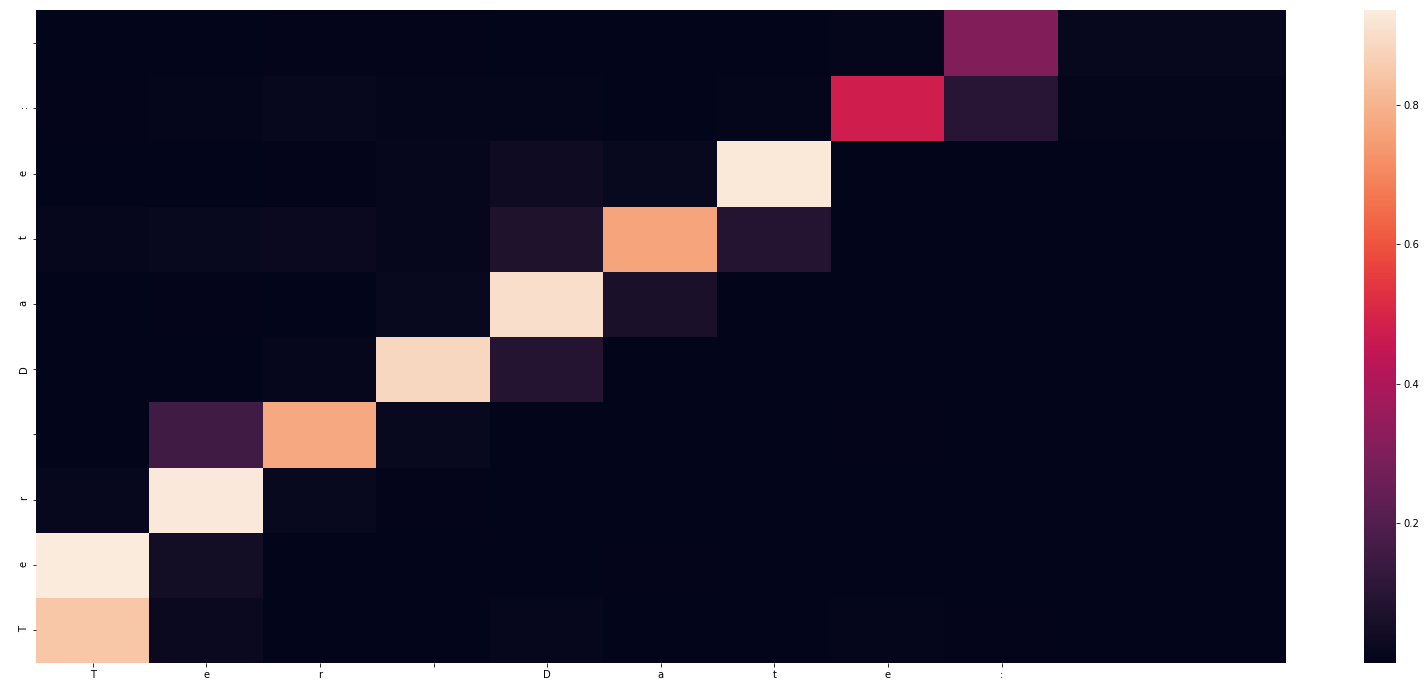

-
Input sentence: Ter Date:
GT sentence: Term Date:

Decoded sentence: Ter Date:



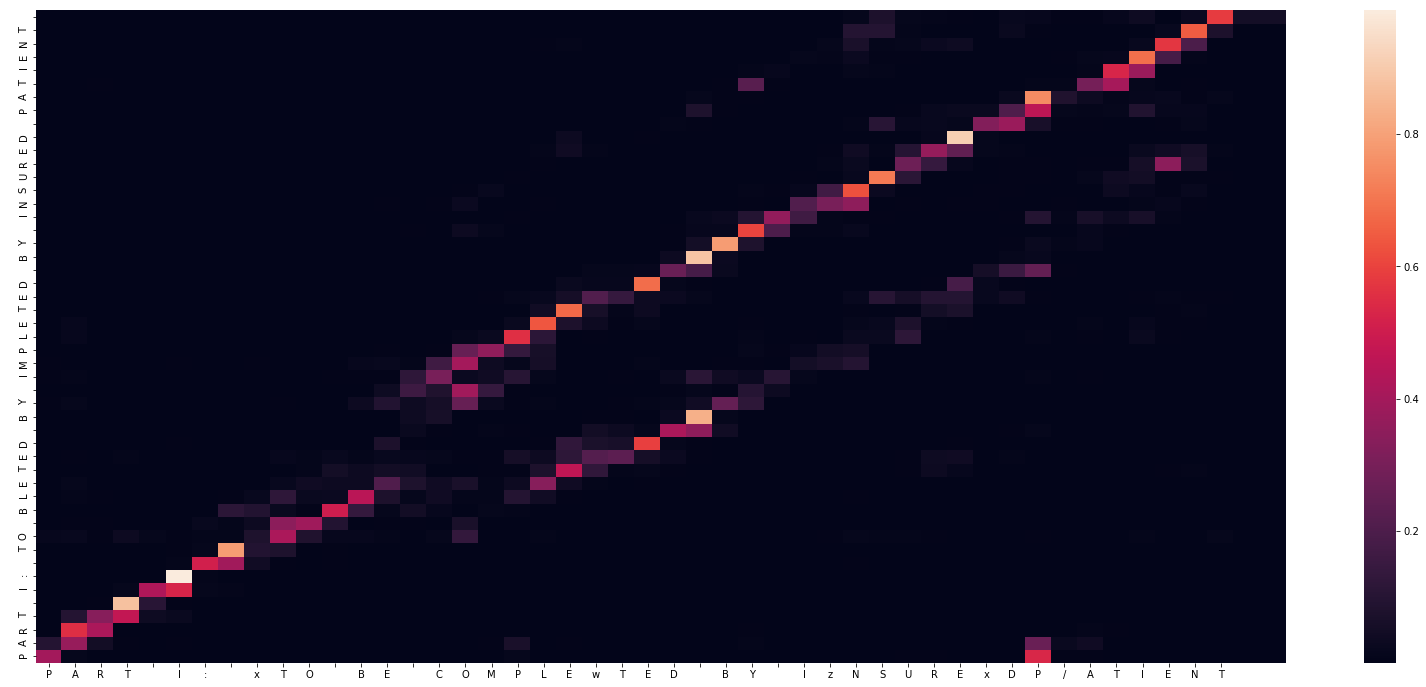

-
Input sentence: PART I: xTO BE COMPLEwTED BY IzNSURExDP/ATIENT
GT sentence: PART I: TO BE COMPLETED BY INSURED/PATIENT

Decoded sentence: PART I: TO BLETED BY IMPLETED BY INSURED PATIENT



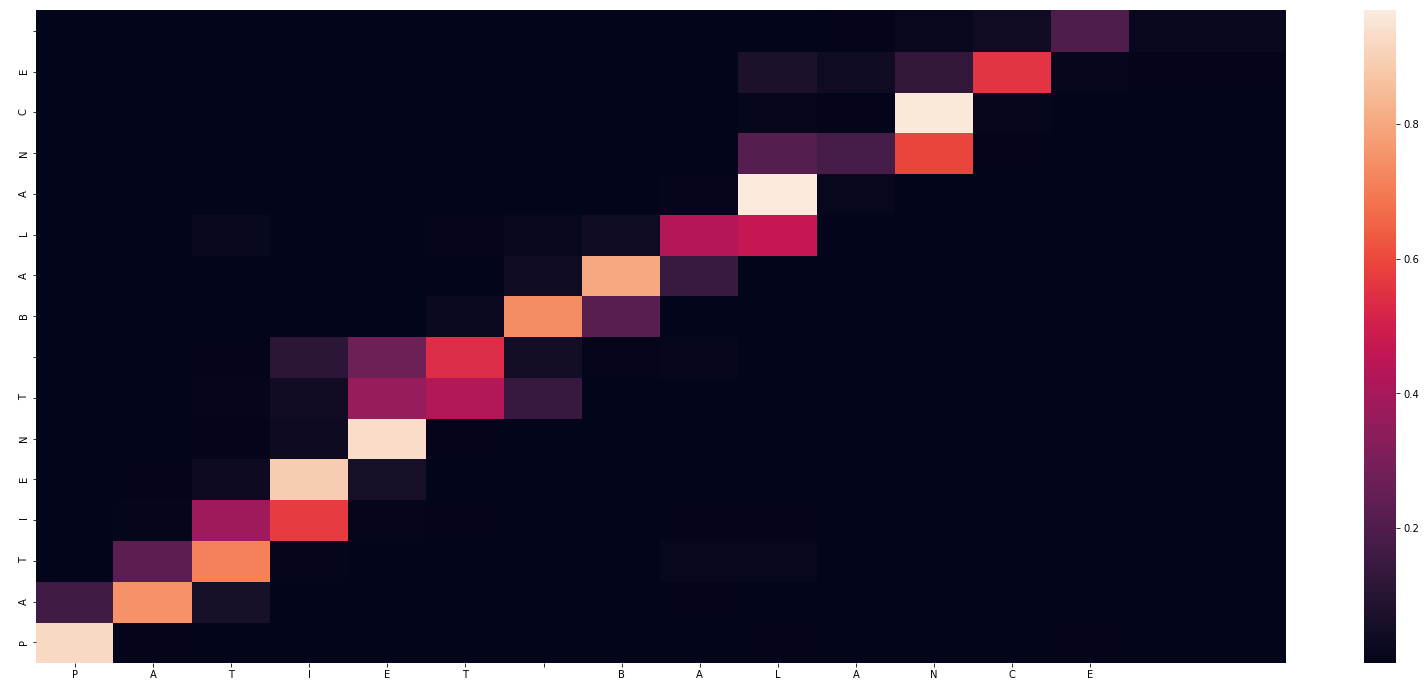

-
Input sentence: PATIET BALANCE
GT sentence: PATIENT BALANCE

Decoded sentence: PATIENT BALANCE



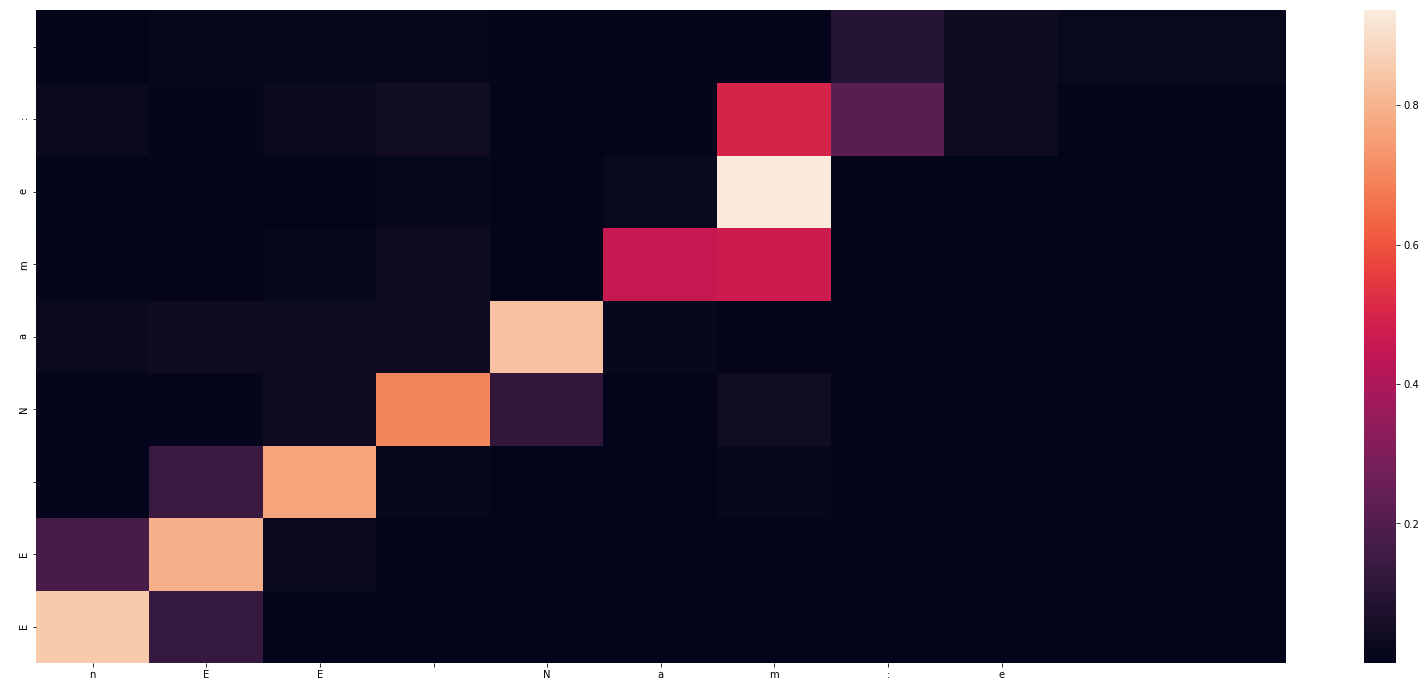

-
Input sentence: nEE Nam:e
GT sentence: EE Name:

Decoded sentence: EE Name:



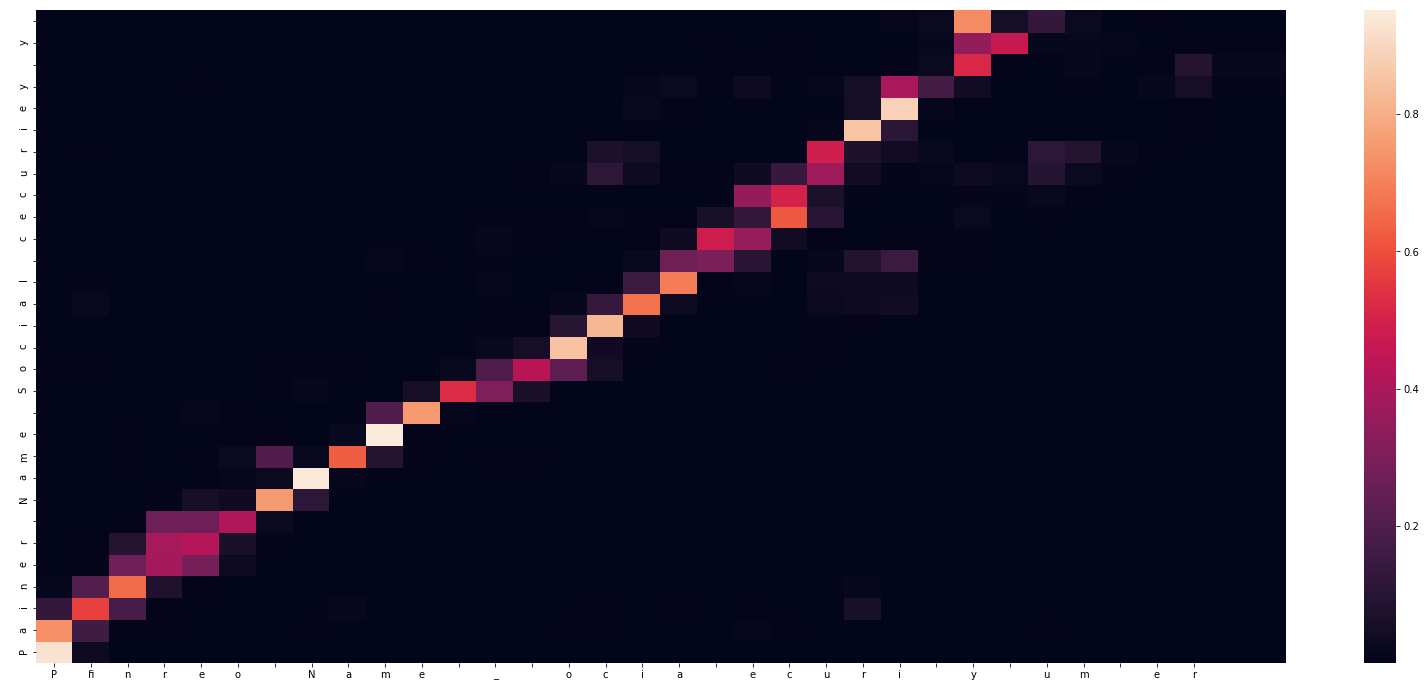

-
Input sentence: Pﬁnreo Name _ ocia ecuri y um er
GT sentence: Printed Name Social Security Number

Decoded sentence: Painer Name Social cecuriey y



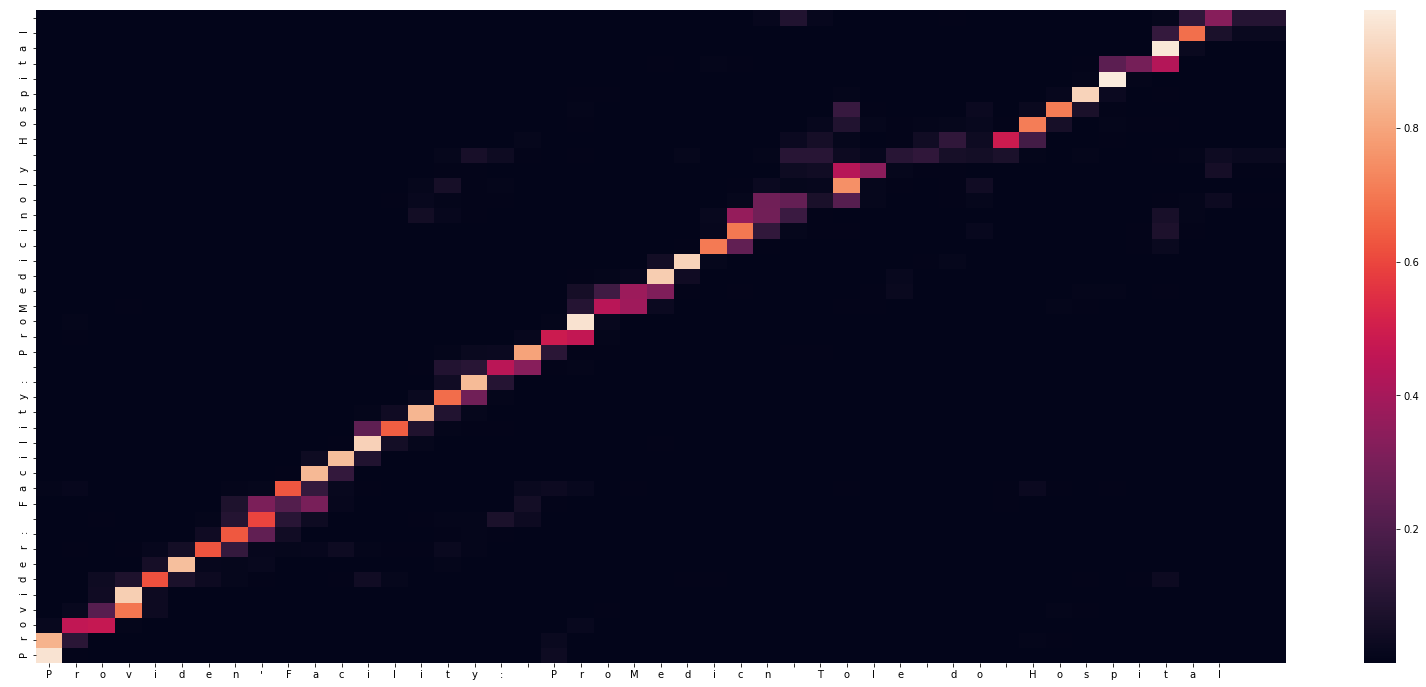

-
Input sentence: Providen'Facility: ProMedicn Tole do Hospital
GT sentence: Provider/Facility: ProMedica Toledo Hospital

Decoded sentence: Provider: Facility: ProMedicinoly Hospital



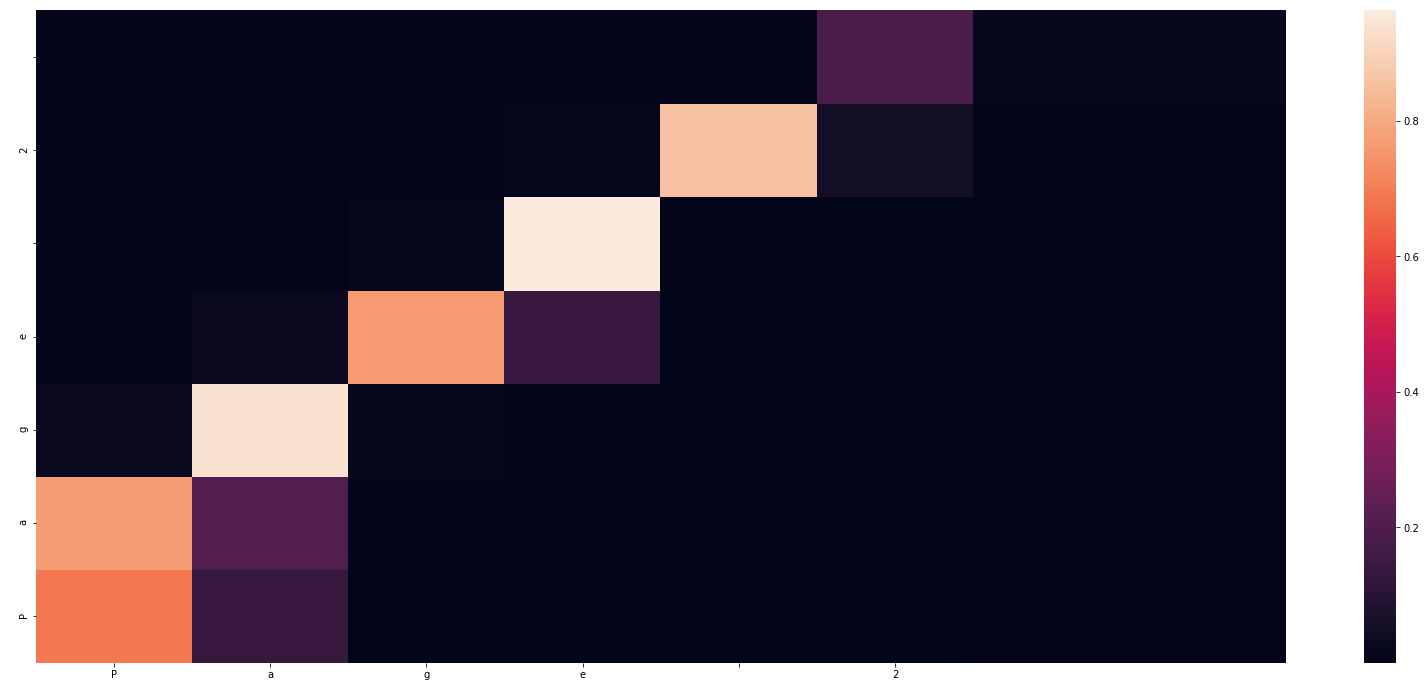

-
Input sentence: Page 2
GT sentence: Page 2

Decoded sentence: Page 2



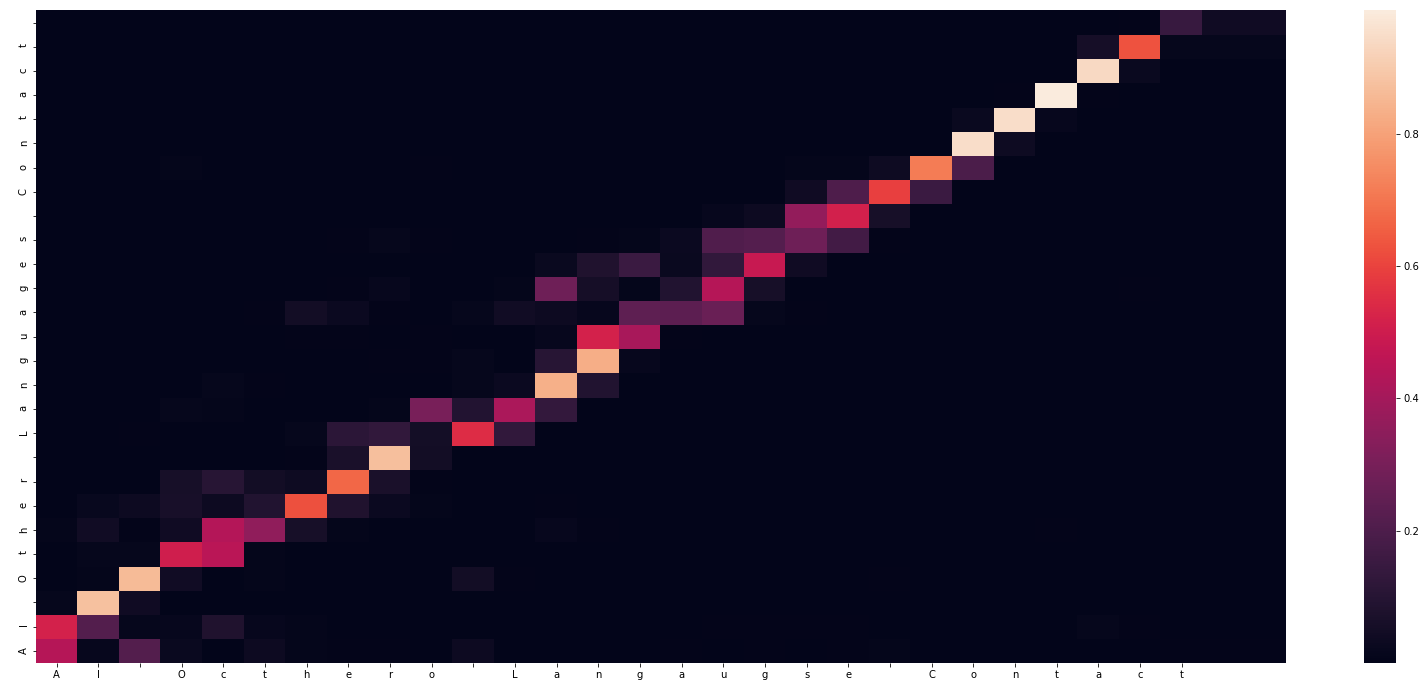

-
Input sentence: Al Octhero Langaugse Contact
GT sentence: All Other Languages Contact

Decoded sentence: Al Other Languages Contact



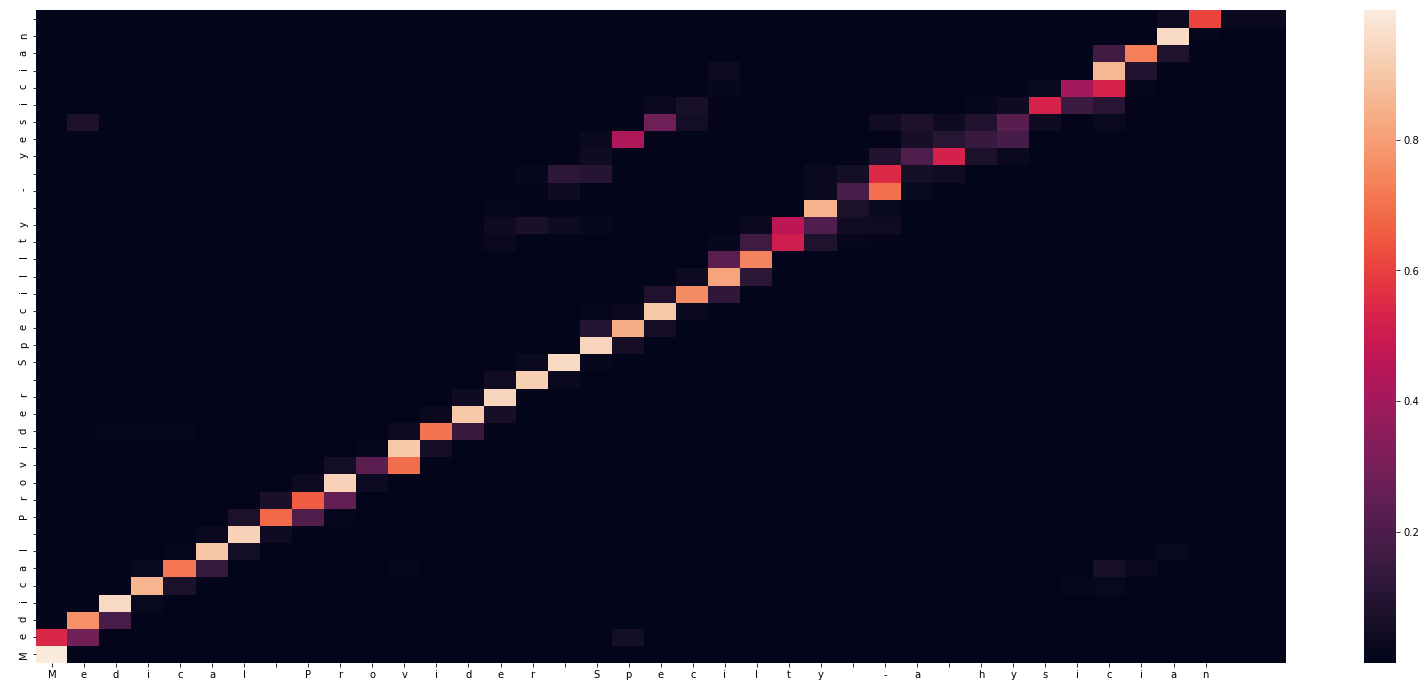

-
Input sentence: Medical Provider Specilty -a hysician
GT sentence: Medical Provider Specialty - Physician

Decoded sentence: Medical Provider Specillty - yesician



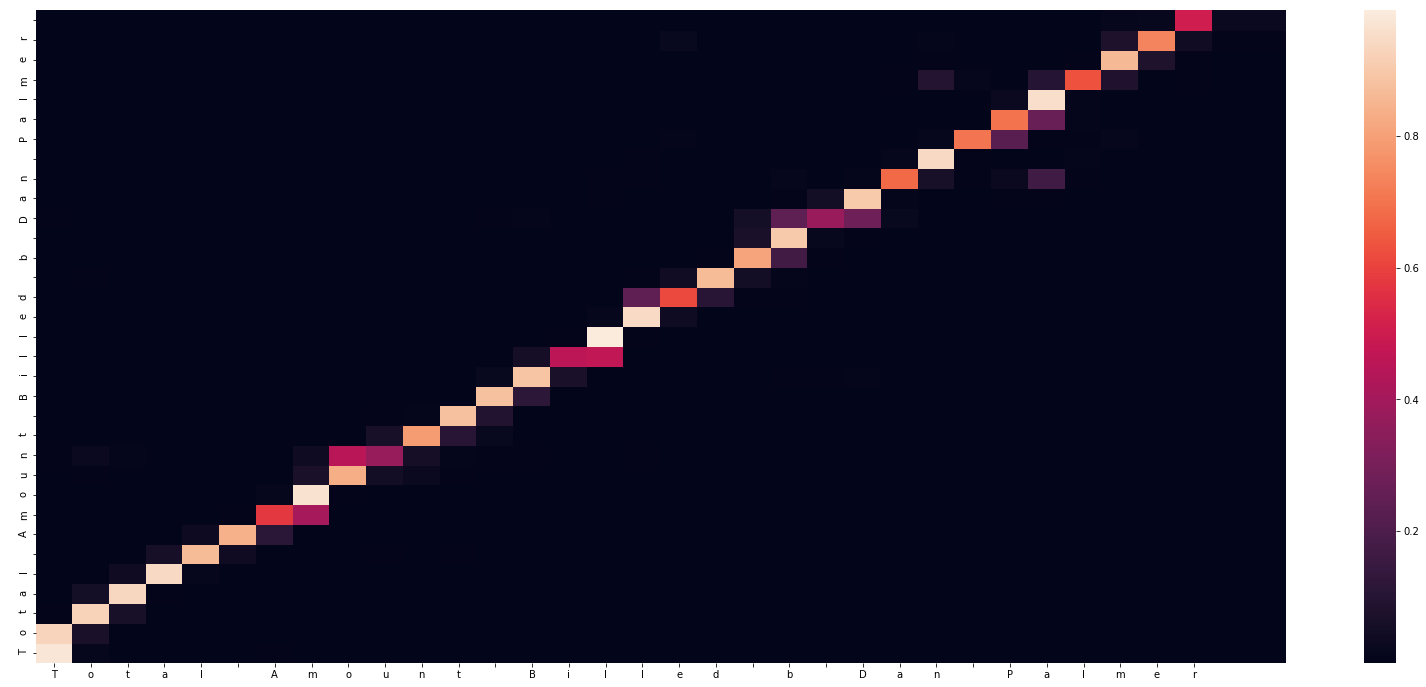

-
Input sentence: Total Amount Billed b Dan Palmer
GT sentence: Total Amount Billed by Dan Palmer

Decoded sentence: Total Amount Billed b Dan Palmer



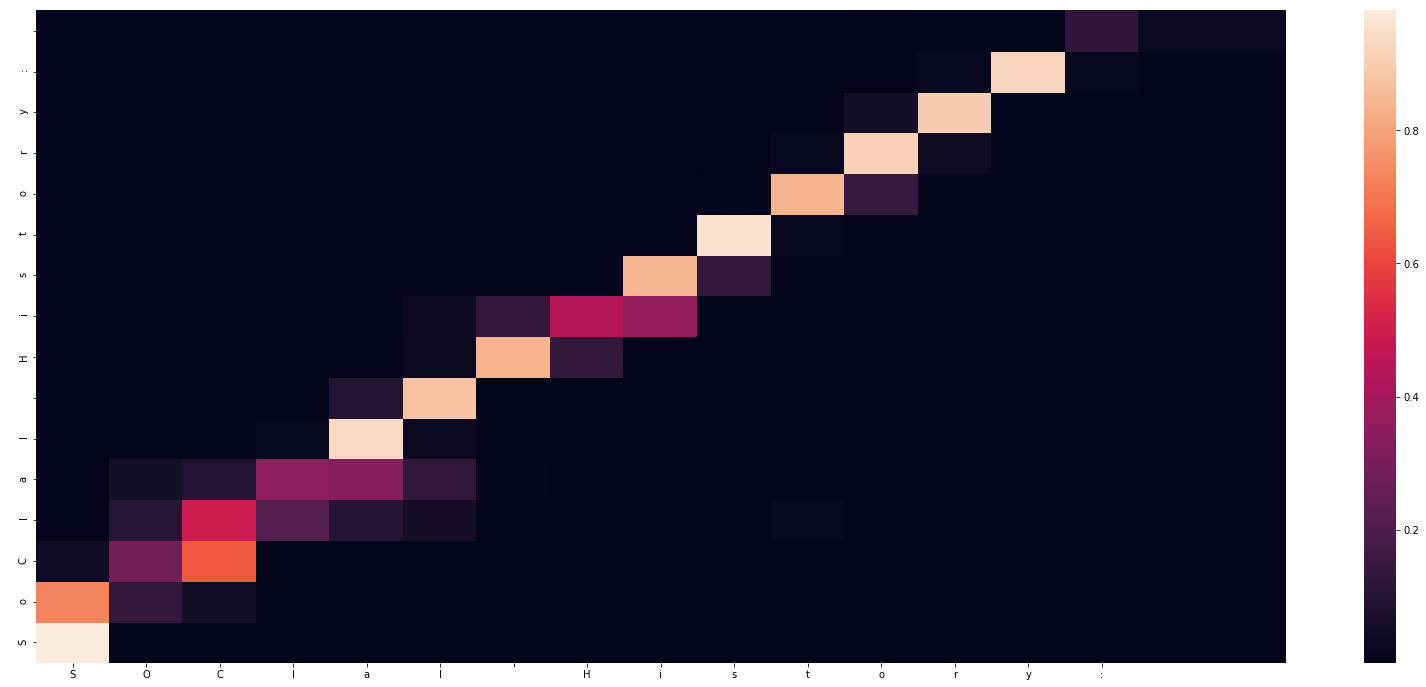

-
Input sentence: SOCIaI History:
GT sentence: Social History:

Decoded sentence: SoCIal History:



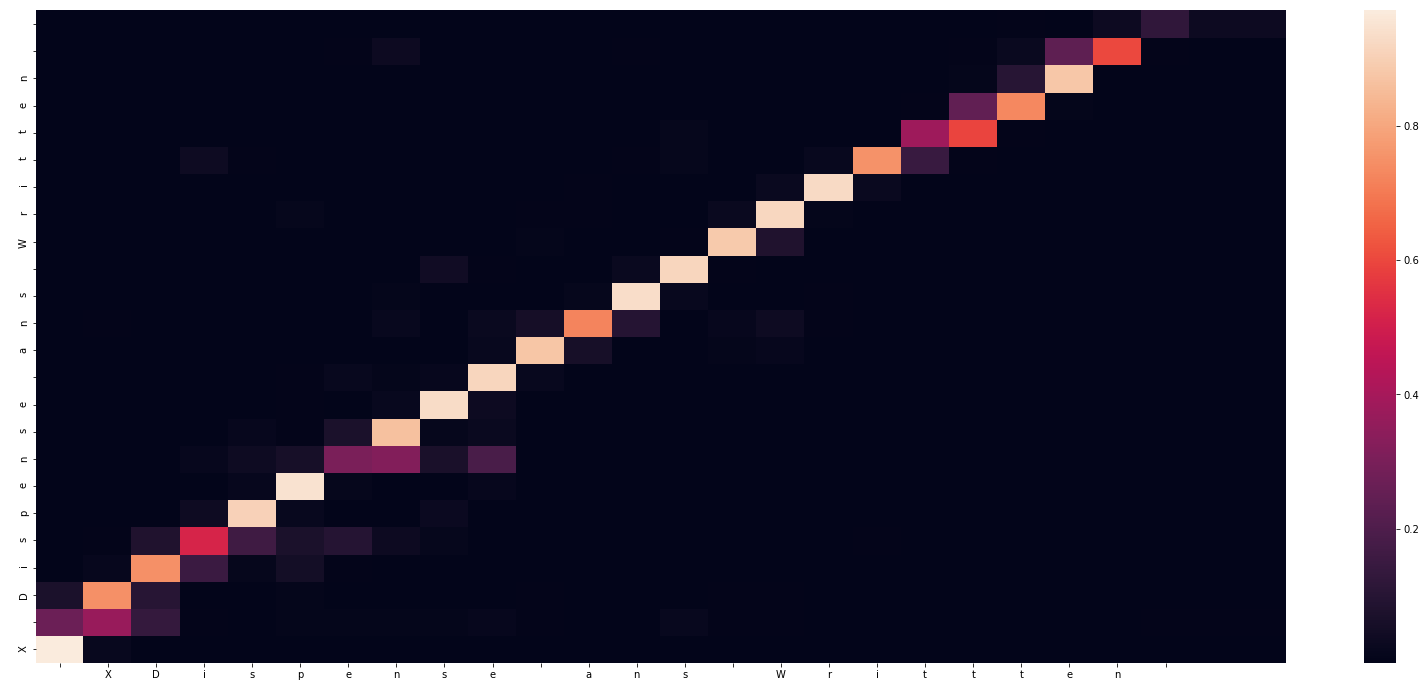

-
Input sentence:  XDispense ans Writtten 
GT sentence: X Dispense as Written 

Decoded sentence: X Dispense ans Written 



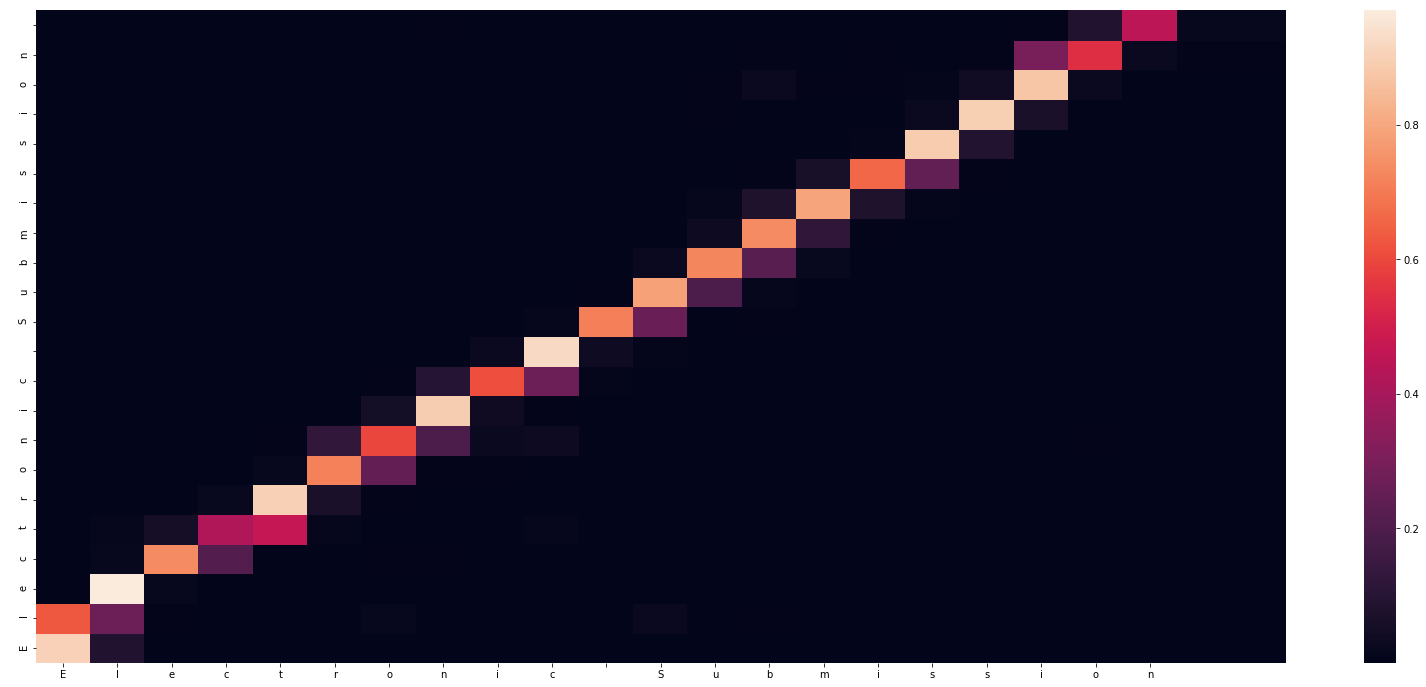

-
Input sentence: Electronic Submission
GT sentence: Electronic Submission

Decoded sentence: Electronic Submission



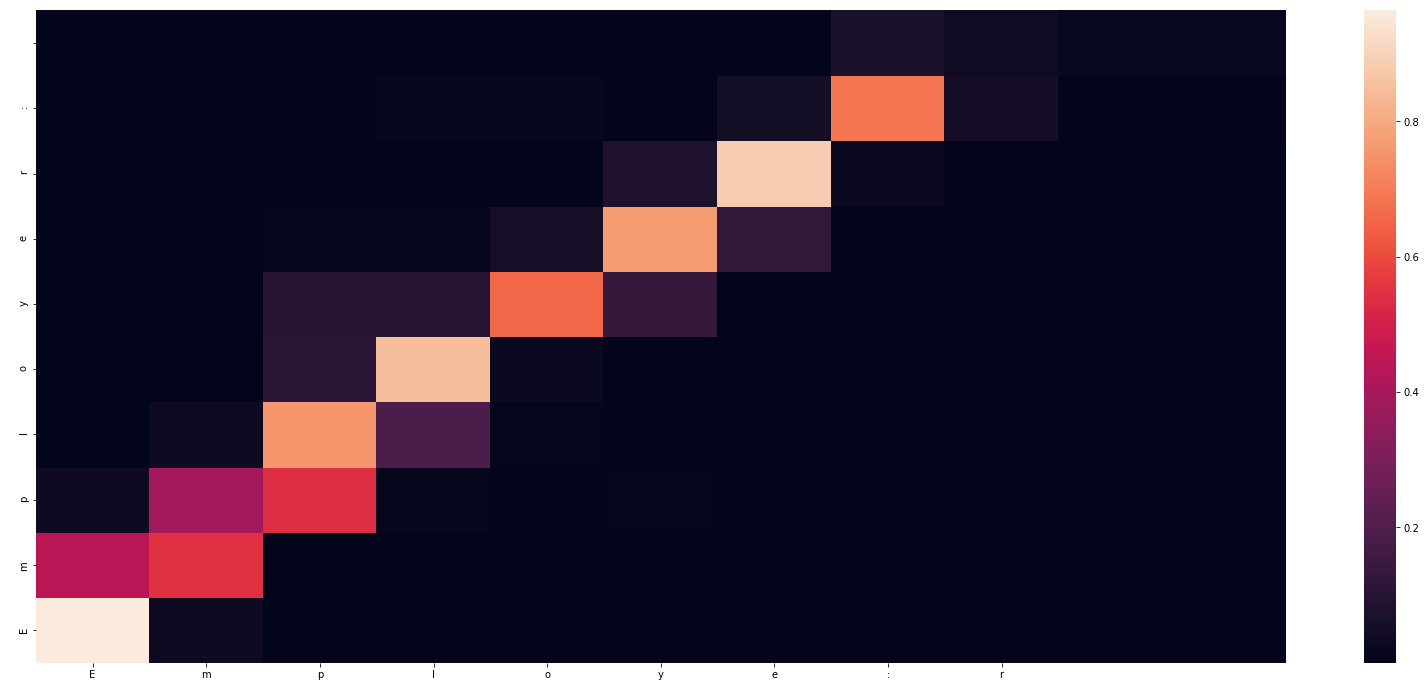

-
Input sentence: Employe:r
GT sentence: Employer:

Decoded sentence: Employer:



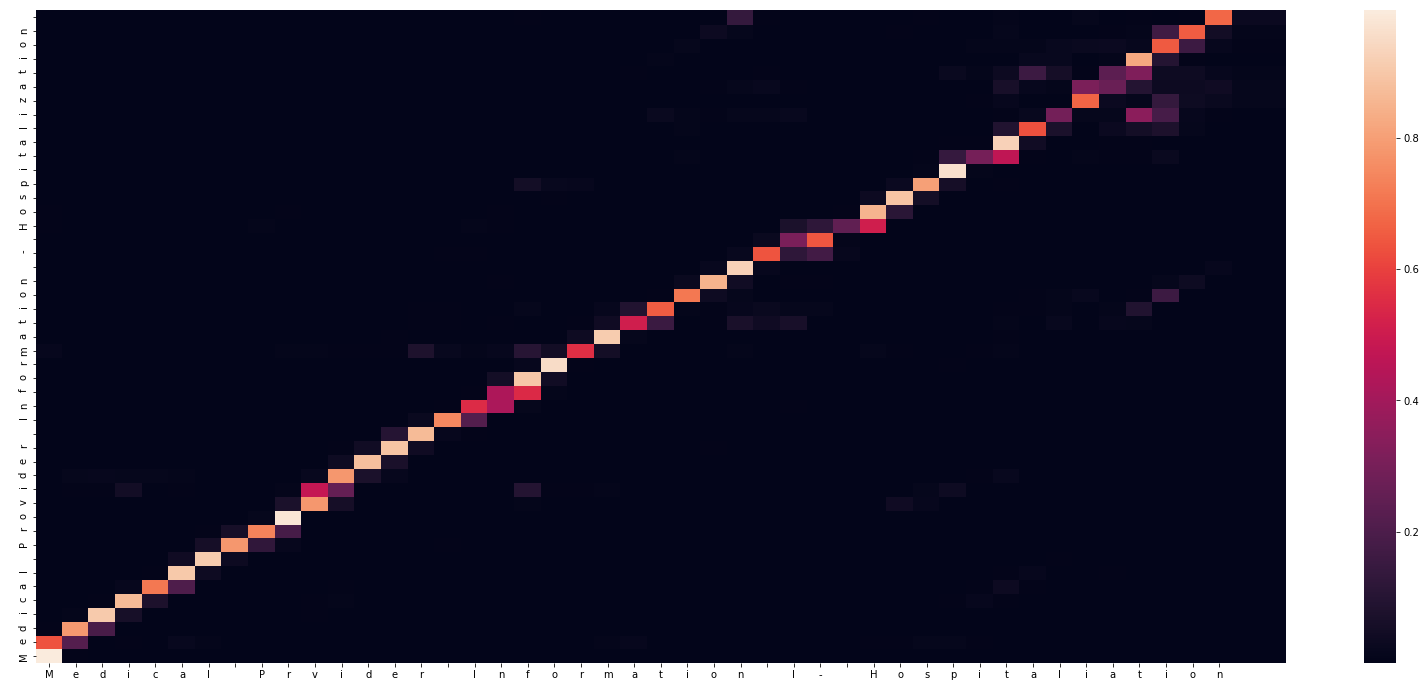

-
Input sentence: Medical Prvider Information l- Hospitaliation
GT sentence: Medical Provider Information - Hospitalization

Decoded sentence: Medical Provider Information - Hospitalization



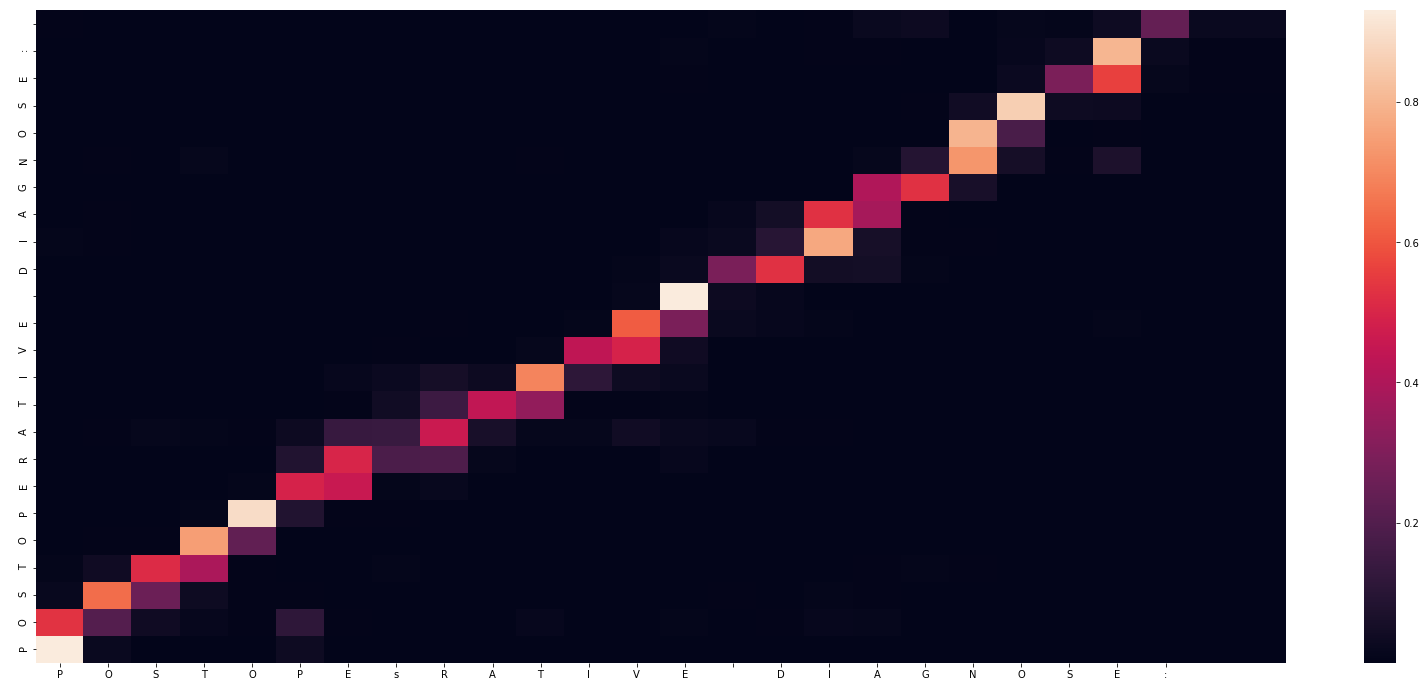

-
Input sentence: POSTOPEsRATIVE DIAGNOSE:
GT sentence: POSTOPERATIVE DIAGNOSES:

Decoded sentence: POSTOPERATIVE DIAGNOSE:



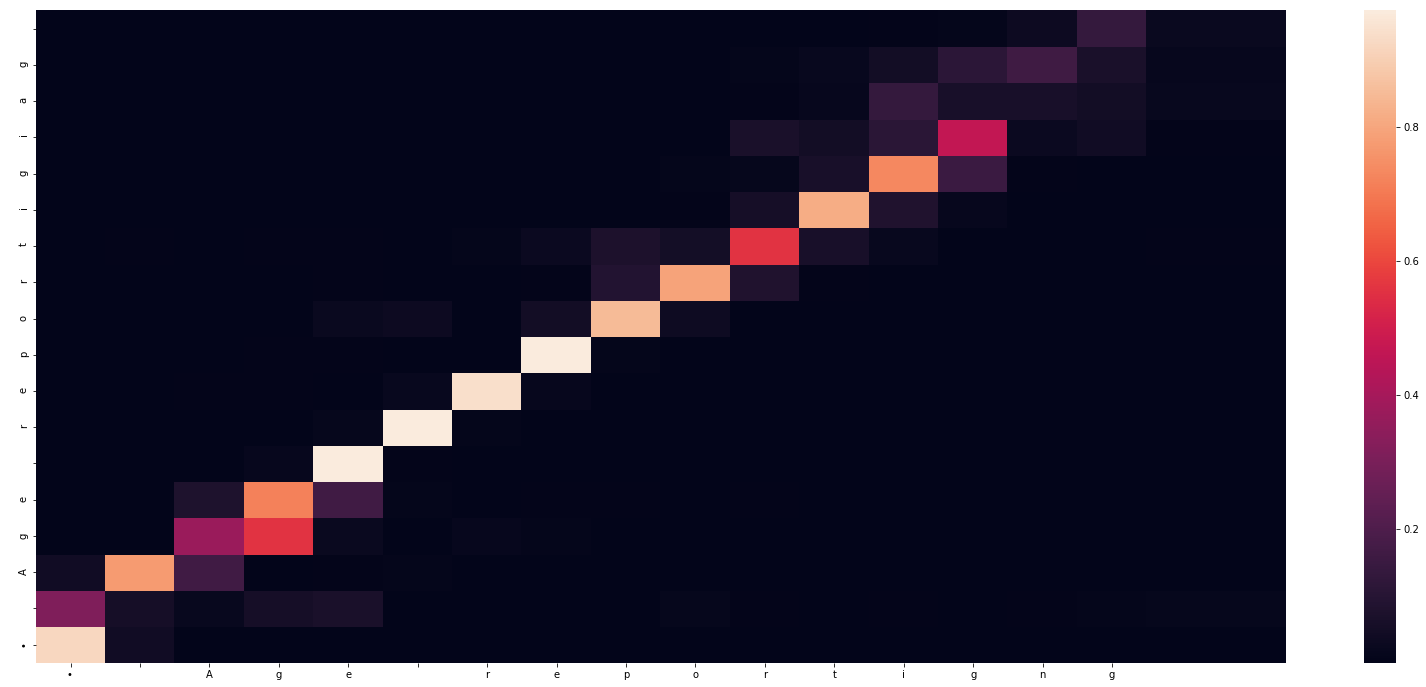

-
Input sentence: • Age reportigng
GT sentence: • Age reporting

Decoded sentence: • Age reportigiag



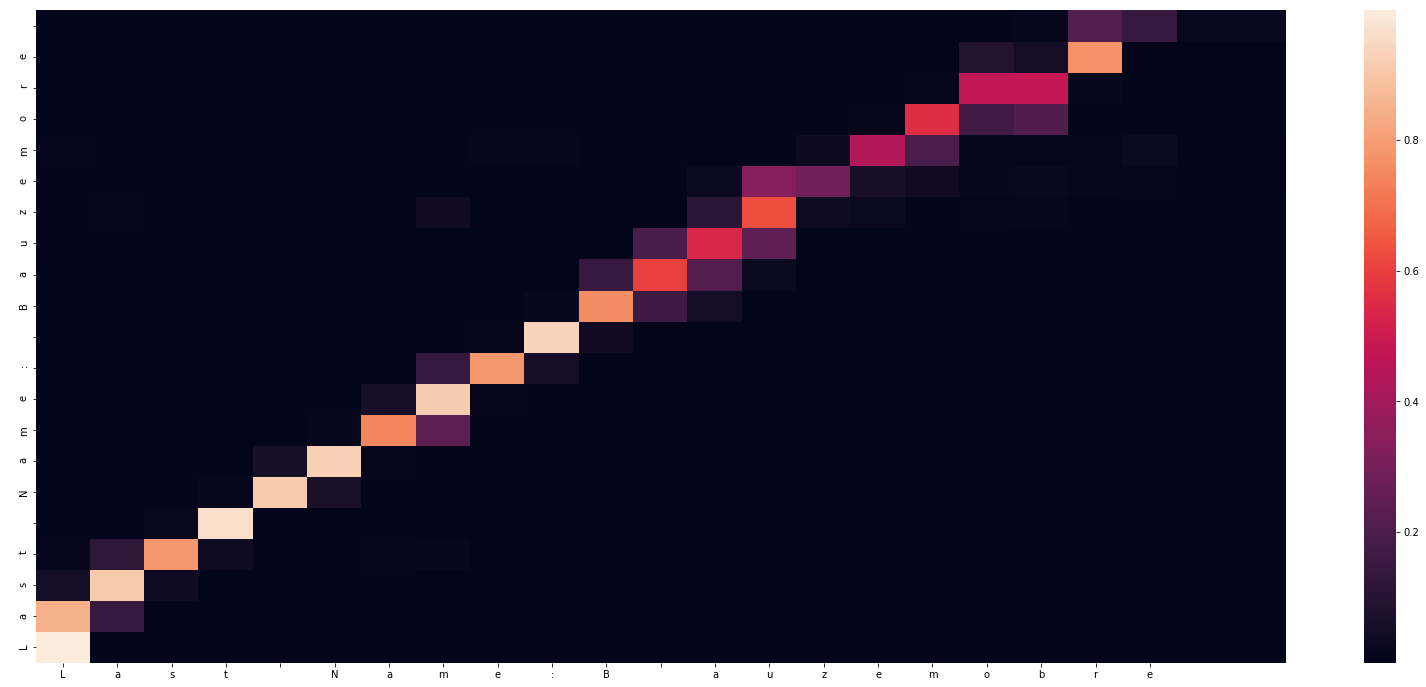

-
Input sentence: Last Name:B auzemobre
GT sentence: Last Name: Bazemore

Decoded sentence: Last Name: Bauzemore



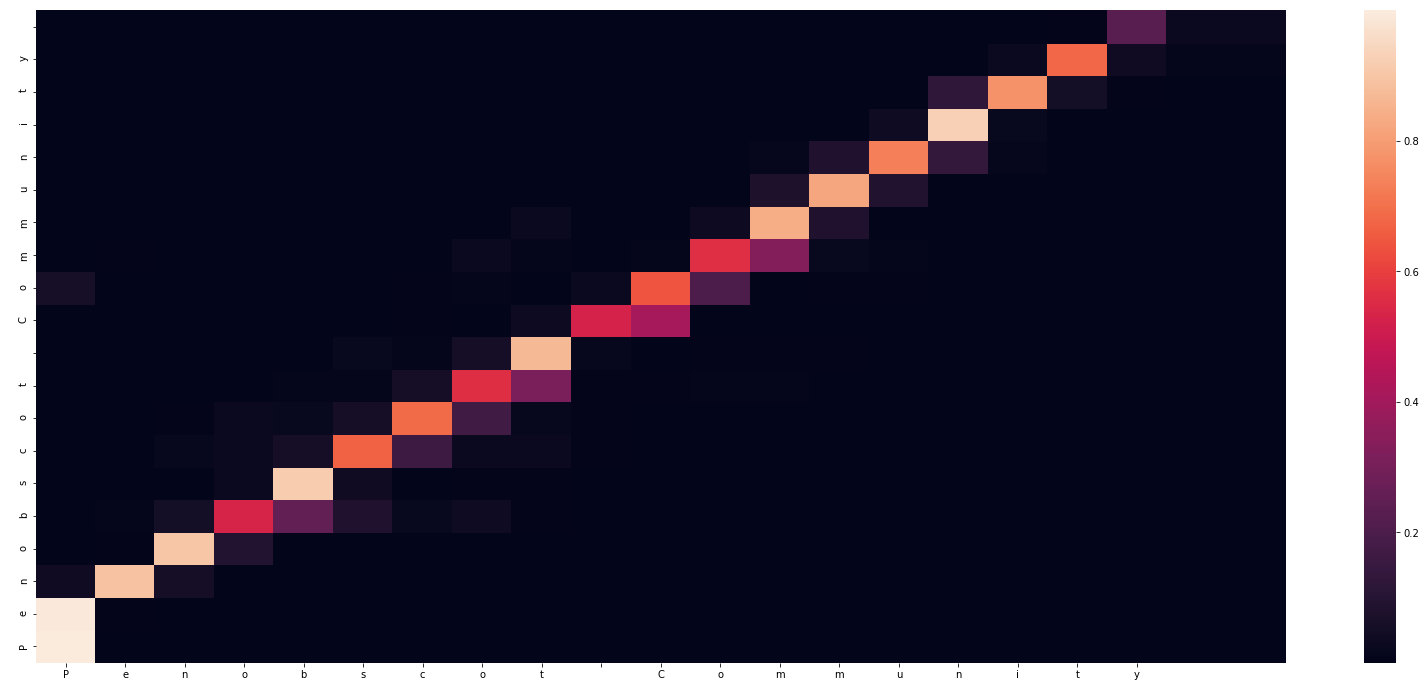

-
Input sentence: Penobscot Community
GT sentence: Penobscot Community

Decoded sentence: Penobscot Community



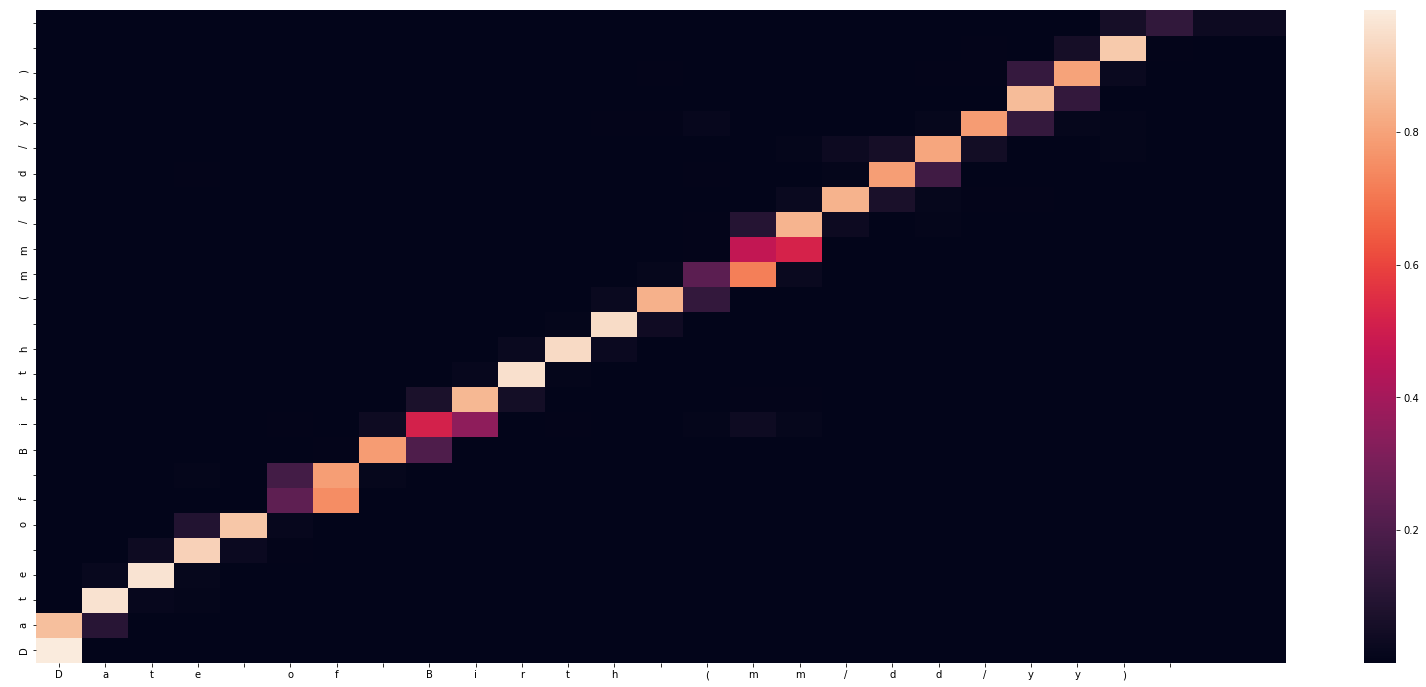

-
Input sentence: Date of Birth (mm/dd/yy) 
GT sentence: Date of Birth (mm/dd/yy) 

Decoded sentence: Date of Birth (mm/dd/yy) 



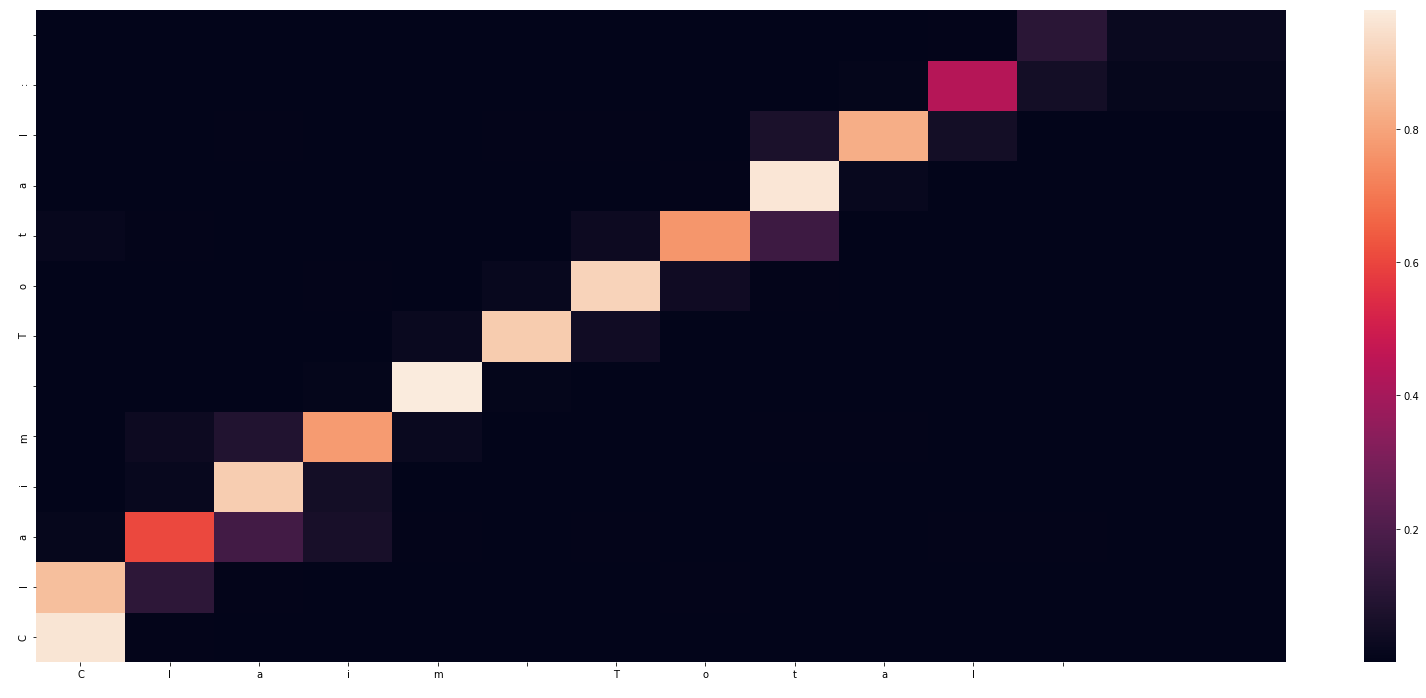

-
Input sentence: Claim Total

GT sentence: Claim Totals

Decoded sentence: Claim Total:



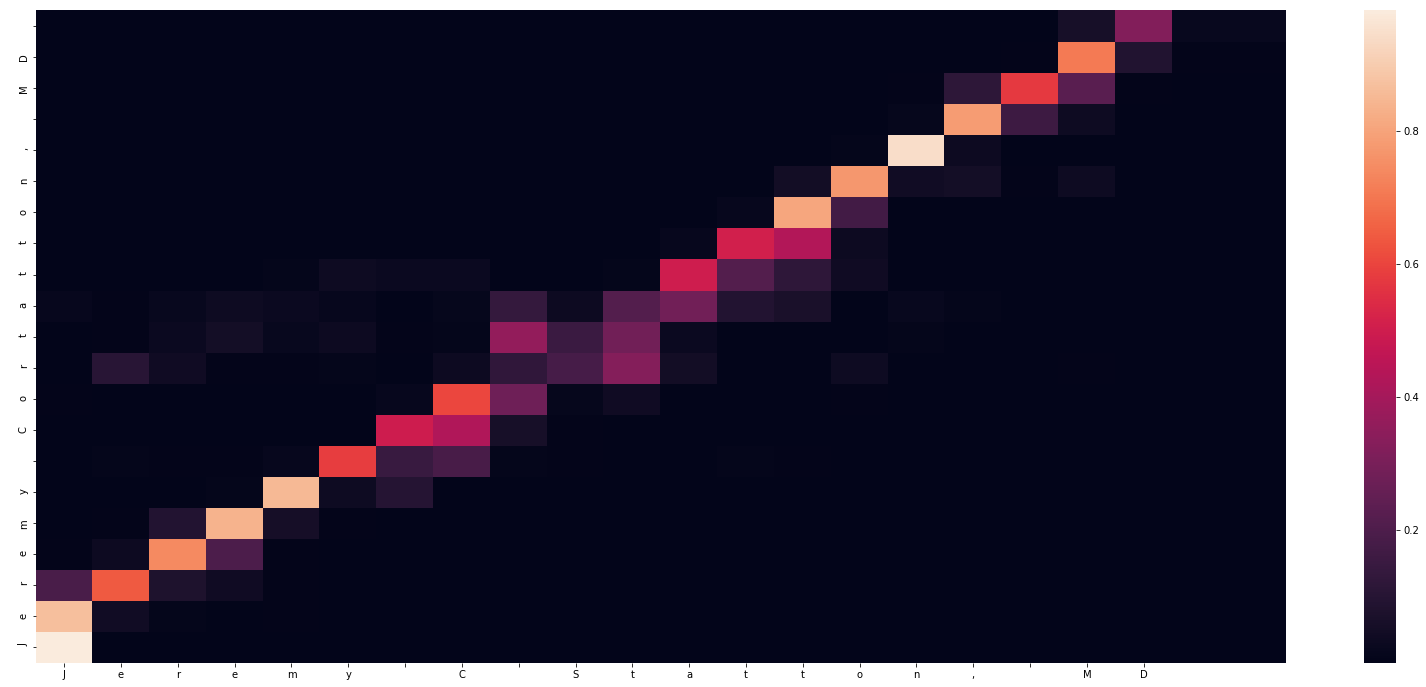

-
Input sentence: Jeremy C Statton, MD
GT sentence: Jeremy O Statton, MD

Decoded sentence: Jeremy Cortatton, MD



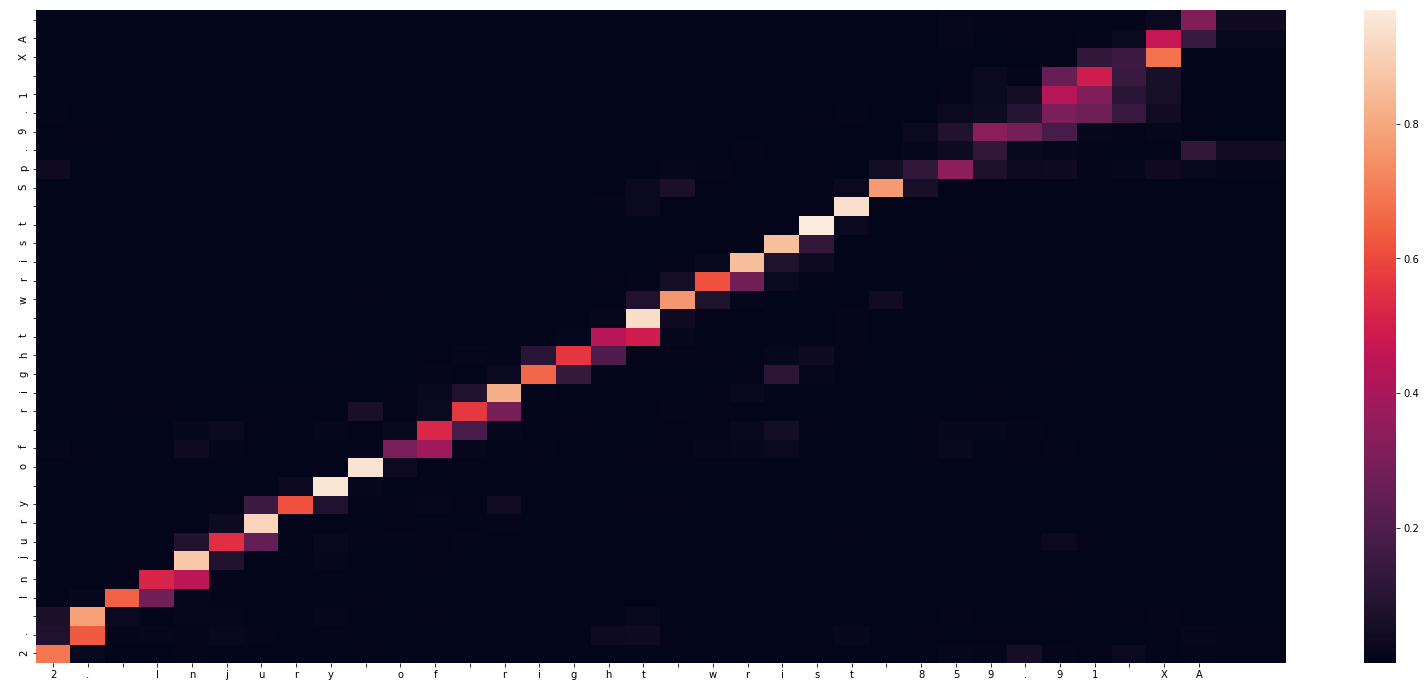

-
Input sentence: 2. Injury of right wrist 859.91 XA
GT sentence: 2. Injury of right wrist S69.91XA

Decoded sentence: 2. Injury of right wrist Sp.9.1 XA



In [ ]:

for seq_index in range(100):
    target_text = test_target_texts[seq_index][1:-1]
    text = test_input_texts[seq_index]

    decoded_sentence = visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, vocab_to_int, int_to_vocab)
    print('-')
    print('Input sentence:', text)
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)  


In [ ]:
WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
print('WER_spell_correction |TEST= ', WER_spell_correction)

In [ ]:
WER_OCR = calculate_WER(target_texts_, test_input_texts)
print('WER_OCR |TEST= ', WER_OCR)

# Test on separate tesseract corrected file

In [60]:
num_samples = 10000
tess_correction_data = os.path.join(data_path, 'new_trained_data.txt')
input_texts_OCR, target_texts_OCR, gt_OCR = load_data_with_gt(tess_correction_data, num_samples, max_sent_len, min_sent_len)

input_texts = input_texts_OCR
target_texts = target_texts_OCR

encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

# Sample output from train data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(len(input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = encoder_input_data[seq_index: seq_index + 1]
    
    decoded_sentence, _ = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)
    
WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
print('WER_spell_correction |TEST= ', WER_spell_correction)

WER_OCR = calculate_WER(target_texts_, input_texts)
print('WER_OCR |TEST= ', WER_OCR)

-
Input sentence: Me dieal Provider Roles: Treating 
GT sentence: Medical Provider Roles: Treating

Decoded sentence: Medical Provider Roles: Treating 

-
Input sentence: Provider First Name: Christine 
GT sentence: Provider First Name: Christine

Decoded sentence: Provider First Name: Chistine 

-
Input sentence: Provider Last Name: Nolen, MD 
GT sentence: Provider Last Name: Nolen, MD

Decoded sentence: Provider Last Name: Nolen, MD 

-
Input sentence: Address Line 1 : 7 25 American Avenue 
GT sentence: Address Line 1 : 725 American Avenue

Decoded sentence: Address Line 1 : 7 25 American Avene 

-
Input sentence: City. W’aukesha 
GT sentence: City: Waukesha

Decoded sentence: City: Wauresha 

-
Input sentence: StatefProvinee: ‘WI 
GT sentence: State/Province: WI

Decoded sentence: State/Proviner:

-
Input sentence: Postal Code: 5 31 88 
GT sentence: Postal Code: 53188

Decoded sentence: Postal Code: 53318

-
Input sentence: Country". US 
GT sentence: Country:  US

Decoded sentence: 

-
Input sentence: OVER 30 DAYS 
GT sentence: OVER 90 DAYS 

Decoded sentence: OVER 30 DAYS

-
Input sentence: IOVER 120 DAYS 
GT sentence: OVER 120 DAYS

Decoded sentence: OVERER0 DAYS

-
Input sentence: ILAST PAY DATEI 
GT sentence: LAST PAY DATE

Decoded sentence: LAST PAY DATE PAY 

-
Input sentence: STMT DATE 
GT sentence: STMT DATE 

Decoded sentence: STMT DATE 

-
Input sentence: BALANCE DUE 
GT sentence: BALANCE DUE

Decoded sentence: BALANCE DUE

-
Input sentence: DOCTOR LEGEND 
GT sentence: DOCTOR LEGEND

Decoded sentence: DOCTOR LEGEND 

-
Input sentence: 1 NOLEN, CHRISTINE, M. D. 
GT sentence: 1 NOLEN, CHRISTINE, M. D.

Decoded sentence: 1 NOLEN, CHRISTINE, M. D. 

-
Input sentence: COMMENTS 
GT sentence: COMMENTS

Decoded sentence: COMMENTS 

-
Input sentence: PRIMARY INSUR: UMR FISERV WI 
GT sentence: PRIMARY INSUR: UMR FISERV WI

Decoded sentence: PRIMARY INSUR: UMR FISERV WI

-
Input sentence: SECONDARY INSUR: 
GT sentence: SECONDARY INSUR:

Decoded sentence: SECONDARY I

-
Input sentence: Therapy: (Recordedz24Jan2018) to Recorded 
GT sentence: Therapy: (Recorded:24Jan2018) to Recorded

Decoded sentence: Theray: (Recorded:24Jan2018) to Recorded 

-
Input sentence: 4. Probiotic CAPS; 
GT sentence: 4. Probiotic CAPS;

Decoded sentence: 4. Probiotic CAPS; 

-
Input sentence: Therapy: 21Jan2018 to Recorded 
GT sentence: Therapy: 21Jan2018 to Recorded

Decoded sentence: Therapy: 21Jan2018 to Recorded

-
Input sentence: -- McMurray’s 
GT sentence: -- McMurray’s

Decoded sentence: -- McMurray’s 

-
Input sentence: symmetric dial at 0 and 90 degrees 
GT sentence: symmetric dial at 0 and 90 degrees

Decoded sentence: yymetric dial at 0 and 90 degrees 

-
Input sentence: ResultsIData 
GT sentence: Results/Data

Decoded sentence: Results/Data

-
Input sentence: Right knee MRI IMPRESSION: 
GT sentence: Right knee MRI IMPRESSION:

Decoded sentence: Right knee MRI IMPRESSION:

-
Input sentence: 1. ACL tear. 
GT sentence: 1. ACL tear.

Decoded sentence: 1. ACL tear.



-
Input sentence: I No signiﬁcant past medical history 
GT sentence: • No significant past medical history

Decoded sentence: • No significant past medical history

-
Input sentence: Surgical History 
GT sentence: Surgical History

Decoded sentence: Surgical History

-
Input sentence: 0 History of Ankle Surgery 
GT sentence: • History of Ankle Surgery

Decoded sentence: History of Ankle Surgery 

-
Input sentence: oinvi'inoggiiis 
GT sentence: TWIN CITIES ORTHOPEDICS

Decoded sentence: Titis Congiis 

-
Input sentence: MINNESOTA VALLEY SURGERY CENTER 
GT sentence: MINNESOTA VALLEY SURGERY CENTER

Decoded sentence: MINNESOTA VALLEY SURGERY CENTER 

-
Input sentence: OPERATIVE REPORT 
GT sentence: OPERATIVE REPORT

Decoded sentence: OPERATIVE REPORT

-
Input sentence: MR #: 
GT sentence: MR #:

Decoded sentence: MR #:

-
Input sentence: SURGEON: JASON HOLM, M.D. 
GT sentence: SURGEON: JASON HOLM, M.D. 

Decoded sentence: SURGEON: JASON HOLMM, M.D. 

-
Input sentence: DATE: 02/02/2018 
GT

-
Input sentence: For:Knee injury; Ordered By:Felvor. David; 
GT sentence: For:Knee injury; Ordered By:Feivor, David;

Decoded sentence: For:Knee injury; Ordered By:Fleft 

-
Input sentence: DiscussionlSummary 
GT sentence: Discussion/Summary

Decoded sentence: Discussion/Summary 

-
Input sentence: Scribe - Statements 
GT sentence: Scribe - Statements

Decoded sentence: Scribe - Statements 

-
Input sentence: Signatures 
GT sentence: Signatures

Decoded sentence: Signatures

-
Input sentence: Electronically signed by : David Felvor, PA~C:
GT sentence: Electronically signed by : David Feivor, PA~C:

Decoded sentence: Electronically signed by: D David Fevicer

-
Input sentence: oTé'iLNog'aiiiés 
GT sentence: TWIN CITIES ORTHOPEDICS

Decoded sentence: TWIN CITIES 

-
Input sentence: MINNESOTA VALLEY SURGERY CENTER 
GT sentence: MINNESOTA VALLEY SURGERY CENTER

Decoded sentence: MINNESOTA VALLEY SURGERY CENTER 

-
Input sentence: OPERATIVE REPORT ' 
GT sentence: OPERATIVE REPORT

Decoded 

-
Input sentence: First treatment date 
GT sentence: First treatment date

Decoded sentence: First treatment date 

-
Input sentence: Date doctor indicated you were unable to work 
GT sentence: Date doctor indicated you were unable to work

Decoded sentence: Date doctory Indicated you werk uns ork surk

-
Input sentence: When is your next visit? 
GT sentence: When is your next visit?

Decoded sentence: When is your next visit? 

-
Input sentence: Treated in emergency room — no 
GT sentence: Treated in emergency room - no

Decoded sentence: Treated in emergency room - no

-
Input sentence: Admitted to hospital — no 
GT sentence: Admitted to hospital - no

Decoded sentence: Admitted to hospital - no 

-
Input sentence: Add doctors details — yes 
GT sentence: Add doctors details - yes

Decoded sentence: Add doctors details - yes 

-
Input sentence: First name — Debra 
GT sentence: First name - Debra

Decoded sentence: First name - Debar 

-
Input sentence: Last name — Stokley 
GT sentence

-
Input sentence: Estimated return to work date — 
GT sentence: Estimated return to work date -

Decoded sentence: Estimated return to work date - f

-
Input sentence: Time missed 7 no 
GT sentence: Time missed - no

Decoded sentence: Time missed - no

-
Input sentence: Break in employment — no 
GT sentence: Break in employment - no

Decoded sentence: Break in employment - no 

-
Input sentence: Served military last 12 mths — no 
GT sentence: Served military last 12 mths - no

Decoded sentence: Served military last 12 mthes - no

-
Input sentence: Hired as temp - no 
GT sentence: Hired as temp - no

Decoded sentence: Hired as temp - no 

-
Input sentence: Work and live same state — yes 
GT sentence: Work and live same state - yes

Decoded sentence: Work and live same state - yes

-
Input sentence: Work from home — no 
GT sentence: Work from home - no

Decoded sentence: Work from home - no 

-
Input sentence: Does schedule vary? - yes 
GT sentence: Does schedule vary? - yes

Decoded sen

-
Input sentence: L-102 17) 4
GT sentence: CL-1023 (02/17) 4

Decoded sentence: CL-1023 - 17.40 2 104 - 10 24124 - 10 24124 - 102 
-
Input sentence: unum“
GT sentence: unum

Decoded sentence: unum

-
Input sentence: . Q . ACCIDENT CLAIM FORM
GT sentence: ACCIDENT CLAIM FORM

Decoded sentence: ACCIDENT CLAIM FORM

-
Input sentence: The Beneﬁts Center
GT sentence: The Benefits Center

Decoded sentence: The Benefits Center

-
Input sentence: ATTENDING PHYSICIAN STATEMENT
GT sentence: ATTENDING PHYSICIAN STATEMENT

Decoded sentence: ATTENDING PHYSICIAN STATEMENT

-
Input sentence: Date of Birth (mmfddlw)
GT sentence: Date of Birth (mm/dd/yy)

Decoded sentence: Date of Birth (mm/dd/yy)

-
Input sentence: ACCIDENT DETAILS
GT sentence: ACCIDENT DETAILS

Decoded sentence: ACCIDENT DETAILS

-
Input sentence: Ifyee‘ date of accident (mmlddiyy) Ell—I
GT sentence: If yes, date of accident (mm/dd/yy)

Decoded sentence: If yes, date of accident (mm/dd/yy)

-
Input sentence: Detee orService (includin

-
Input sentence: TIER 3 11101111111101 MOOP Max
GT sentence: TIER 3 Individual MOOP Max 

Decoded sentence: TIER 3 Individual MOOP Max

-
Input sentence: URTHDATLANTA LLC FAYETI'EVI LLE 
GT sentence: ORTHOATLANTA LLC FAYETTEVILLE

Decoded sentence: ORTHOATLANTA LLC FAYETTIEL LEL

-
Input sentence: Merchant I0: 
GT sentence: Merchant ID:

Decoded sentence: Merchant ID: 

-
Input sentence: Transaction typo: 
GT sentence: Transaction type:

Decoded sentence: Transaction type: 

-
Input sentence: Approval code: 
GT sentence: Approval code: 

Decoded sentence: Approval code: 

-
Input sentence: Dateltime: 
GT sentence: Date/time:

Decoded sentence: Date/time: 

-
Input sentence: Record number: 
GT sentence: Record number: 

Decoded sentence: Record number: 

-
Input sentence: Type: 
GT sentence: Type:

Decoded sentence: Type: 

-
Input sentence: Trace number: 
GT sentence: Trace number: 

Decoded sentence: Trace number: 

-
Input sentence: Account number: 
GT sentence: Account number: 

De

-
Input sentence: Component Results 
GT sentence: Component Results

Decoded sentence: Component Results 

-
Input sentence: General Information 
GT sentence: General Information

Decoded sentence: General Information

-
Input sentence: Collected: 
GT sentence: Collected:

Decoded sentence: Collected: 

-
Input sentence: 002/15/2018 9:44 AM 
GT sentence: 2/15/2018 9:44 AM

Decoded sentence: 02/12/2018 941.4 MAM

-
Input sentence: Resulted: 
GT sentence: Resulted:

Decoded sentence: Resulted: 

-
Input sentence: 02/192013 9:41 AM 
GT sentence: 02/15/2018 9:41 AM

Decoded sentence: 02/1920 9:47

-
Input sentence: Ordered By: 
GT sentence: Ordered By:

Decoded sentence: Ordered By:

-
Input sentence: Jeremy C Statton, MD 
GT sentence: Jeremy O Statton, MD

Decoded sentence: Jeremy Cortatton, MD 

-
Input sentence: Result Status: 
GT sentence: Result Status:

Decoded sentence: Result Status: 

-
Input sentence: Final result 
GT sentence: Final result

Decoded sentence: Final result

-
Inpu

-
Input sentence: Birth Date: 
GT sentence: Birth Date:

Decoded sentence: Birth Date: 

-
Input sentence: Gender: 
GT sentence: Gender:

Decoded sentence: Gender: 

-
Input sentence: Language Preference: 
GT sentence: Language Preference:

Decoded sentence: Language Preference: 

-
Input sentence: Address Line 1: 
GT sentence: Address Line 1:

Decoded sentence: Address Line 1: 

-
Input sentence: Address Line 2: 
GT sentence: Address Line 2:

Decoded sentence: Address Line 2: 

-
Input sentence: City. 
GT sentence: City:

Decoded sentence: City: 

-
Input sentence: Slate/PrOVirlce: 
GT sentence: State/Province:

Decoded sentence: State/Province: 

-
Input sentence: Postal Code 
GT sentence: Postal Code:

Decoded sentence: Postal Code 

-
Input sentence: Country. 
GT sentence: Country:

Decoded sentence: Country: 

-
Input sentence: Best Phone Number to be Reached During the Da) 
GT sentence: Best Phone Number to be Reached During the Day

Decoded sentence: Best Phone Number to be Reac

-
Input sentence: Accident Date: 01/2 1 =20 1 8 
GT sentence: Accident Date: 01/21/2018

Decoded sentence: Accident Date: 01/21/2018 1 8

-
Input sentence: SII l‘g er)’ Information 
GT sentence: Surgery Information

Decoded sentence: Sust Information 

-
Input sentence: Is Surgery Required: Yes
GT sentence: Is Surgery Required: Yes

Decoded sentence: Is Surgery Required: Yes

-
Input sentence: Surgery Date: 0210252018
GT sentence: Surgery Date: 02/02/2018

Decoded sentence: Surgery Date: 020125 

-
Input sentence: Irmatienthwpatient Indicator: Outpatient
GT sentence: Inpatient/Outpatient Indicator: Outpatient

Decoded sentence: Inpatient/Ountatient Indicator: Outpatient

-
Input sentence: U n U m‘ 
GT sentence: unum

Decoded sentence: Un 1 Um

-
Input sentence: O C . ACCIDENT CLAIM FORM 
GT sentence: ACCIDENT CLAIM FORM

Decoded sentence: ACCIDENT CLAIM FORM 

-
Input sentence: The Benefits Center 
GT sentence: The Benefits Center

Decoded sentence: The Benefits Center 

-
Input senten

-
Input sentence: Marital Status; Single
GT sentence: Marital Status: Single

Decoded sentence: Marital Status: Single

-
Input sentence: 0c: Title: Rasanﬂxxe: 
GT sentence: Occ Title: ResinMixer

Decoded sentence: Occ Title: Resannal

-
Input sentence: Original Hire Date:
GT sentence: Original Hire Date:

Decoded sentence: Original Hire Date:

-
Input sentence: Kira ”ate: ‘ ,
GT sentence: Hire Date:

Decoded sentence: Hire Date:

-
Input sentence: Insured Terminatznn Date;
GT sentence: Insured Termination Date:

Decoded sentence: Insured Termination Date:

-
Input sentence: hTW Limitaticng Permitted: Yes
GT sentence: ATW Limitations Permitted: Yes

Decoded sentence: ATW Limitation Permitted: Yes

-
Input sentence: Hours WDIKéd 11'! Last 12 Months: 1250.00
GT sentence: Hours Worked in Last 12 Months: 1250.00

Decoded sentence: Hours Worked in Last 12 Months:

-
Input sentence: Office. Crane Campaszte: - Florence
GT sentence: Office: Crane Composites - Florence

Decoded sentence: Office

-
Input sentence: St. Eilidbt‘lh
GT sentence: St. Elizabeth

Decoded sentence: St. Elizabeth

-
Input sentence: fr1 _ ST. ELIZABETH 
GT sentence: ST. ELIZABETH

Decoded sentence: ST. ELIZABETH 

-
Input sentence: EDGEonD 
GT sentence: EDGEWOOD

Decoded sentence: EDGEWOOD 

-
Input sentence: DP Notes 
GT sentence: Op Notes

Decoded sentence: OP Notes

-
Input sentence: MRN: Dos: 
GT sentence: MRN: DOB:

Decoded sentence: MRN: DOB: 

-
Input sentence: Acct #: 
GT sentence: Acct #:

Decoded sentence: Acct #: 

-
Input sentence: Adm: 3115:2013, arc: 3.1 some 
GT sentence: Adm: 3/16/18, D/C: 3/16/18

Decoded sentence: Adm: 311: 201: 3. some 

-
Input sentence: Operative 8‘ Procedure Notes (continued) 
GT sentence: Operative & Procedure Notes (continued)

Decoded sentence: Operative & Procedure Notes (continued)

-
Input sentence: butt)? Larkin,John J, MD 
GT sentence: Author: Larkin, John J MD

Decoded sentence: Author: Larkin, John J MD 

-
Input sentence: Igor- Orthopedio 
GT sentence: Se

-
Input sentence: mien! Taiapi'iona Number 
GT sentence: Patient Telephone Number

Decoded sentence: Patient Telephone Number 

-
Input sentence: Expnnlad Delivery Dale (mmldcilyy): 
GT sentence: Expected Delivery Date (mm/dd/yy):

Decoded sentence: Explane Delivery Date (mm/dd/yy): 

-
Input sentence: Aqua] Dgiivqry Dal; (mwudiyy): 
GT sentence: Actual Delivery Date (mm/dd/yy):

Decoded sentence: Aquity Dilivery Dale (mm/dd/yy):

-
Input sentence: Delivery Type! 
GT sentence: Delivery Type: Vaginal C-Section

Decoded sentence: Delivery Type 

-
Input sentence: Dare Hospitalized :mmidciryy): 
GT sentence: Date Hospitalized (mm/dd/yy):

Decoded sentence: Date Hospitalized (mm/dd/yy):

-
Input sentence: Diagnosis: 
GT sentence: Diagnosis:

Decoded sentence: Diagnosis: 

-
Input sentence: iCD Code:
GT sentence: ICD Code:

Decoded sentence: ICD Code:

-
Input sentence: ii you. on what dais {mmftidiyyi’i’
GT sentence: If yes, on what date (mm/dd/yy)?

Decoded sentence: If yes, on what date 

-
Input sentence: If 5499.. Diane provide the following: 
GT sentence: If yes, please provide the following:

Decoded sentence: If yes, Visite provide the following:

-
Input sentence: Diagmsia' 
GT sentence: Diagnosis:

Decoded sentence: Diagnosis

-
Input sentence: Troutmant Dates: 
GT sentence: Treatment Dates:

Decoded sentence: Troutem Dates:

-
Input sentence: Did you adin'aa iil'II paliont lo stop working? 
GT sentence: Did you advice the patient to stop working?

Decoded sentence: Did you advice (im/let pail to paing? Yes of worki
-
Input sentence: If yes. as of what date? lmrnl-ddl'yy) 
GT sentence: If yes as of what date? (mm/dd/yy)

Decoded sentence: If yes, as of what date? (mm/dd/yy) 

-
Input sentence: Physician Information 
GT sentence: Physician Information

Decoded sentence: Physician Information

-
Input sentence: C. Signatum cl Attending Physician 
GT sentence: C. Signature of Attending Physician

Decoded sentence: C. Signature car Attending Physician

-
Input senten

-
Input sentence: urgent care ﬂu 
GT sentence: urgent care f/u

Decoded sentence: urgent care f/u

-
Input sentence: Review of Systems 
GT sentence: Review of Systems

Decoded sentence: Review of Systems

-
Input sentence: Cardiovascular: Negative for chest pain. 
GT sentence: Cardiovascular: Negative for chest pain.

Decoded sentence: Cardiovascular: Negative for chest pain.

-
Input sentence: Skin: Negative for rash. 
GT sentence: Skin: Negative for rash.

Decoded sentence: Skin: Negative for rash, 

-
Input sentence: Neurological: Negative for headaches. 
GT sentence: Neurological: Negative for headaches.

Decoded sentence: Neurological: Negative for headaches.

-
Input sentence: Objective: . . 
GT sentence: Objective:

Decoded sentence: Objective: Day

-
Input sentence: Physical Exam 
GT sentence: Physical Exam

Decoded sentence: Physical Exam 

-
Input sentence: HENT: 
GT sentence: HENT:

Decoded sentence: HENT: 

-
Input sentence: Right Ear: Tympanic membrane normal. 
GT sentence

-
Input sentence: Jackson: MI 49202—2050 
GT sentence: Jackson, MI 49202-2050

Decoded sentence: Jackson: M. P9209220 

-
Input sentence: Policy Holder: 
GT sentence: Policy Holder:

Decoded sentence: Policy Holder:

-
Input sentence: DOB: 
GT sentence: DOB:

Decoded sentence: DOB: 

-
Input sentence: Effective Date: 
GT sentence: Effective Date:

Decoded sentence: Effective Date: 

-
Input sentence: Sex: 
GT sentence: Sex:

Decoded sentence: Sex:

-
Input sentence: Type: 
GT sentence: Type:

Decoded sentence: Type: 

-
Input sentence: Patient Na me: 
GT sentence: Patient Name:

Decoded sentence: Patient Name: 

-
Input sentence: Visit Date: Description: Qty 
GT sentence: Visit Date: Description: Qty

Decoded sentence: Visit Date: Description: Qty 

-
Input sentence: Clinical Summary Report 
GT sentence: Clinical Summary Report

Decoded sentence: Clinical Summary Report 

-
Input sentence: Chief Complaint 
GT sentence: Chief Complaint

Decoded sentence: Chief Complaint 

-
Input senten

-
Input sentence: Type: Medical 
GT sentence: Type: Medical

Decoded sentence: Type: Medical 

-
Input sentence: Provider/Facility: Ryan C Klsh. DPM
GT sentence: Provider/Facility: Ryan C Kish, DPM

Decoded sentence: Provider/Facility: Ryan C Kish, DPM

-
Input sentence: Member Responsibility: 
GT sentence: Member Responsibility: $ 35.00

Decoded sentence: Member Responsibility: 

-
Input sentence: Service Details for This Claim 
GT sentence: Service Details for This Claim

Decoded sentence: Service Details for This Claim 

-
Input sentence: SERVICE LINE # 
GT sentence: SERVICE LINE #

Decoded sentence: SERVICE LINE #

-
Input sentence: DATES] OF SERVICE 
GT sentence: DATE(S) OF SERVICE

Decoded sentence: DATE(S) OF SERVICE 

-
Input sentence: AUTHORIZATION NO. 
GT sentence: AUTHORIZATION NO.

Decoded sentence: AUTHORIZATION NO.

-
Input sentence: PROCEDURE NOJREVENUE CODE 
GT sentence: PROCEDURE NO./REVENUE CODE

Decoded sentence: PROCEDURE NO./REVENUE CODE 

-
Input sentence: PROCEDU

-
Input sentence: Date ofFirst Visit: 03/09/2018 
GT sentence: Date of First Visit: 03/09/2018

Decoded sentence: Date of First Visit: 03/09/2018

-
Input sentence: Date ofNen Visit: 03/16/2018
GT sentence: Date of Next Visit: 03/16/2018

Decoded sentence: Date of Next Visit: 03/16/2018

-
Input sentence: Hospital Name: Toledo Hospital 
GT sentence: Hospital Name: Toledo Hospital

Decoded sentence: Hospital Name: Toledo Hospital 

-
Input sentence: Address Line 1 2142 N Cove Blvd  
GT sentence: Address Line 1 : 2142 N Cove Blvd

Decoded sentence: Address Line 1 2422 NC Cove 

-
Input sentence: C ity. OH 
GT sentence: City: OH

Decoded sentence: City: OR 

-
Input sentence: S lute riProx-inee: 
GT sentence: State/Province: OH

Decoded sentence: State/Proviner 

-
Input sentence: Postal Code: 43606 
GT sentence: Postal Code: 43606

Decoded sentence: Postal Code: 4660 

-
Input sentence: (10th US 
GT sentence: Country: US

Decoded sentence: 10 Che US

-
Input sentence: Date ofVisit/A d‘mi

-
Input sentence: Insured Coverme TIE Elfective Coverage Date 
GT sentence: Insured Coverage Type Coverage Effective Date

Decoded sentence: Insured Coverage Type Coverage Effective Date

-
Input sentence: Employee Off—Job Acc June 18, 2012 
GT sentence: Employee Off-Job Acc June 18, 2012

Decoded sentence: Employee Off-Job Acc June 18, 2012

-
Input sentence: Spouse Off—Job Acc June 18, 2012 
GT sentence: Spouse Off-Job Acc June 18, 2012

Decoded sentence: Spouse Off-Job Acc June 18, 2012

-
Input sentence: Child Off—Job Acc June 18, 2012 
GT sentence: Child Off-Job Acc June 18, 2012

Decoded sentence: Child Off-Job Acc June 18, 2012

-
Input sentence: Total Monthly Premium: $31.81 
GT sentence: Total Monthly Premium: $31.81

Decoded sentence: Total Monthly Premium: $3-181 

-
Input sentence: Electonically Signed Indicator: Yes 
GT sentence: Electronically Signed Indicator: Yes

Decoded sentence: Electronically Signed Indicator: Yes

-
Input sentence: E1ec11‘0111cally Signed Date: 
GT

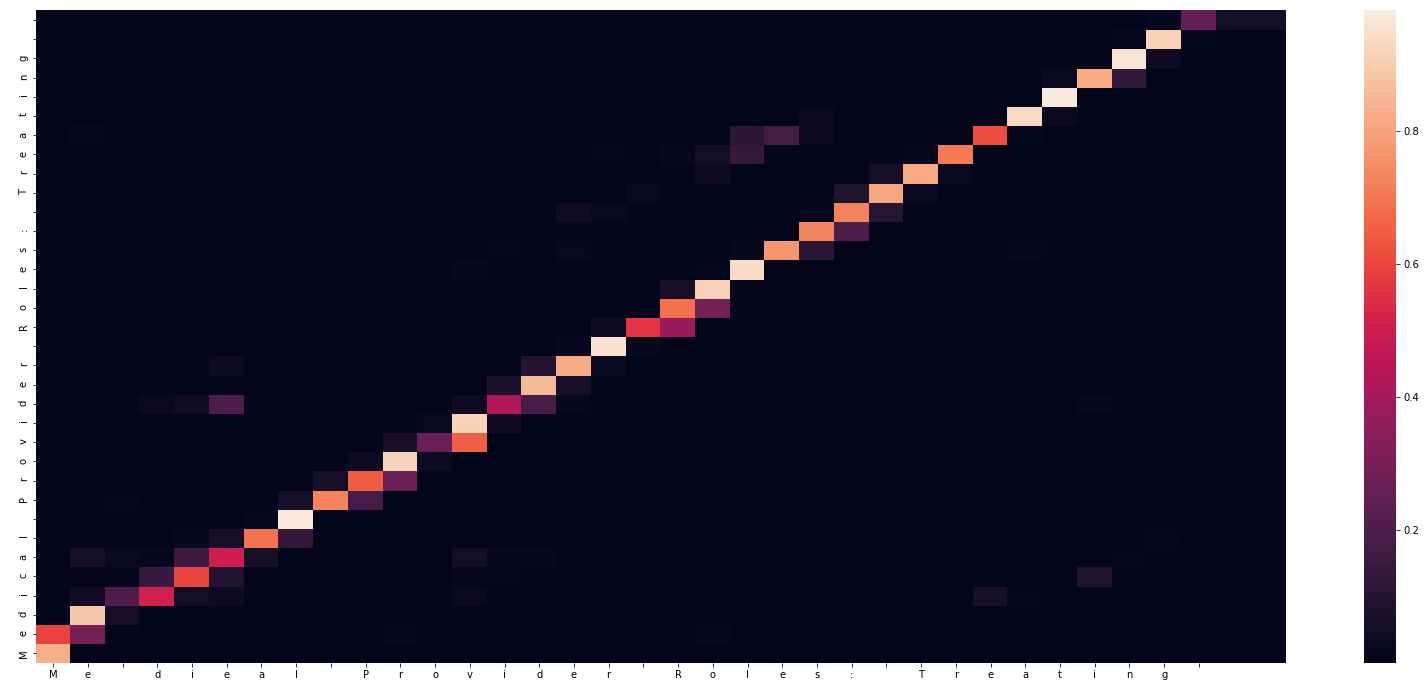

-
Input sentence: Me dieal Provider Roles: Treating 
GT sentence: Medical Provider Roles: Treating

Decoded sentence: Medical Provider Roles: Treating 



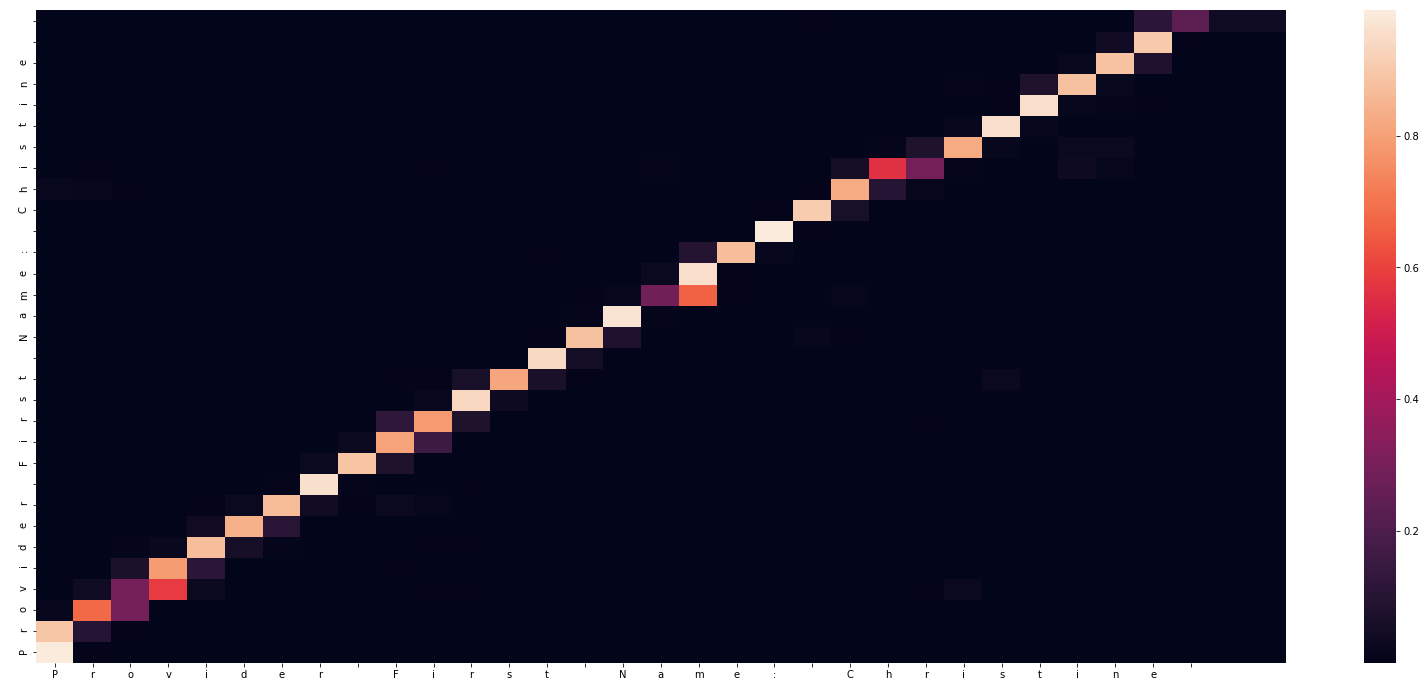

-
Input sentence: Provider First Name: Christine 
GT sentence: Provider First Name: Christine

Decoded sentence: Provider First Name: Chistine 



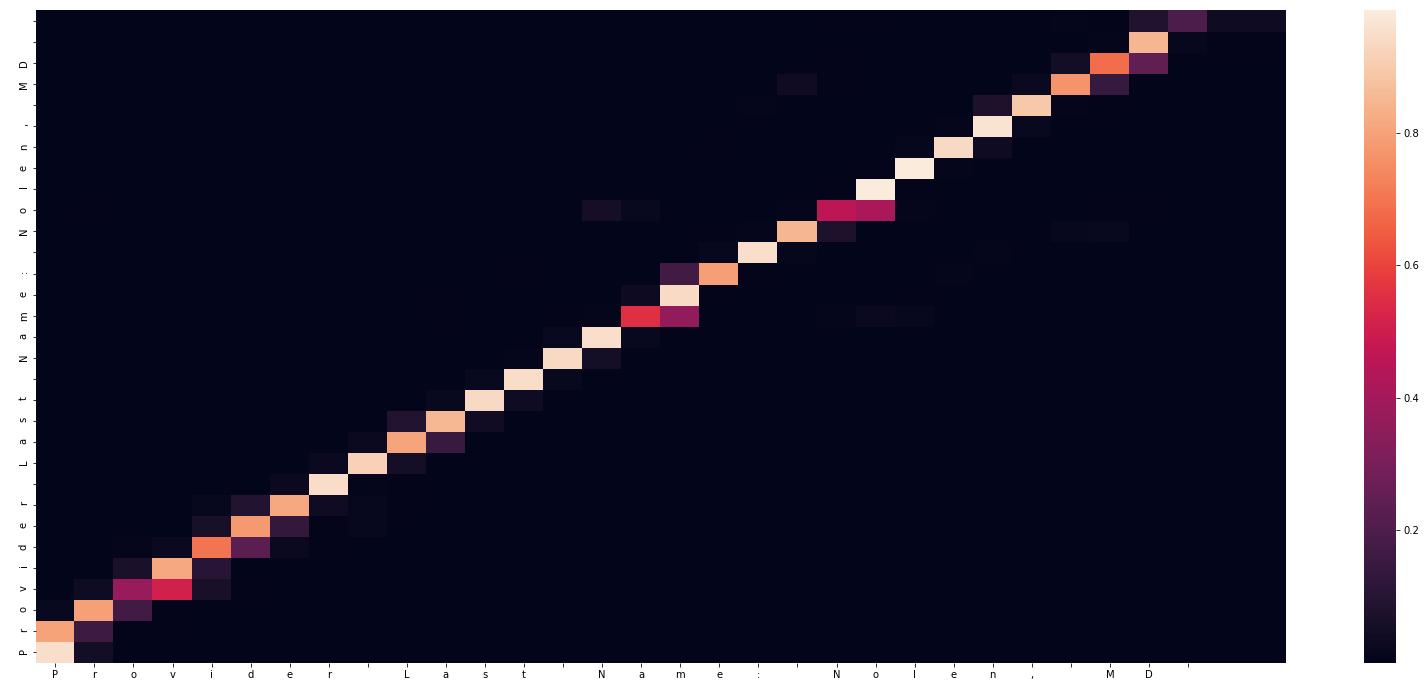

-
Input sentence: Provider Last Name: Nolen, MD 
GT sentence: Provider Last Name: Nolen, MD

Decoded sentence: Provider Last Name: Nolen, MD 



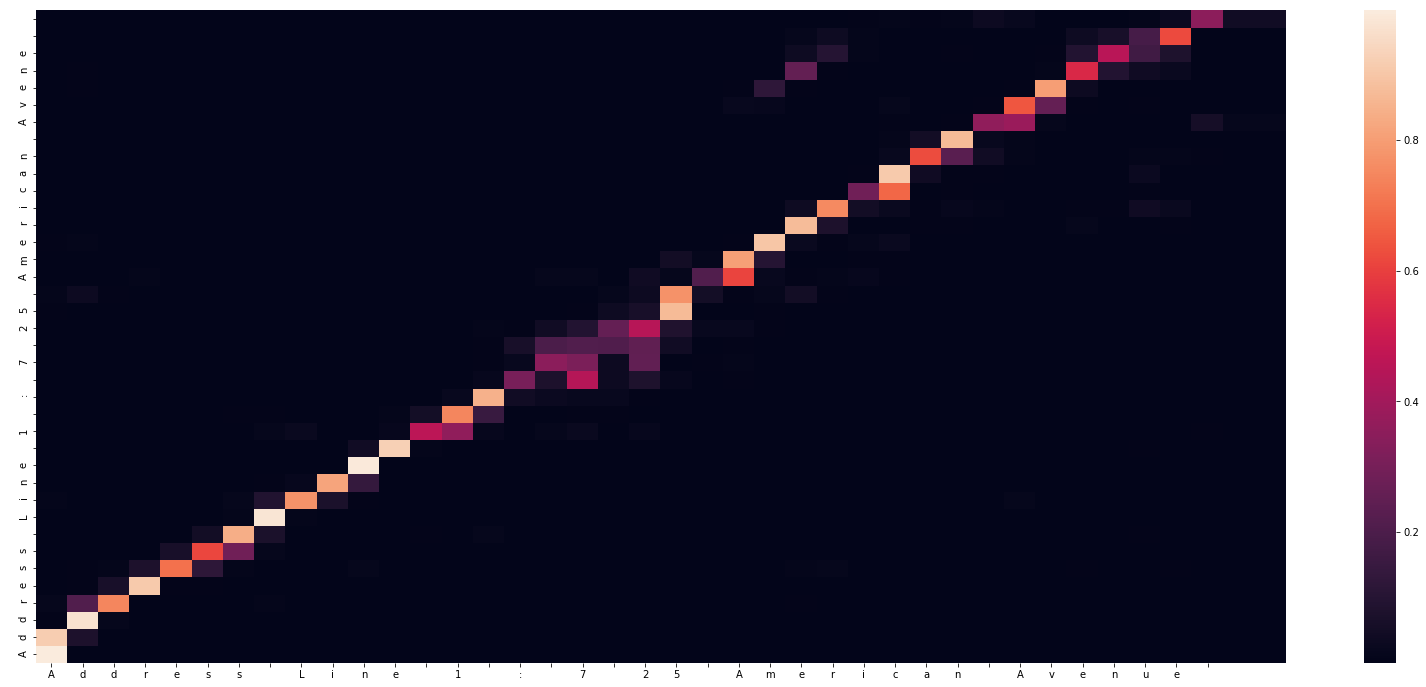

-
Input sentence: Address Line 1 : 7 25 American Avenue 
GT sentence: Address Line 1 : 725 American Avenue

Decoded sentence: Address Line 1 : 7 25 American Avene 



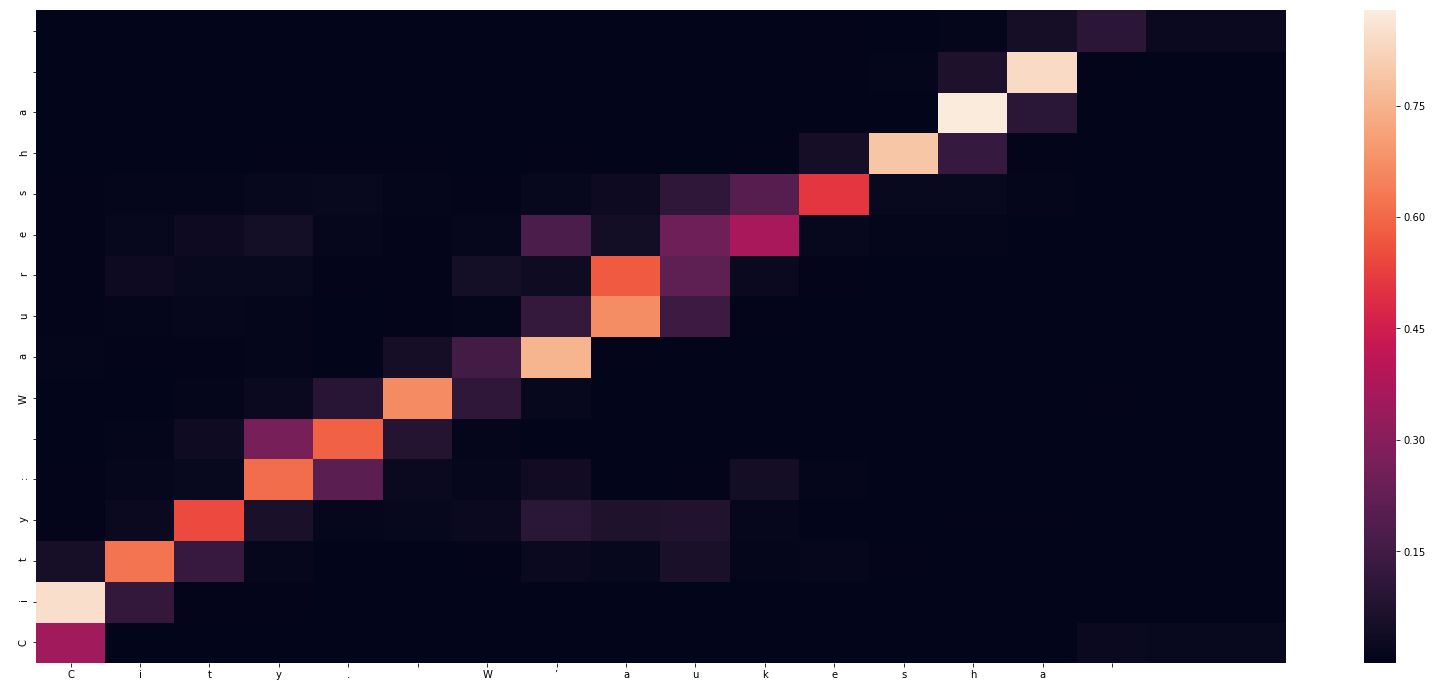

-
Input sentence: City. W’aukesha 
GT sentence: City: Waukesha

Decoded sentence: City: Wauresha 



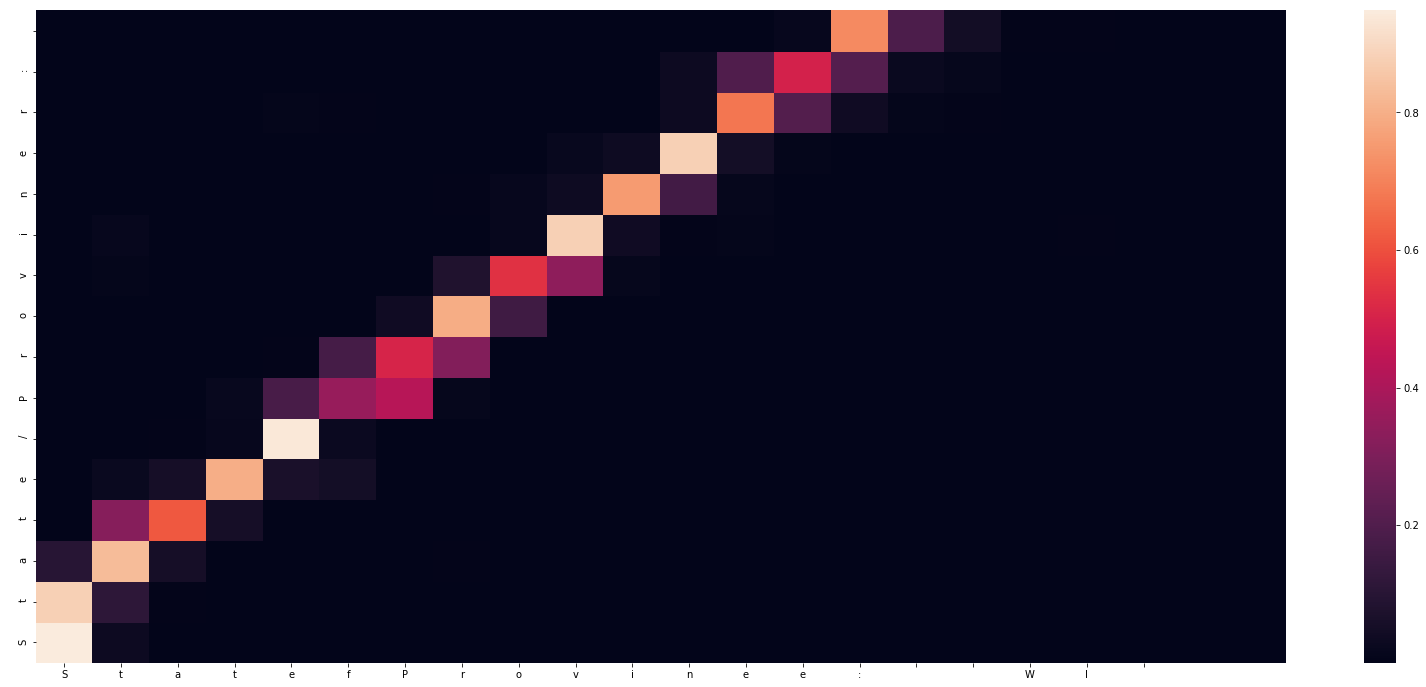

-
Input sentence: StatefProvinee: ‘WI 
GT sentence: State/Province: WI

Decoded sentence: State/Proviner:



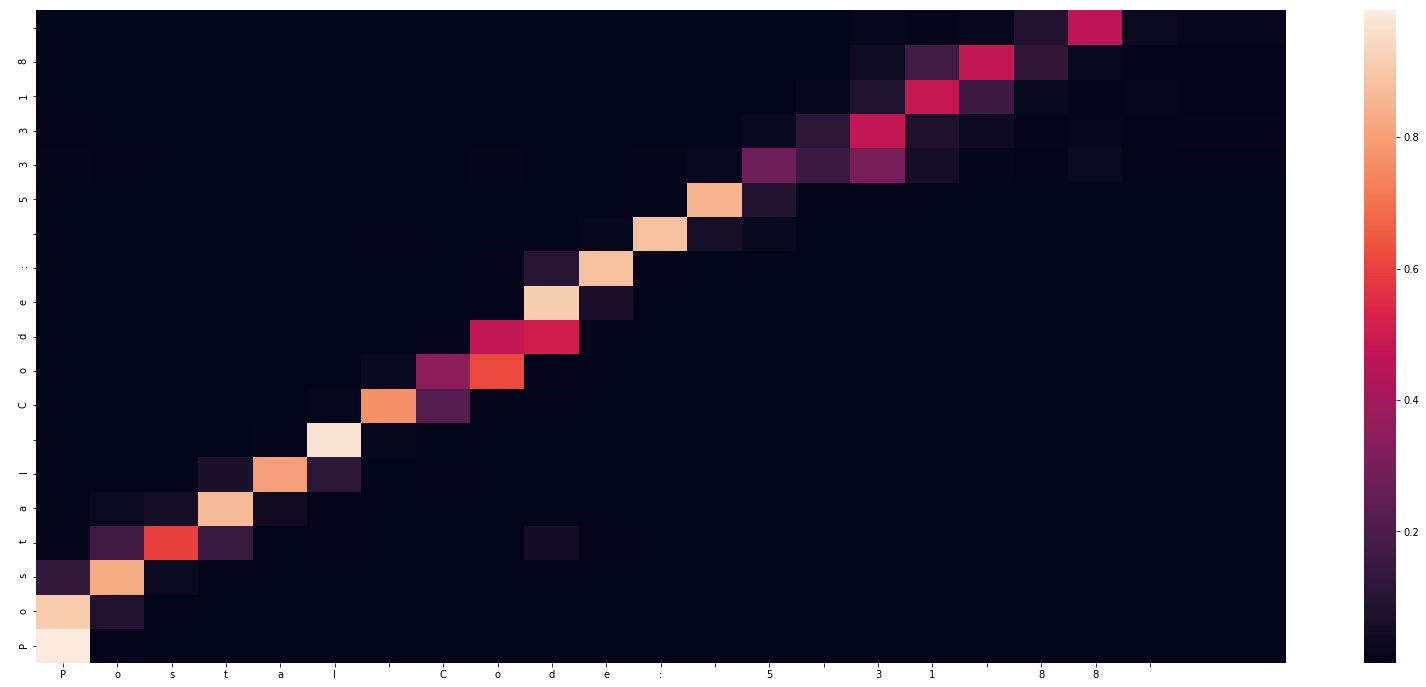

-
Input sentence: Postal Code: 5 31 88 
GT sentence: Postal Code: 53188

Decoded sentence: Postal Code: 53318



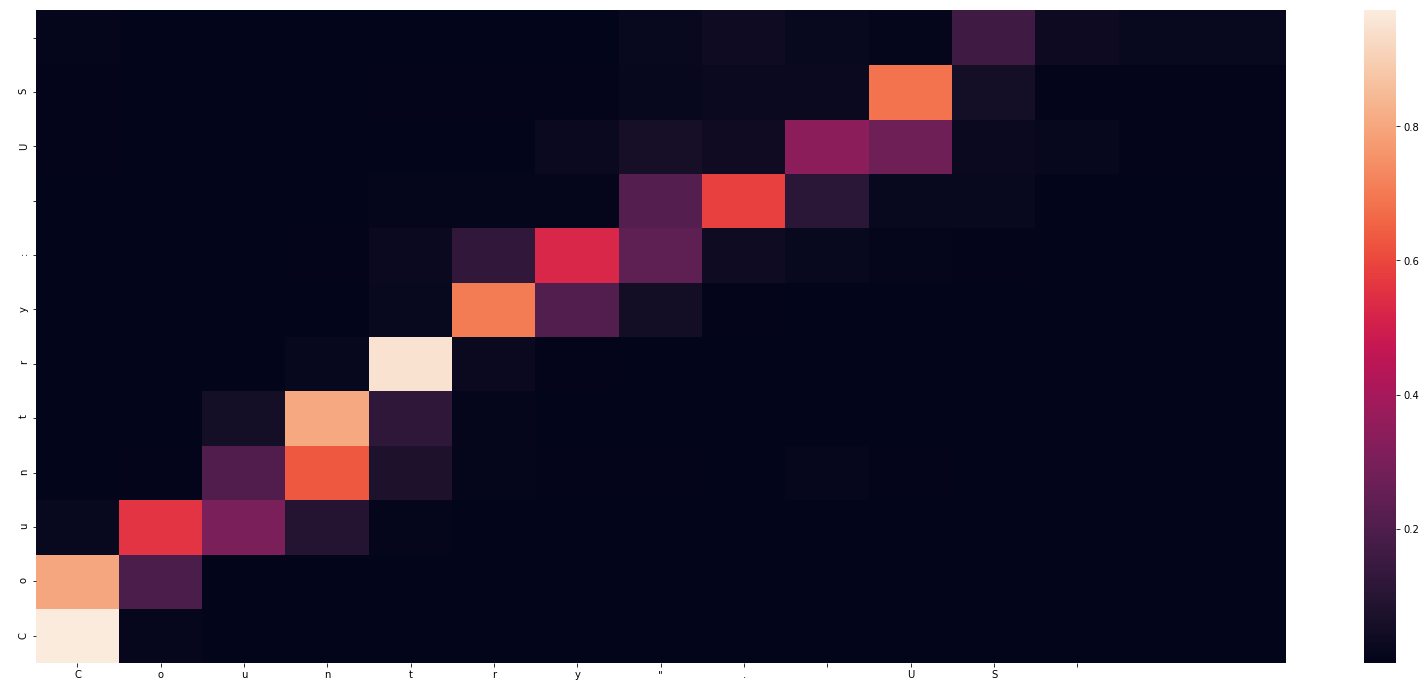

-
Input sentence: Country". US 
GT sentence: Country:  US

Decoded sentence: Country: US



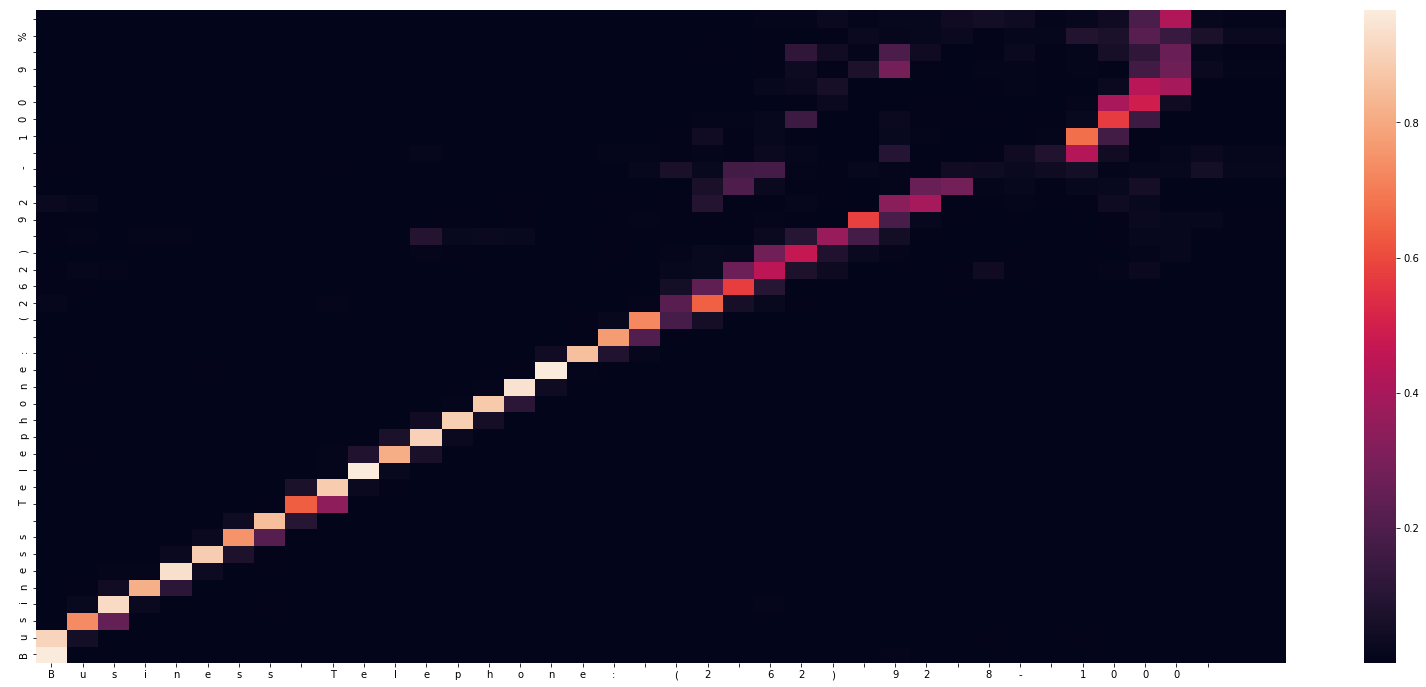

-
Input sentence: Business Telephone: (2 62) 92 8- 1000 
GT sentence: Business Telephone: (262) 928- 1000

Decoded sentence: Business Telephone: (262) 92 - 100 9 %



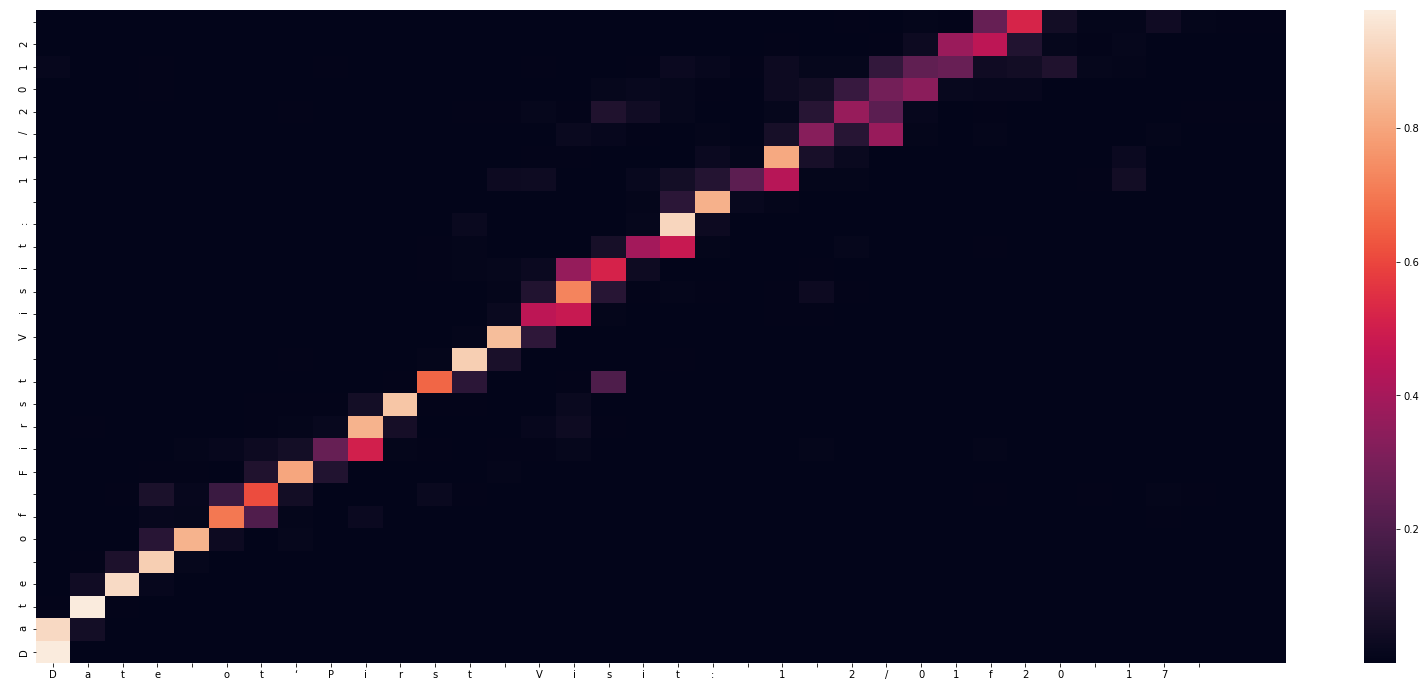

-
Input sentence: Date ot‘Pirst Visit: 1 2/01f20 17 
GT sentence: Date of First Visit: 12/01/2017

Decoded sentence: Date of First Visit: 11/2012



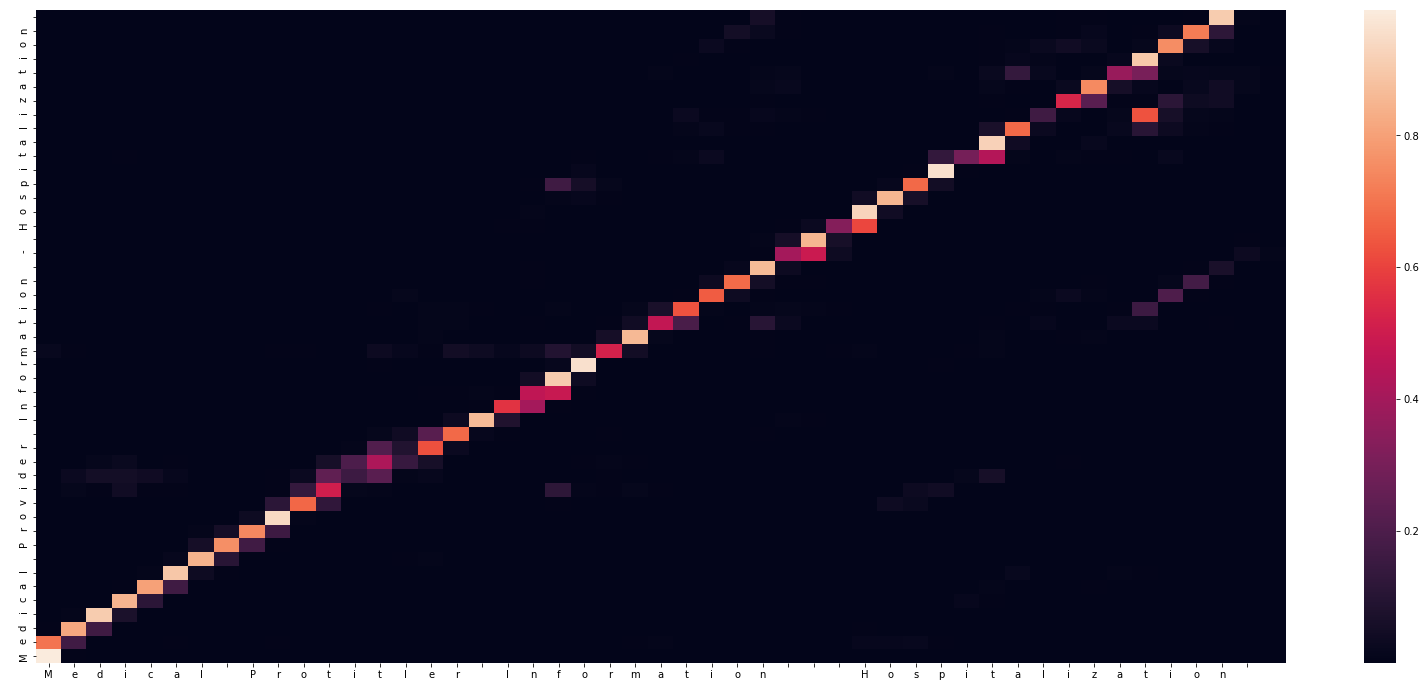

-
Input sentence: Medical Protitler Information — Hospitalization 
GT sentence: Medical Provider Information - Hospitalization

Decoded sentence: Medical Provider Information - Hospitalization



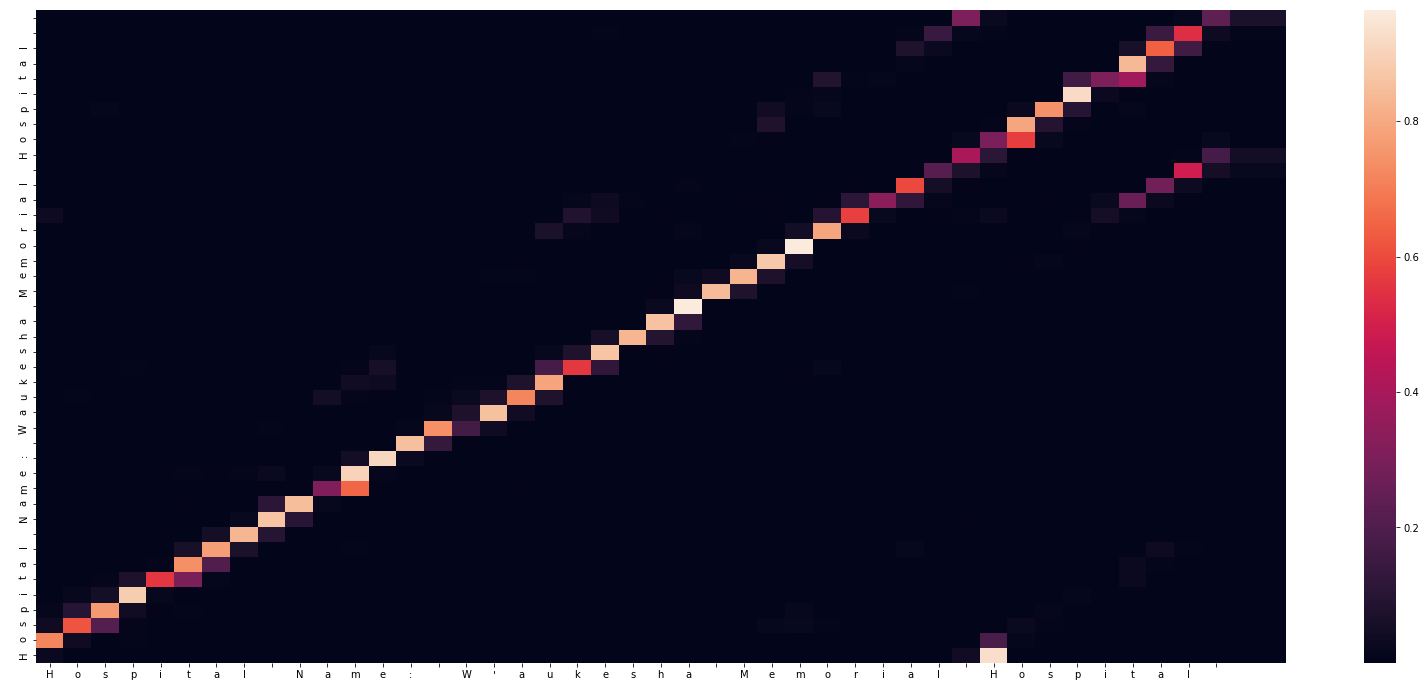

-
Input sentence: Hospital Name: W'aukesha Memorial Hospital 
GT sentence: Hospital Name: Waukesha Memorial Hospital

Decoded sentence: Hospital Name: Waukesha Memorial Hospital 



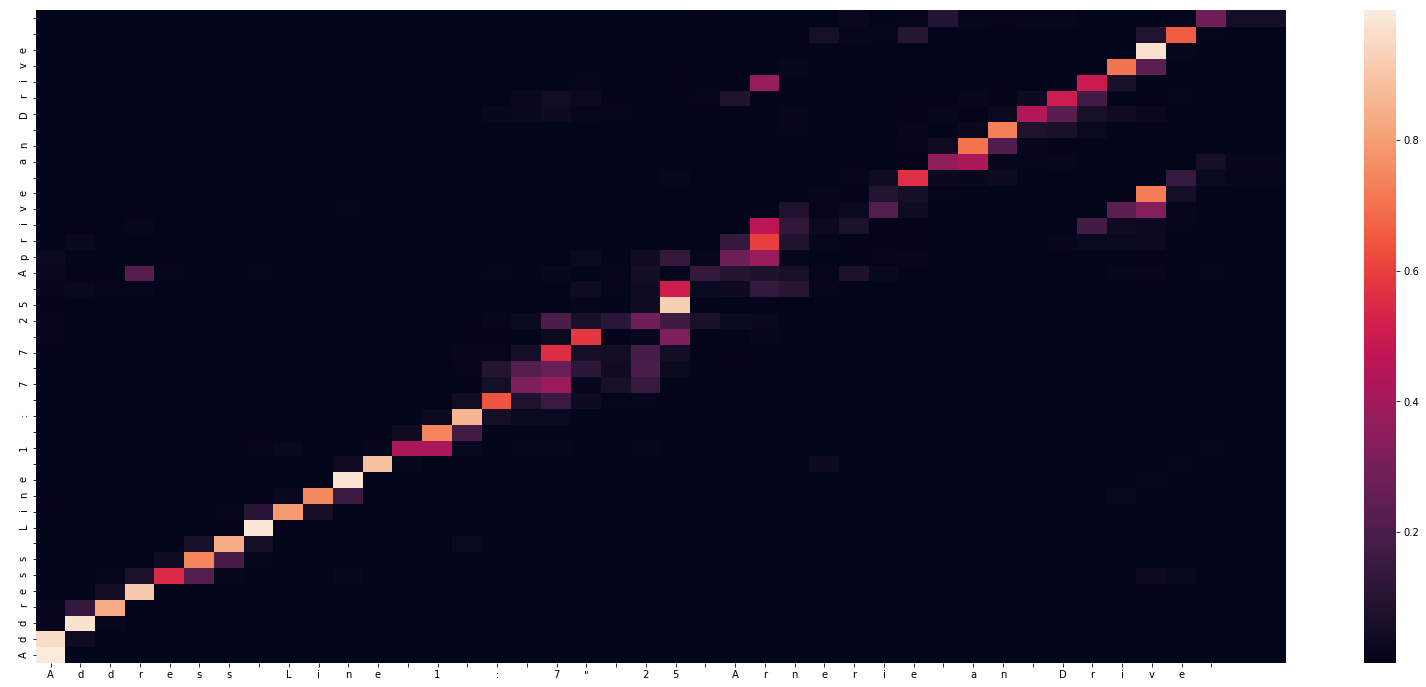

-
Input sentence: Address Line 1 : 7" 25 Arnerie an Drive 
GT sentence: Address Line 1 : 725 American Drive

Decoded sentence: Address Line 1 : 7 7 25 Aprive an Drive 



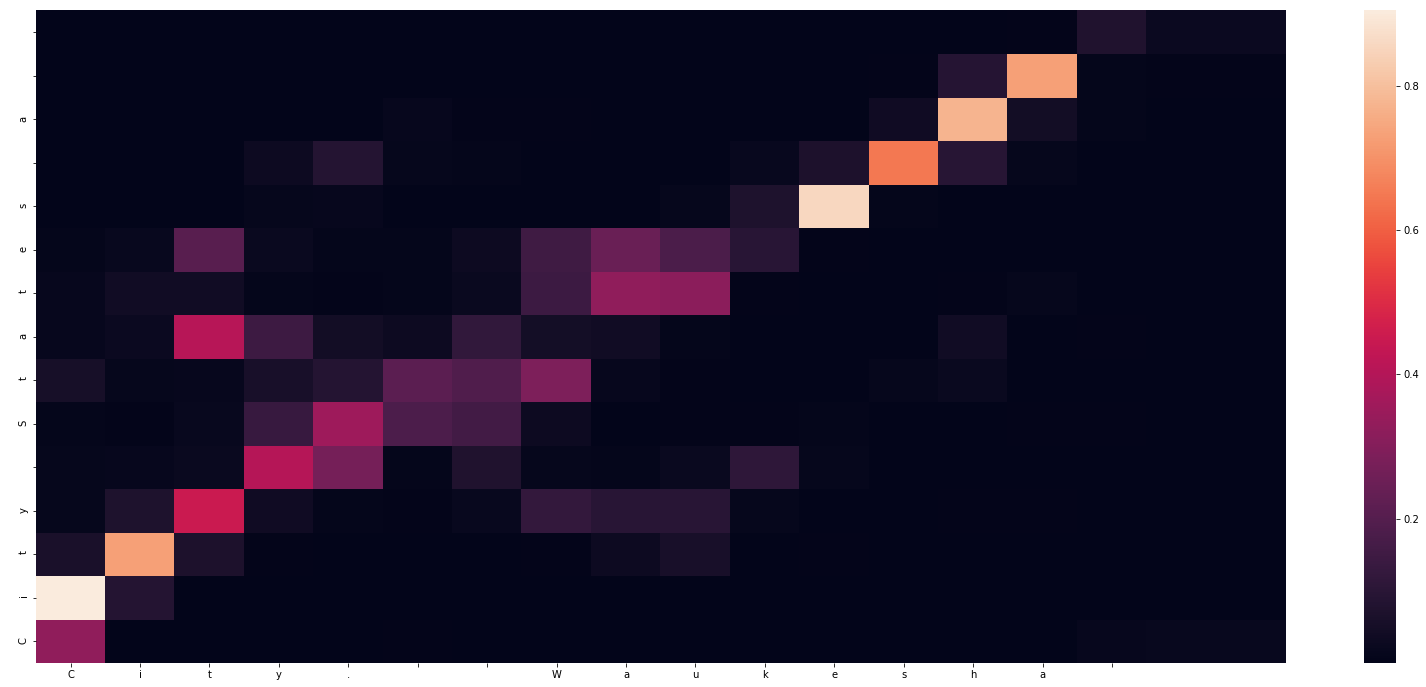

-
Input sentence: City. ‘Waukesha 
GT sentence: City: Waukesha

Decoded sentence: City States a 



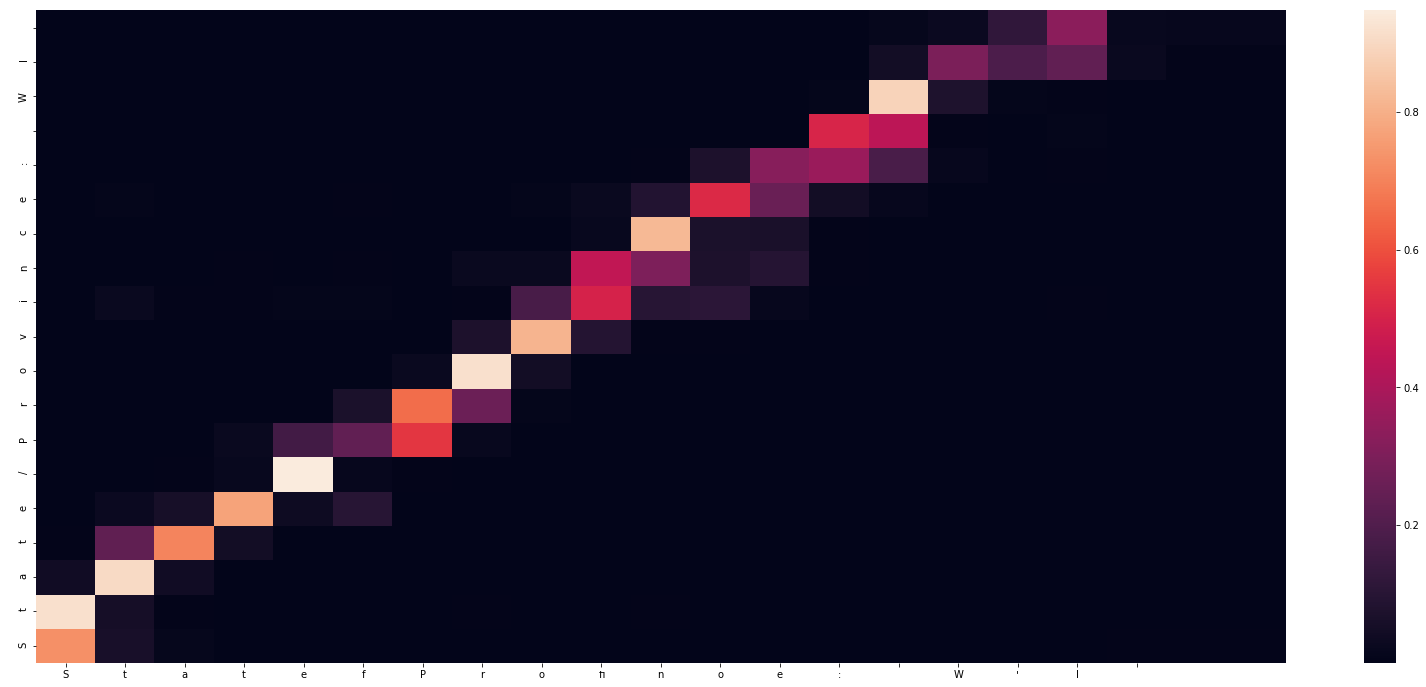

-
Input sentence: StatefProﬁnoe: W'I 
GT sentence: State/Province: WI

Decoded sentence: State/Province: WI



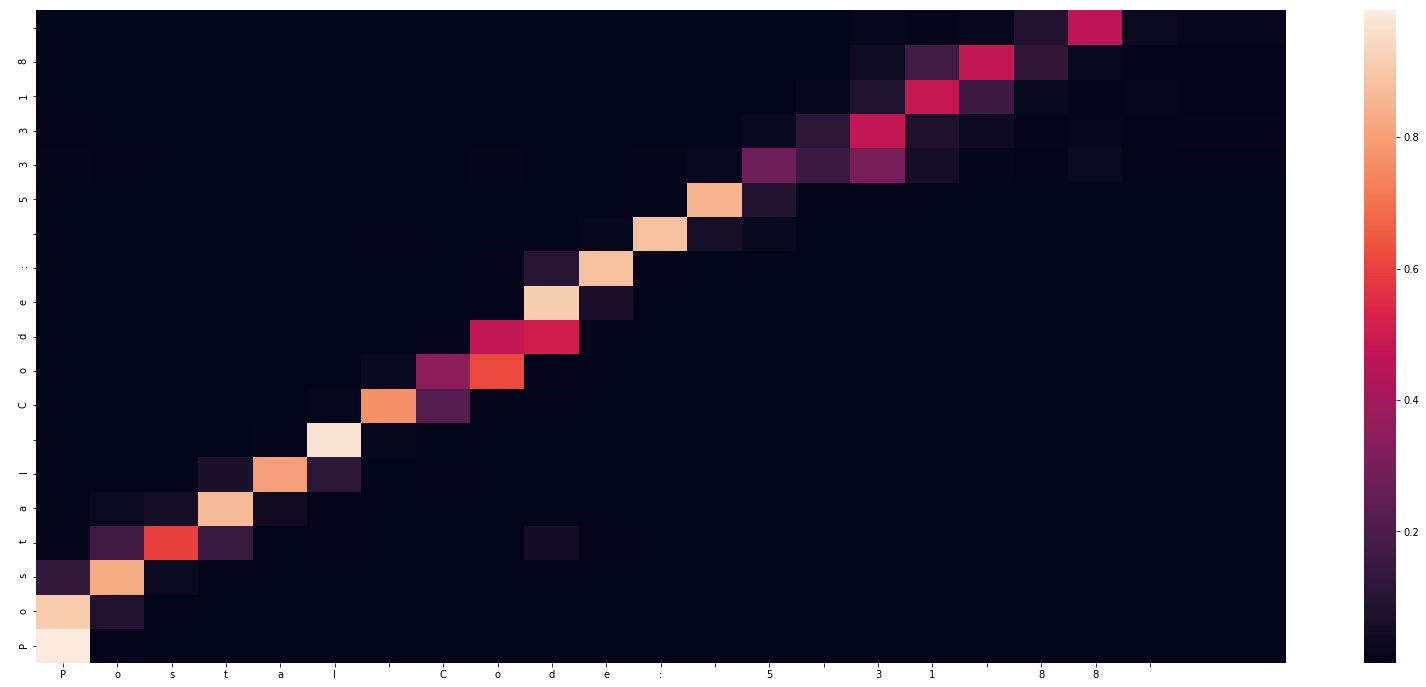

-
Input sentence: Postal Code: 5 31 88 
GT sentence: Postal Code: 53188

Decoded sentence: Postal Code: 53318



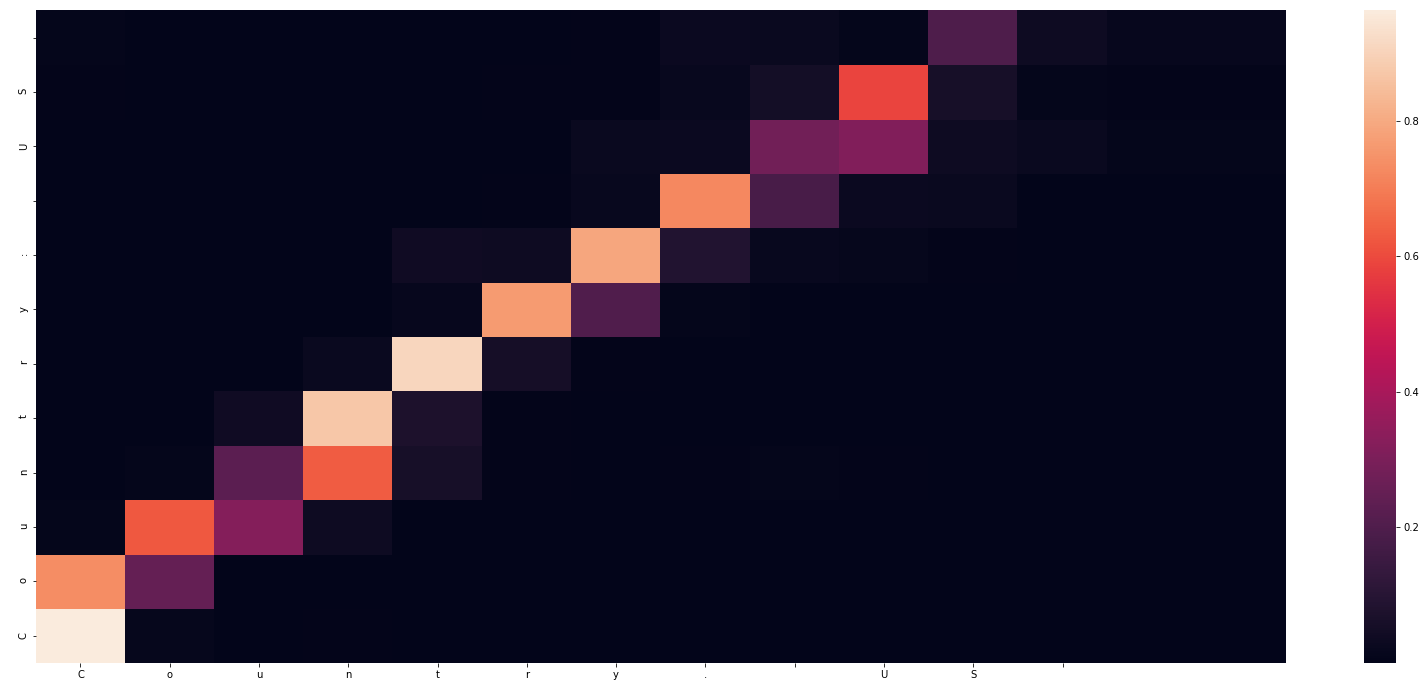

-
Input sentence: Country. US 
GT sentence: Country: US

Decoded sentence: Country: US



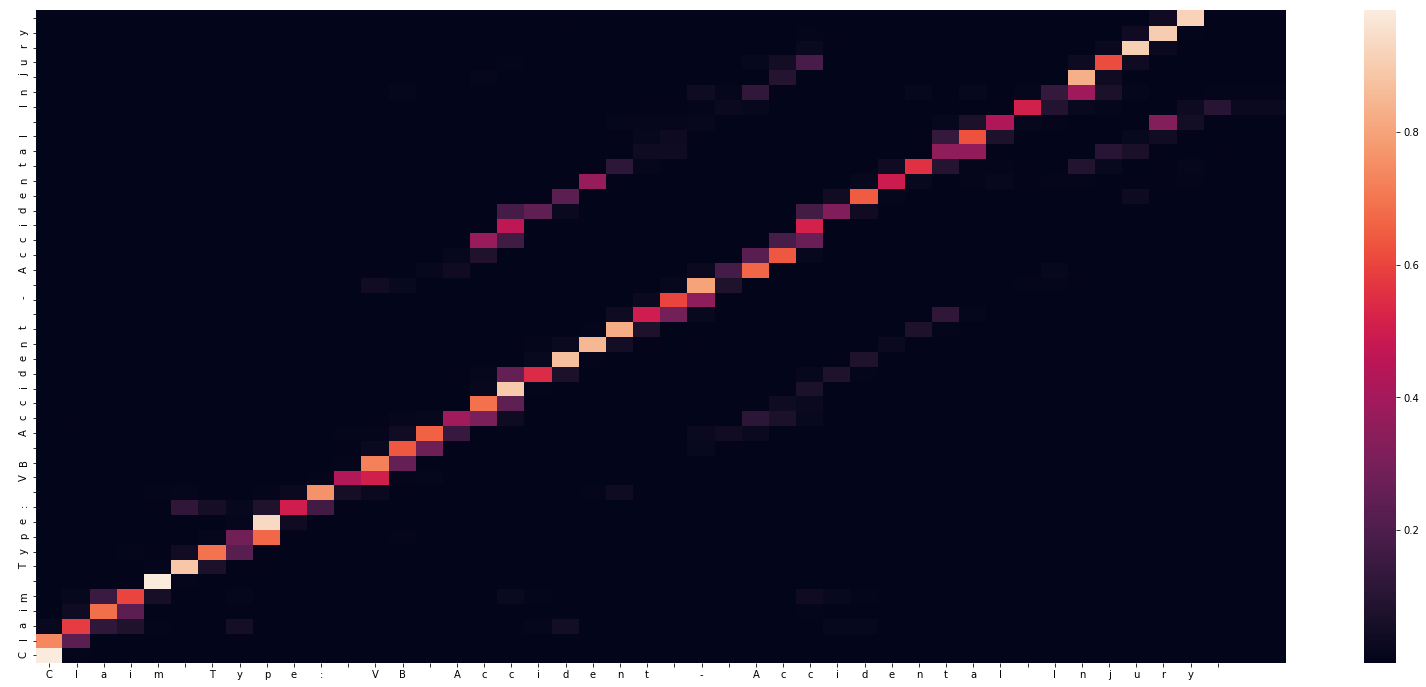

-
Input sentence: Claim Type: VB Accident - Accidental Injury 
GT sentence: Claim Type: VB Accident - Accidental Injury

Decoded sentence: Claim Type: VB Accident - Accidental Injury



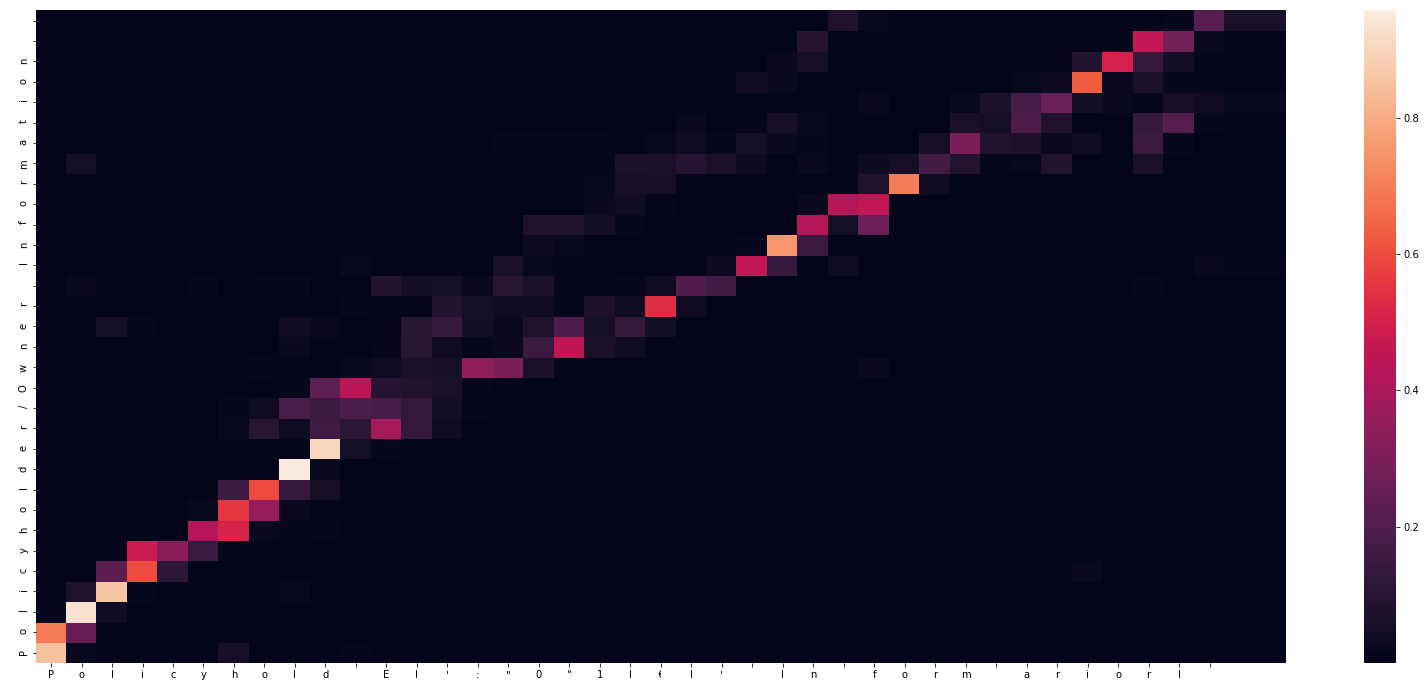

-
Input sentence: Policyhold El':"0“1l€l' In form ariorl 
GT sentence: Policyholder/Owner Information

Decoded sentence: Policyholder/Owner Information 



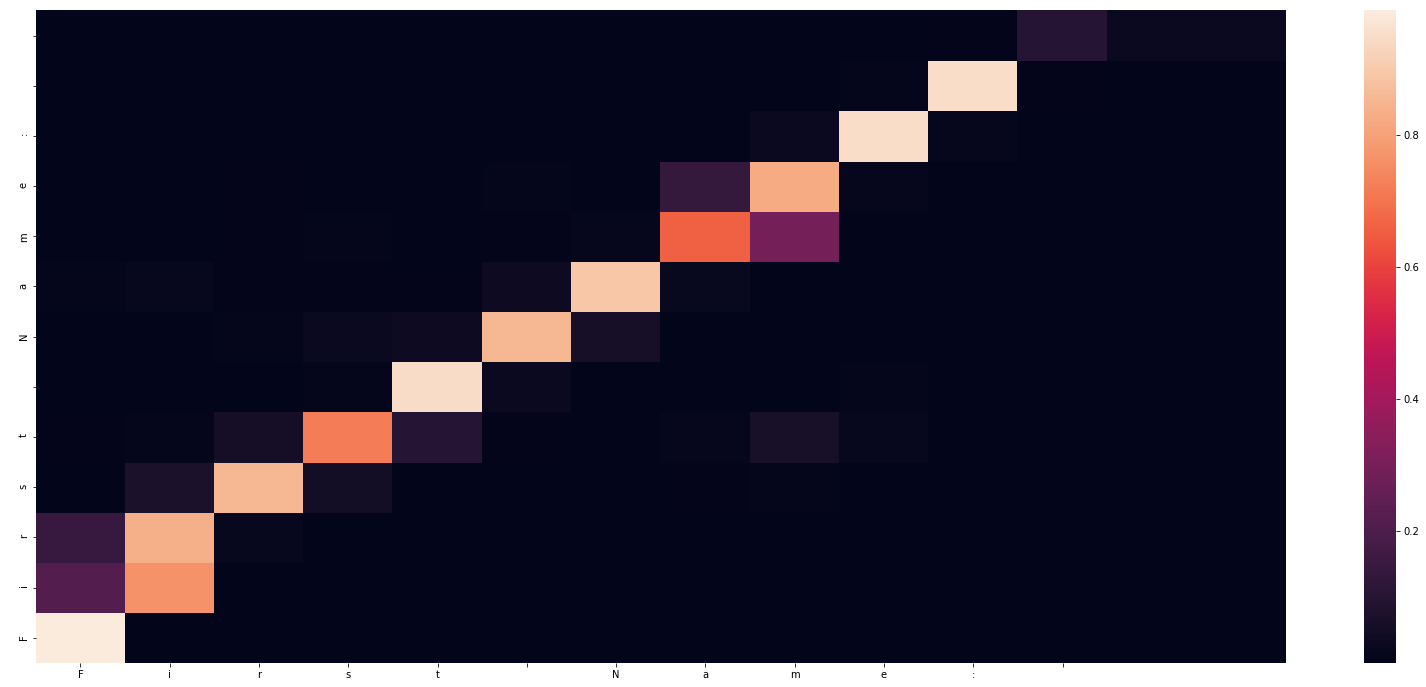

-
Input sentence: First Name: 
GT sentence: First Name:

Decoded sentence: First Name: 



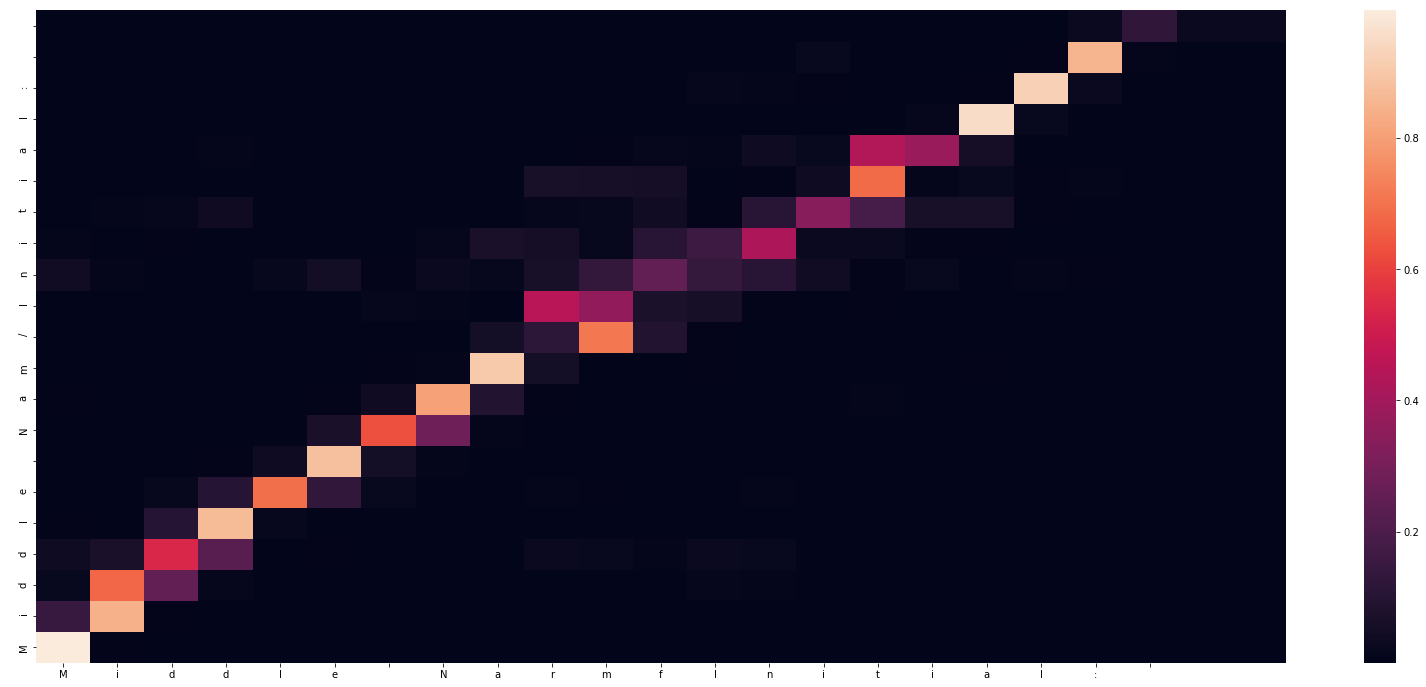

-
Input sentence: Middle Narmflnitial: 
GT sentence: Middle Name/Initial:

Decoded sentence: Middle Nam/Initial: 



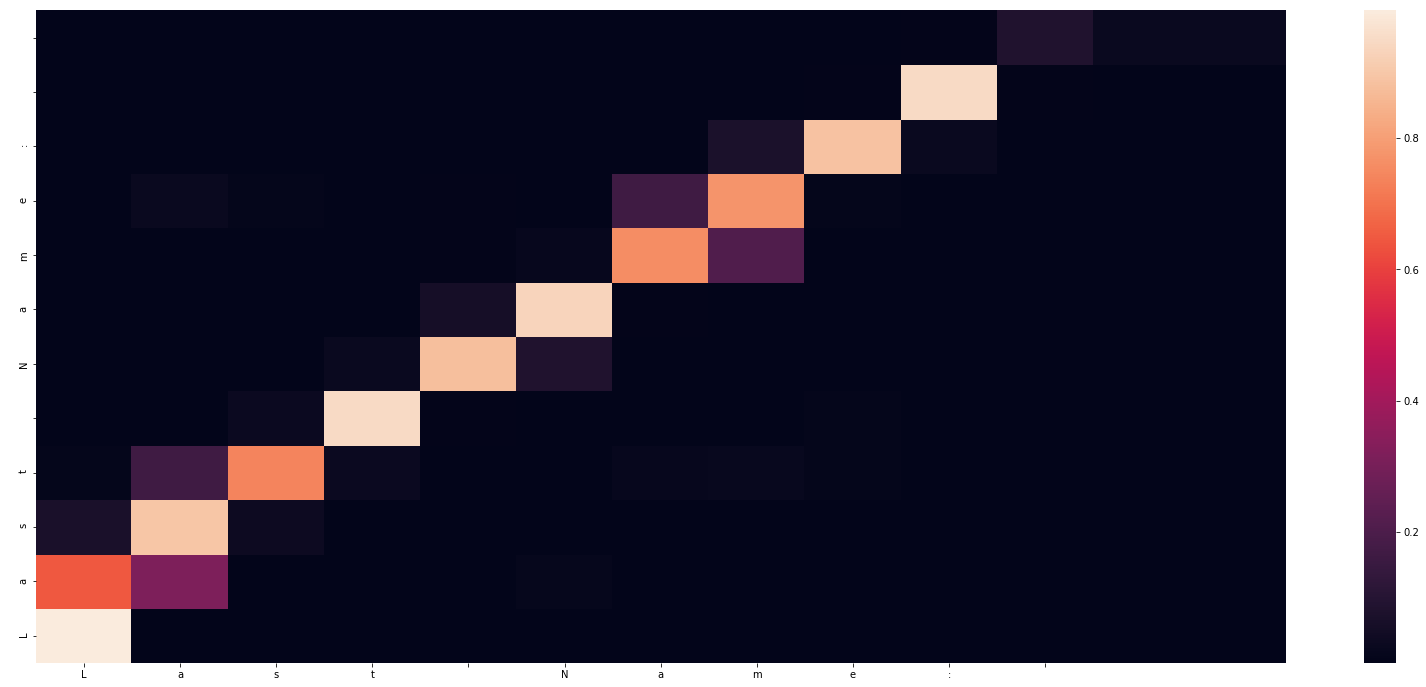

-
Input sentence: Last Name: 
GT sentence: Last Name:

Decoded sentence: Last Name: 



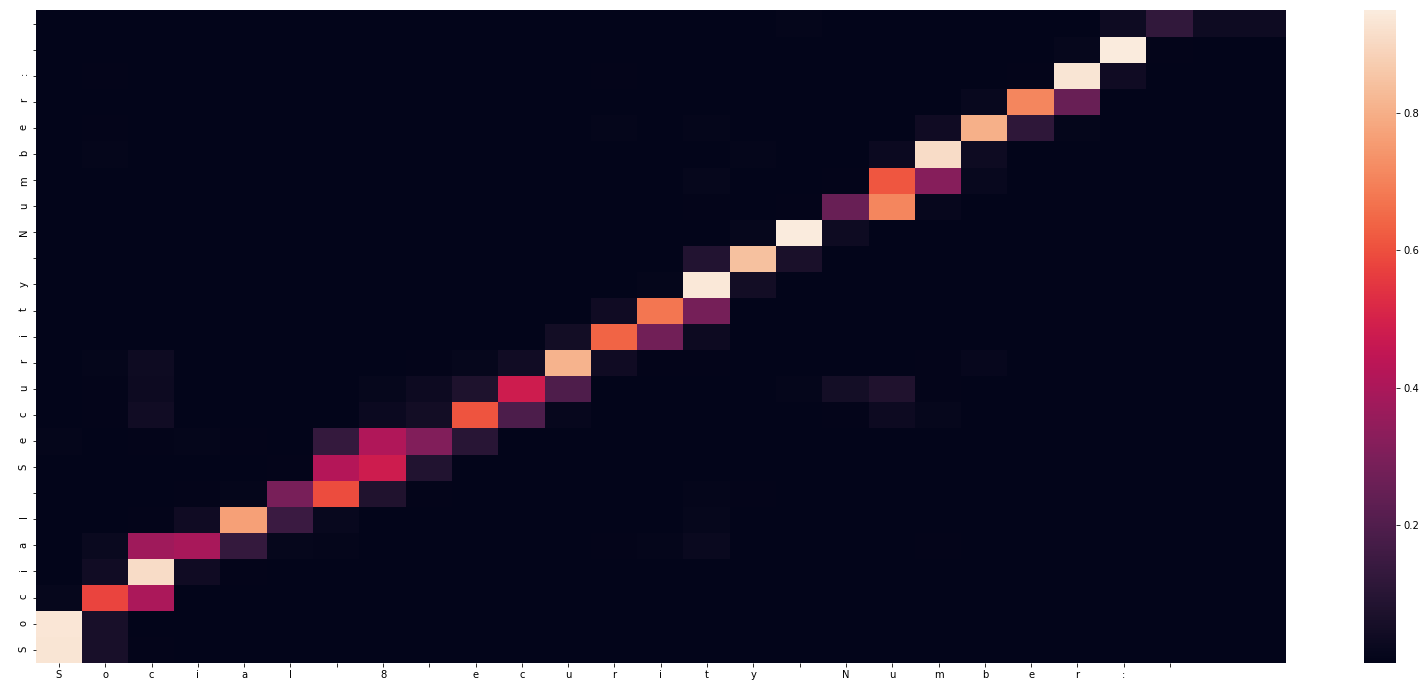

-
Input sentence: Social 8 ecurity Number: 
GT sentence: Social Security Number:

Decoded sentence: Social Security Number: 



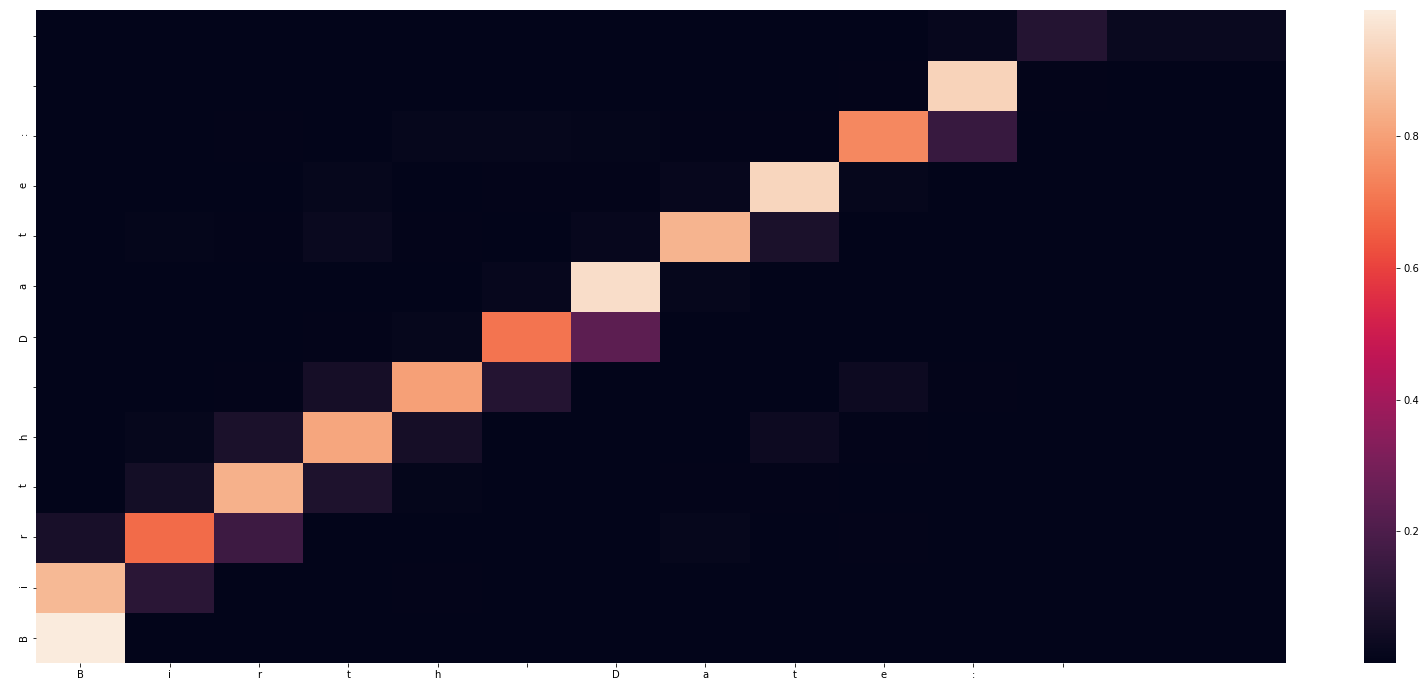

-
Input sentence: Birth Date: 
GT sentence: Birth Date:

Decoded sentence: Birth Date: 



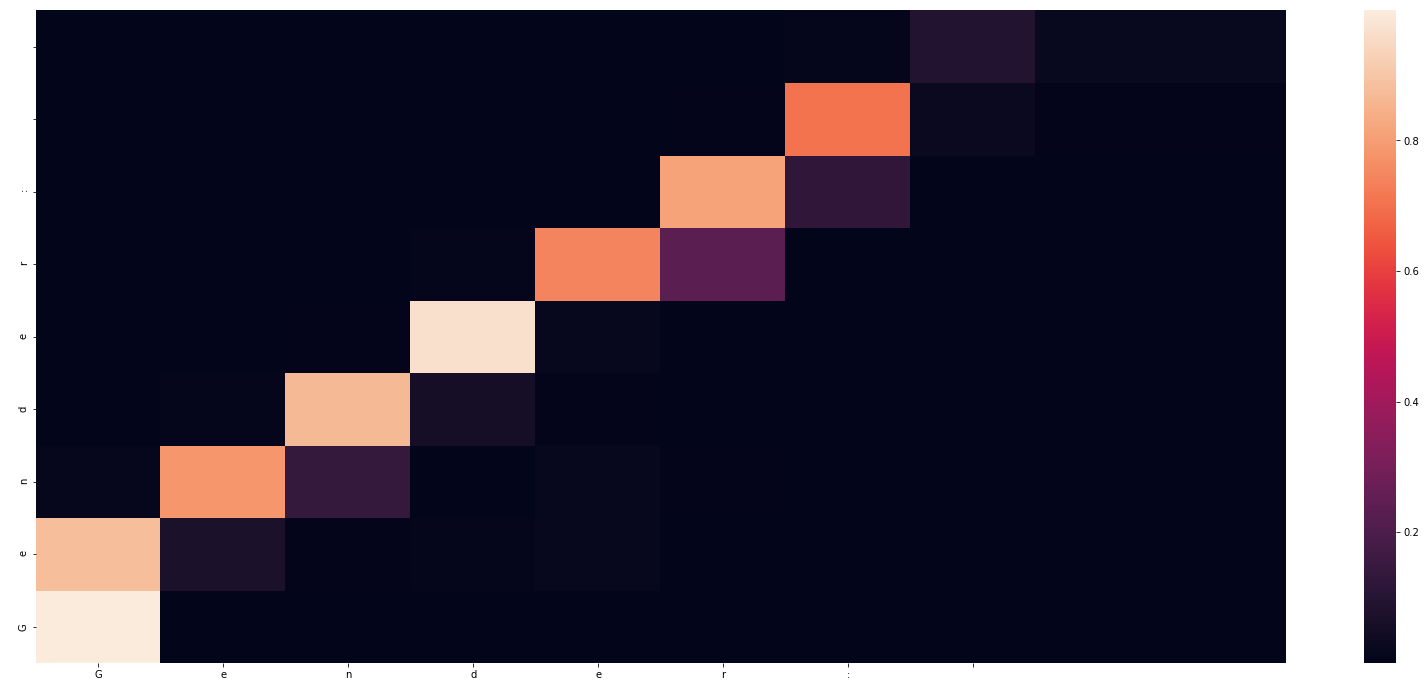

-
Input sentence: Gender: 
GT sentence: Gender:

Decoded sentence: Gender: 



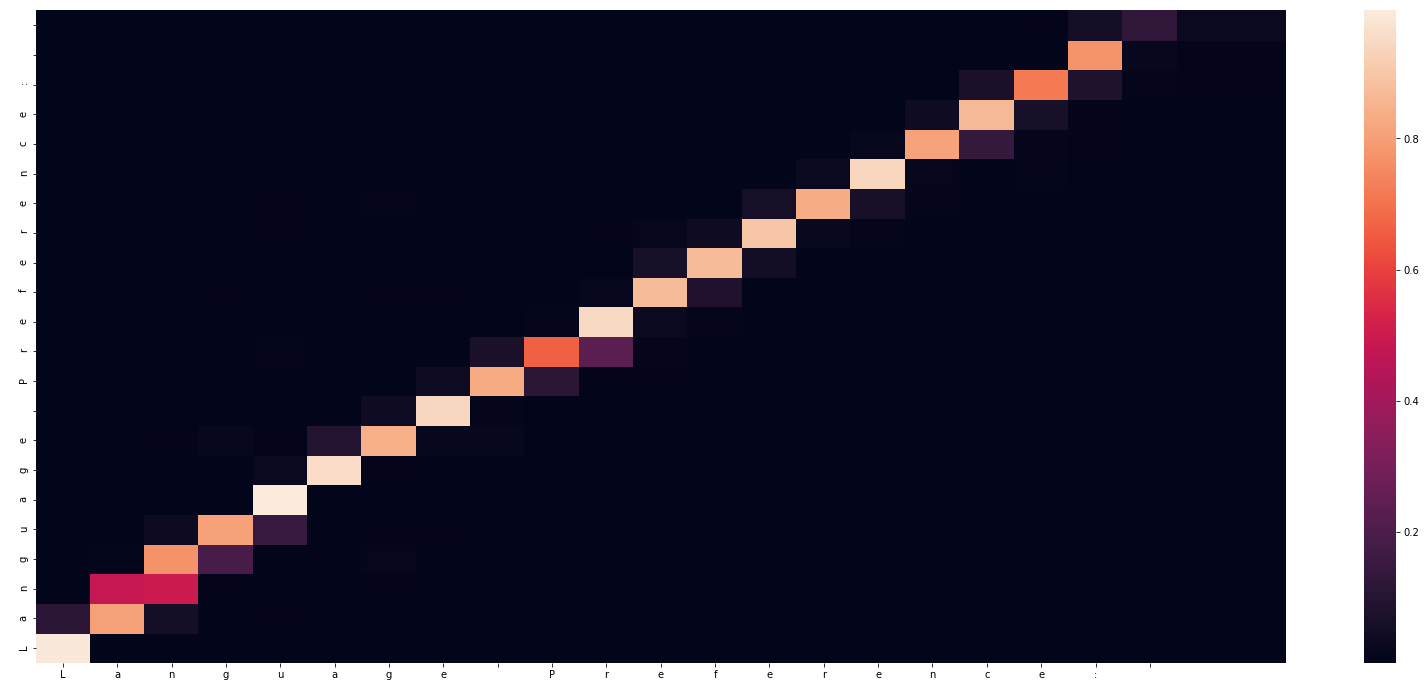

-
Input sentence: Language Preference: 
GT sentence: Language Preference:

Decoded sentence: Language Preference: 



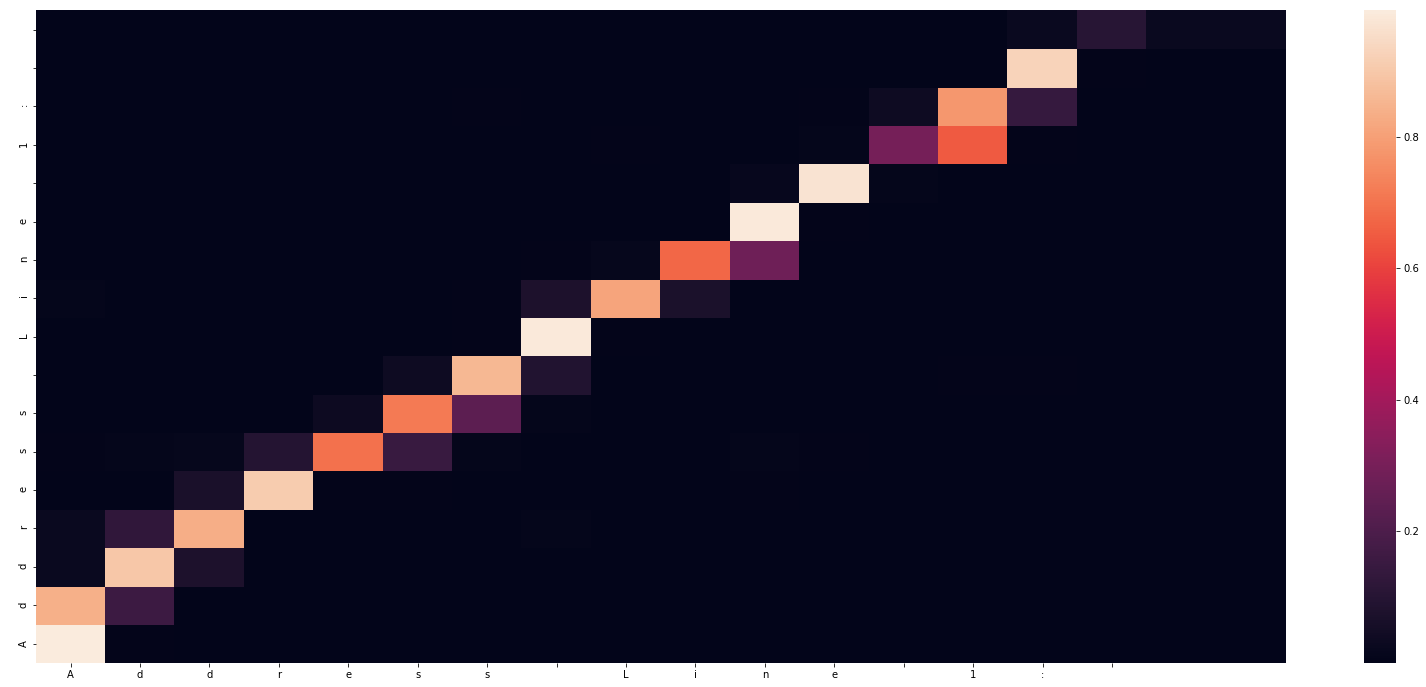

-
Input sentence: Address Line 1: 
GT sentence: Address Line 1:

Decoded sentence: Address Line 1: 



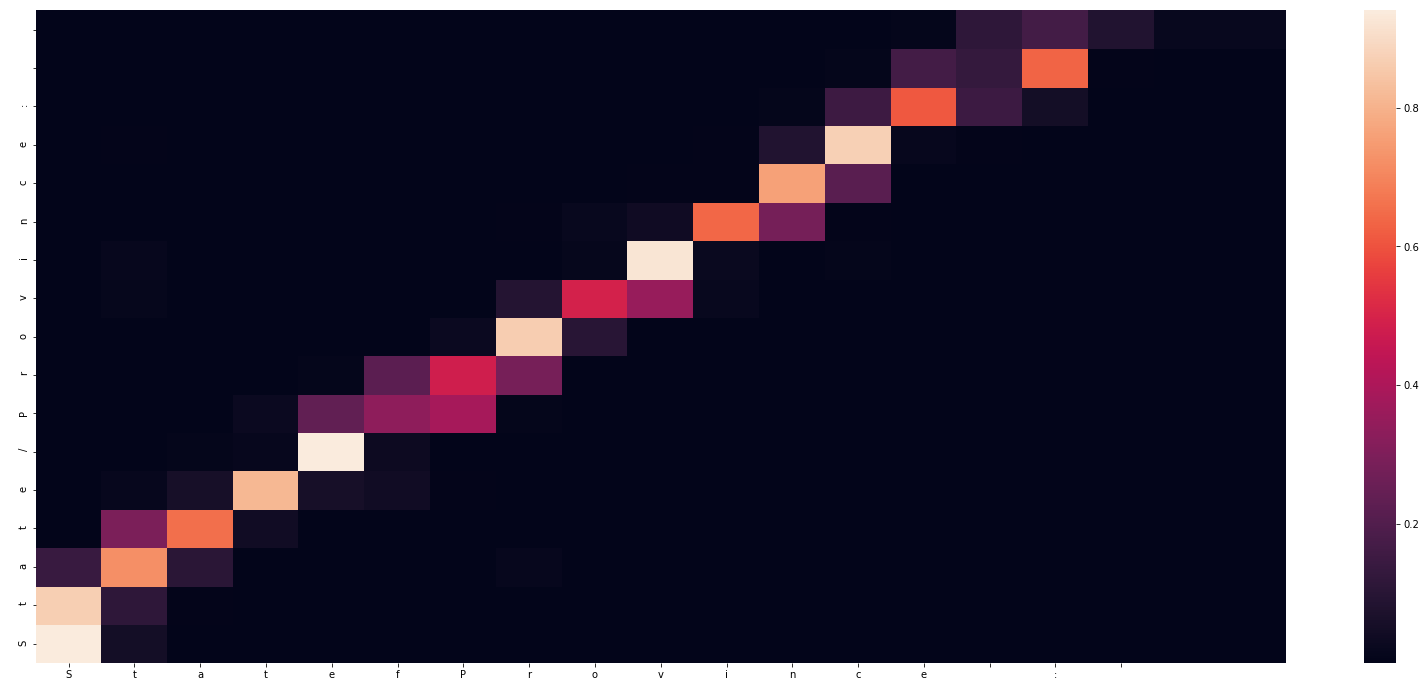

-
Input sentence: StatefProvince : 
GT sentence: State/Province:

Decoded sentence: State/Province: 



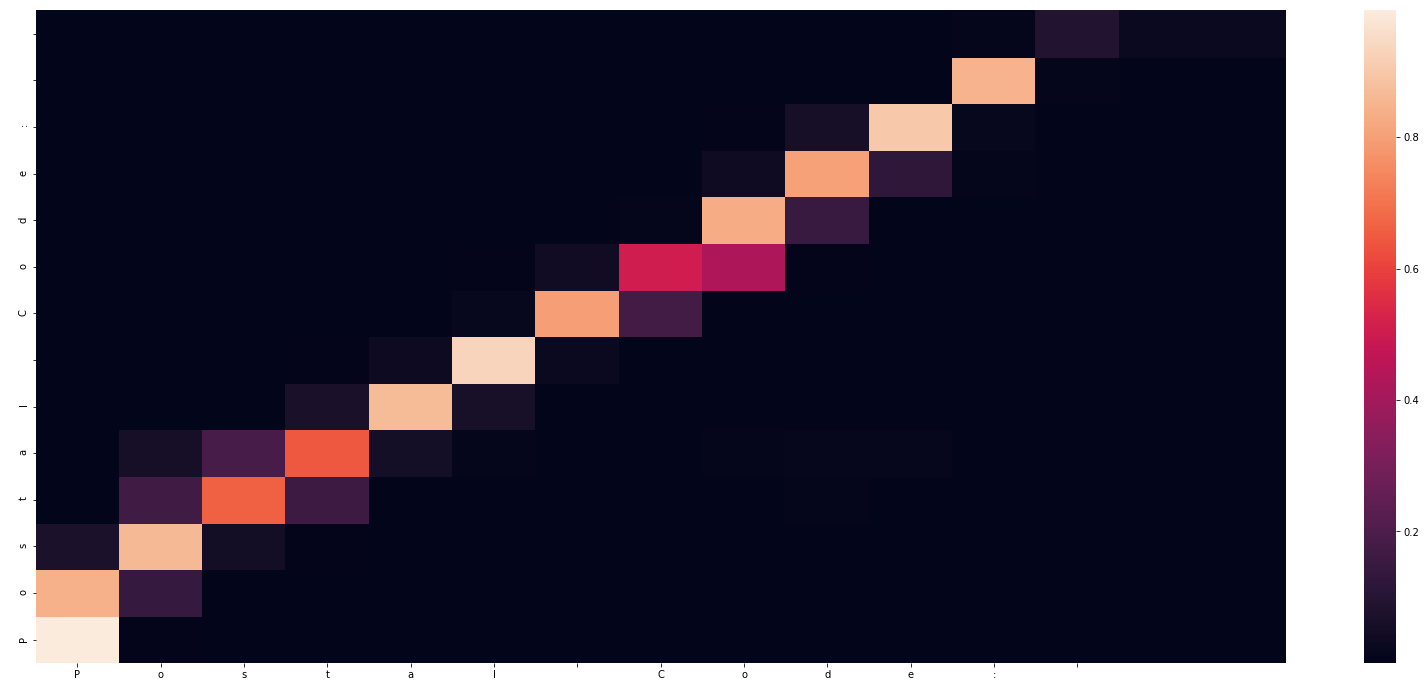

-
Input sentence: Postal Code: 
GT sentence: Postal Code:

Decoded sentence: Postal Code: 



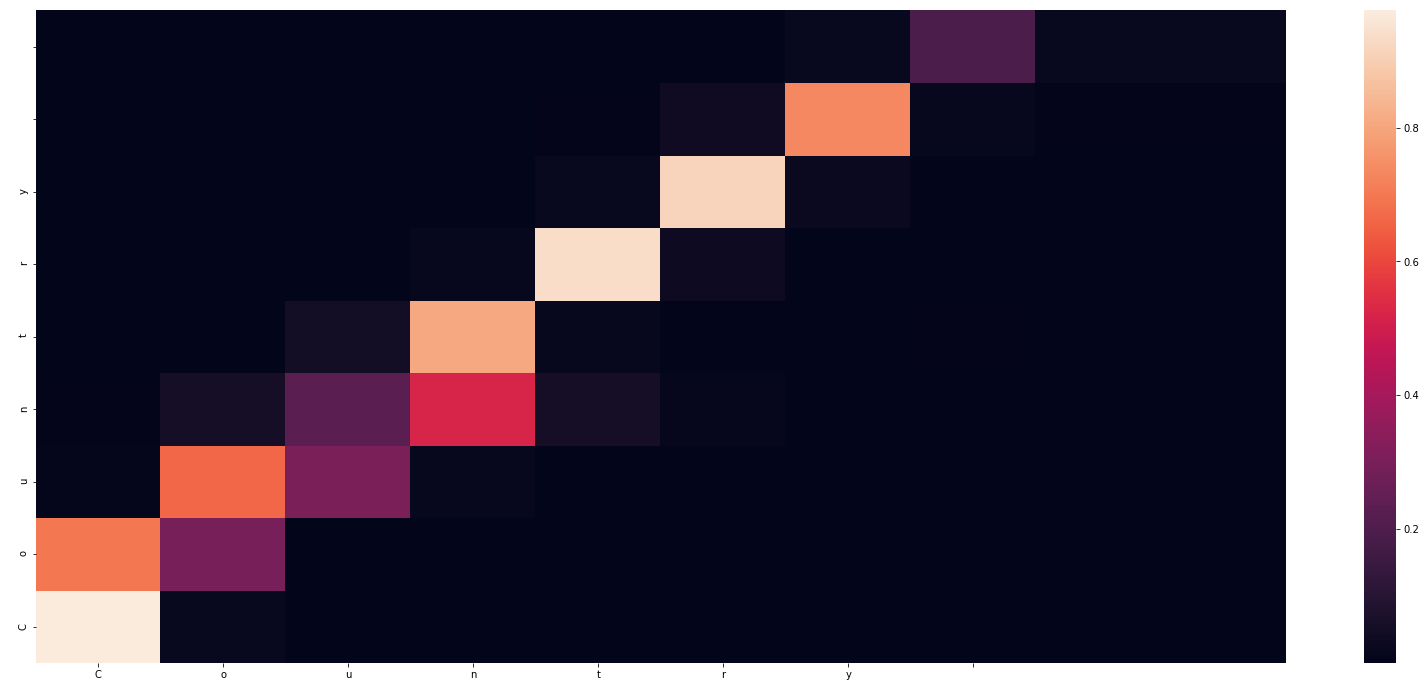

-
Input sentence: Country 
GT sentence: Country:

Decoded sentence: Country 



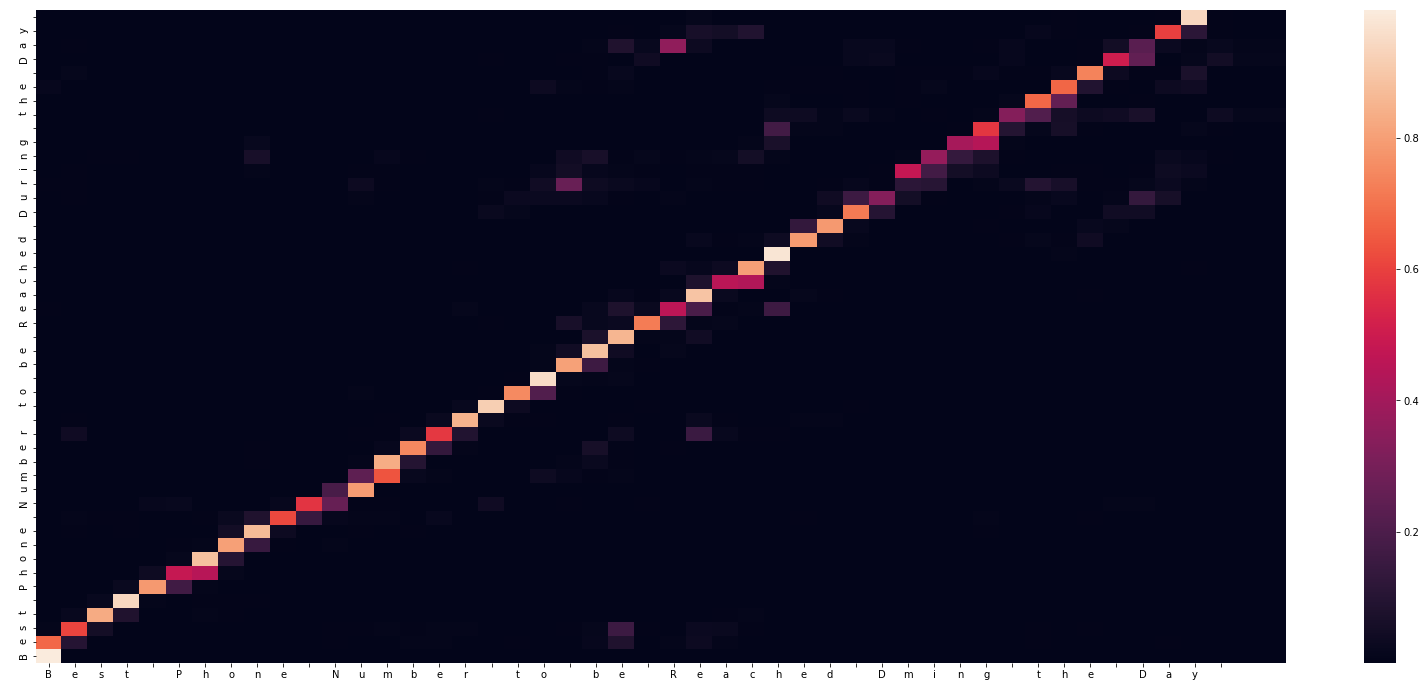

-
Input sentence: Best Phone Number to be Reached Dming the Day 
GT sentence: Best Phone Number to be Reached During the Day

Decoded sentence: Best Phone Number to be Reached During the Day



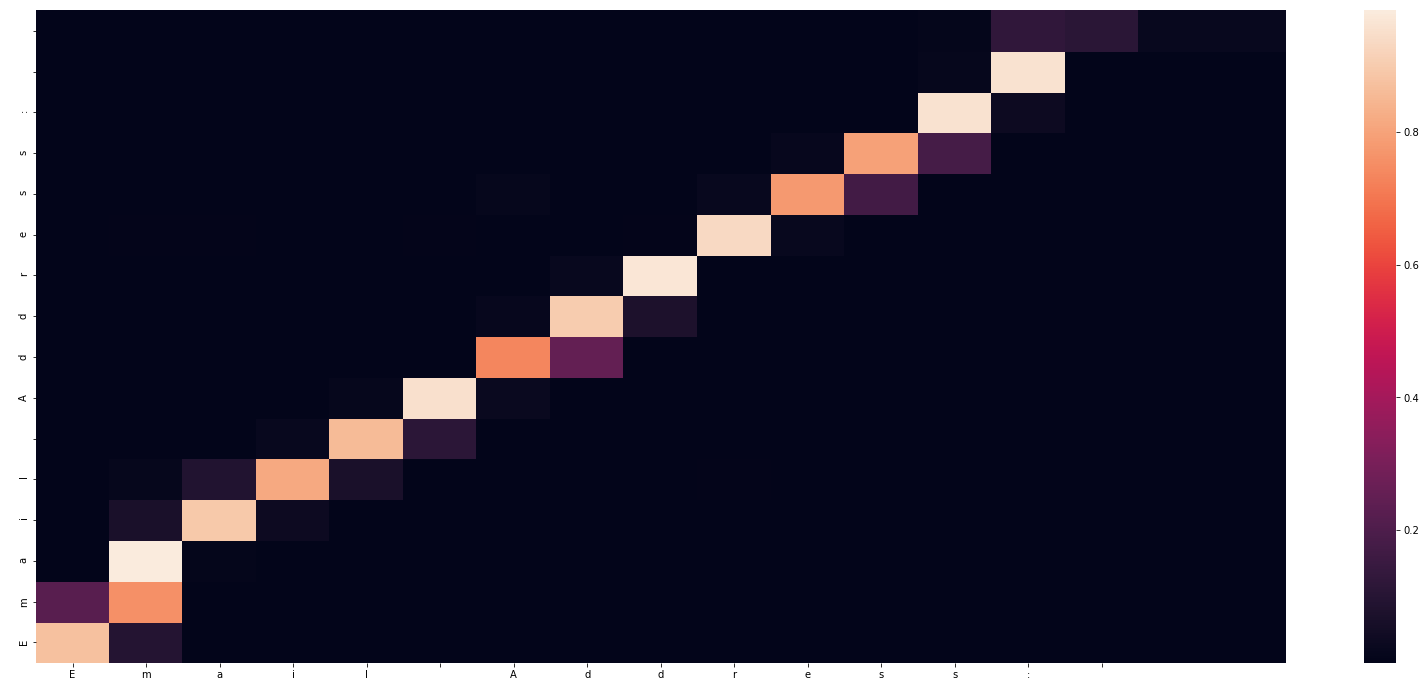

-
Input sentence: Email Address: 
GT sentence: Email Address:

Decoded sentence: Email Address: 



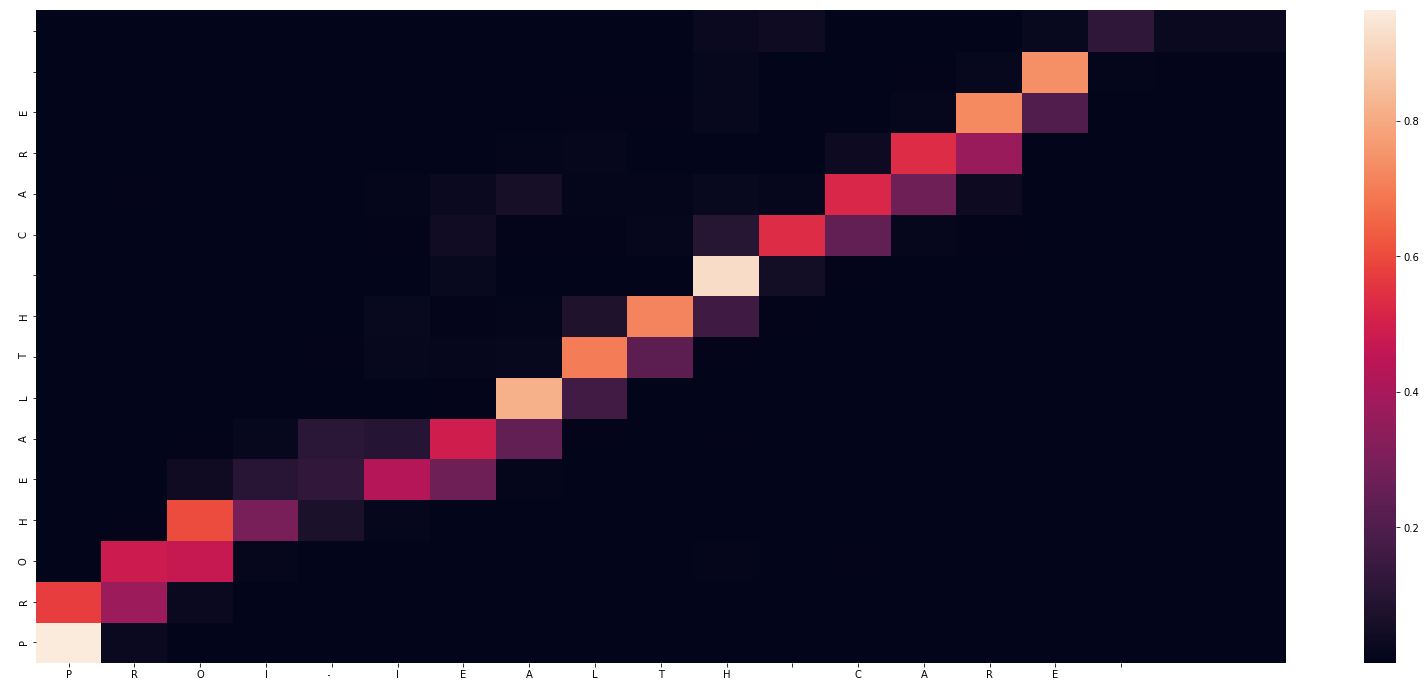

-
Input sentence: PROI—IEALTH CARE 
GT sentence: PROHEALTH CARE

Decoded sentence: PROHEALTH CARE 



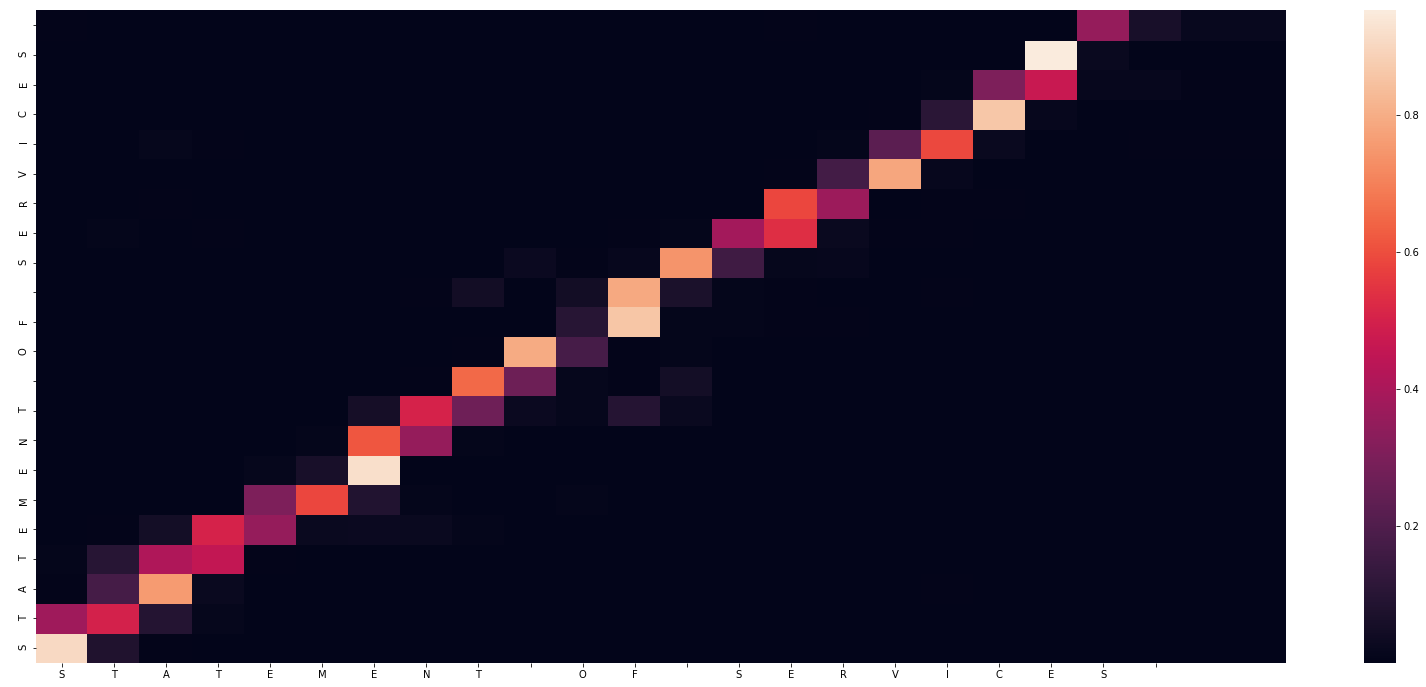

-
Input sentence: STATEMENT OF SERVICES 
GT sentence: STATEMENT OF SERVICES

Decoded sentence: STATEMENT OF SERVICES



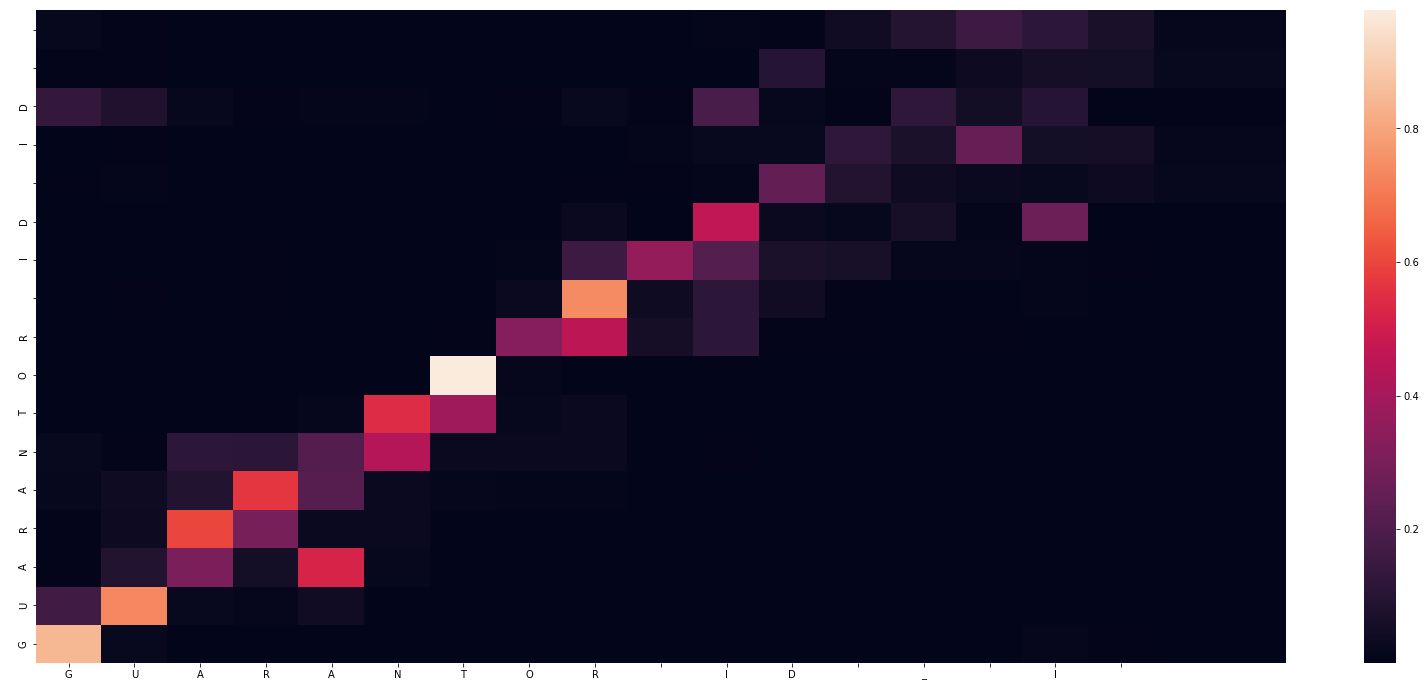

-
Input sentence: GUARANTOR ID _ I 
GT sentence: GUARANTOR ID

Decoded sentence: GUARANTOR ID ID 



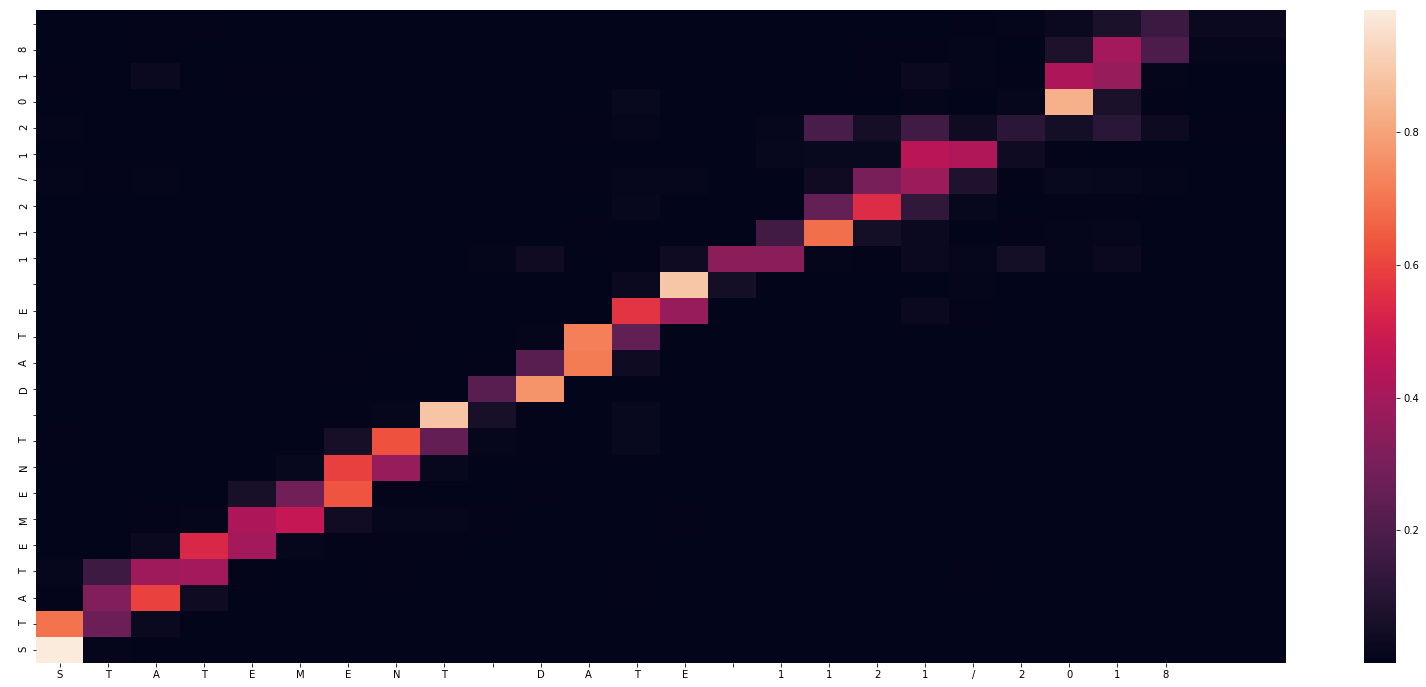

-
Input sentence: STATEMENT DATE 1121/2018
GT sentence: STATEMENT DATE 1/21/2018

Decoded sentence: STATEMENT DATE 112/12018



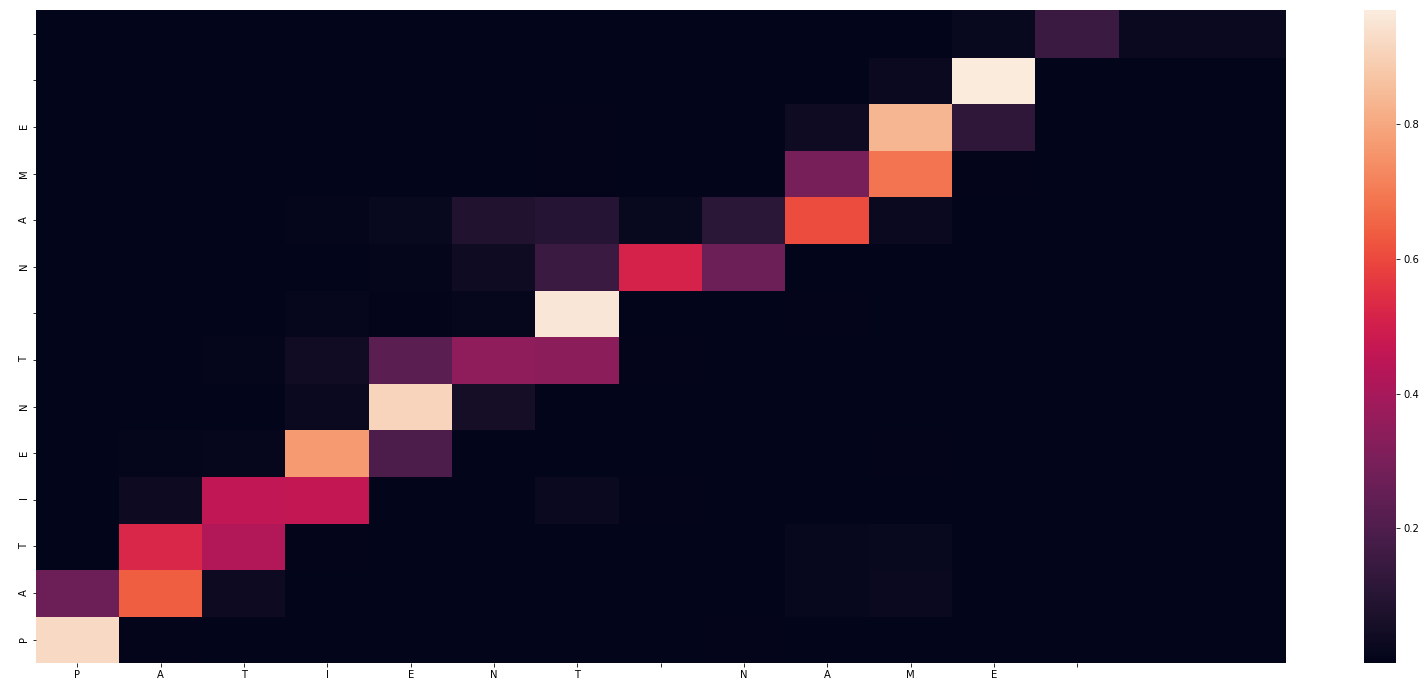

-
Input sentence: PATIENT NAME 
GT sentence: PATIENT NAME

Decoded sentence: PATIENT NAME 



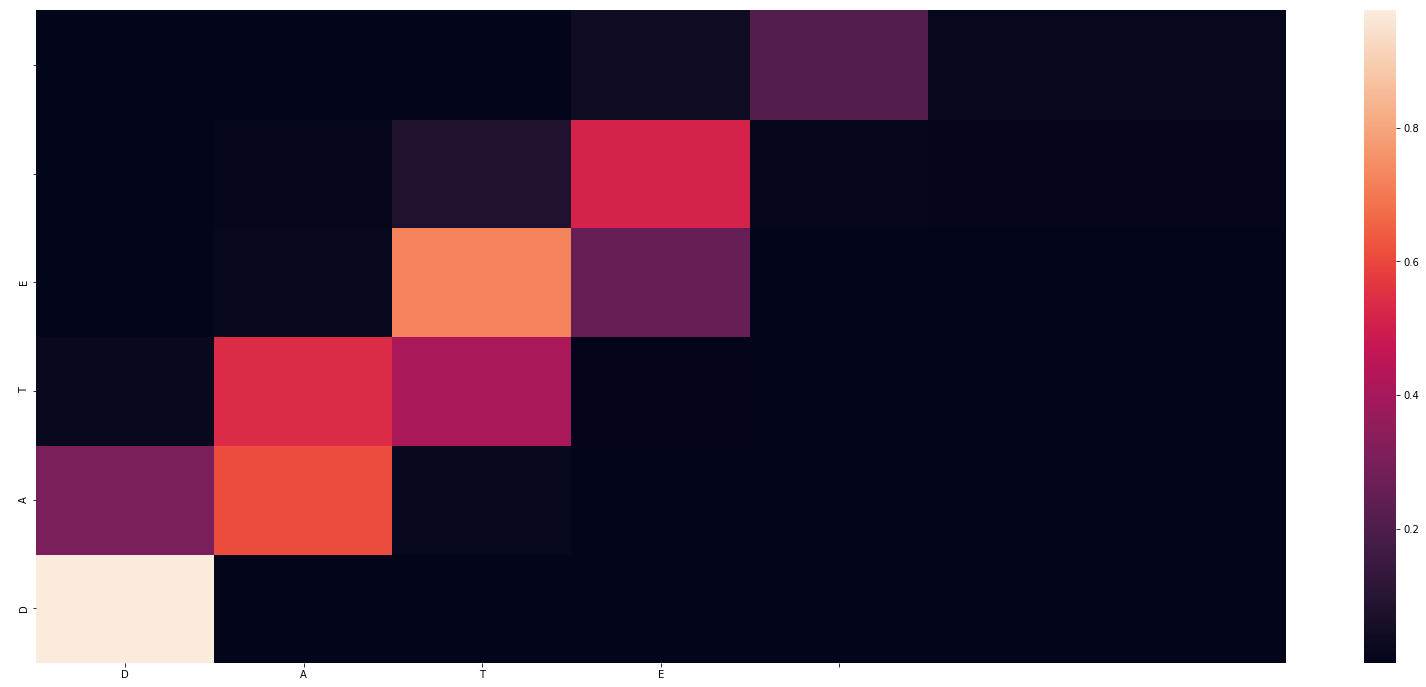

-
Input sentence: DATE 
GT sentence: DATE

Decoded sentence: DATE 



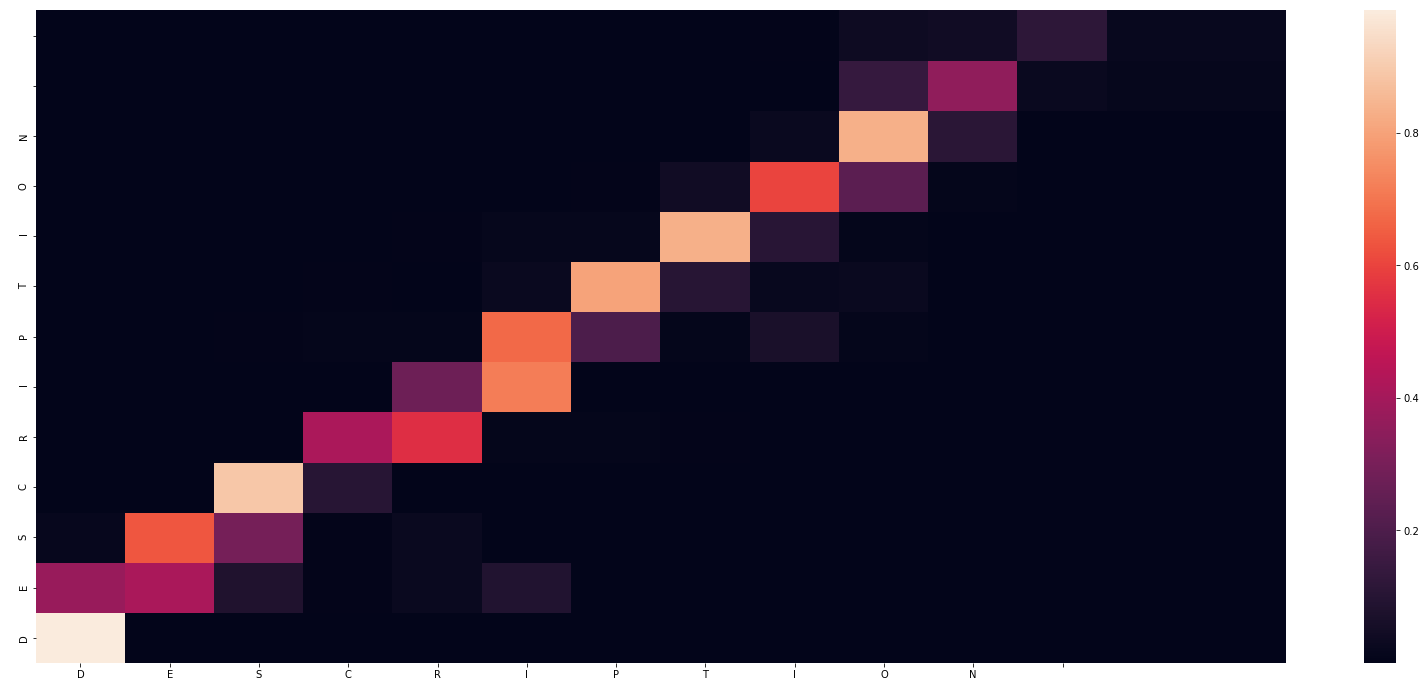

-
Input sentence: DESCRIPTION 
GT sentence: DESCRIPTION

Decoded sentence: DESCRIPTION 



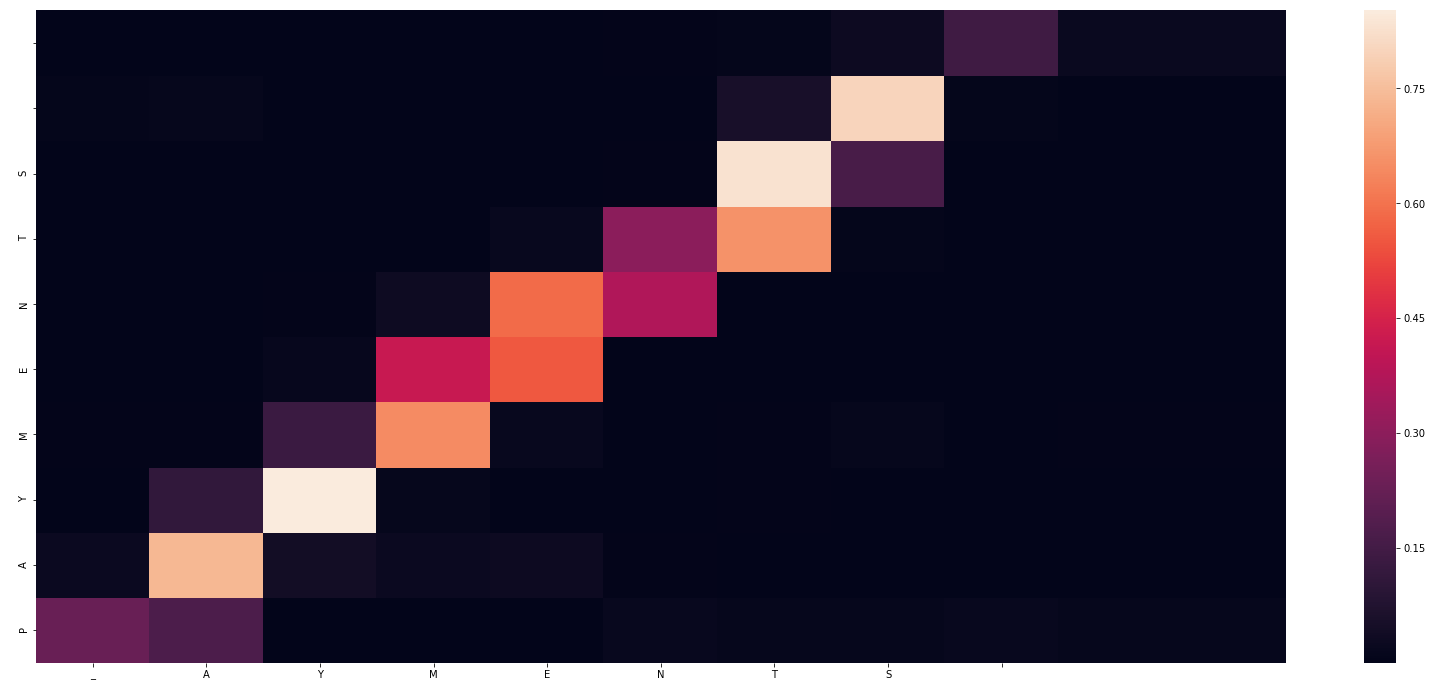

-
Input sentence: _AYMENTS 
GT sentence: PAYMENTS

Decoded sentence: PAYMENTS 



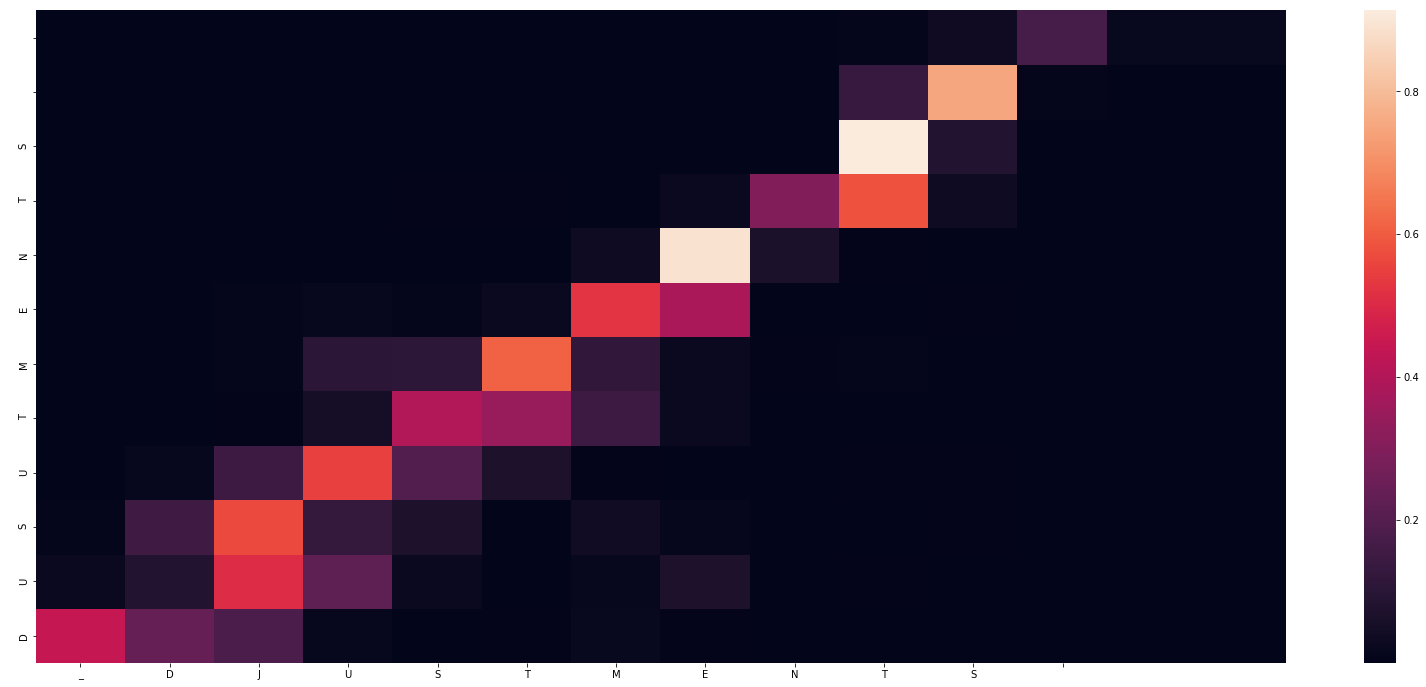

-
Input sentence: _DJUSTMENTS 
GT sentence: ADJUSTMENTS

Decoded sentence: DUSUTMENTS 



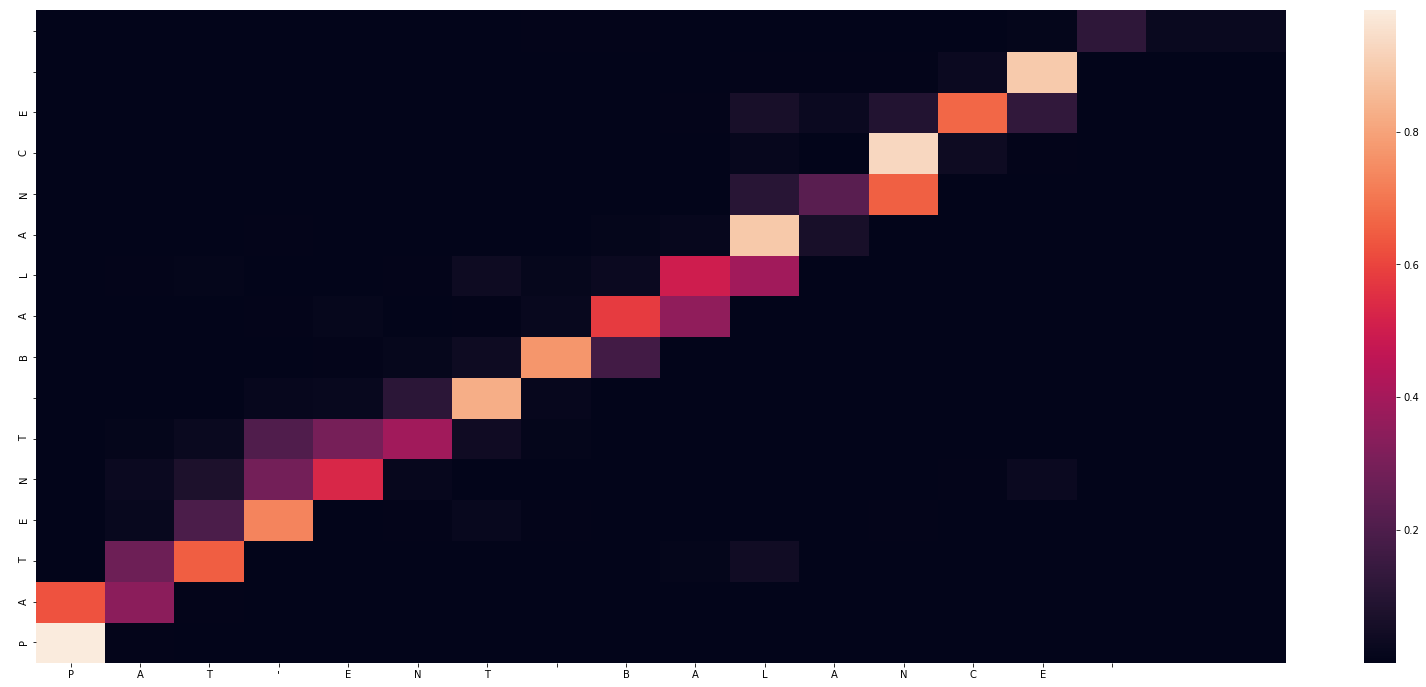

-
Input sentence: PAT'ENT BALANCE 
GT sentence: PATIENTS BALANCE

Decoded sentence: PATENT BALANCE 



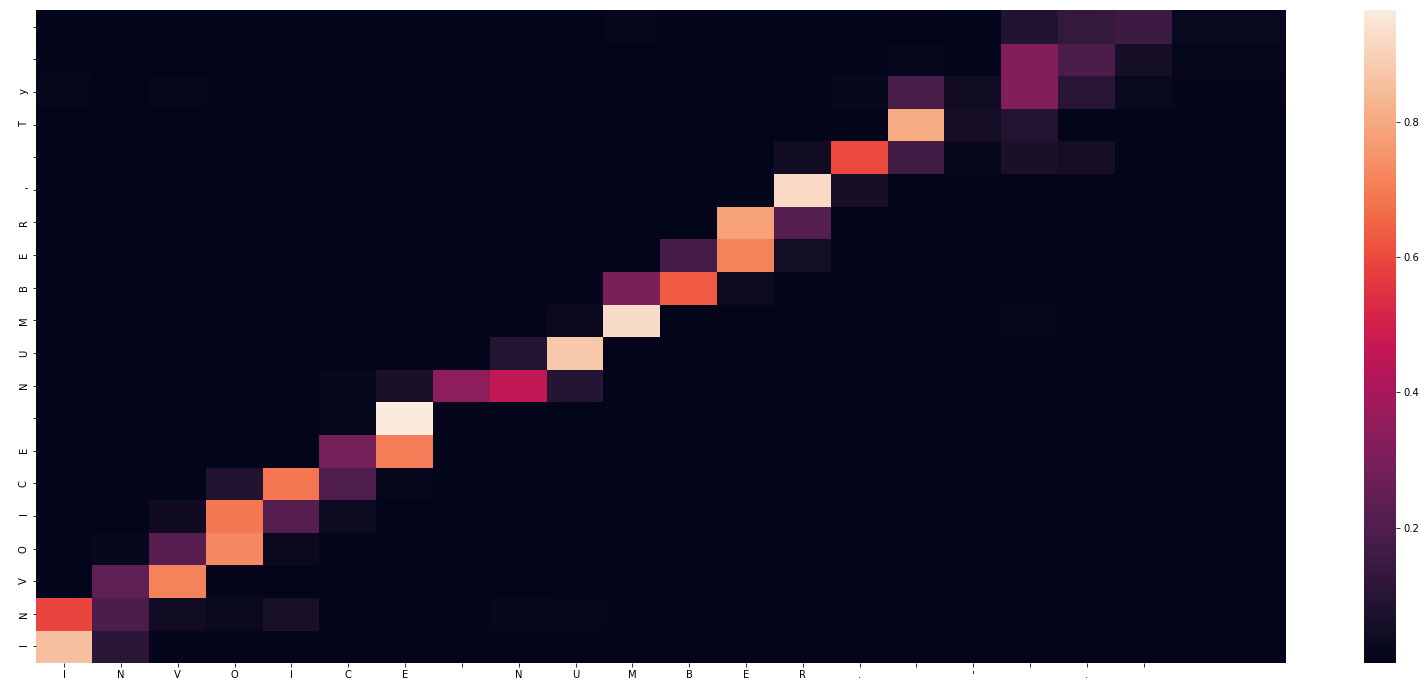

-
Input sentence: INVOICE NUMBER. ' . 
GT sentence: INVOICE NUMBER :

Decoded sentence: INVOICE NUMBER, Ty 



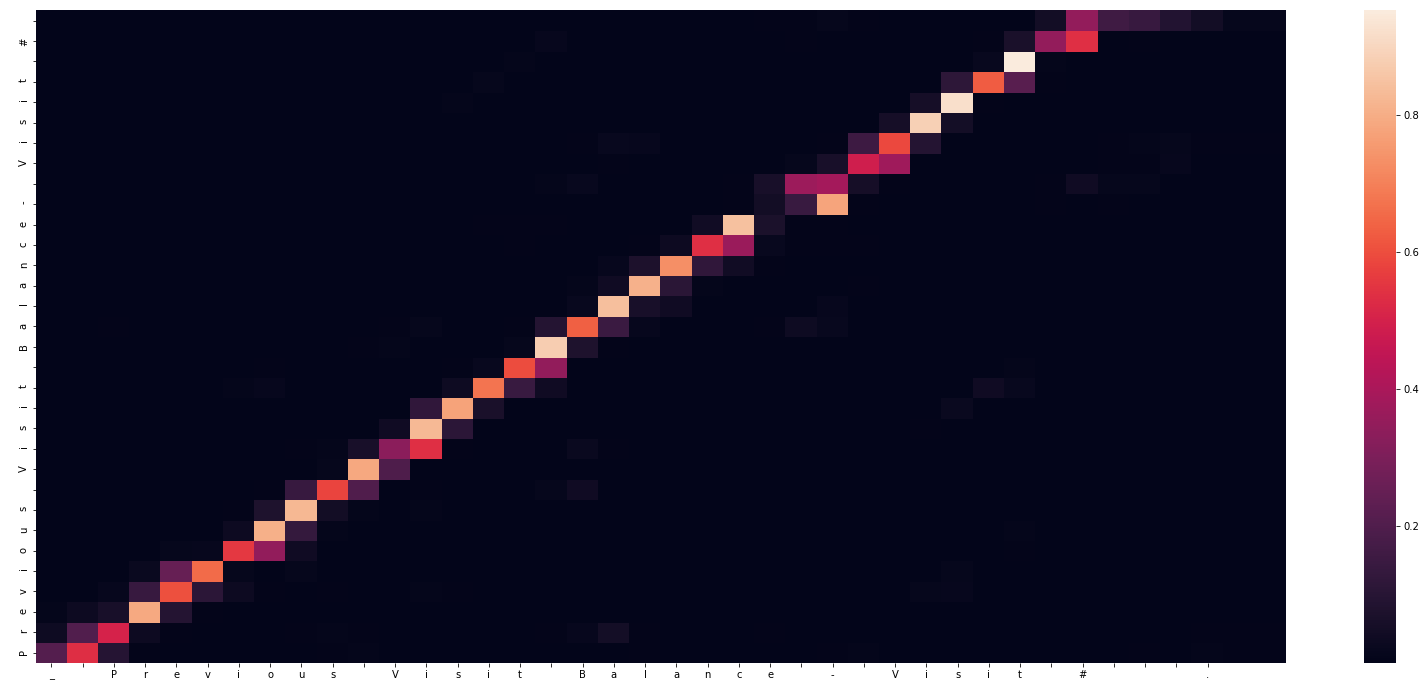

-
Input sentence: _ Previous Visit Balance - Visit # — .
GT sentence: Previous Visit Balance- Visit #

Decoded sentence: Previous Visit Balance- Visit #



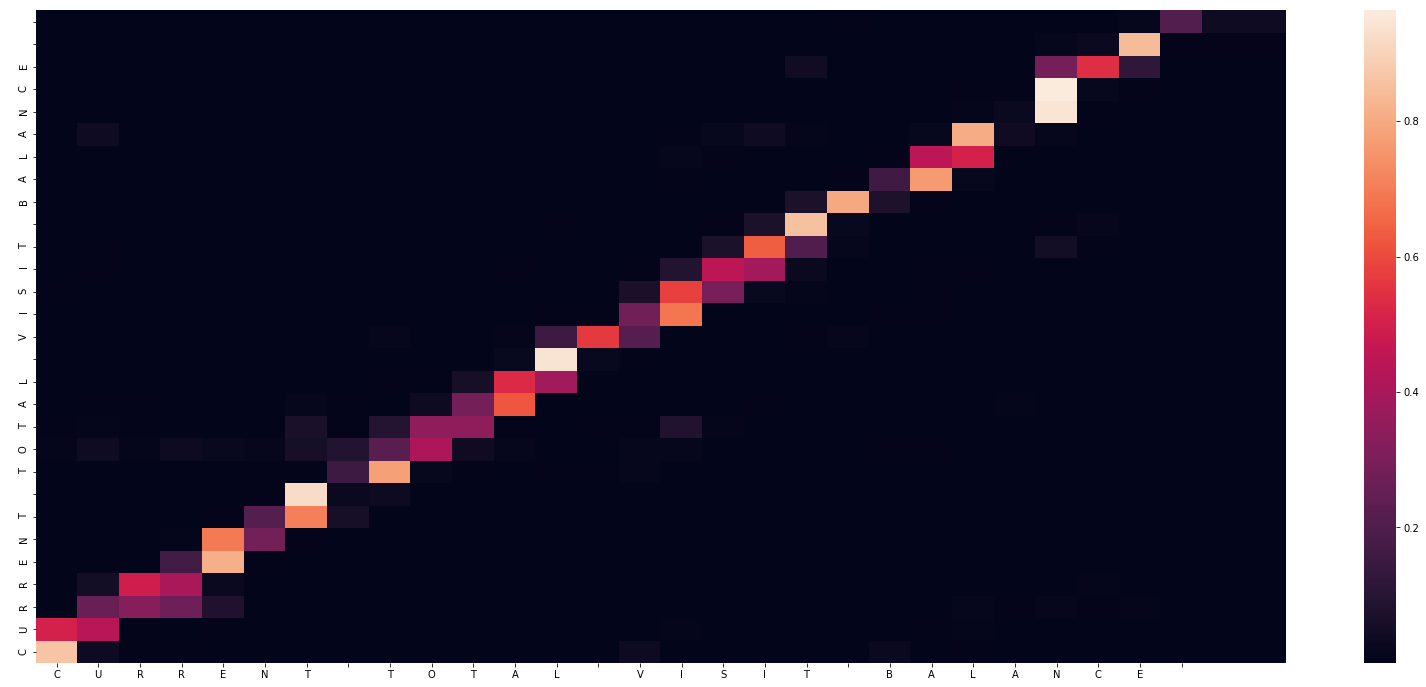

-
Input sentence: CURRENT TOTAL VISIT BALANCE 
GT sentence: CURRENT TOTAL VISIT BALANCE 964.70

Decoded sentence: CURRENT TOTAL VISIT BALANCE 



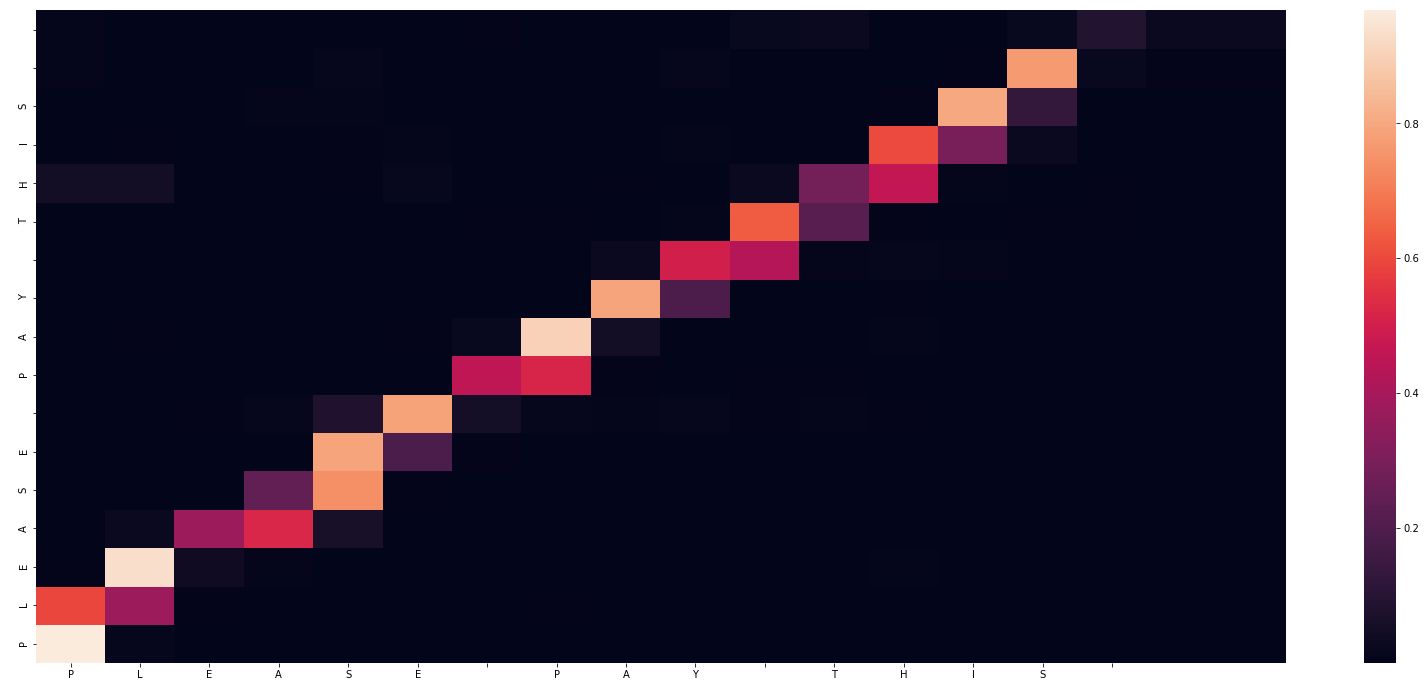

-
Input sentence: PLEASE PAY THIS 
GT sentence: PLEASE PAY THIS

Decoded sentence: PLEASE PAY THIS 



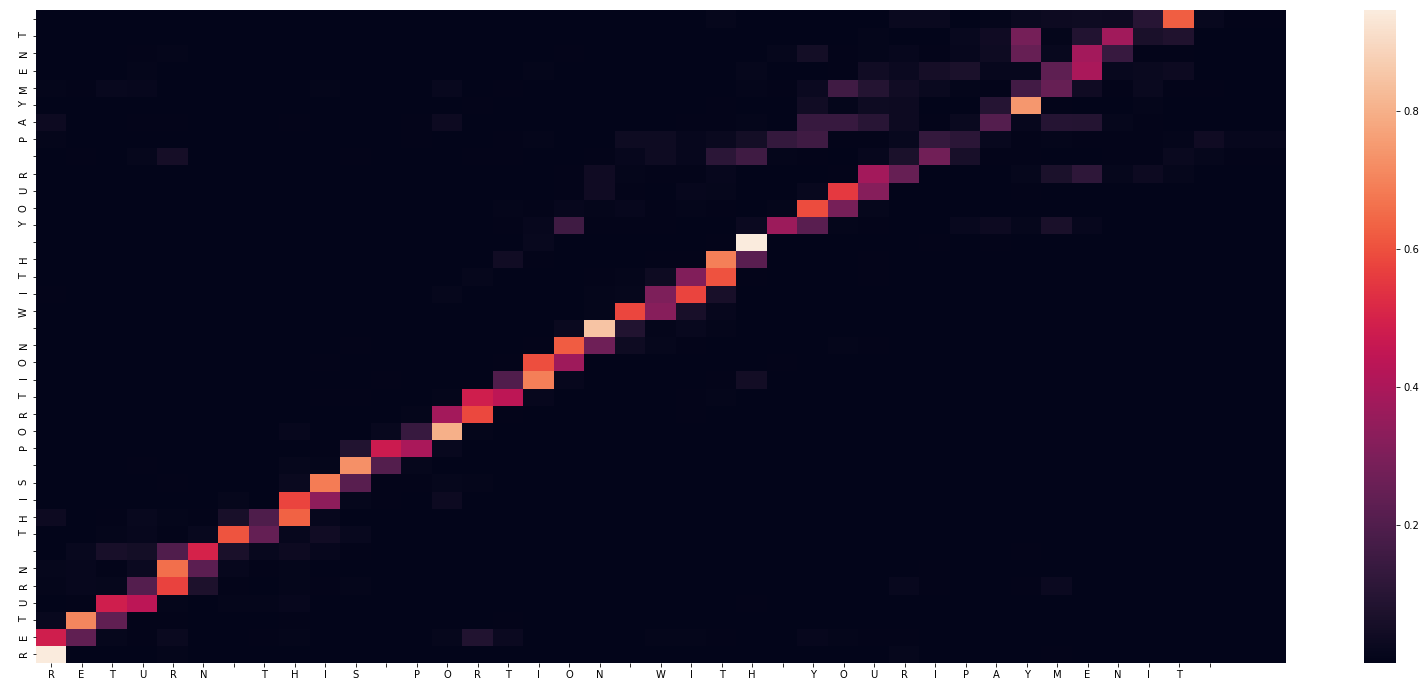

-
Input sentence: RETURN THIS PORTION WITH YOURIPAYMENIT 
GT sentence: RETURN THIS PORTION WITH YOUR PAYMENT

Decoded sentence: RETURN THIS PORTION WITH YOUR PAYMENT



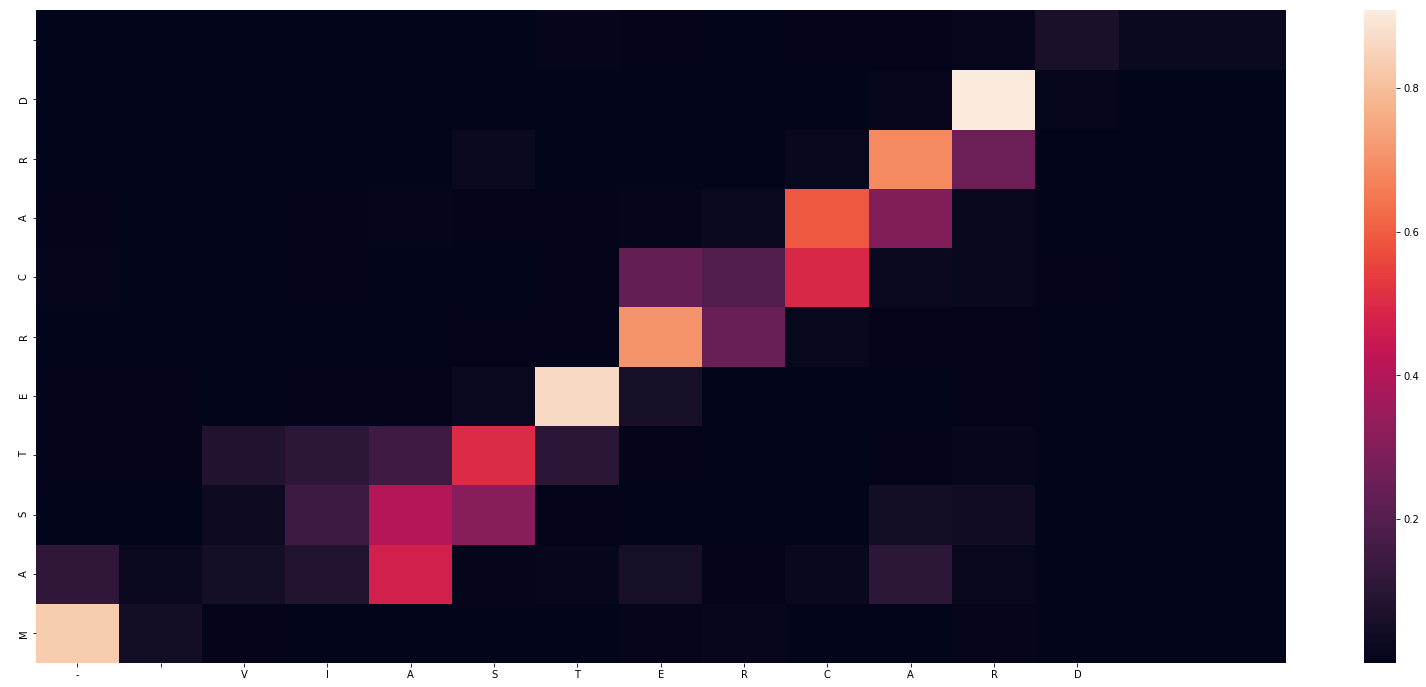

-
Input sentence: - VIASTERCARD
GT sentence: MASTERCARD

Decoded sentence: MASTERCARD



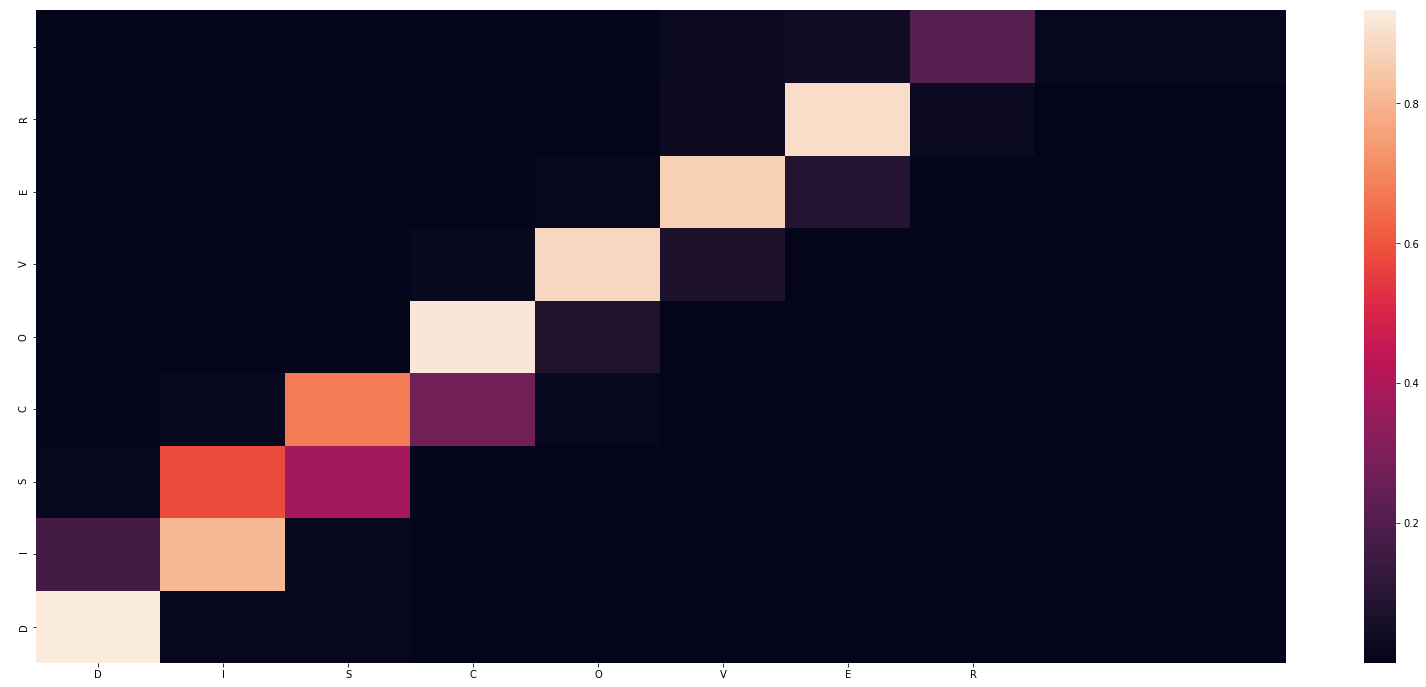

-
Input sentence: DISCOVER
GT sentence: DISCOVER

Decoded sentence: DISCOVER



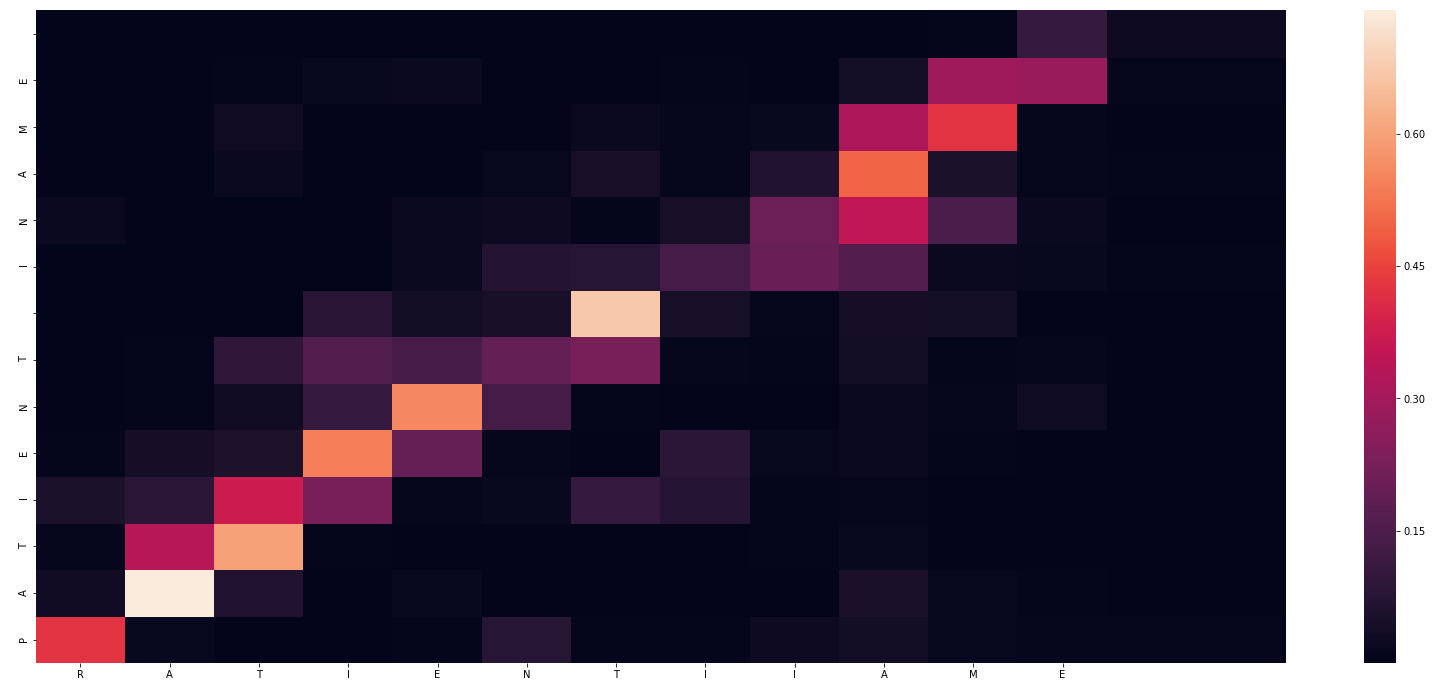

-
Input sentence: RATIENTIIAME
GT sentence: PATIENT NAME

Decoded sentence: PATIENT INAME



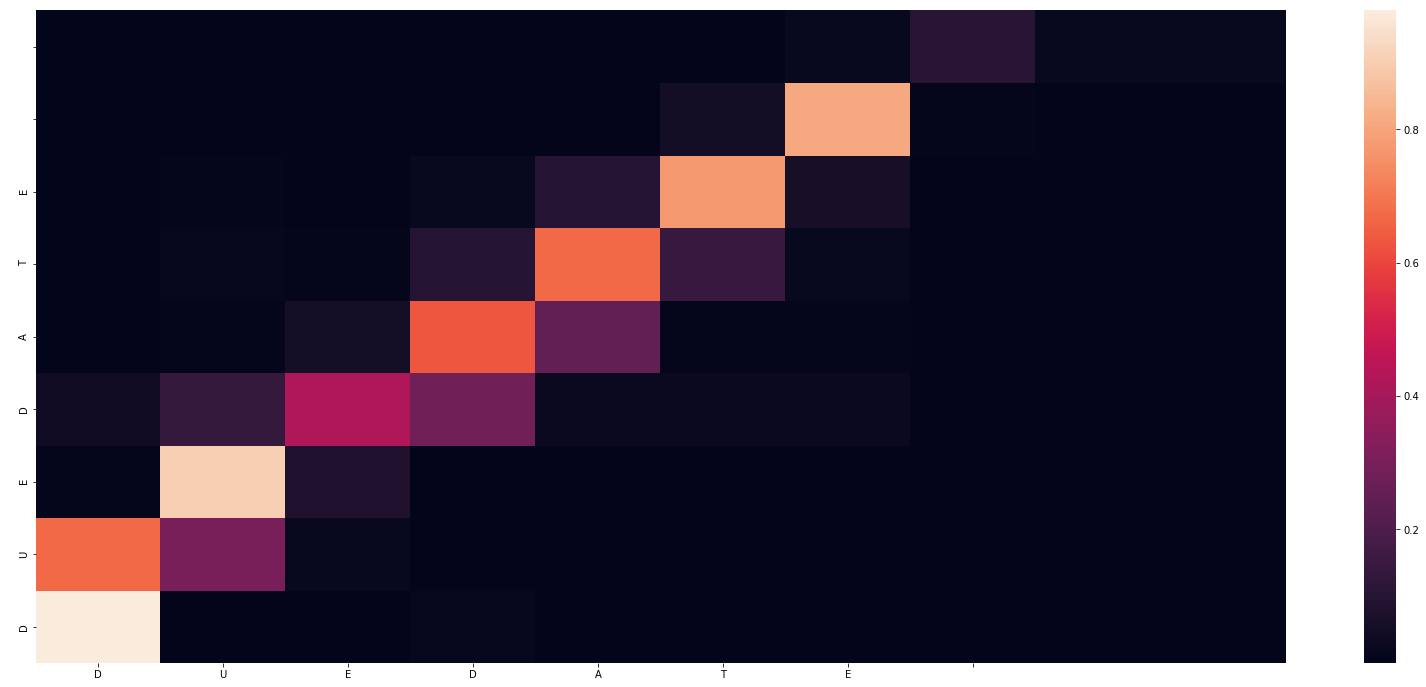

-
Input sentence: DUEDATE 
GT sentence: DUE DATE

Decoded sentence: DUEDATE 



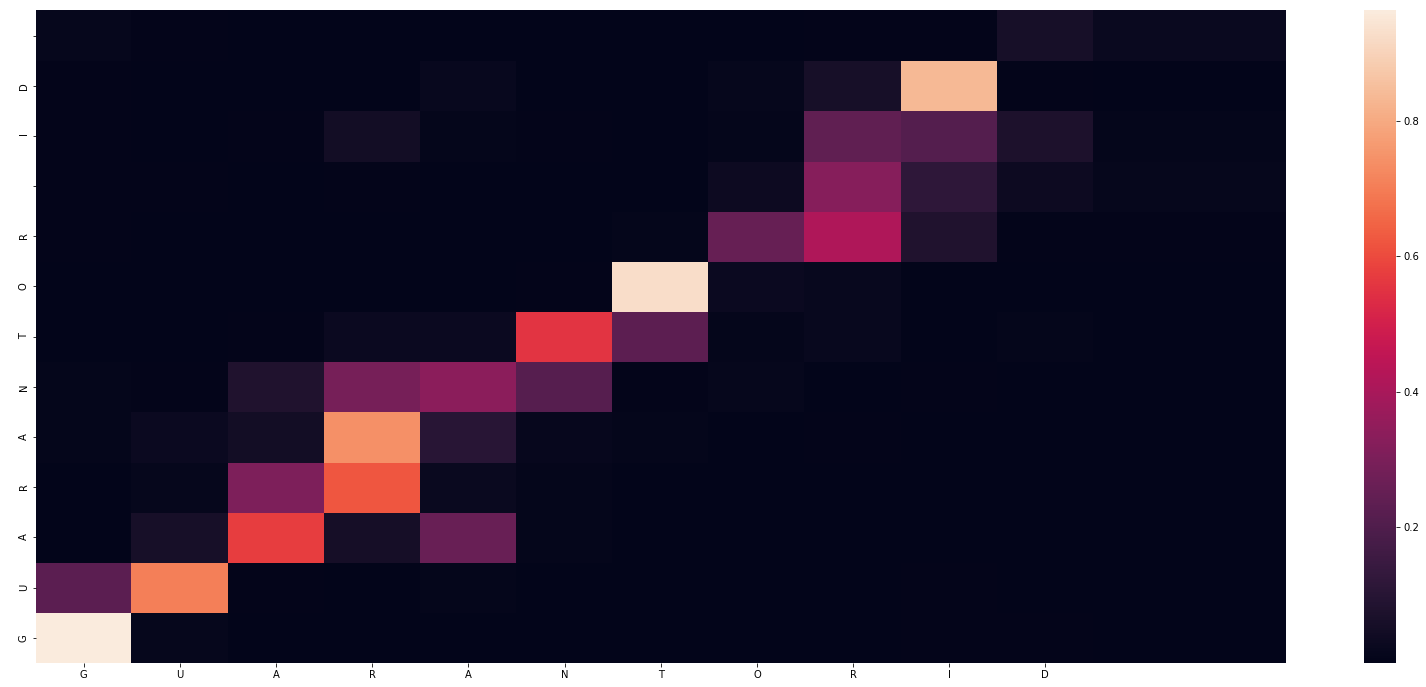

-
Input sentence: GUARANTORID
GT sentence: GUARANTOR ID

Decoded sentence: GUARANTOR ID



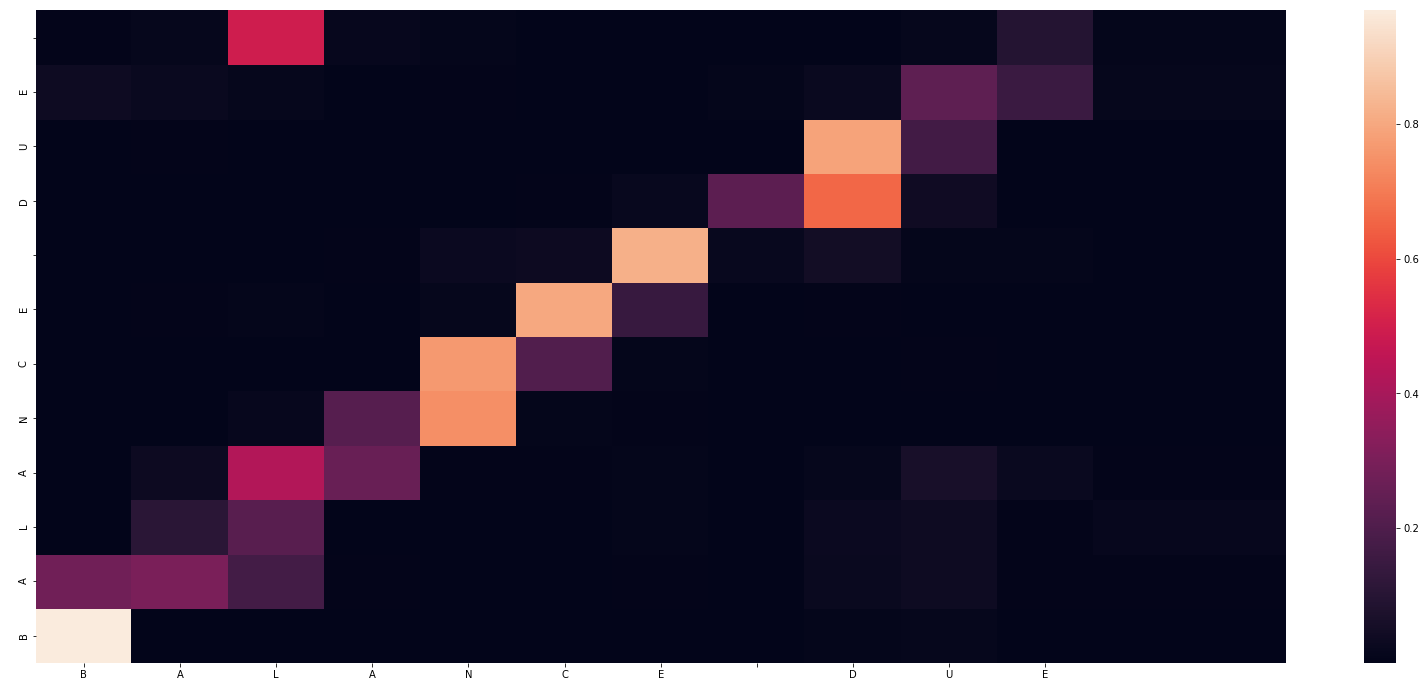

-
Input sentence: BALANCE DUE
GT sentence: BALANCE DUE

Decoded sentence: BALANCE DUE



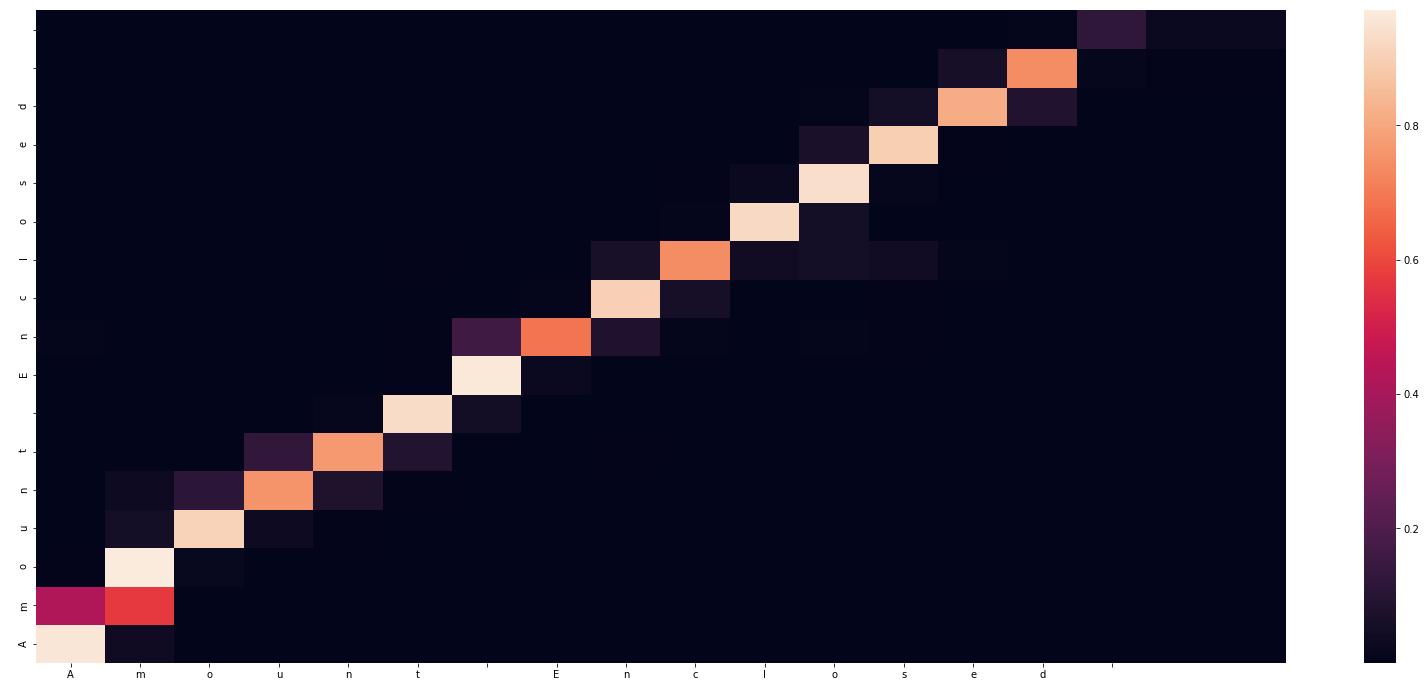

-
Input sentence: Amount Enclosed 
GT sentence: Amount Enclosed

Decoded sentence: Amount Enclosed 



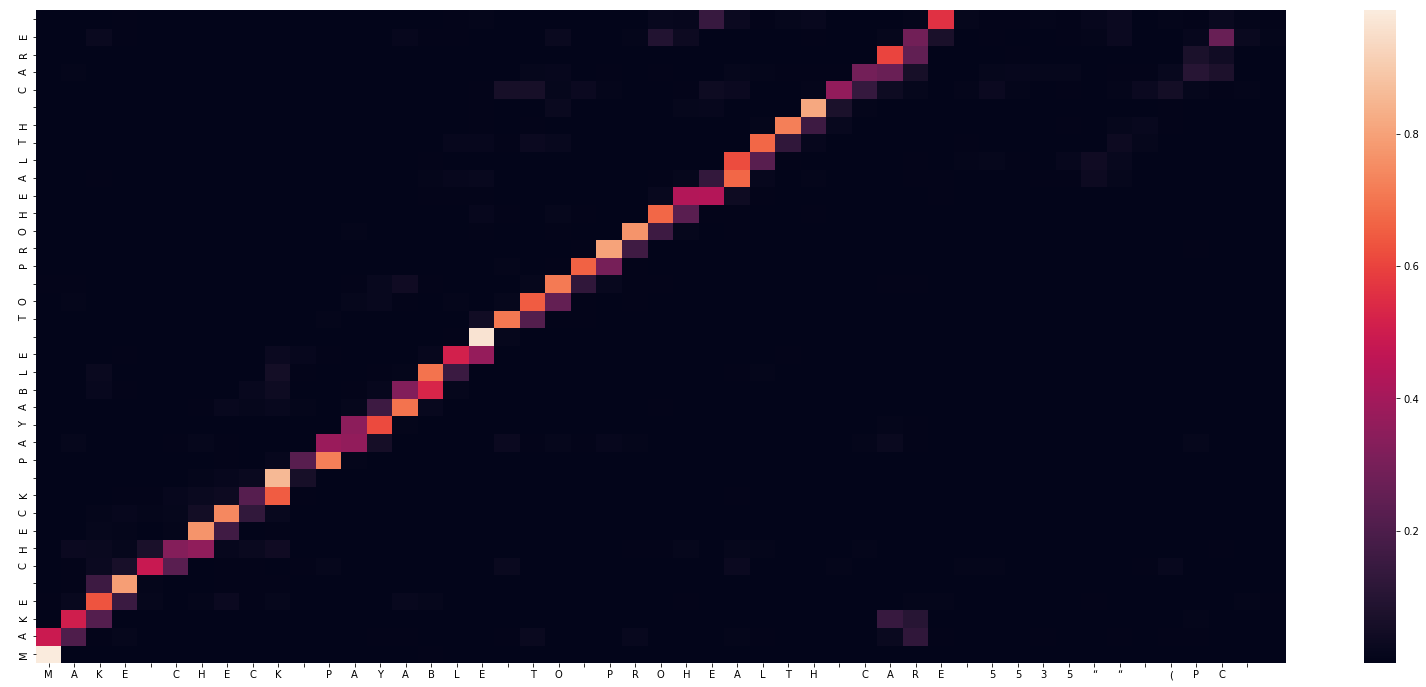

-
Input sentence: MAKE CHECK PAYABLE TO PROHEALTH CARE 5535““ (PC 
GT sentence: MAKE CHECK PAYABLE TO PROHEALTH CARE

Decoded sentence: MAKE CHECK PAYABLE TO PROHEALTH CARE



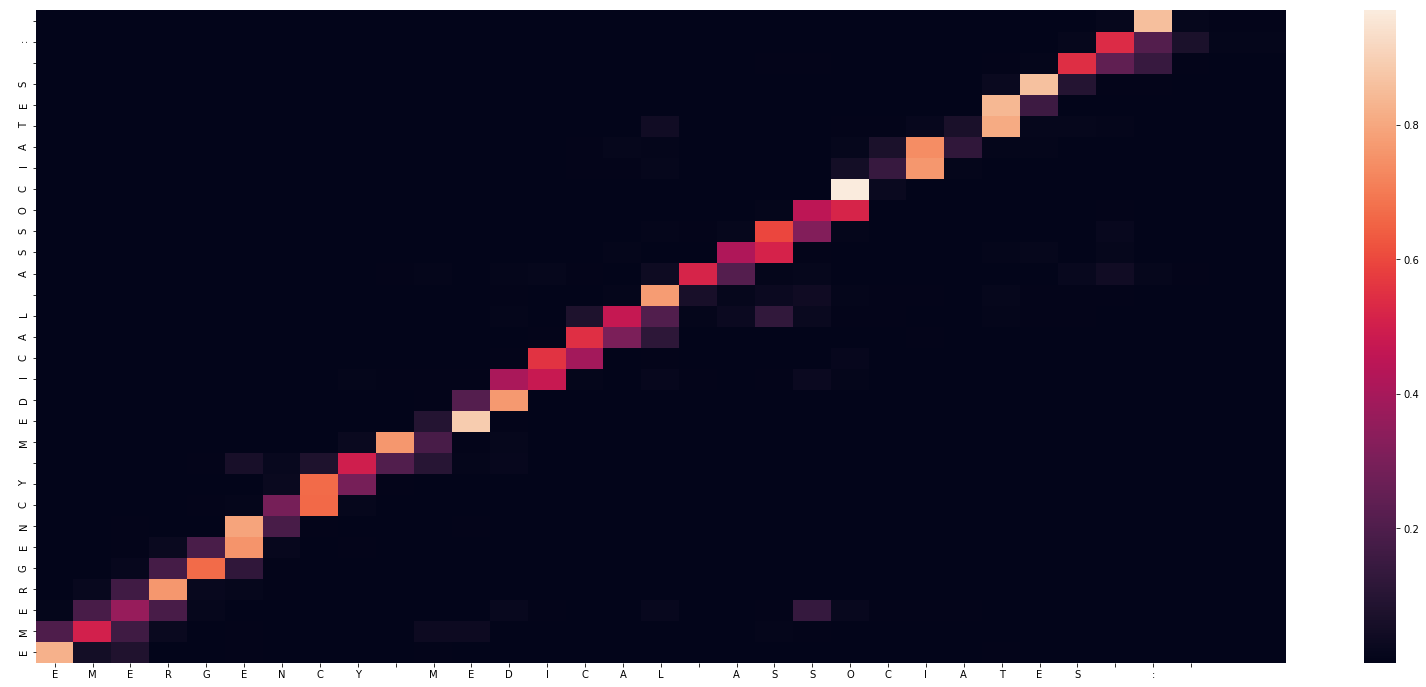

-
Input sentence: EMERGENCY MEDICAL ASSOCIATES : 
GT sentence: EMERGENCY MEDICAL ASSOCIATES

Decoded sentence: EMERGENCY MEDICAL ASSOCIATES :



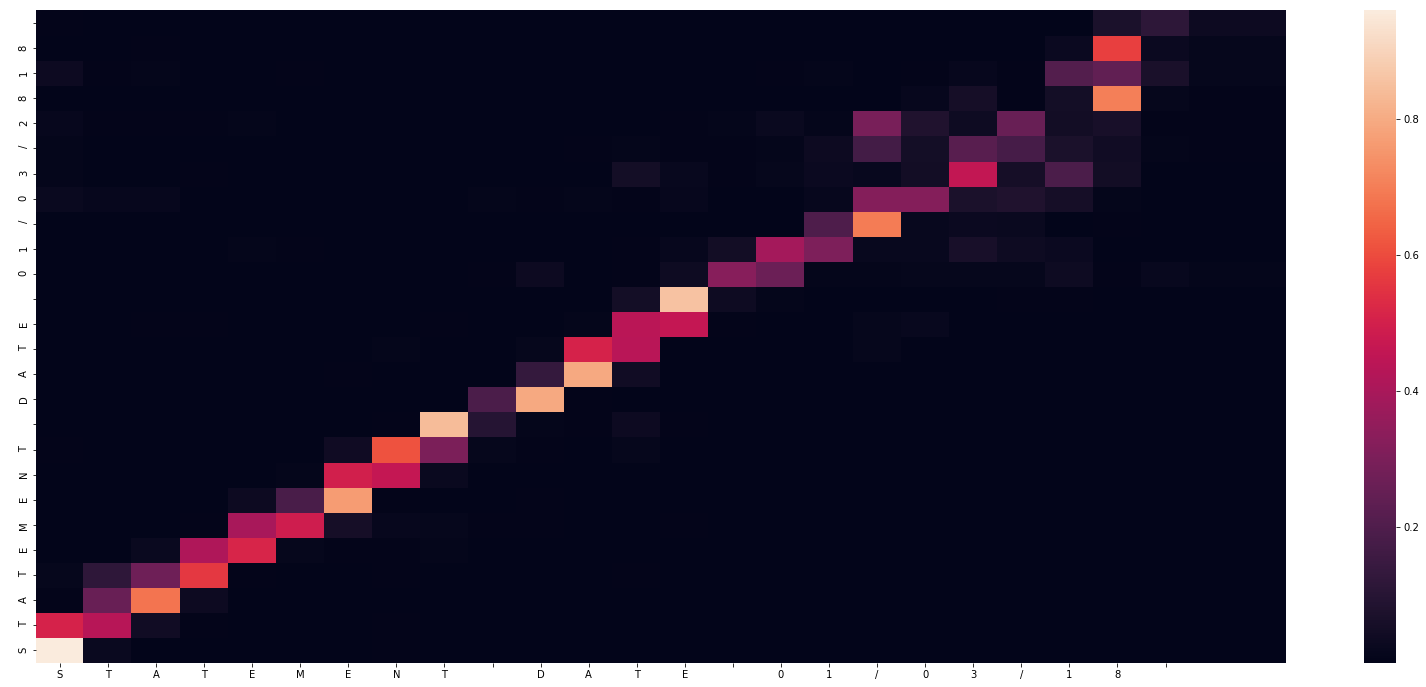

-
Input sentence: STATEMENT DATE 01/03/18 
GT sentence: STATEMENT DATE  01/03/18

Decoded sentence: STATEMENT DATE 01/03/2818



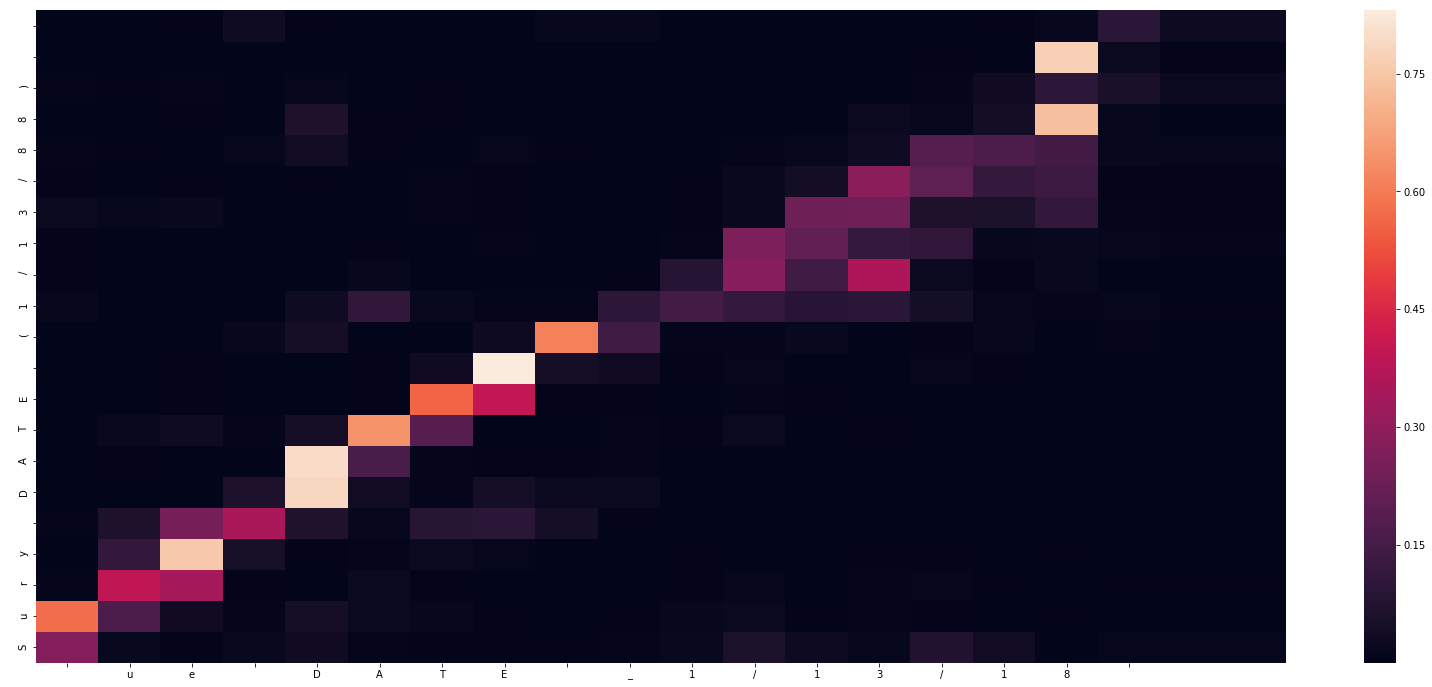

-
Input sentence: —ue DATE _1/13/18 
GT sentence: DUE DATE 01/13/18

Decoded sentence: Sury DATE (1/13/88) 



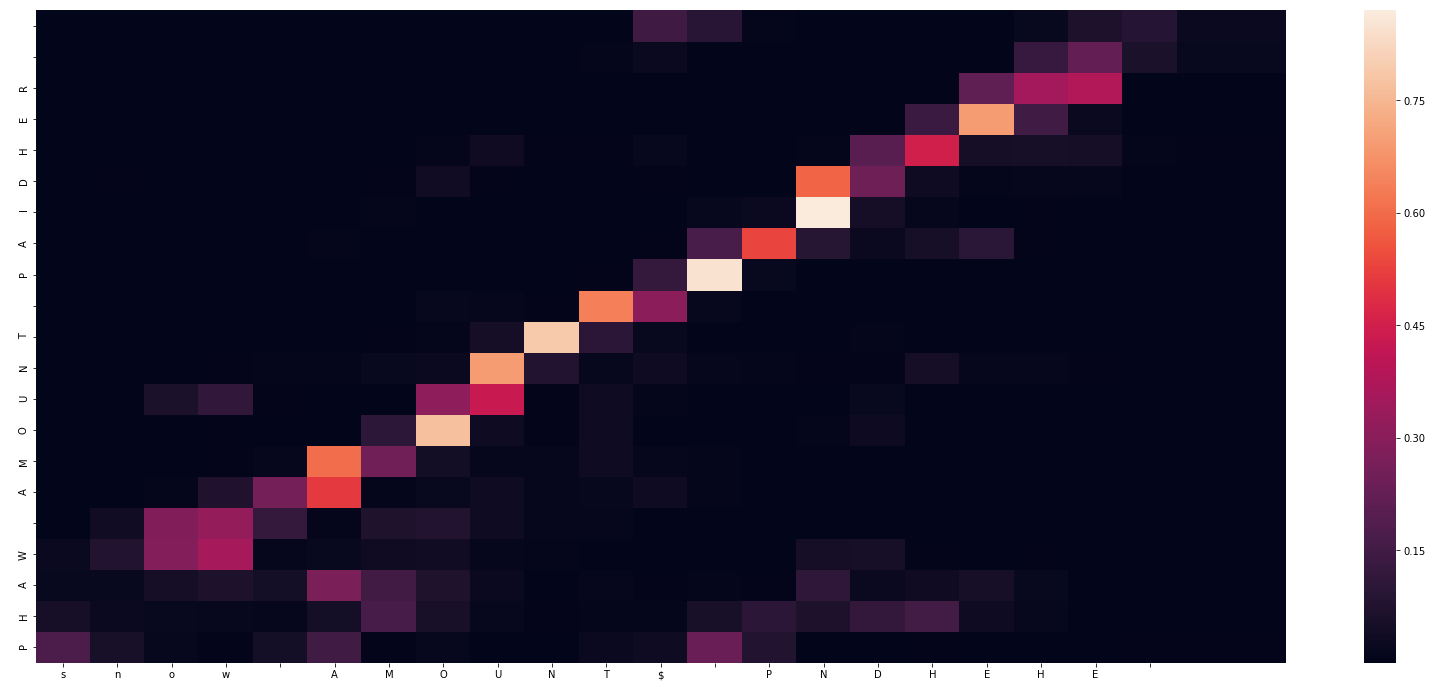

-
Input sentence: snow AMOUNT$ PNDHEHE 
GT sentence: SHOW AMOUNT PAID HERE $

Decoded sentence: PHAW AMOUNT PAIDHER 



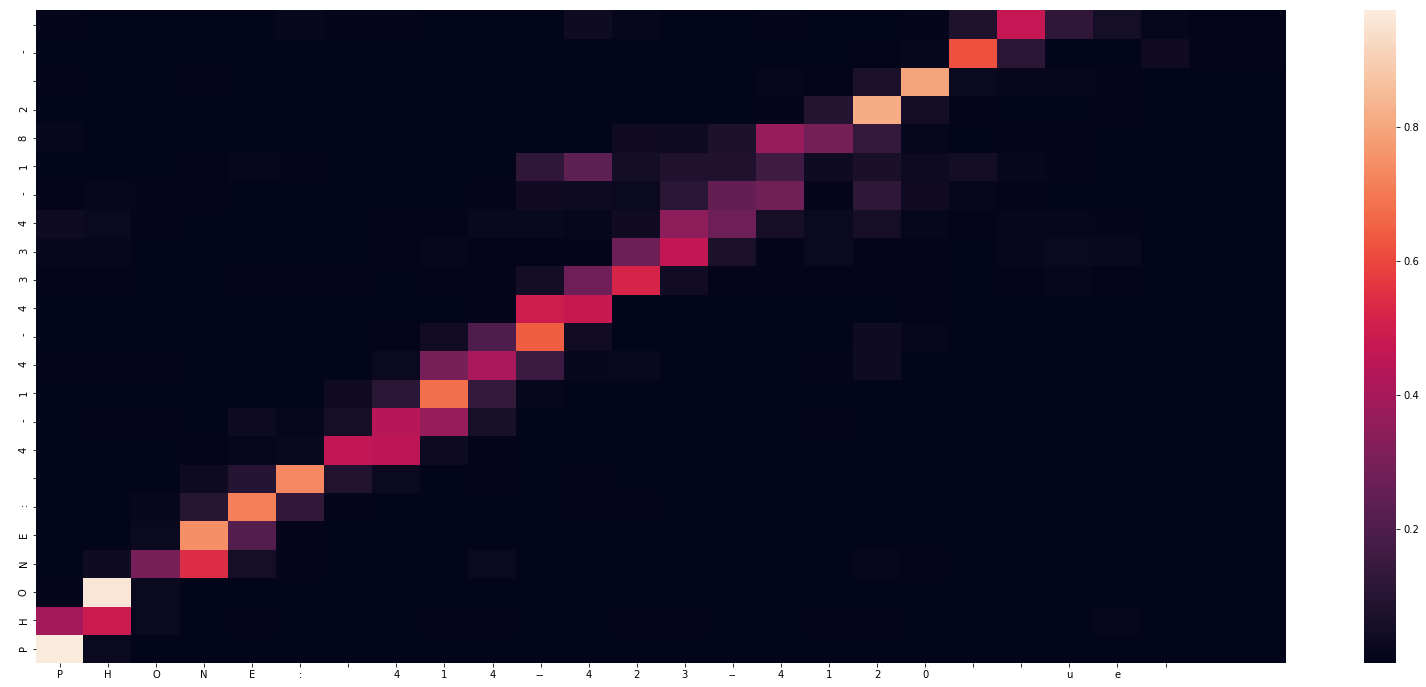

-
Input sentence: PHONE: 414—423—4120 —ue 
GT sentence: PHONE: 414-423-4120

Decoded sentence: PHONE: 4-14-4334-182 -



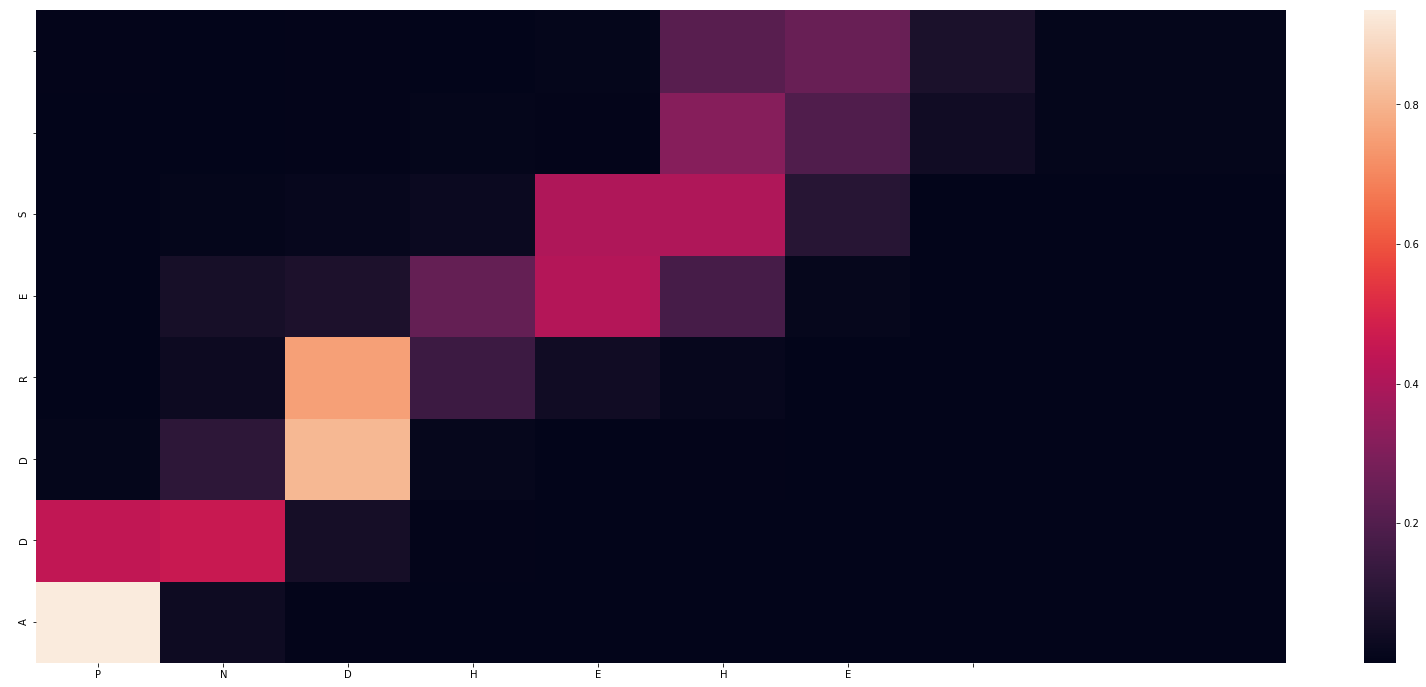

-
Input sentence: PNDHEHE 
GT sentence: ADDRESSEE:

Decoded sentence: ADDRES 



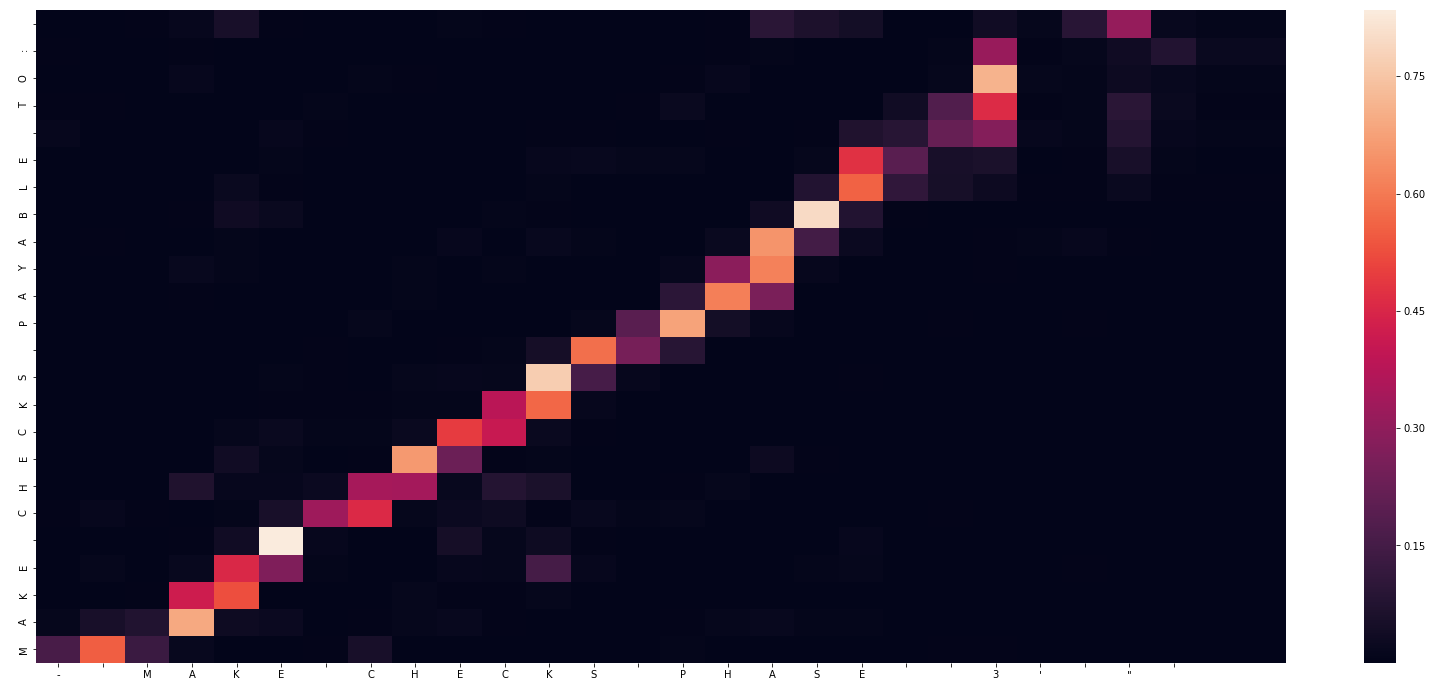

-
Input sentence: - MAKE CHECKS PHASE “3' " 
GT sentence: MAKE CHECKS PAYABLE TO:

Decoded sentence: MAKE CHECKS PAYABLE TO:



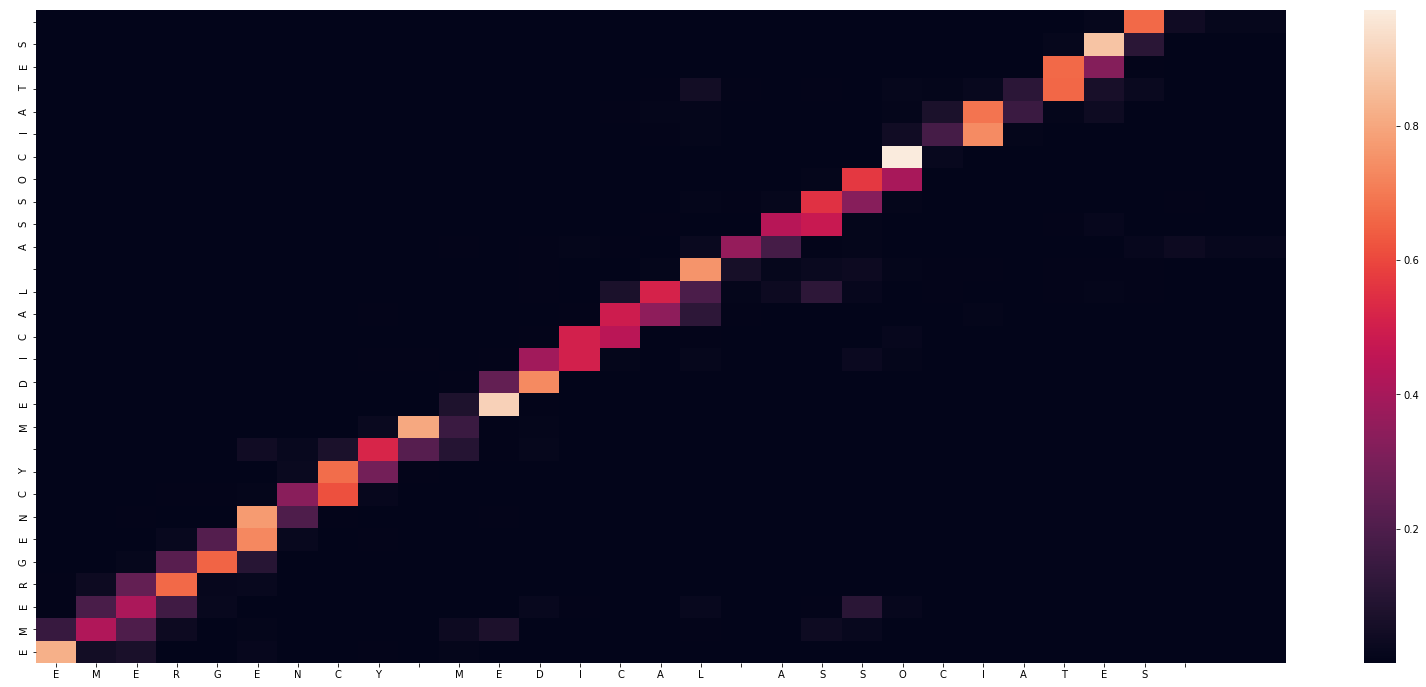

-
Input sentence: EMERGENCY MEDICAL ASSOCIATES 
GT sentence: EMERGENCY MEDICAL ASSOCIATES

Decoded sentence: EMERGENCY MEDICAL ASSOCIATES



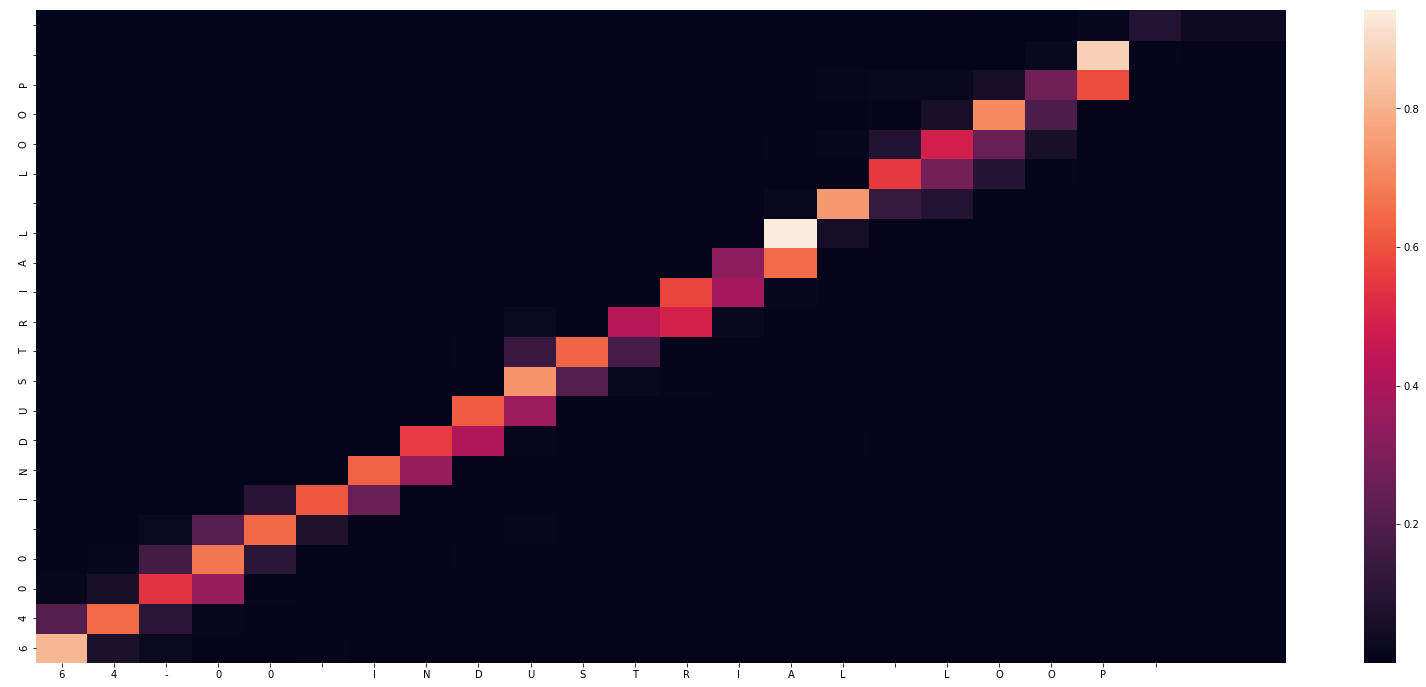

-
Input sentence: 64-00 INDUSTRIAL LOOP 
GT sentence: 6400 INDUSTRIAL LOOP

Decoded sentence: 6400 INDUSTRIAL LOOP 



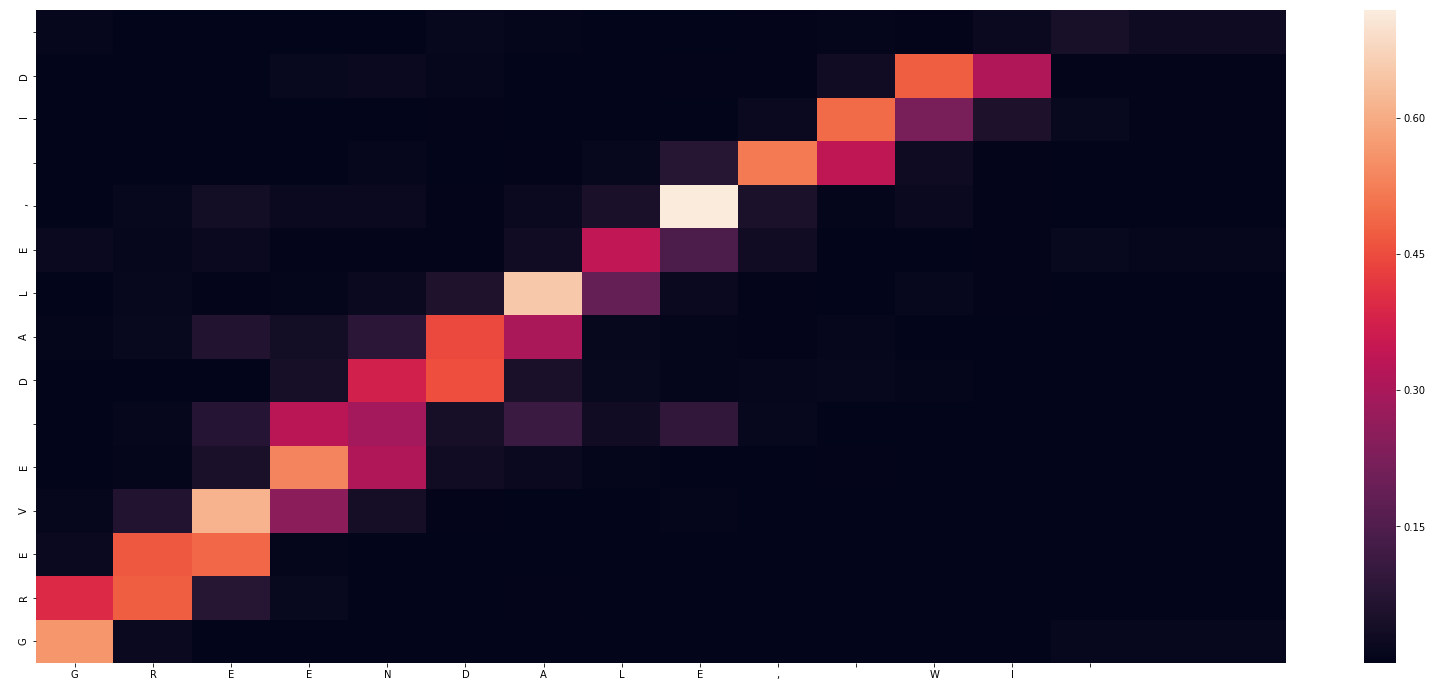

-
Input sentence: GREENDALE, WI 
GT sentence: GREENDALE, WI

Decoded sentence: GREVE DALE, ID



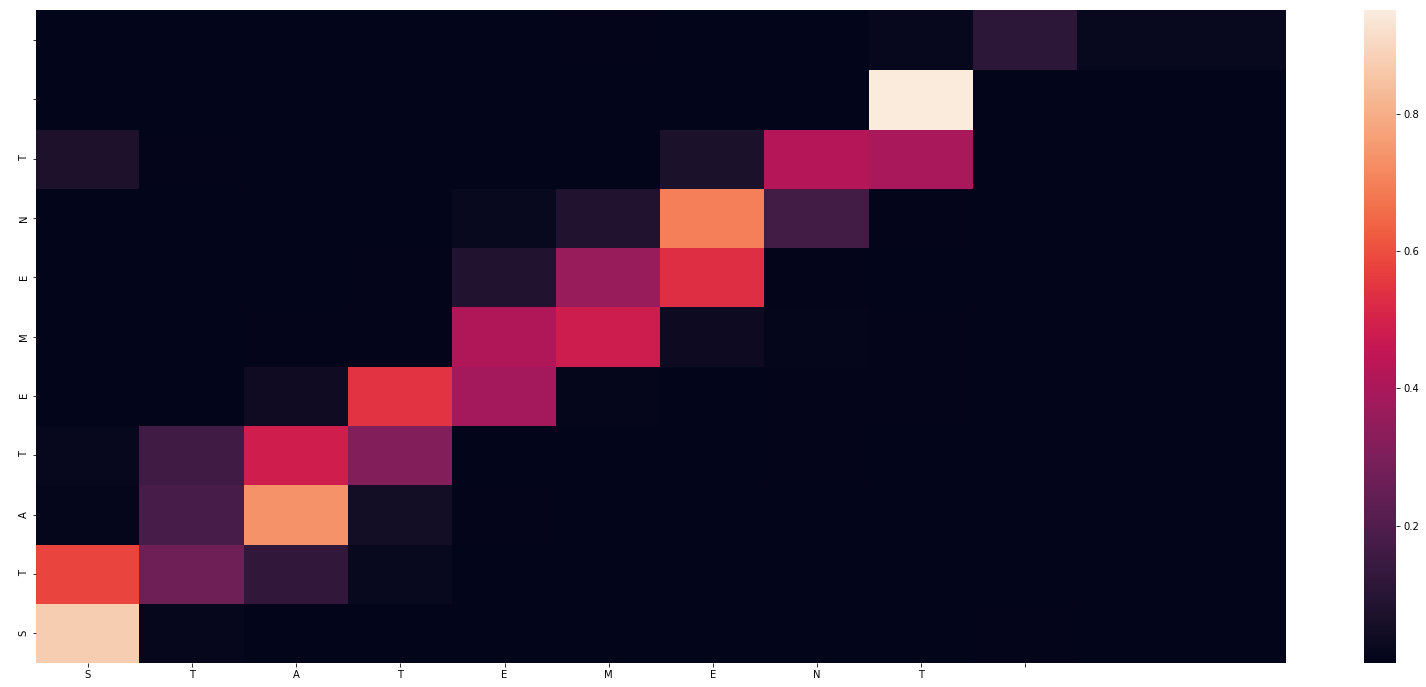

-
Input sentence: STATEMENT 
GT sentence: STATEMENT

Decoded sentence: STATEMENT 



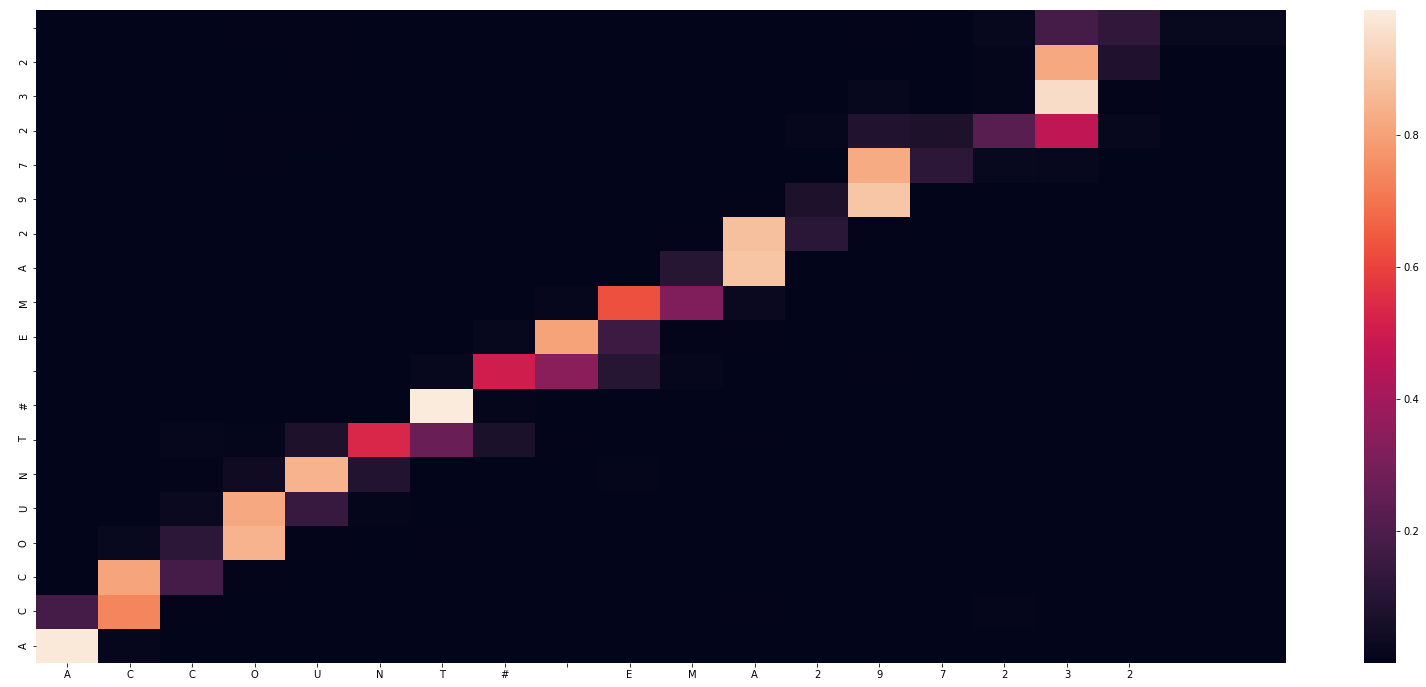

-
Input sentence: ACCOUNT# EMA297232
GT sentence: ACCOUNT# EMA297232

Decoded sentence: ACCOUNT# EMA297232



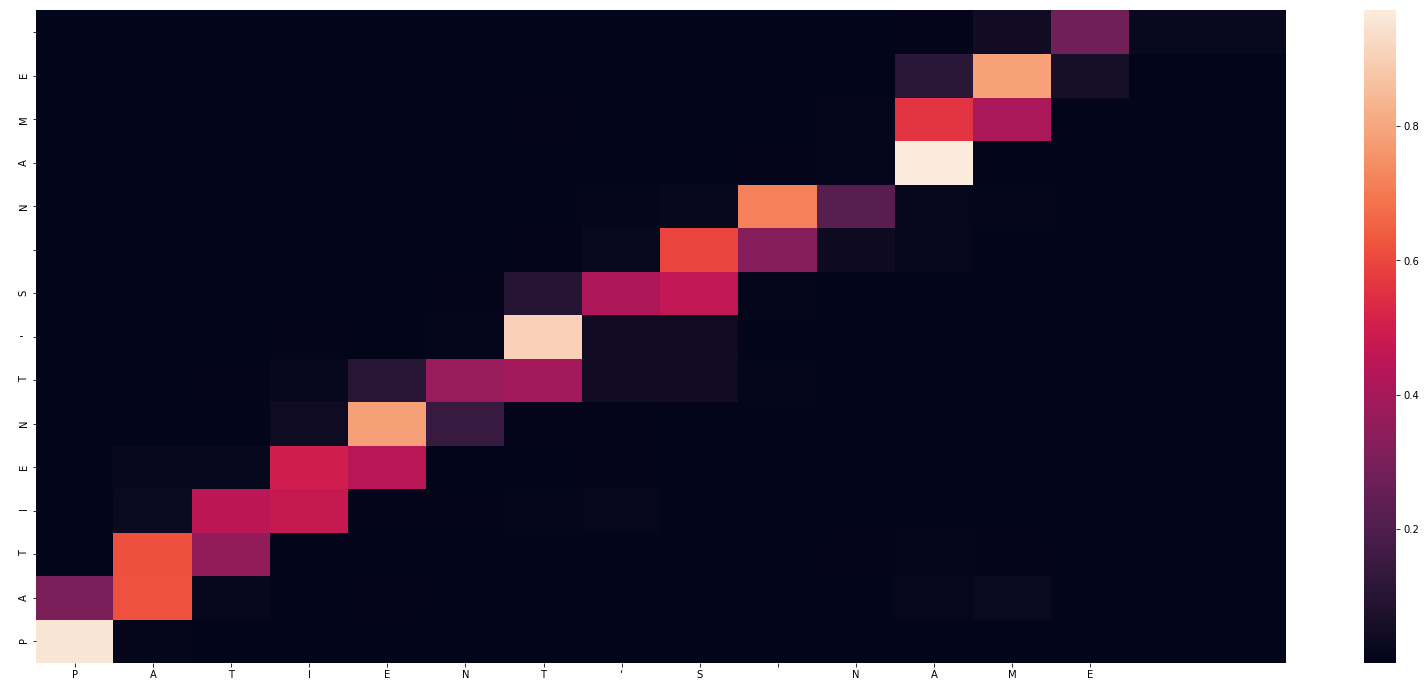

-
Input sentence: PATIENT‘S NAME
GT sentence: PATIENT'S NAME

Decoded sentence: PATIENT'S NAME



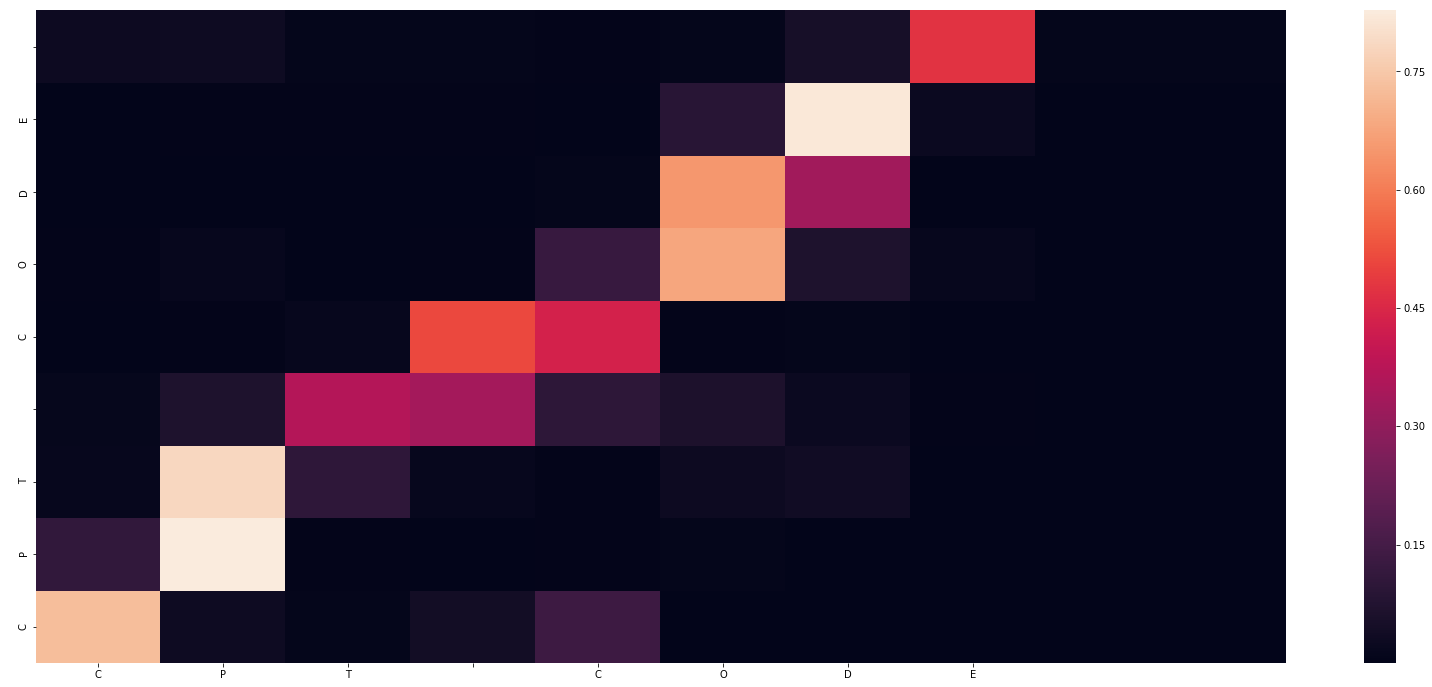

-
Input sentence: CPT CODE
GT sentence: CPT CODE

Decoded sentence: CPT CODE



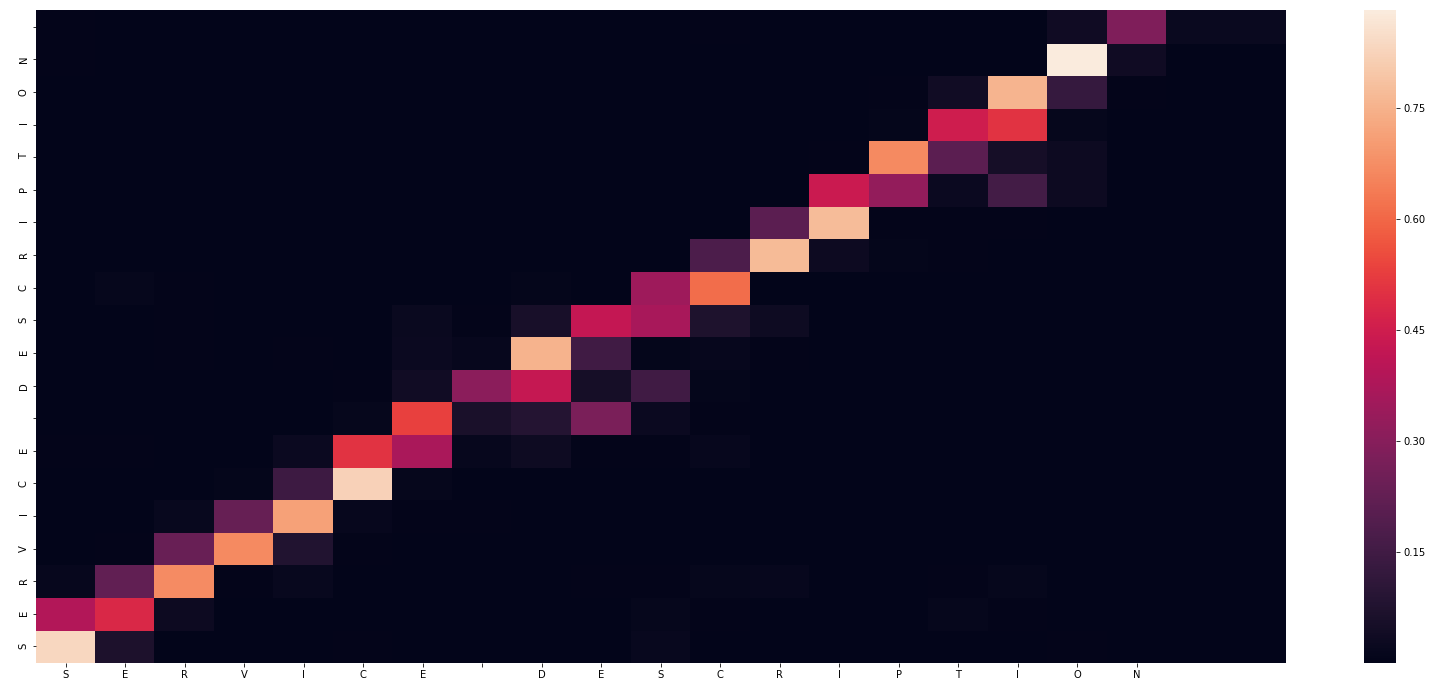

-
Input sentence: SERVICE DESCRIPTION
GT sentence: SERVICE DESCRIPTION

Decoded sentence: SERVICE DESCRIPTION



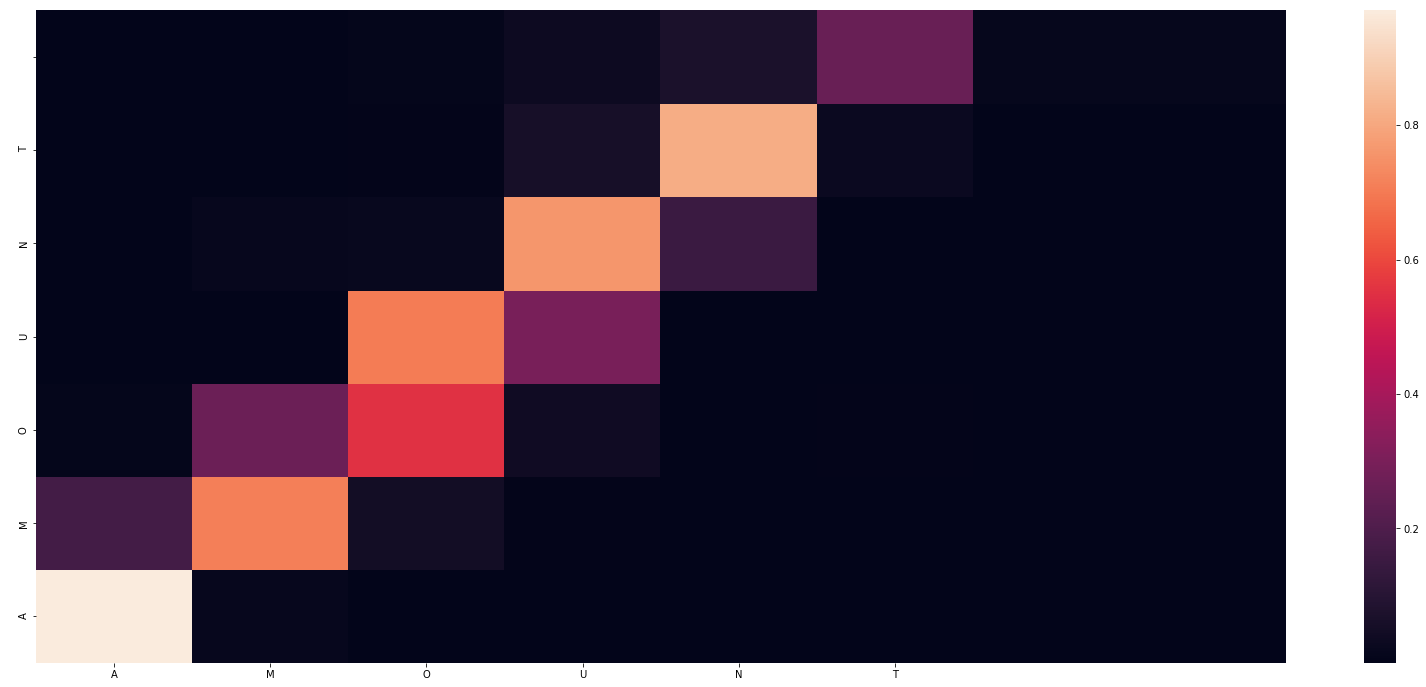

-
Input sentence: AMOUNT
GT sentence: AMOUNT

Decoded sentence: AMOUNT



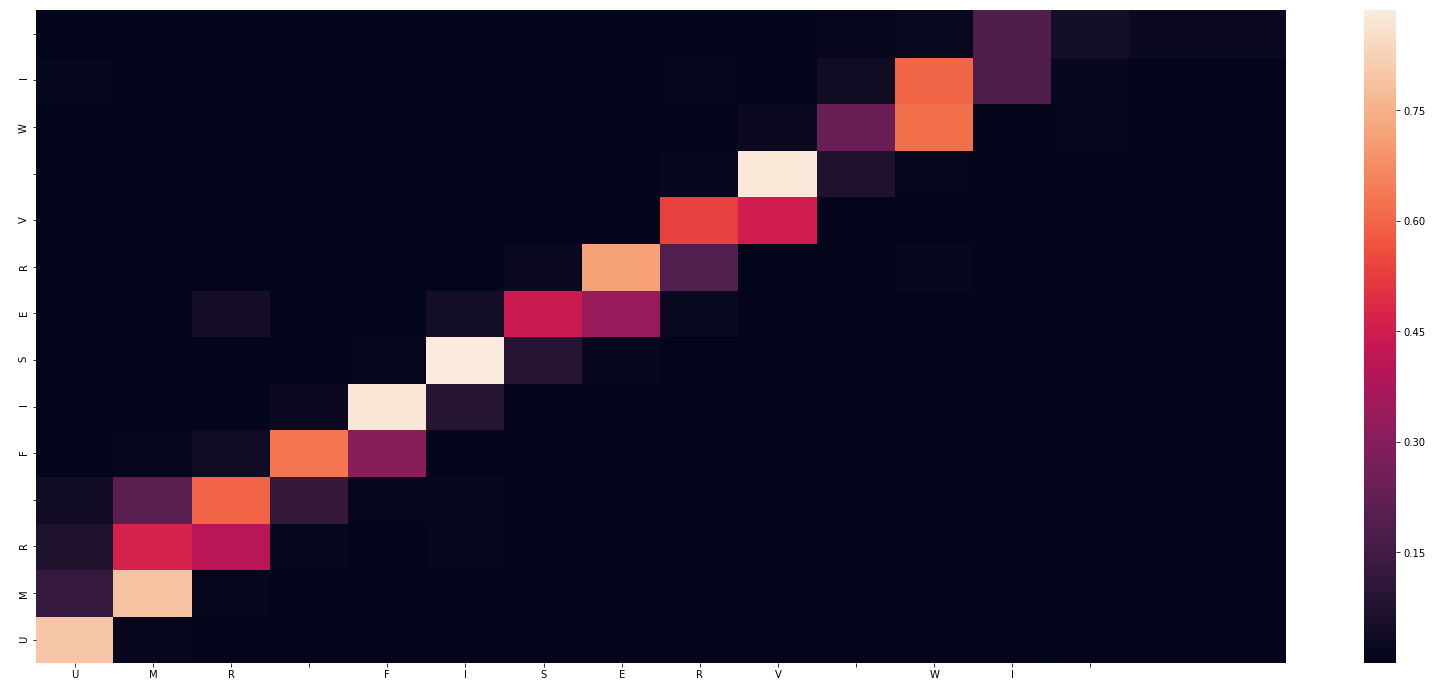

-
Input sentence: UMR FISERV WI 
GT sentence: UMR FISERV WI BILLED ON 12/12/17

Decoded sentence: UMR FISERV WI



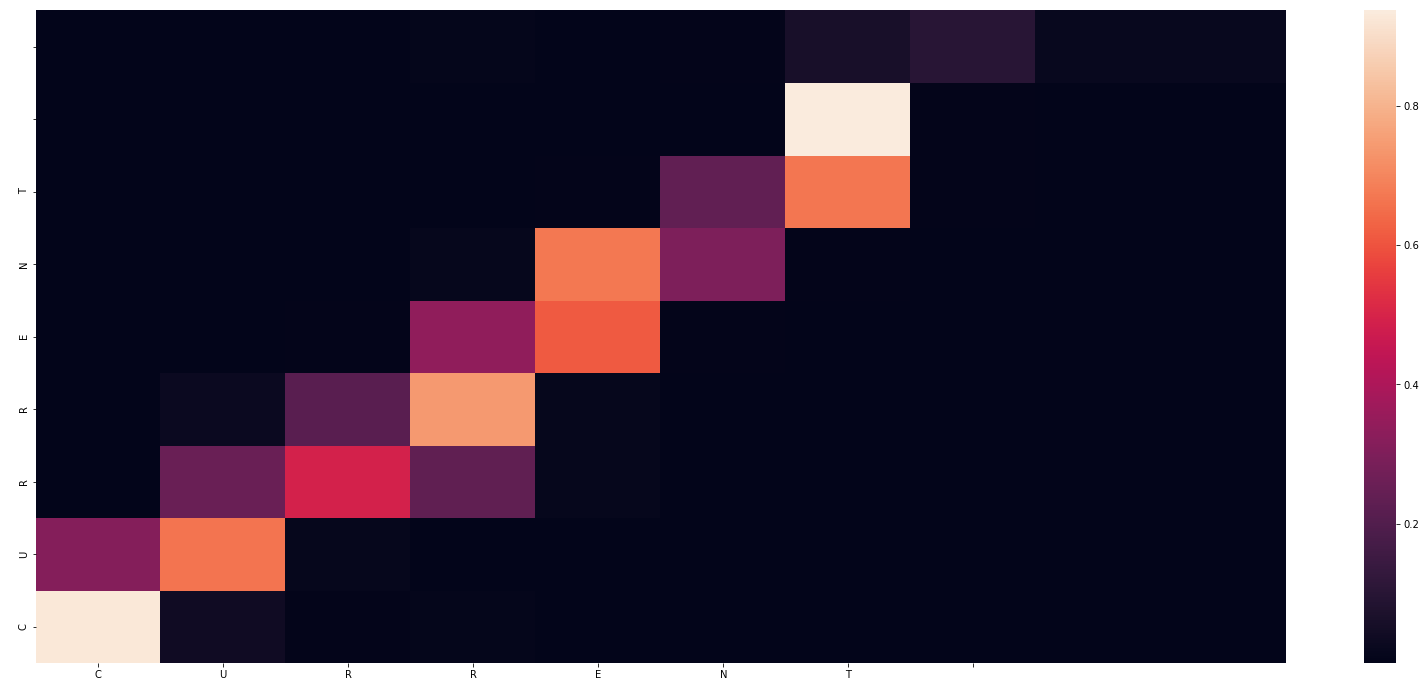

-
Input sentence: CURRENT 
GT sentence: CURRENT 

Decoded sentence: CURRENT 



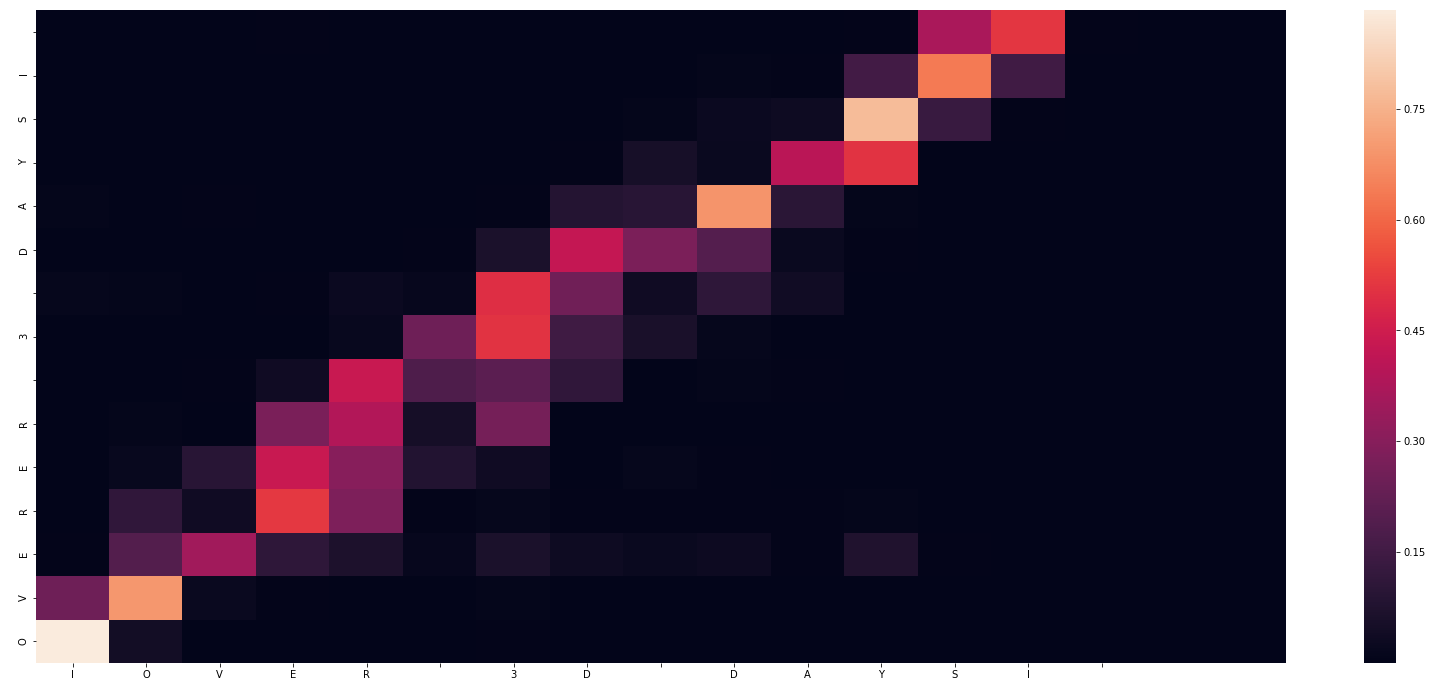

-
Input sentence: IOVER 3D DAYSI 
GT sentence: OVER 30 DAYS 

Decoded sentence: OVERER 3 DAYSI



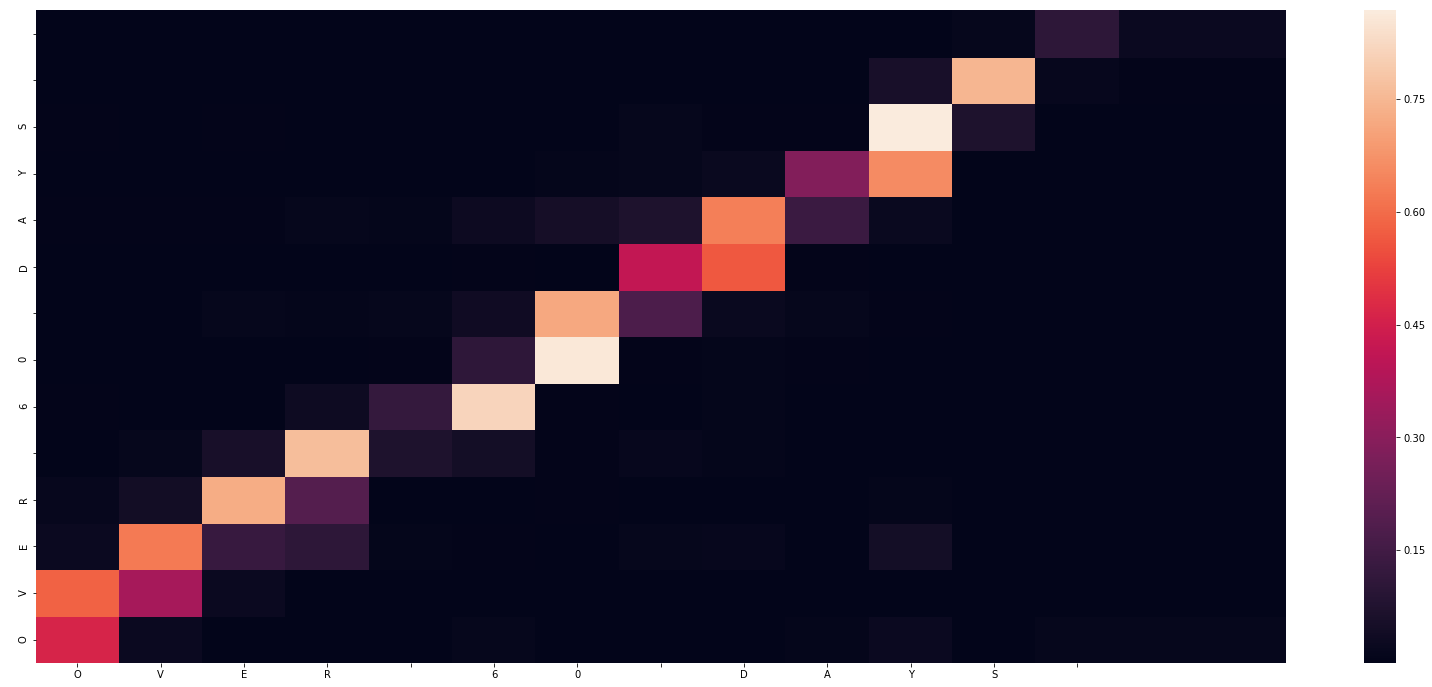

-
Input sentence: OVER 60 DAYS 
GT sentence: OVER 60 DAYS 

Decoded sentence: OVER 60 DAYS 



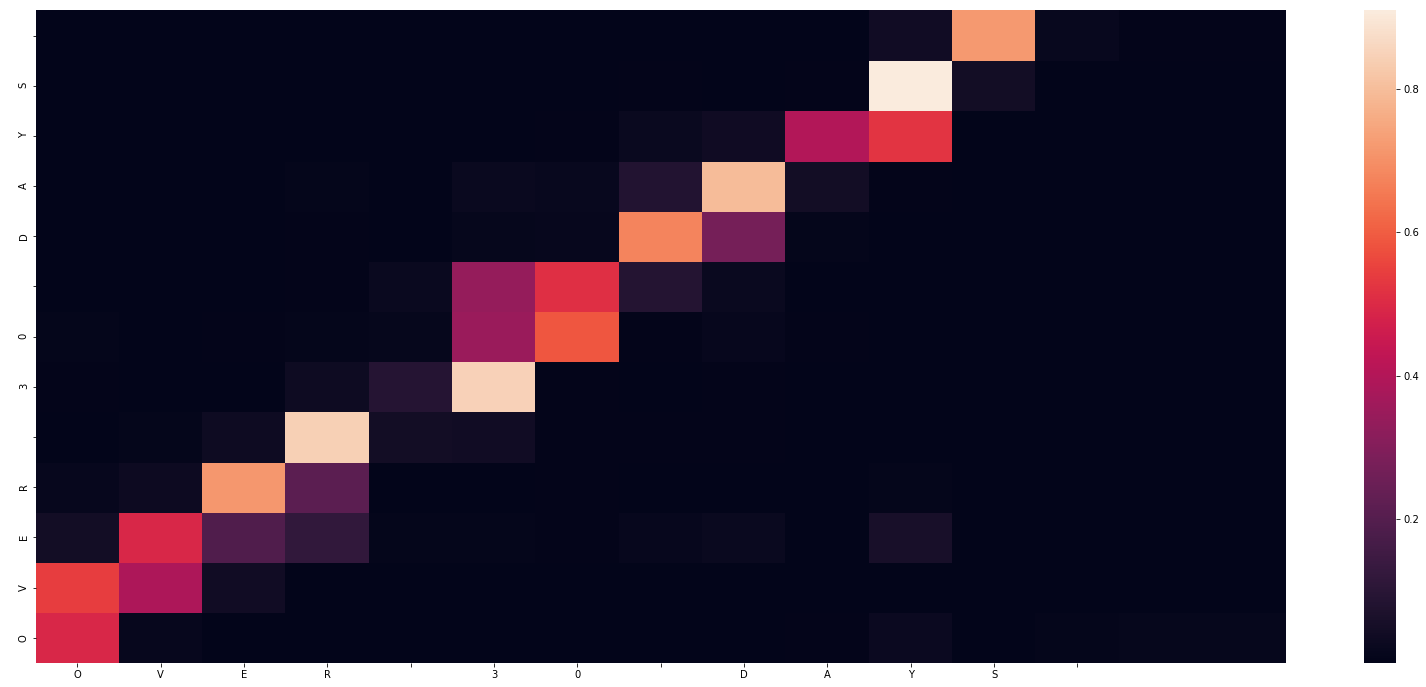

-
Input sentence: OVER 30 DAYS 
GT sentence: OVER 90 DAYS 

Decoded sentence: OVER 30 DAYS



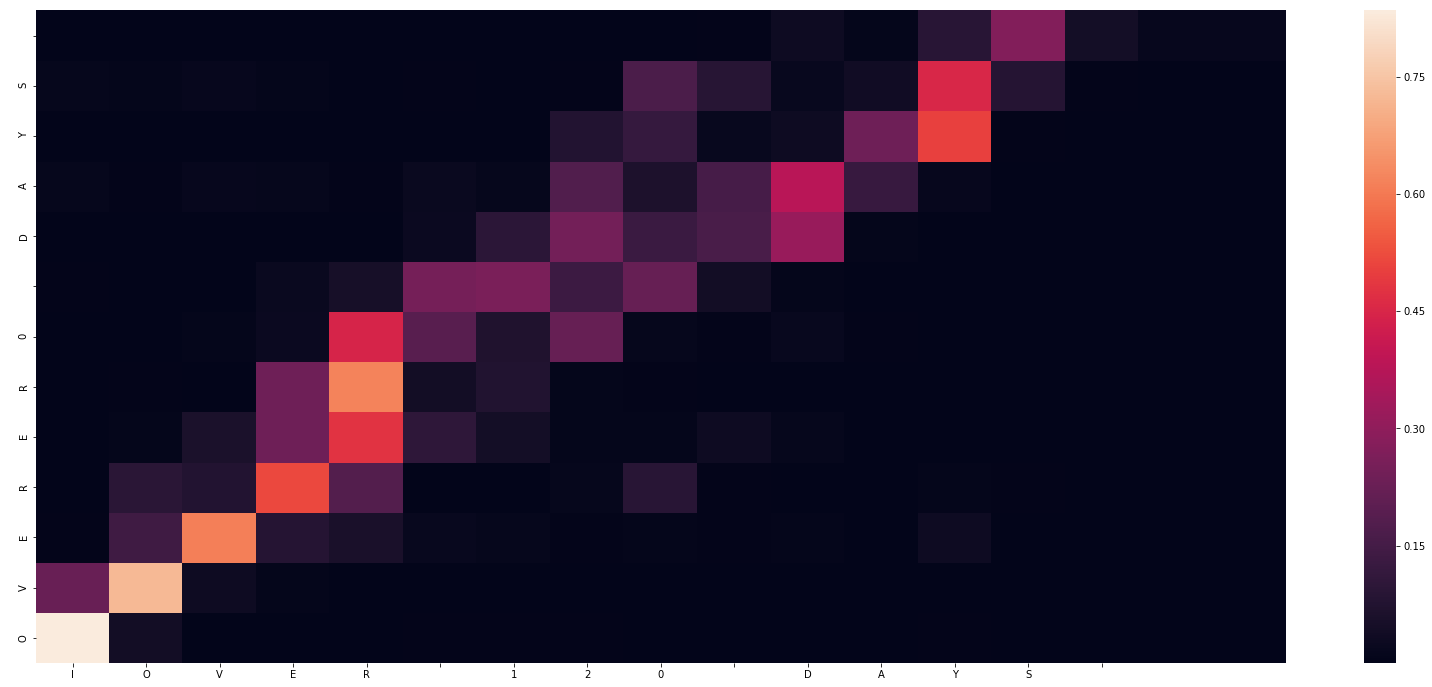

-
Input sentence: IOVER 120 DAYS 
GT sentence: OVER 120 DAYS

Decoded sentence: OVERER0 DAYS



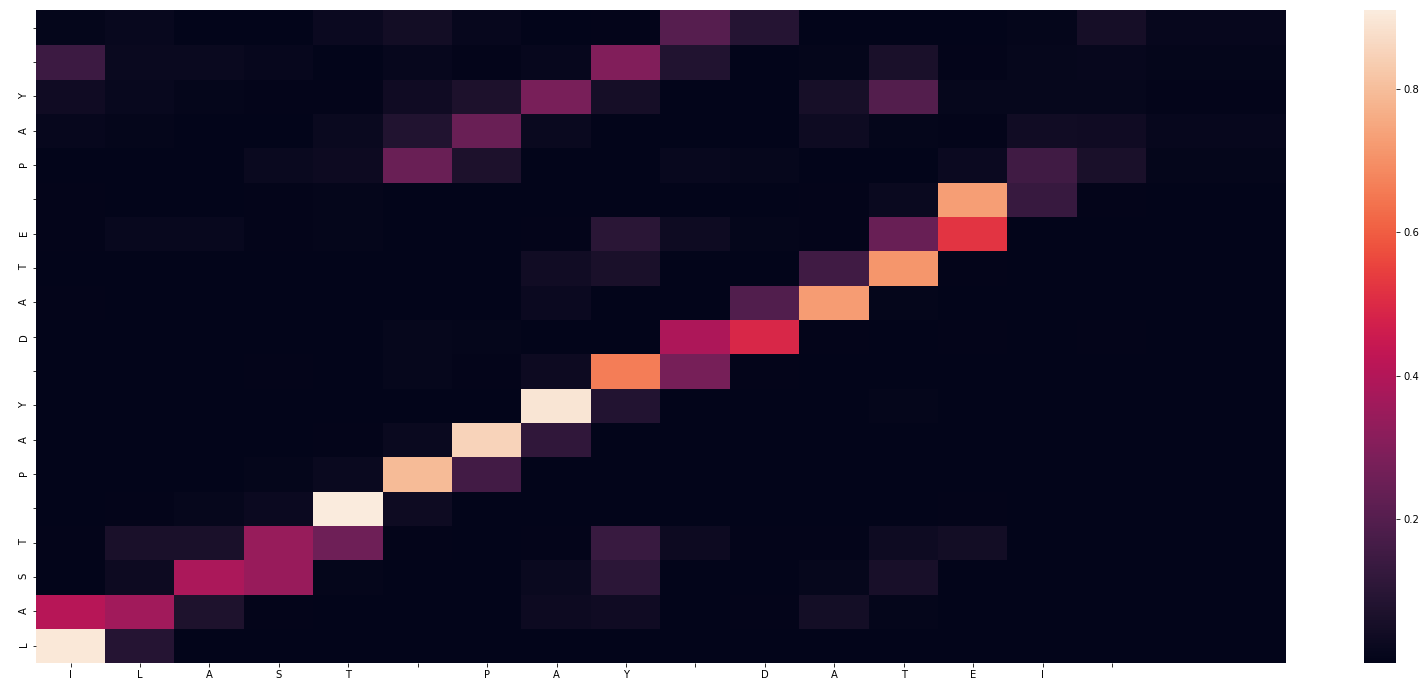

-
Input sentence: ILAST PAY DATEI 
GT sentence: LAST PAY DATE

Decoded sentence: LAST PAY DATE PAY 



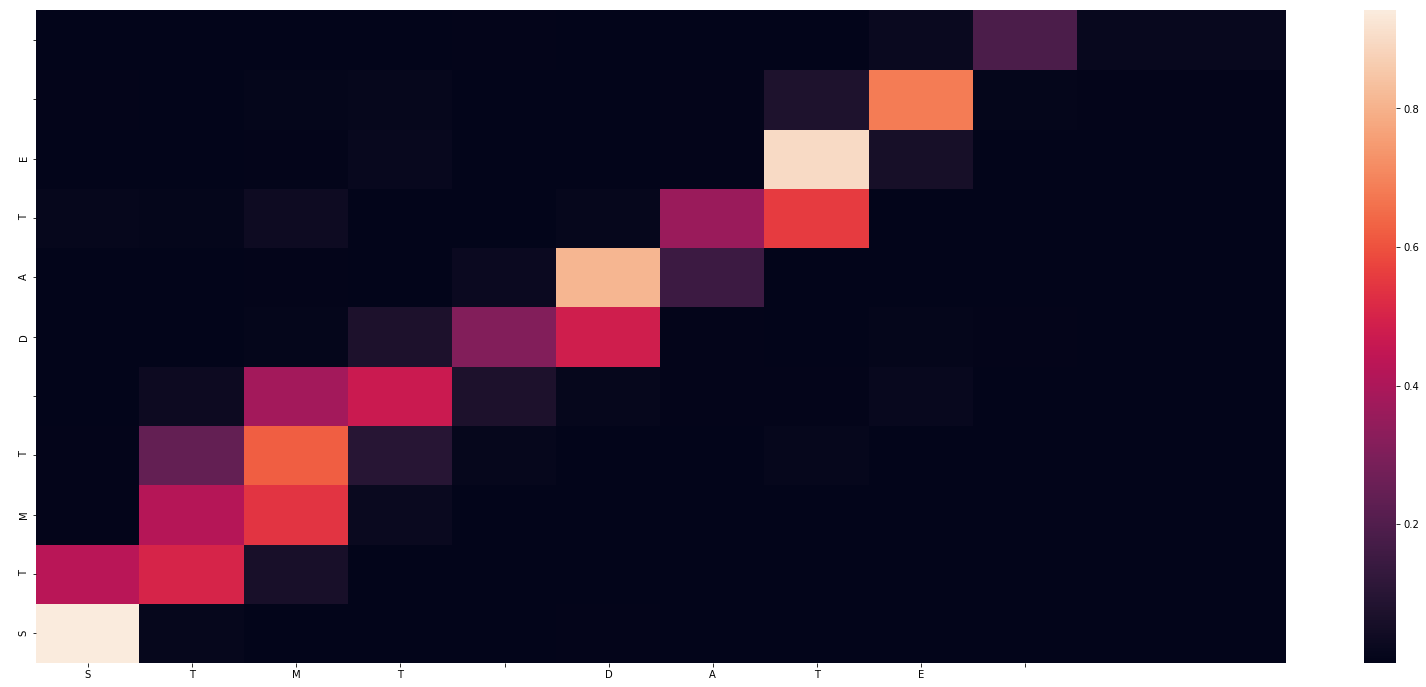

-
Input sentence: STMT DATE 
GT sentence: STMT DATE 

Decoded sentence: STMT DATE 



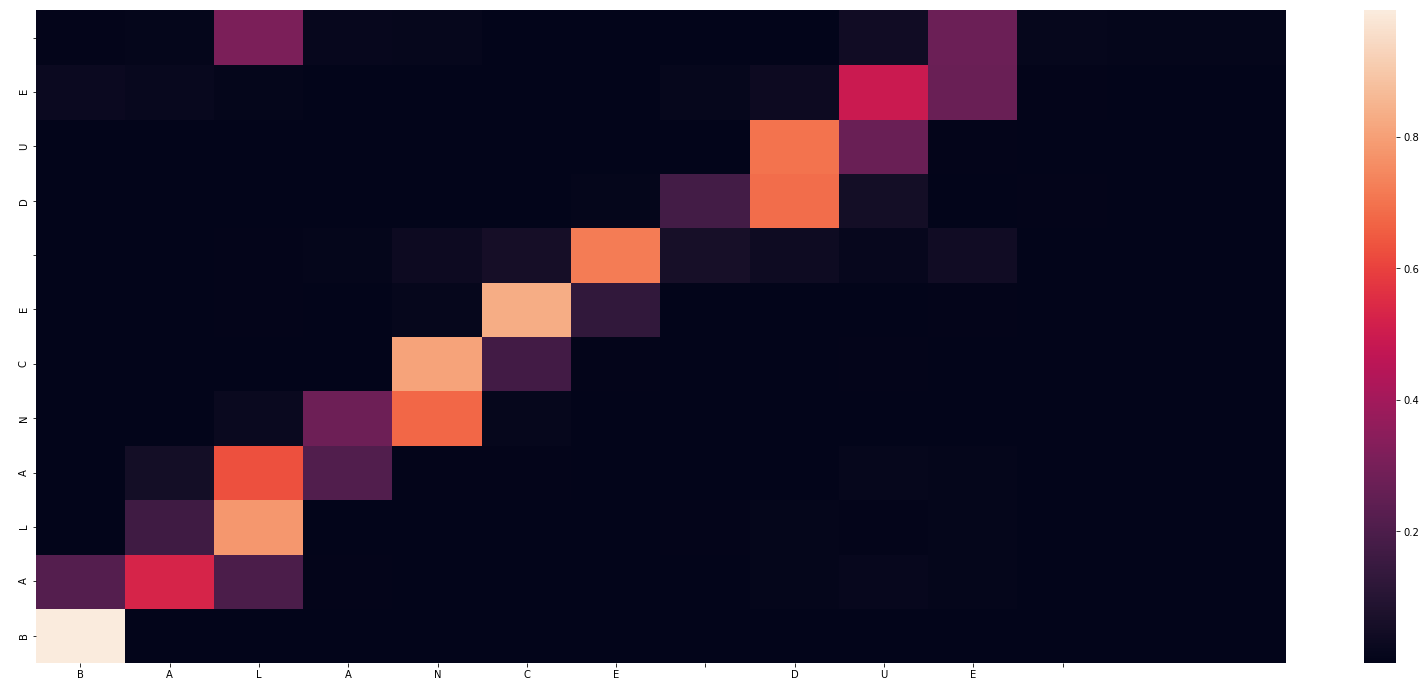

-
Input sentence: BALANCE DUE 
GT sentence: BALANCE DUE

Decoded sentence: BALANCE DUE



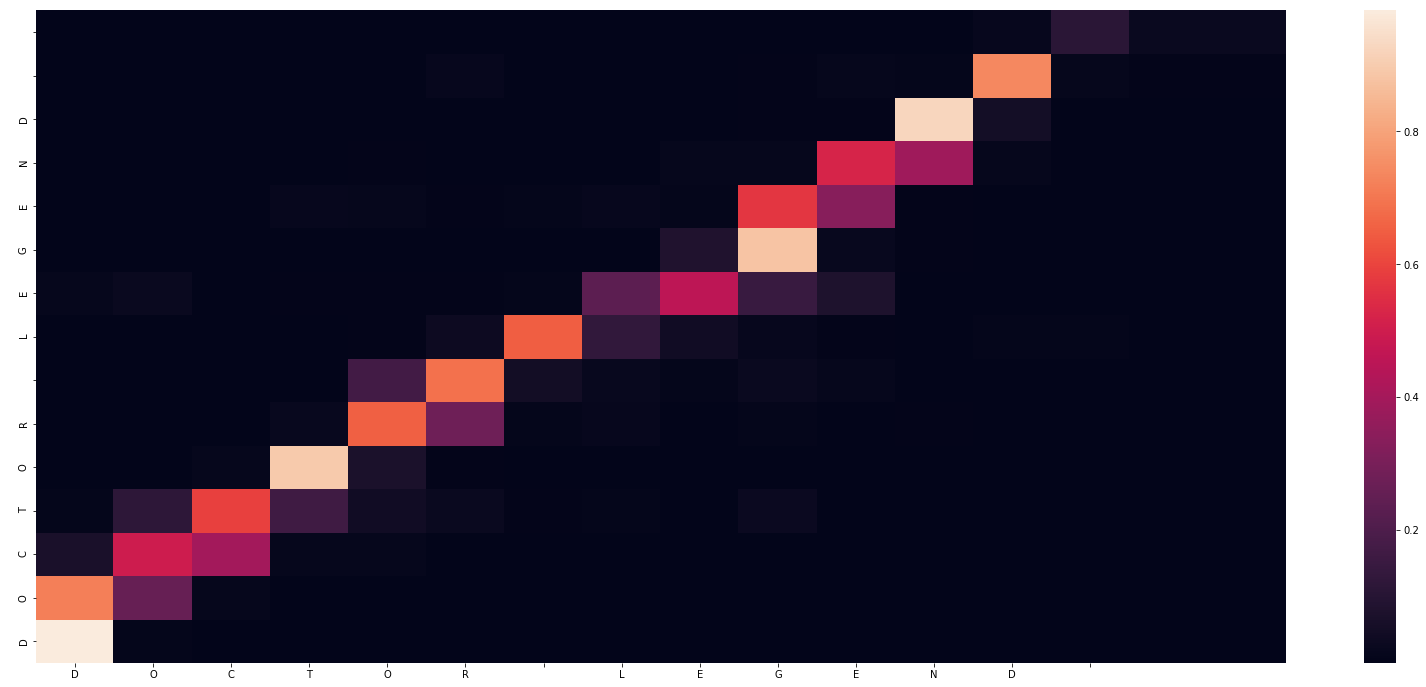

-
Input sentence: DOCTOR LEGEND 
GT sentence: DOCTOR LEGEND

Decoded sentence: DOCTOR LEGEND 



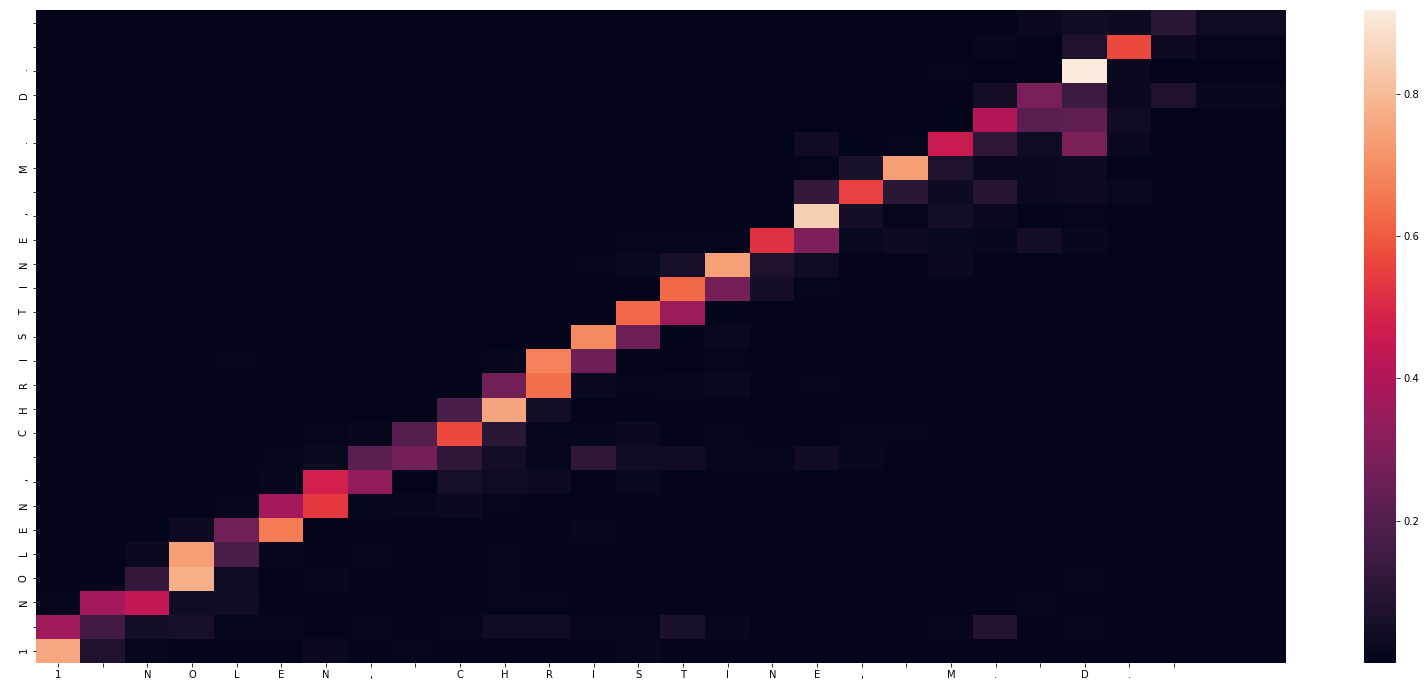

-
Input sentence: 1 NOLEN, CHRISTINE, M. D. 
GT sentence: 1 NOLEN, CHRISTINE, M. D.

Decoded sentence: 1 NOLEN, CHRISTINE, M. D. 



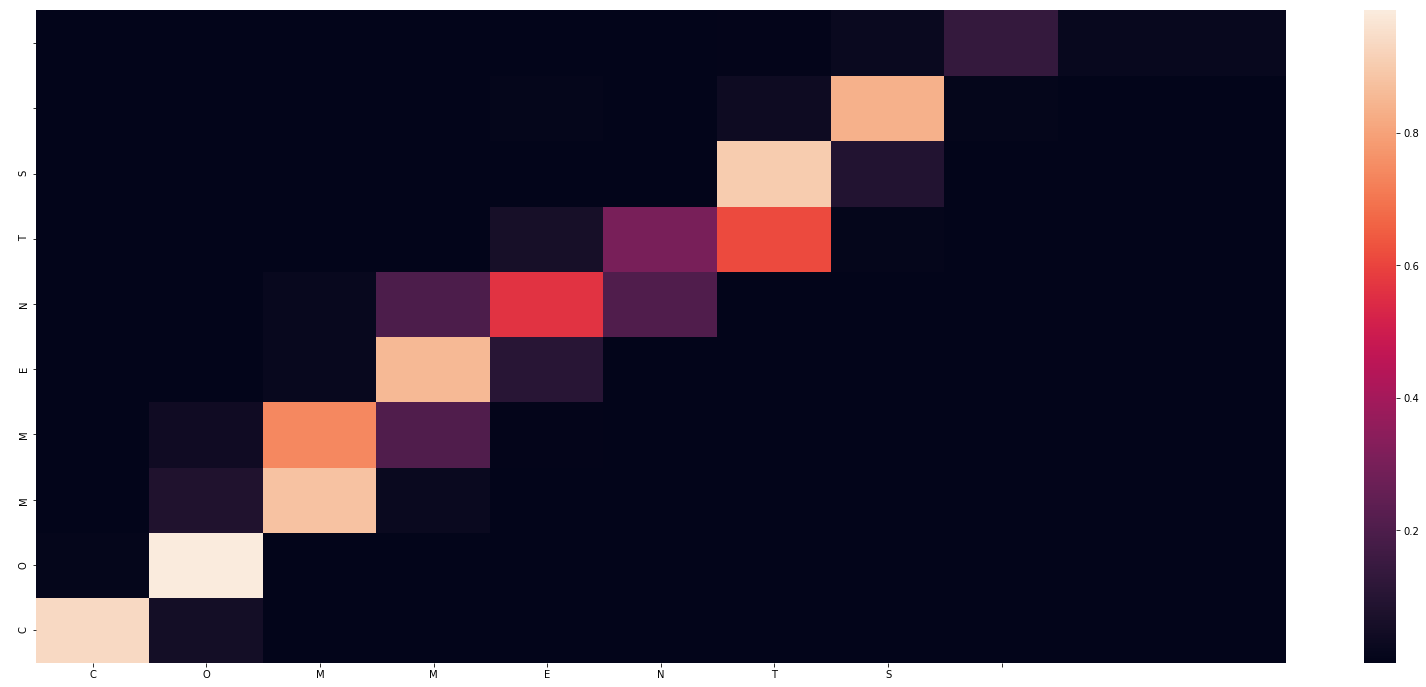

-
Input sentence: COMMENTS 
GT sentence: COMMENTS

Decoded sentence: COMMENTS 



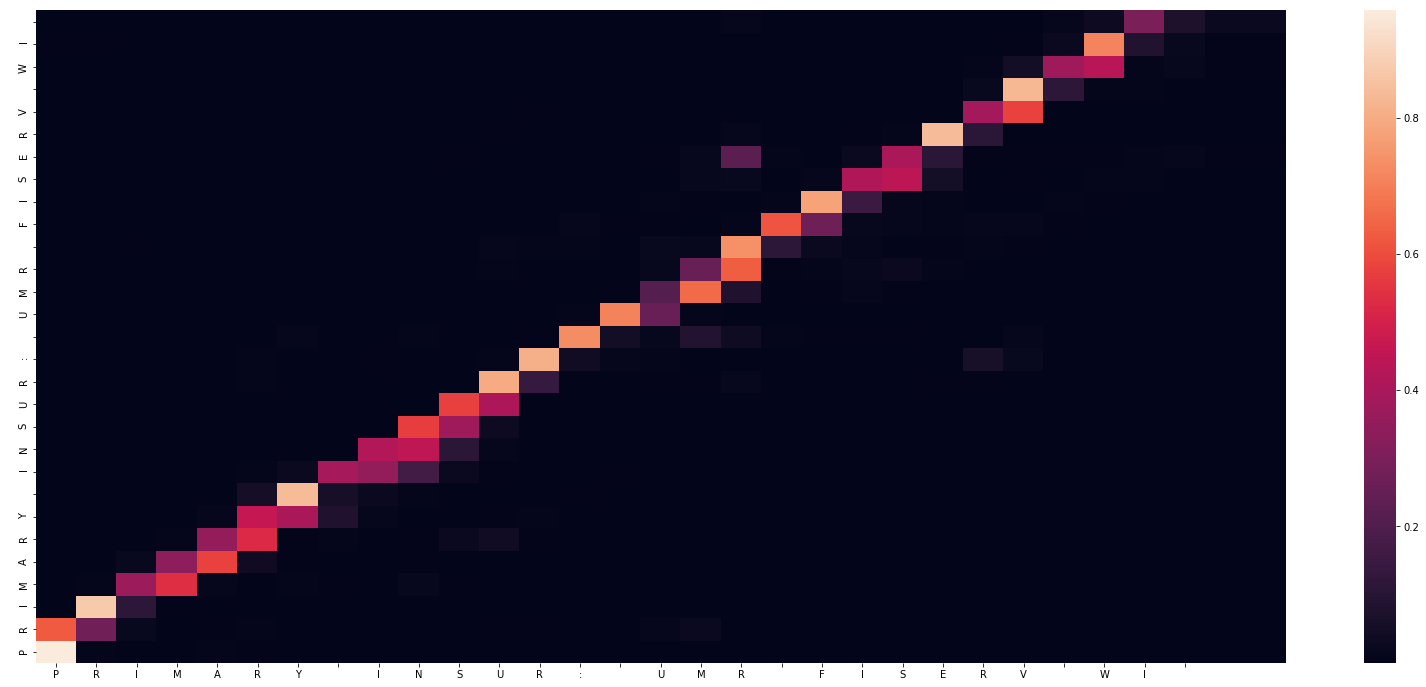

-
Input sentence: PRIMARY INSUR: UMR FISERV WI 
GT sentence: PRIMARY INSUR: UMR FISERV WI

Decoded sentence: PRIMARY INSUR: UMR FISERV WI



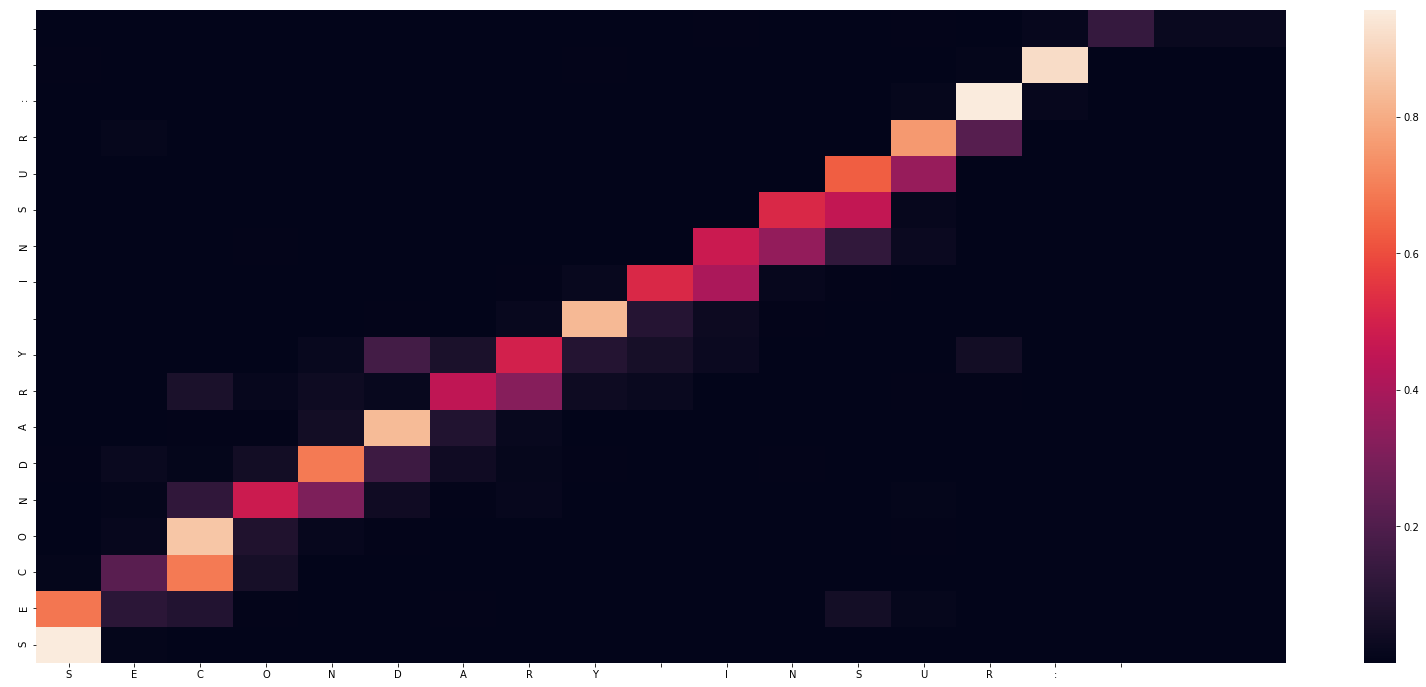

-
Input sentence: SECONDARY INSUR: 
GT sentence: SECONDARY INSUR:

Decoded sentence: SECONDARY INSUR: 



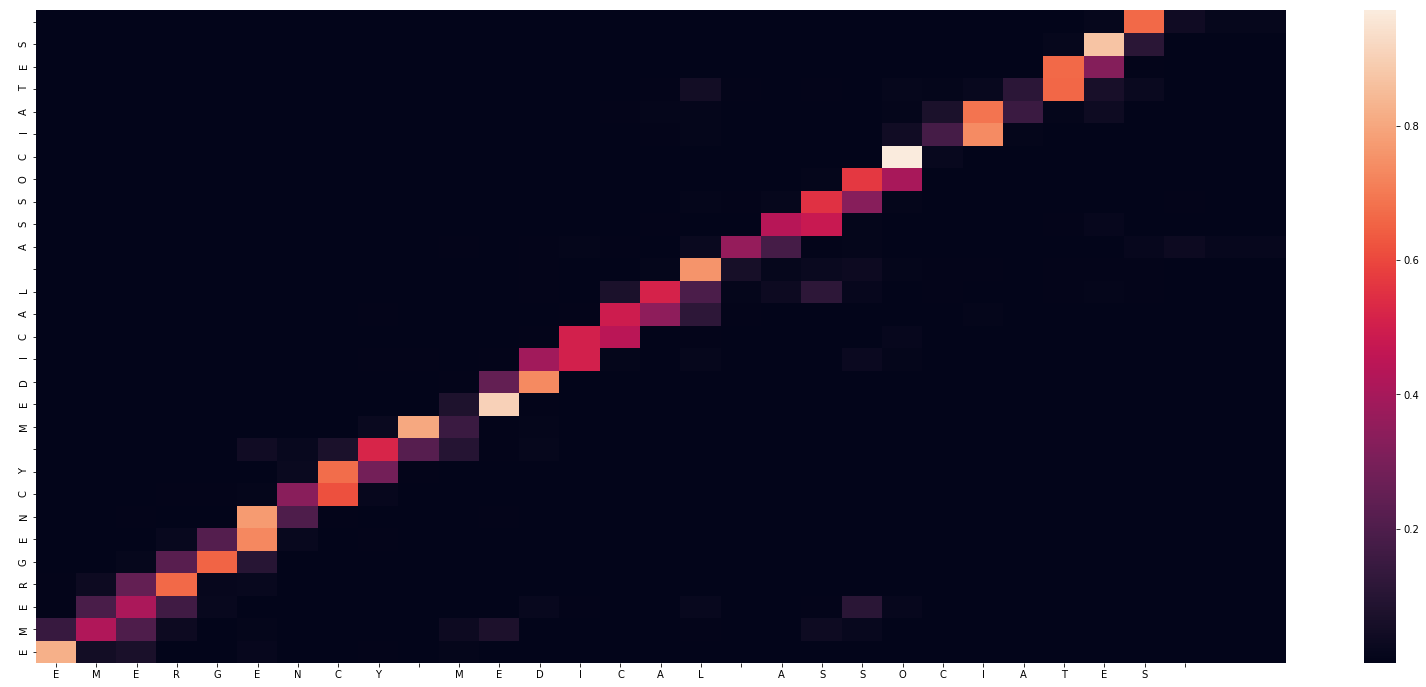

-
Input sentence: EMERGENCY MEDICAL ASSOCIATES 
GT sentence: EMERGENCY MEDICAL ASSOCIATES

Decoded sentence: EMERGENCY MEDICAL ASSOCIATES



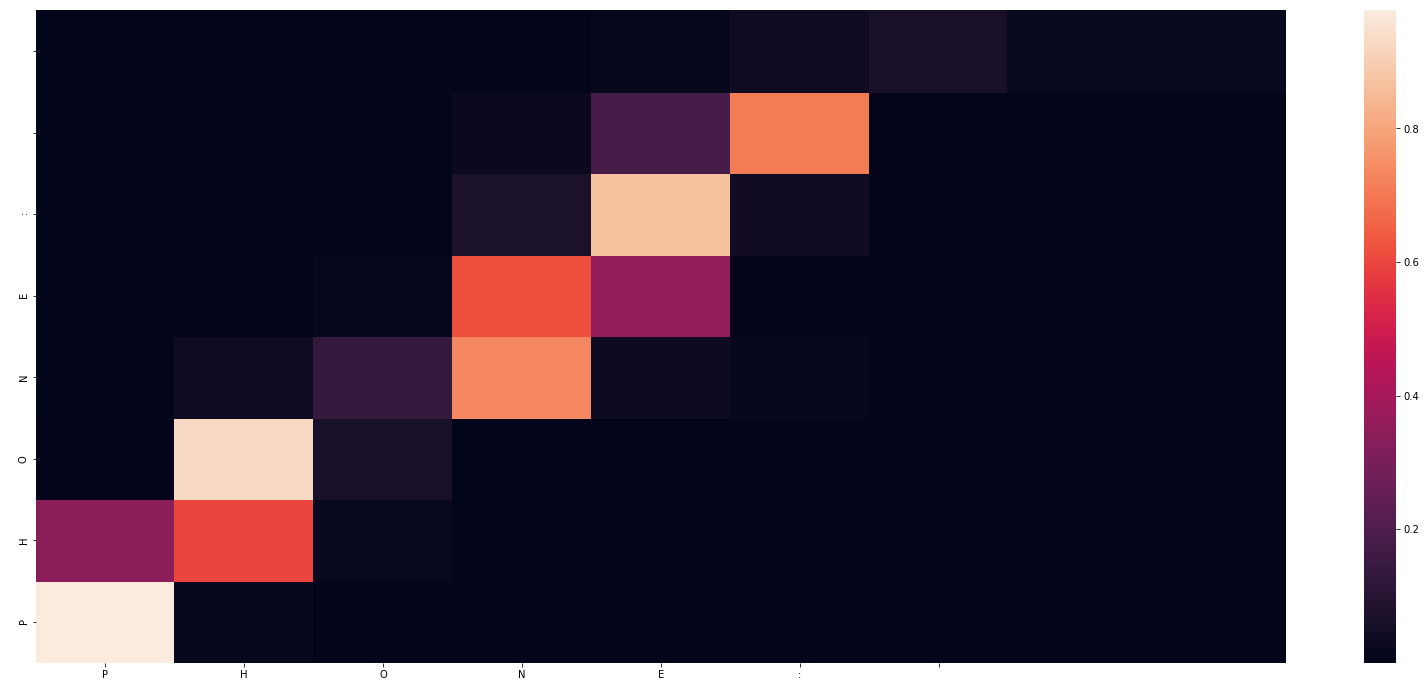

-
Input sentence: PHONE: 
GT sentence: PHONE:

Decoded sentence: PHONE: 



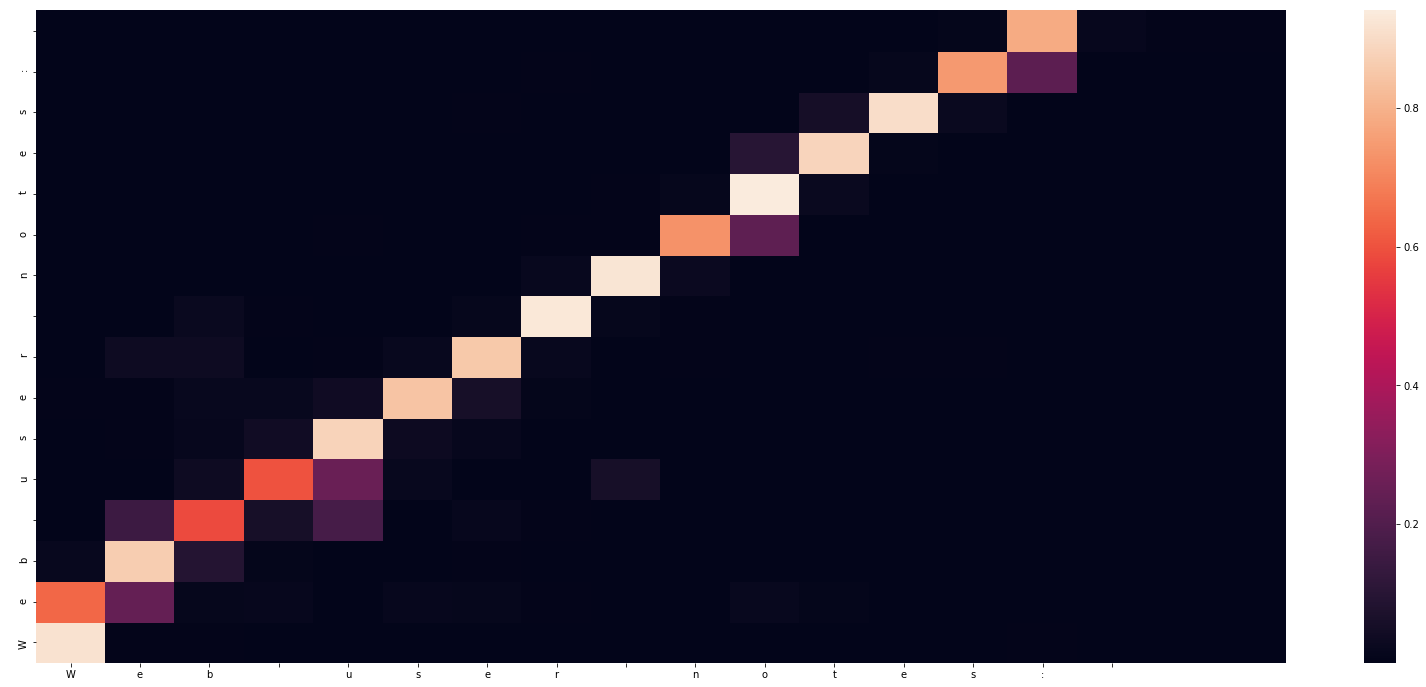

-
Input sentence: Web user notes: 
GT sentence: Web user notes:

Decoded sentence: Web user notes:



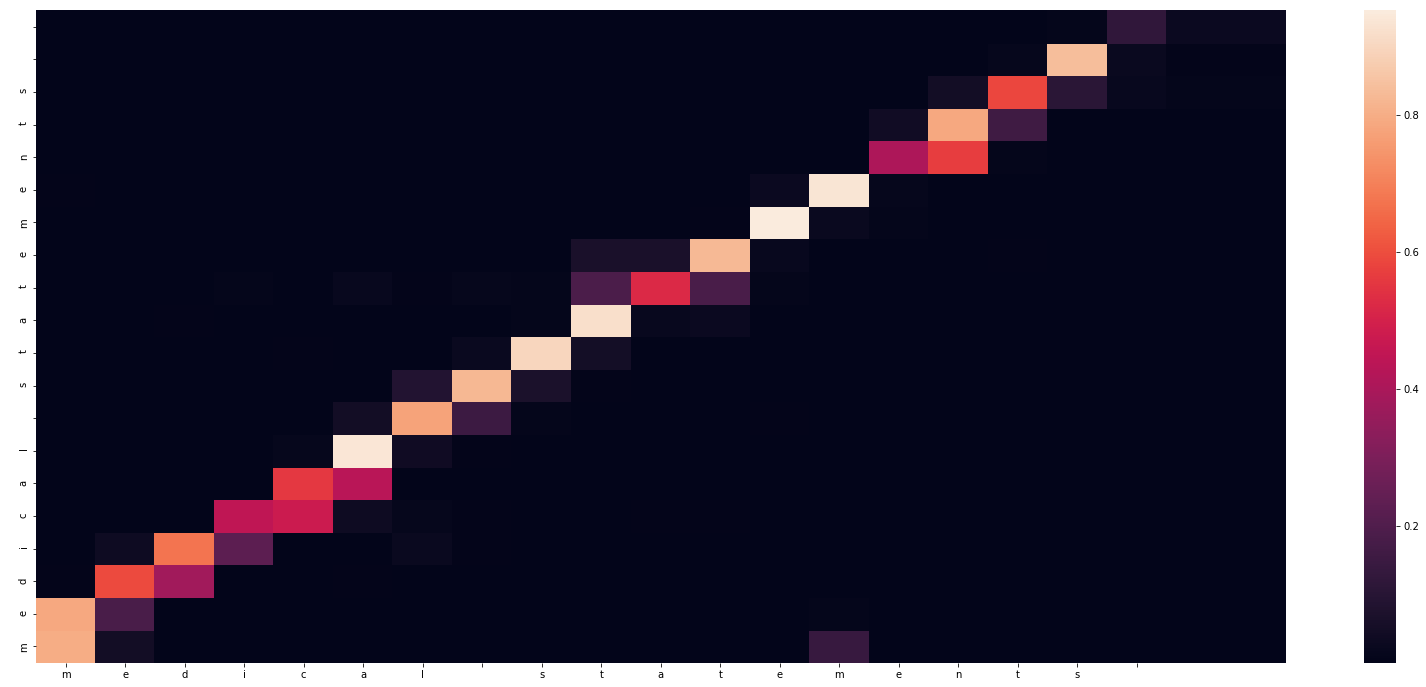

-
Input sentence: medical statements 
GT sentence: medical statements

Decoded sentence: medical statements 



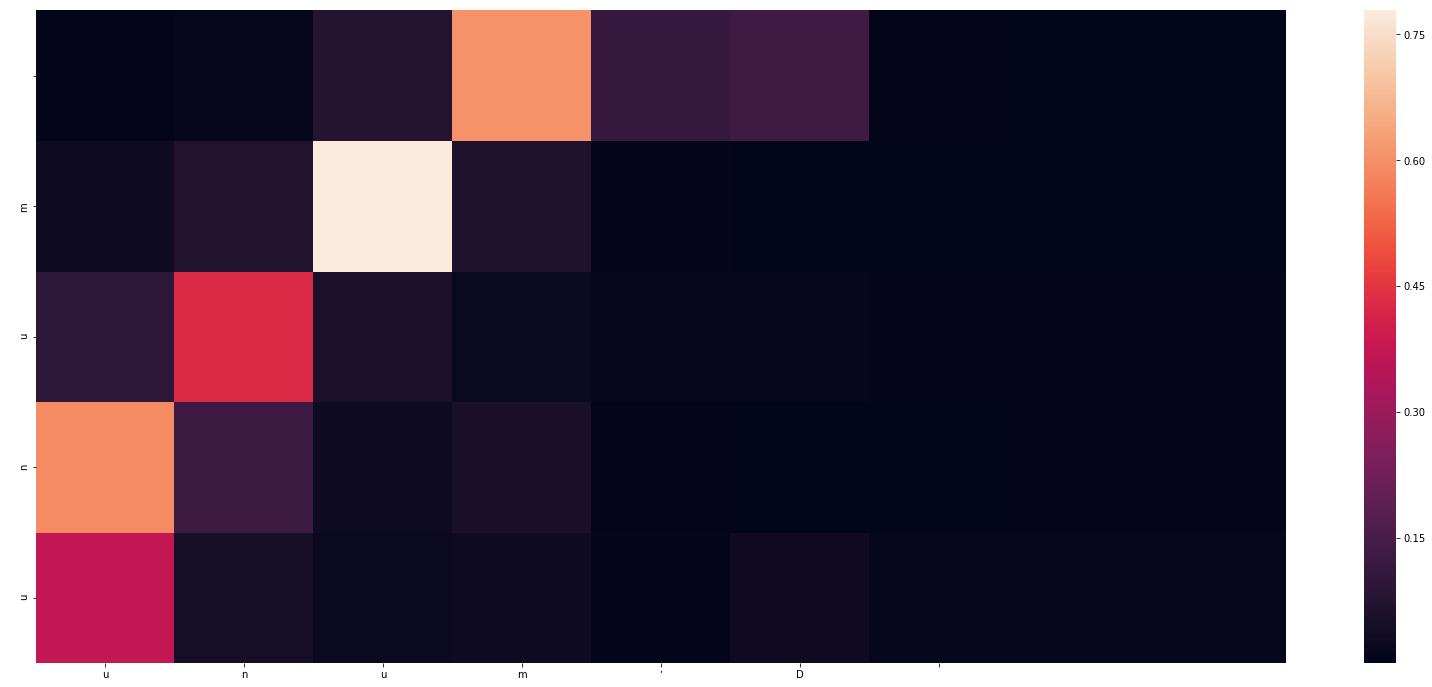

-
Input sentence: unum‘D 
GT sentence: unum

Decoded sentence: unum



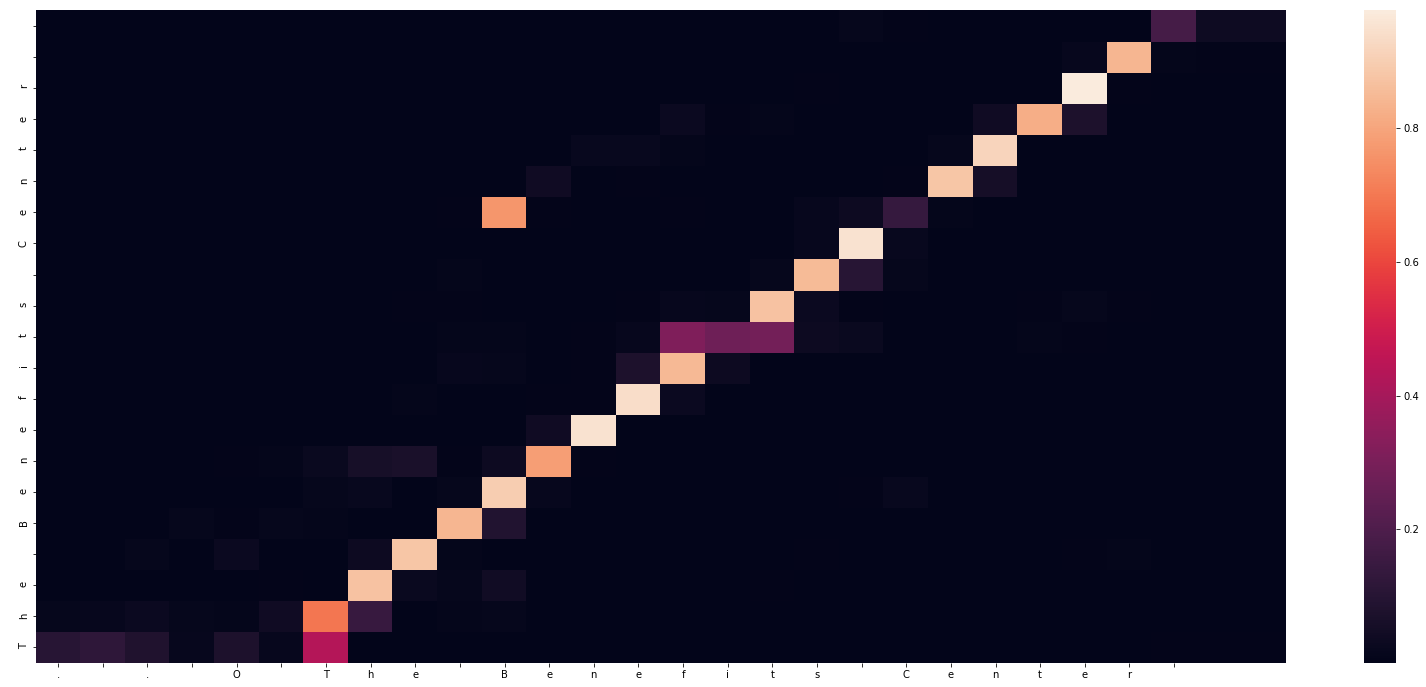

-
Input sentence: . . O The Benefits Center 
GT sentence: The Benefits Center

Decoded sentence: The Benefits Center 



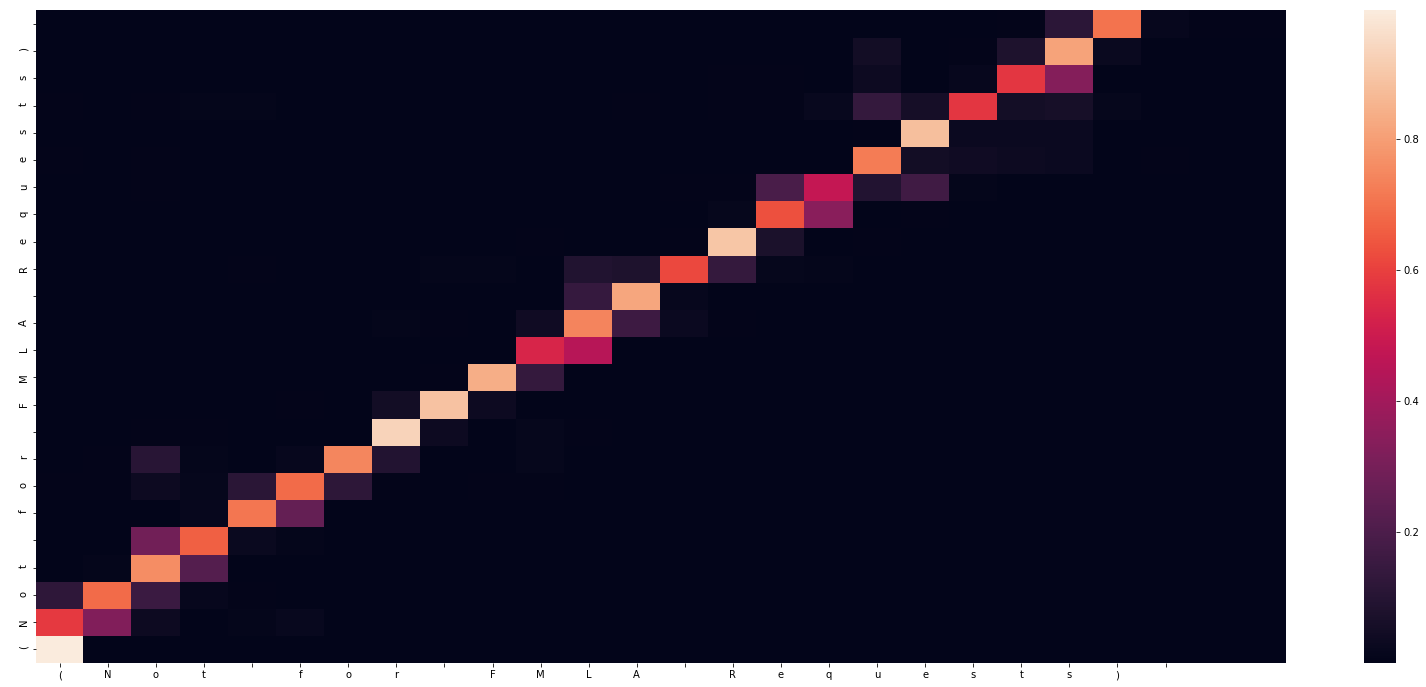

-
Input sentence: (Not for FMLA Requests) 
GT sentence: (Not for FMLA Requests)

Decoded sentence: (Not for FMLA Requests)



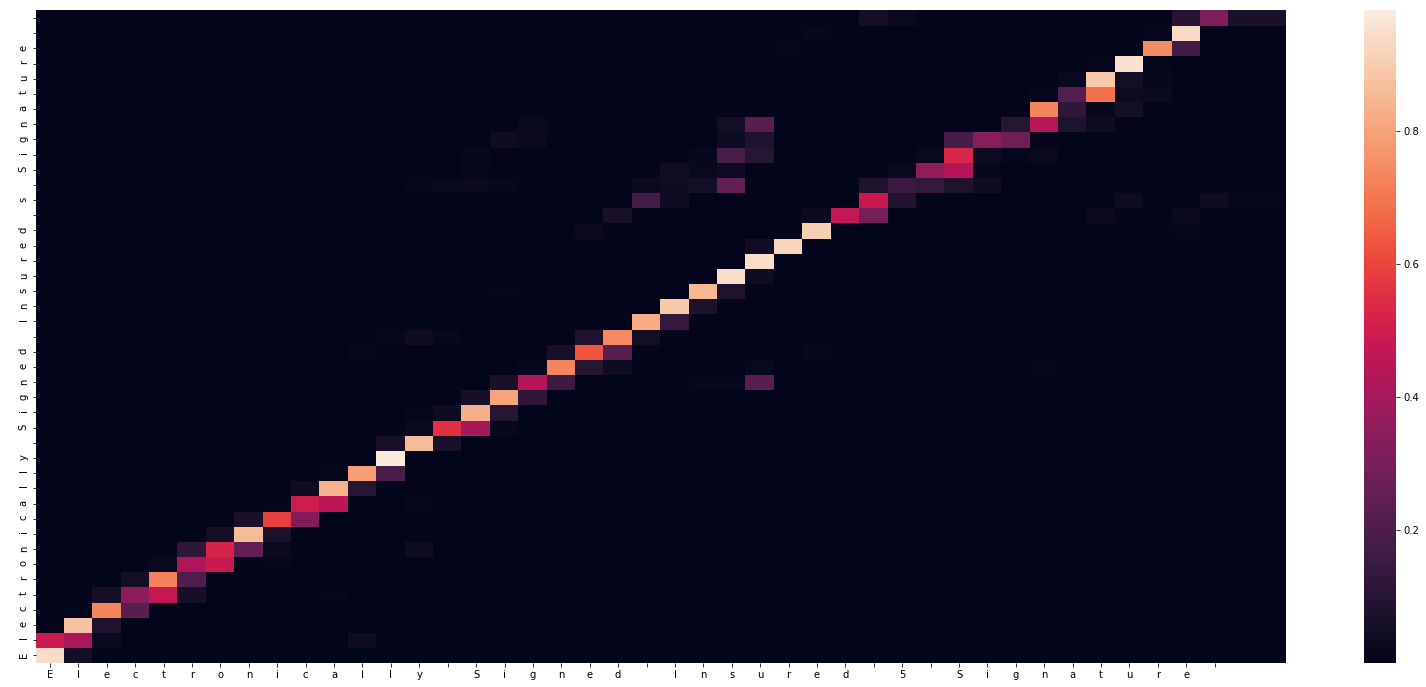

-
Input sentence: Electronically Signed Insured 5 Signature 
GT sentence: Electronically Signed Insured's Signature

Decoded sentence: Electronically Signed Insured s Signature 



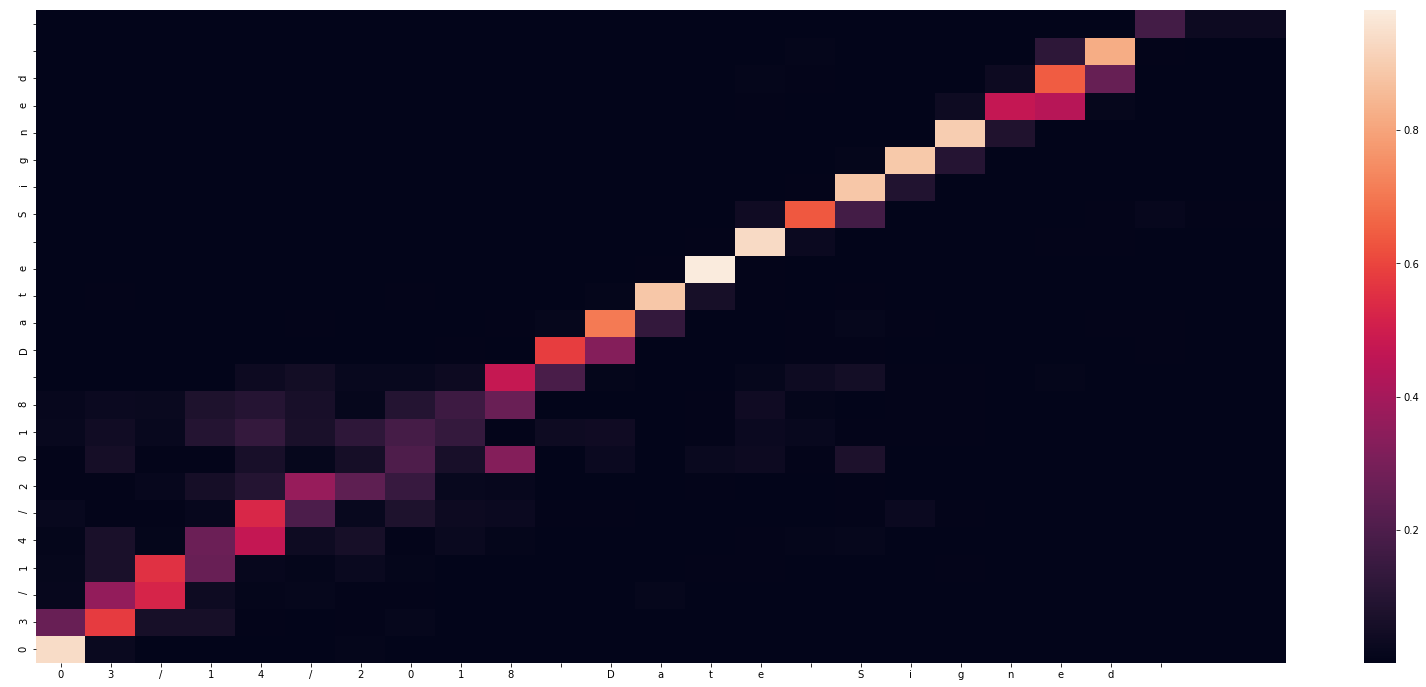

-
Input sentence: 03/14/2018 Date Signed 
GT sentence: 03/14/2018 Date Signed

Decoded sentence: 03/14/2018 Date Signed 



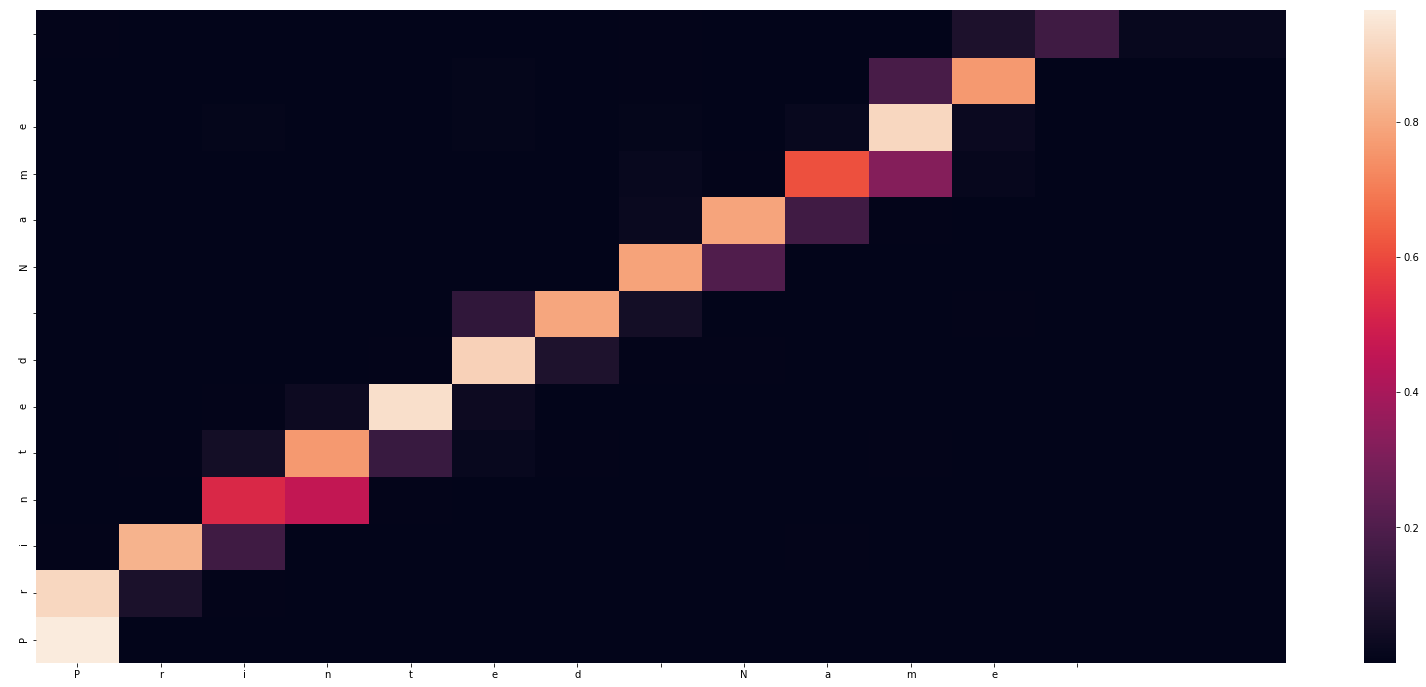

-
Input sentence: Printed Name 
GT sentence: Printed Name

Decoded sentence: Printed Name 



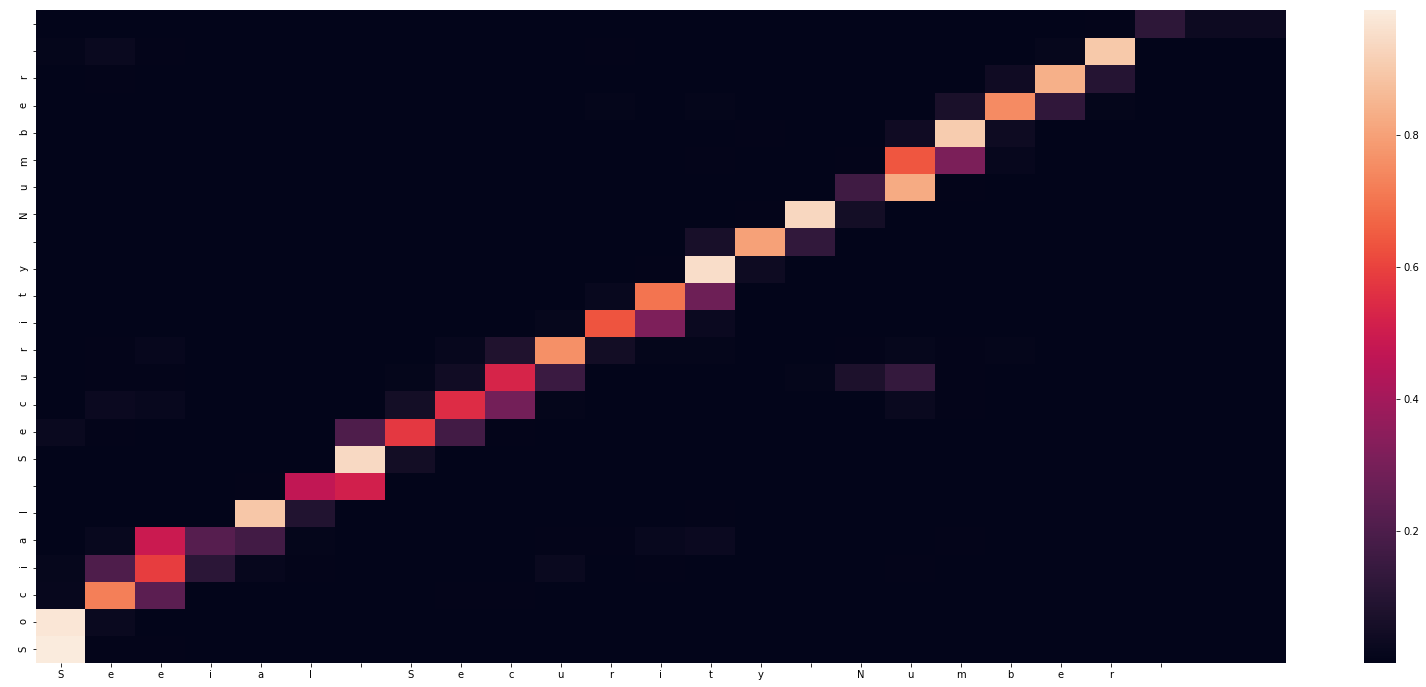

-
Input sentence: Seeial Security Number 
GT sentence: Social Security Number

Decoded sentence: Social Security Number 



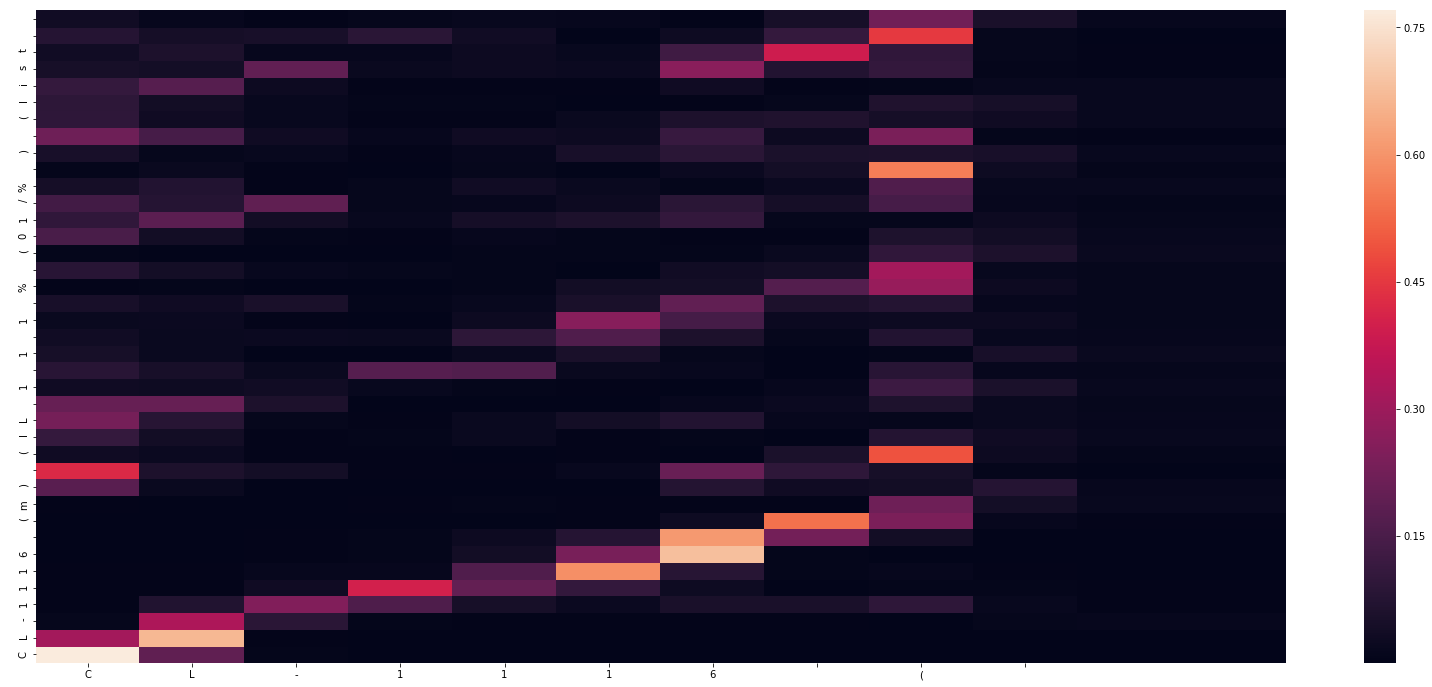

-
Input sentence: CL-1116 ( 
GT sentence: CL-1116

Decoded sentence: CL-1116 (m) (IL 1 1 1 % (01/% ) (list 



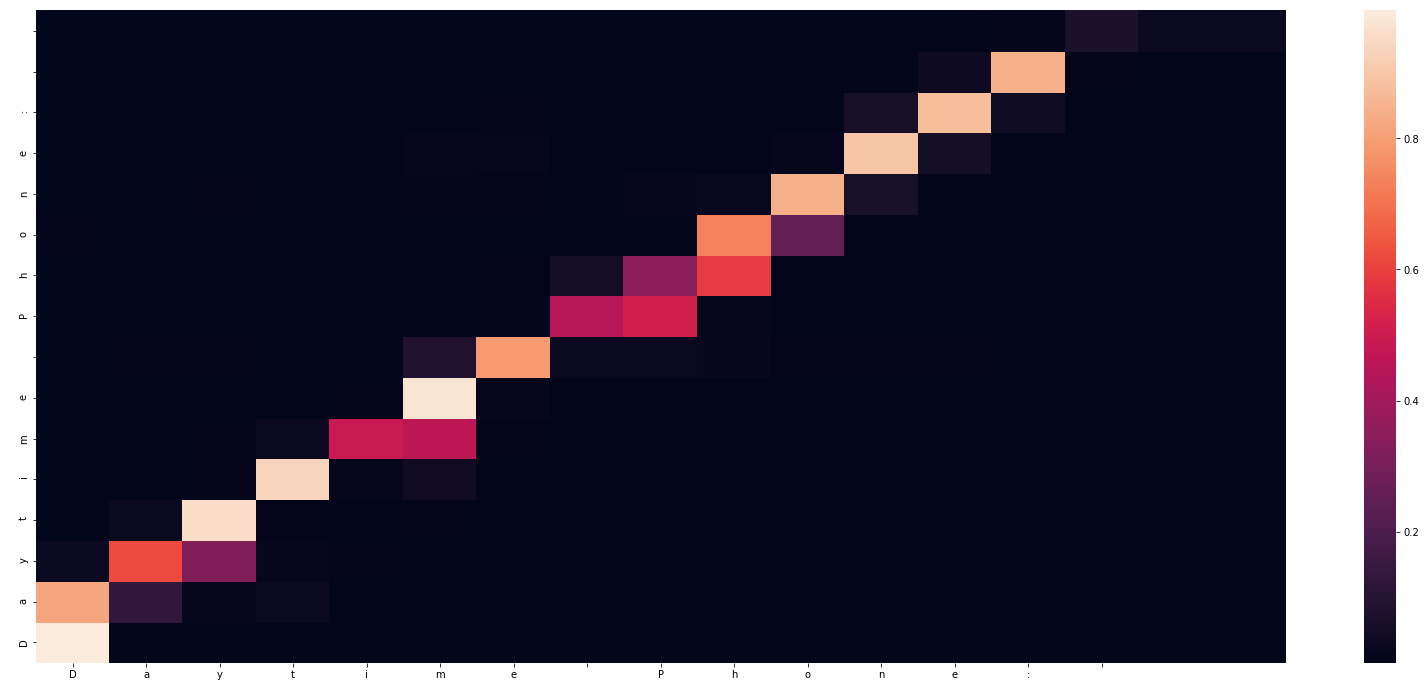

-
Input sentence: Daytime Phone: 
GT sentence: Daytime Phone:

Decoded sentence: Daytime Phone: 



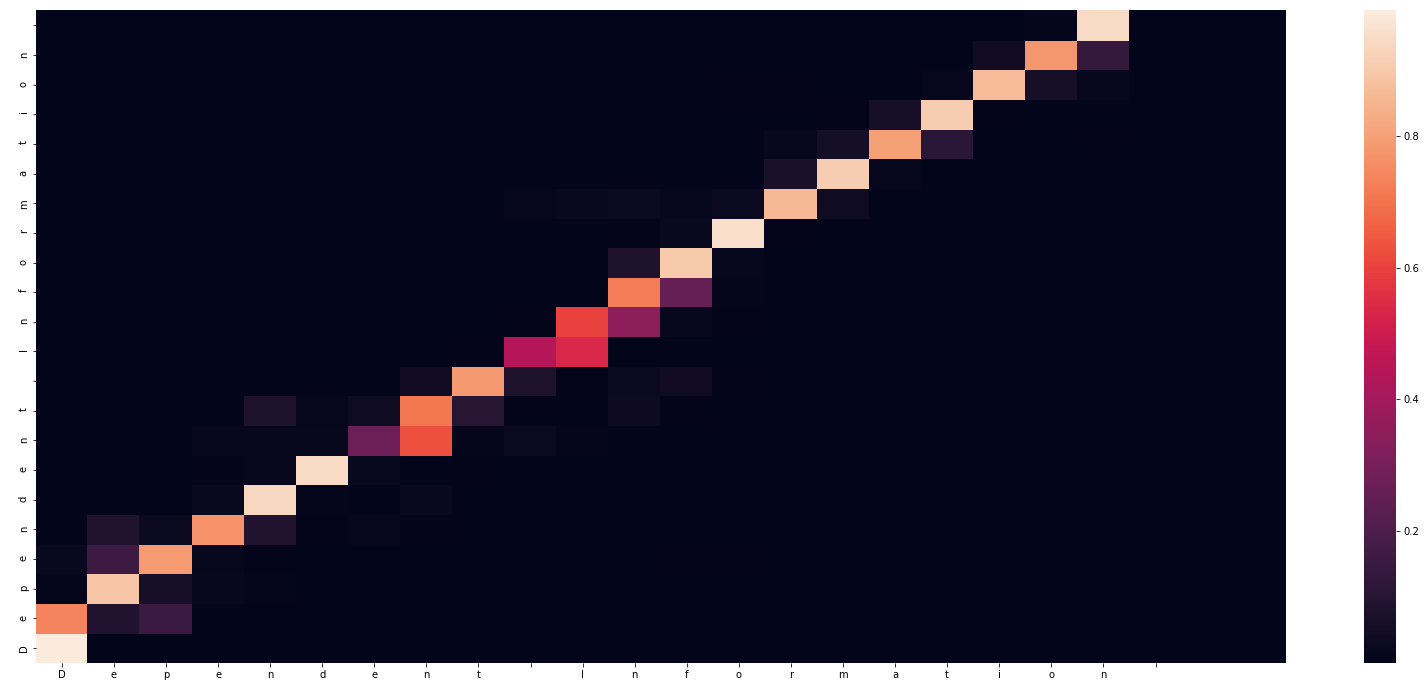

-
Input sentence: Dependent Information 
GT sentence: Dependent Information

Decoded sentence: Dependent Information



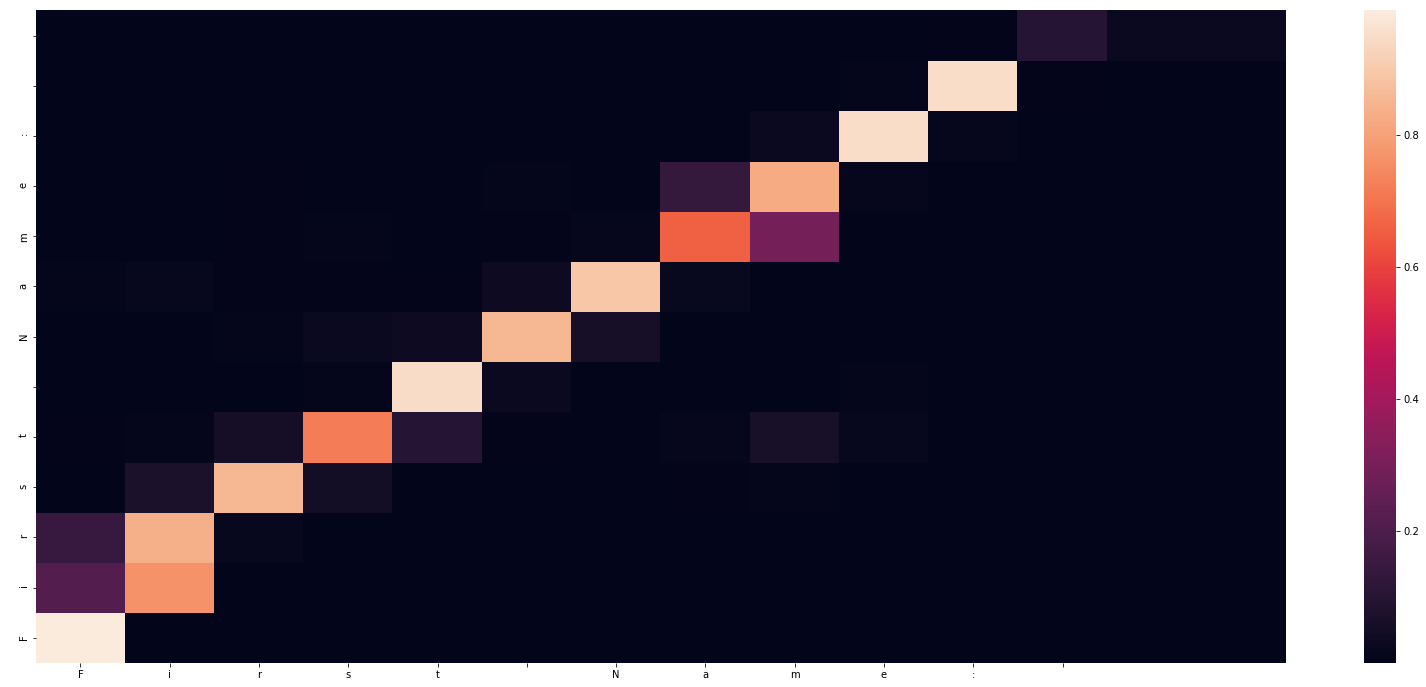

-
Input sentence: First Name: 
GT sentence: First Name:

Decoded sentence: First Name: 



In [61]:
for seq_index in range(100):

    target_text = target_texts[seq_index][1:-1]
    text = input_texts[seq_index]
    decoded_sentence = visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, vocab_to_int, int_to_vocab)
    print('-')
    print('Input sentence:', text)
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)  

# Domain transfer from noisy spelling mistakes to OCR corrections

In [ ]:
model, encoder_model, decoder_model = build_model(latent_dim=latent_dim, num_encoder_tokens=num_encoder_tokens)

## Pre-train on noisy spelling mistakes

In [ ]:

input_texts = input_texts_noisy_OCR
target_texts = target_texts_noisy_OCR

encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

batch_size = 64  # Batch size for training.
epochs = 50  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
lr = 0.01

#filepath="weights-improvement-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
filepath="best_model_transfer.hdf5" # Save only the best model for inference step, as saving the epoch and metric might confuse the inference function which model to use
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]
#callbacks_list = [checkpoint, tbCallBack, lrate]

#model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])


model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          #validation_data = ([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          validation_split=0.2,
          shuffle=True)

## Fine tune on OCR correction data

In [ ]:

input_texts = input_texts_OCR
target_texts = target_texts_OCR

# Keep test data from the corrected OCR, as this what we care about
input_texts, test_input_texts, target_texts, test_target_texts  = train_test_split(input_texts, target_texts, test_size = 0.15, random_state = 42)

# Vectorize train data
encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)
# Vectorize test data
test_encoder_input_data, test_decoder_input_data, test_decoder_target_data = vectorize_data(input_texts=test_input_texts,
                                                                                            target_texts=test_target_texts, 
                                                                                            max_encoder_seq_length=max_encoder_seq_length, 
                                                                                            num_encoder_tokens=num_encoder_tokens, 
                                                                                            vocab_to_int=vocab_to_int)


batch_size = 64  # Batch size for training.
epochs = 50  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
lr = 0.001# Reduce the learning rate for fine tuning
model.load_weights('best_model_transfer.hdf5')
model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])


model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          validation_data = ([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          #validation_split=0.2,
          shuffle=True)

In [ ]:
model.load_weights('best_model_transfer.hdf5')

In [ ]:

# Sample output from test data
decoded_sentences = []
target_texts_ =  []

for seq_index in range(len(test_input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = test_encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence, _ = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = test_target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', test_input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)
    
WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
print('WER_spell_correction |TEST= ', WER_spell_correction)

WER_OCR = calculate_WER(target_texts_, test_input_texts)
print('WER_OCR |TEST= ', WER_OCR)   

# Next steps
- Add attention
- Full attention
- Condition the Encoder on word embeddings of the context (Bi-directional LSTM)
- Condition the Decoder on word embeddings of the context (Bi-directional LSTM) 

## References
- Sequence to Sequence Learning with Neural Networks
    https://arxiv.org/abs/1409.3215
- Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    https://arxiv.org/abs/1406.107